In [1]:
%load_ext autoreload
%autoreload 2

from typing import Literal, Union
from pathlib import Path
import csv
from datetime import datetime
import random


import pandas as pd
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import MIPROv2
from sklearn.model_selection import train_test_split

from programs import WrapperEnglishSPT, evaluate_answer
from custom_evaluation import custom_evaluate

In [2]:
lm = dspy.LM(
    "ollama_chat/deepseek-r1:70b",
    api_base="http://localhost:11434",
)
dspy.settings.configure(lm=lm)

In [3]:
lm("Who is the president of China?")

["\n\nThe President of the People's Republic of China is Xi Jinping."]

In [4]:
data = pd.read_csv("dev_dwug_es.csv")
display(data.shape)

(8704, 8)

In [5]:
training_set = []

for _, row in data.iterrows():
    training_set.append(
        dspy.Example(
            sentence1=row["context_x"],
            sentence2=row["context_y"],
            target_word=row["lemma"],
            answer=int(row["judgment"]),
        ).with_inputs("sentence1", "sentence2", "target_word")
    )

In [6]:
classes_1_es = [item for item in training_set if item.answer == 1]
classes_2_es = [item for item in training_set if item.answer == 2]
classes_3_es = [item for item in training_set if item.answer == 3]
classes_4_es = [item for item in training_set if item.answer == 4]

print(len(classes_1_es))
print(len(classes_2_es))
print(len(classes_3_es))
print(len(classes_4_es))

classes_1_train, classes_1_dev = train_test_split(
    classes_1_es,
    test_size=0.2,
    random_state=42,
)

classes_1_train, classes_1_test = train_test_split(
    classes_1_train, test_size=0.2, random_state=42
)


classes_2_train, classes_2_dev = train_test_split(
    classes_2_es,
    test_size=0.2,
    random_state=42,
)
classes_2_train, classes_2_test = train_test_split(
    classes_2_train, test_size=0.2, random_state=42
)


classes_3_train, classes_3_dev = train_test_split(
    classes_3_es,
    test_size=0.2,
    random_state=42,
)
classes_3_train, classes_3_test = train_test_split(
    classes_3_train, test_size=0.2, random_state=42
)


classes_4_train, classes_4_dev = train_test_split(
    classes_4_es,
    test_size=0.2,
    random_state=42,
)
classes_4_train, classes_4_test = train_test_split(
    classes_4_train,
    test_size=0.2,
    random_state=42,
)

print(len(classes_1_train), len(classes_1_dev), len(classes_1_test))
print(len(classes_2_train), len(classes_2_dev), len(classes_2_test))
print(len(classes_3_train), len(classes_3_dev), len(classes_3_test))
print(len(classes_4_train), len(classes_4_dev), len(classes_4_test))

1406
1522
2343
3433
899 282 225
973 305 244
1499 469 375
2196 687 550


In [7]:
program_spt_prompt_en_assertions = WrapperEnglishSPT().activate_assertions()

In [8]:
custom_evaluate(
    random.choices(classes_1_test, k=225)
    + random.choices(classes_2_test, k=225)
    + random.choices(classes_3_test, k=225)
    + random.choices(classes_4_test, k=225),
    evaluate_answer,
    program_spt_prompt_en_assertions,
    debug=False,
)

Evaluating: 900 examples


Accurate examples: 393
Bad-formatted examples: 18
Accuracy: 44.5578231292517


In [9]:
%reload_ext autoreload

start_time = datetime.now()

teleprompter = MIPROv2(
    metric=evaluate_answer,
    task_model=lm,
    num_candidates=10,
    init_temperature=0.7,
    max_bootstrapped_demos=3,
    max_labeled_demos=4,
    verbose=False,
)

print("Optimizing program with MIPRO...")
optimized_program = teleprompter.compile(
    program_spt_prompt_en_assertions.deepcopy(),
    trainset=random.choices(classes_1_train, k=500)
    + random.choices(classes_2_train, k=500)
    + random.choices(classes_3_train, k=500)
    + random.choices(classes_4_train, k=500),
    valset=random.choices(classes_1_dev, k=200)
    + random.choices(classes_2_dev, k=200)
    + random.choices(classes_3_dev, k=200)
    + random.choices(classes_4_dev, k=200),
    num_trials=15,
    minibatch_size=25,
    minibatch_full_eval_steps=10,
    minibatch=True,
    requires_permission_to_run=False,
)

optimized_program.save(f"compile-models/sp/es_spt_mipro_optimized_prompt_en_deepseek-70b-q4")

print(f"Elapsed time: {datetime.now() - start_time}")

2025/05/08 21:37:36 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==


2025/05/08 21:37:36 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.



2025/05/08 21:37:36 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=10 sets of demonstrations...


Optimizing program with MIPRO...
Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [02:07<70:47:33, 127.49s/it]

  0%|                                                                                                      | 2/2000 [05:28<94:39:10, 170.55s/it]

  0%|▏                                                                                                     | 3/2000 [07:51<87:43:26, 158.14s/it]

  0%|▏                                                                                                     | 4/2000 [11:17<98:12:26, 177.13s/it]

  0%|▎                                                                                                     | 5/2000 [13:03<83:52:18, 151.35s/it]

  0%|▎                                                                                                     | 5/2000 [13:03<86:49:47, 156.69s/it]

Bootstrapped 3 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 4/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                       | 1/2000 [01:25<47:38:29, 85.80s/it]

  0%|                                                                                                       | 1/2000 [01:25<47:38:31, 85.80s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [01:55<63:54:05, 115.08s/it]

  0%|                                                                                                      | 1/2000 [01:55<63:54:08, 115.08s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 6/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [02:05<69:50:45, 125.79s/it]

  0%|                                                                                                      | 2/2000 [03:52<63:34:31, 114.55s/it]

  0%|▏                                                                                                     | 3/2000 [06:23<72:40:27, 131.01s/it]

  0%|▏                                                                                                     | 4/2000 [09:14<81:33:03, 147.09s/it]

  0%|▎                                                                                                     | 5/2000 [11:38<80:54:06, 145.99s/it]

  0%|▎                                                                                                     | 5/2000 [11:38<77:27:17, 139.77s/it]

Bootstrapped 2 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 7/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [01:40<55:37:48, 100.18s/it]

  0%|                                                                                                      | 2/2000 [04:26<77:08:02, 138.98s/it]

  0%|▏                                                                                                     | 3/2000 [07:10<83:33:13, 150.62s/it]

  0%|▏                                                                                                     | 4/2000 [08:46<71:23:54, 128.77s/it]

  0%|▎                                                                                                     | 5/2000 [10:59<72:19:59, 130.53s/it]

  0%|▎                                                                                                     | 6/2000 [14:03<82:18:57, 148.61s/it]

  0%|▎                                                                                                     | 6/2000 [14:03<77:51:44, 140.57s/it]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Bootstrapping set 8/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [02:35<86:18:54, 155.45s/it]

  0%|                                                                                                      | 2/2000 [05:38<95:15:20, 171.63s/it]

  0%|▏                                                                                                     | 3/2000 [07:50<85:17:22, 153.75s/it]

  0%|▏                                                                                                     | 4/2000 [10:26<85:37:45, 154.44s/it]

  0%|▎                                                                                                     | 5/2000 [12:49<83:15:46, 150.25s/it]

  0%|▎                                                                                                     | 6/2000 [15:44<87:56:17, 158.77s/it]

  0%|▎                                                                                                     | 7/2000 [19:20<98:16:09, 177.51s/it]

  0%|▍                                                                                                     | 8/2000 [21:04<85:10:45, 153.94s/it]

  0%|▍                                                                                                     | 9/2000 [23:13<80:55:36, 146.33s/it]

  0%|▍                                                                                                     | 9/2000 [23:13<85:38:26, 154.85s/it]

Bootstrapped 1 full traces after 9 examples for up to 1 rounds, amounting to 9 attempts.
Bootstrapping set 9/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/2000 [02:27<81:54:18, 147.50s/it]

  0%|                                                                                                      | 2/2000 [05:19<89:45:11, 161.72s/it]

  0%|▏                                                                                                     | 3/2000 [08:37<99:04:53, 178.61s/it]

  0%|▏                                                                                                    | 4/2000 [11:50<102:09:54, 184.27s/it]

  0%|▎                                                                                                    | 5/2000 [14:46<100:19:55, 181.05s/it]

  0%|▎                                                                                                     | 6/2000 [17:24<96:05:16, 173.48s/it]

  0%|▎                                                                                                     | 7/2000 [20:27<97:43:04, 176.51s/it]

  0%|▎                                                                                                     | 7/2000 [20:27<97:05:45, 175.39s/it]

Bootstrapped 3 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Bootstrapping set 10/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                       | 1/2000 [01:26<48:17:03, 86.96s/it]

  0%|                                                                                                     | 2/2000 [05:38<101:59:24, 183.77s/it]

  0%|                                                                                                      | 2/2000 [05:38<93:55:51, 169.24s/it]


2025/05/08 23:09:02 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==


2025/05/08 23:09:02 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/05/08 23:21:16 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a highly trained text data annotation tool capable of
providing subjective responses. Rate the semantic similarity of the target word in these sentences 1 and 2. Consider
only the objects/concepts the word forms refer to: ignore any common etymology and
metaphorical similarity! Ignore case! Ignore number (cat/Cats = identical meaning). Homonyms (like bat the animal vs
bat in baseball) count as unrelated. Output numeric rating: 1 is unrelated; 2 is distantly
related; 3 is closely related; 4 is identical meaning. Your response should align with a
human’s succinct judgment.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert annotator specializing in semantic analysis, tasked with evaluating the similarity of a target word's usage in two sentences. Consider only the specific concepts or objects referred to by the word, ignoring case and number. Homonyms count as unrelated. Rate similarity on a scale from 1 (unrelated) to 4 (identical meaning). Your response should reflect human-like judgment.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You must carefully assess the semantic similarity of the target word in two sentences on a scale from 1 (unrelated) to 4 (identical meaning). Your task is crucial for a high-stakes project where accurate linguistic analysis determines system performance. Consider only the direct meanings and contexts, ignoring etymology or metaphors. Homonyms count as unrelated.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 3: Rate the semantic similarity between the target word's meanings in sentence 1 and sentence 2. Consider only the specific concepts or objects each instance refers to, ignoring etymology, metaphors, case, number (e.g., 'cat' vs 'cats'), and homonyms. Assign a score: 1 if unrelated, 2 if distantly related, 3 if closely related, and 4 if identical in meaning.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 4: You are a highly trained text data annotation tool capable of providing subjective responses. Rate the semantic similarity of the target word in these sentences 1 and 2. Consider only the objects/concepts the word forms refer to: ignore any common etymology and metaphorical similarity! Ignore case! Ignore number (cat/Cats = identical meaning). Homonyms (like bat the animal vs bat in baseball) count as unrelated. Output numeric rating: 1 is unrelated; 2 is distantly related; 3 is closely related; 4 is identical meaning. Your response should align with a human’s succinct judgment.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 5: You are a linguistic analyst evaluating the semantic similarity of specific words across two sentences. Ignore etymology and metaphorical meanings; focus solely on the concepts the word represents. Homonyms count as unrelated. Assign a rating from 1 (unrelated) to 4 (identical meaning).



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 6: You are an expert in semantic analysis. Your task is to evaluate the meaning similarity of a target word used in two different sentences. Ratings are as follows:  
1 - Completely unrelated meanings  
2 - Distantly related concepts  
3 - Closely related meanings  
4 - Identical meanings  

Ignore etymology, metaphors, and grammatical differences (e.g., singular vs plural). Homonyms count as separate unless context aligns their meanings. Provide a numerical rating based on the target word's meaning in each sentence.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 7: You are a highly trained text data annotation tool capable of providing subjective responses. Your task is to evaluate the semantic similarity of the target word's meanings in two given sentences. Consider only the objects or concepts the word forms refer to, ignoring etymology and metaphorical similarities. Case and number differences should be disregarded (e.g., "cat" and "cats" are identical). Homonyms count as unrelated unless explicitly connected. Assign a numeric rating:
- 1: Unrelated meanings.
- 2: Distantly related concepts.
- 3: Closely related concepts.
- 4: Identical meanings.

Provide your response in the format: 
`reasoning: [explanation]`
`answer: [numeric score from 1 to 4]`

Example:
- Sentence 1 context: "corona" refers to a currency (Danish krone).
- Sentence 2 context: "corona" refers to a crown worn by a religious figure.
- Reasoning: The uses are unrelated as they refer to different concepts (currency

2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 8: You are to evaluate the semantic similarity between two uses of the same Spanish word in different contexts. Your task is to assess how closely related the meanings of the word are across the provided sentences. 

Consider only the literal, denotative meanings of the word in each context. Ignore any etymological connections or metaphorical extensions. Homonyms (words with identical spelling but different meanings) count as separate concepts. Disregard grammatical number and case when evaluating similarity.

Possible ratings:
- 1: The word refers to completely unrelated concepts.
- 2: The word refers to distantly related concepts, sharing a broad category but distinct in meaning.
- 3: The word refers to closely related concepts, with some overlap in meaning.
- 4: The word refers to the same concept, with identical or nearly identical meanings.

Carefully analyze each sentence and assign a rating based on this scale. Your re

2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 9: Rate the semantic similarity of the target word in the provided sentences using the following scale: 1 (unrelated), 2 (distantly related), 3 (closely related), 4 (identical meaning). Consider only the objects/concepts the word refers to, ignoring etymology and metaphor. Homonyms count as unrelated.



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/09 00:21:09 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the default program...



  0%|                                                                                                                   | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                   | 0/800 [01:35<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                        | 1/800 [01:35<21:07:54, 95.21s/it]

Average Metric: 1 / 2  (50.0):   0%|                                                                         | 1/800 [03:47<21:07:54, 95.21s/it]

Average Metric: 1 / 2  (50.0):   0%|▏                                                                       | 2/800 [03:47<26:00:15, 117.31s/it]

Average Metric: 1 / 3  (33.3):   0%|▏                                                                       | 2/800 [05:17<26:00:15, 117.31s/it]

Average Metric: 1 / 3  (33.3):   0%|▎                                                                       | 3/800 [05:17<23:11:41, 104.77s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                       | 3/800 [07:50<23:11:41, 104.77s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                       | 4/800 [07:50<27:20:58, 123.69s/it]

Average Metric: 1 / 5  (20.0):   0%|▎                                                                       | 4/800 [11:55<27:20:58, 123.69s/it]

Average Metric: 1 / 5  (20.0):   1%|▍                                                                       | 5/800 [11:55<36:59:54, 167.54s/it]

Average Metric: 2 / 6  (33.3):   1%|▍                                                                       | 5/800 [13:46<36:59:54, 167.54s/it]

Average Metric: 2 / 6  (33.3):   1%|▌                                                                       | 6/800 [13:47<32:43:30, 148.38s/it]

Average Metric: 3 / 7  (42.9):   1%|▌                                                                       | 6/800 [15:22<32:43:30, 148.38s/it]

Average Metric: 3 / 7  (42.9):   1%|▋                                                                       | 7/800 [15:22<28:54:41, 131.25s/it]

Average Metric: 4 / 8  (50.0):   1%|▋                                                                       | 7/800 [16:36<28:54:41, 131.25s/it]

Average Metric: 4 / 8  (50.0):   1%|▋                                                                       | 8/800 [16:36<24:48:53, 112.79s/it]

Average Metric: 5 / 9  (55.6):   1%|▋                                                                       | 8/800 [17:50<24:48:53, 112.79s/it]

Average Metric: 5 / 9  (55.6):   1%|▊                                                                       | 9/800 [17:50<22:09:43, 100.86s/it]

Average Metric: 5 / 10  (50.0):   1%|▊                                                                      | 9/800 [17:50<22:09:43, 100.86s/it]

Average Metric: 5 / 11  (45.5):   1%|▉                                                                     | 10/800 [19:15<22:08:02, 100.86s/it]

Average Metric: 5 / 11  (45.5):   1%|▉                                                                      | 11/800 [19:15<16:04:12, 73.32s/it]

Average Metric: 6 / 12  (50.0):   1%|▉                                                                      | 11/800 [20:47<16:04:12, 73.32s/it]

Average Metric: 6 / 12  (50.0):   2%|█                                                                      | 12/800 [20:47<17:03:48, 77.95s/it]

Average Metric: 7 / 13  (53.8):   2%|█                                                                      | 12/800 [24:50<17:03:48, 77.95s/it]

Average Metric: 7 / 13  (53.8):   2%|█▏                                                                    | 13/800 [24:50<26:34:40, 121.58s/it]

Average Metric: 7 / 14  (50.0):   2%|█▏                                                                    | 13/800 [26:44<26:34:40, 121.58s/it]

Average Metric: 7 / 14  (50.0):   2%|█▏                                                                    | 14/800 [26:44<26:06:56, 119.61s/it]

Average Metric: 7 / 15  (46.7):   2%|█▏                                                                    | 14/800 [28:39<26:06:56, 119.61s/it]

Average Metric: 7 / 15  (46.7):   2%|█▎                                                                    | 15/800 [28:39<25:46:43, 118.22s/it]

Average Metric: 8 / 16  (50.0):   2%|█▎                                                                    | 15/800 [29:45<25:46:43, 118.22s/it]

Average Metric: 8 / 16  (50.0):   2%|█▍                                                                    | 16/800 [29:45<22:29:23, 103.27s/it]

Average Metric: 8 / 17  (47.1):   2%|█▍                                                                    | 16/800 [33:37<22:29:23, 103.27s/it]

Average Metric: 8 / 17  (47.1):   2%|█▍                                                                    | 17/800 [33:37<30:36:11, 140.70s/it]

Average Metric: 8 / 18  (44.4):   2%|█▍                                                                    | 17/800 [35:00<30:36:11, 140.70s/it]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                    | 18/800 [35:00<26:52:40, 123.73s/it]

Average Metric: 8 / 19  (42.1):   2%|█▌                                                                    | 18/800 [36:13<26:52:40, 123.73s/it]

Average Metric: 8 / 19  (42.1):   2%|█▋                                                                    | 19/800 [36:13<23:36:48, 108.85s/it]

Average Metric: 8 / 20  (40.0):   2%|█▋                                                                    | 19/800 [37:46<23:36:48, 108.85s/it]

Average Metric: 8 / 20  (40.0):   2%|█▊                                                                    | 20/800 [37:46<22:34:46, 104.21s/it]

Average Metric: 8 / 21  (38.1):   2%|█▊                                                                    | 20/800 [39:23<22:34:46, 104.21s/it]

Average Metric: 8 / 21  (38.1):   3%|█▊                                                                    | 21/800 [39:23<22:05:07, 102.06s/it]

Average Metric: 8 / 22  (36.4):   3%|█▊                                                                    | 21/800 [41:12<22:05:07, 102.06s/it]

Average Metric: 8 / 22  (36.4):   3%|█▉                                                                    | 22/800 [41:12<22:28:42, 104.01s/it]

Average Metric: 8 / 23  (34.8):   3%|█▉                                                                    | 22/800 [42:47<22:28:42, 104.01s/it]

Average Metric: 8 / 23  (34.8):   3%|██                                                                    | 23/800 [42:47<21:53:24, 101.42s/it]

Average Metric: 8 / 24  (33.3):   3%|██                                                                    | 23/800 [44:59<21:53:24, 101.42s/it]

Average Metric: 8 / 24  (33.3):   3%|██                                                                    | 24/800 [44:59<23:49:48, 110.55s/it]

Average Metric: 9 / 25  (36.0):   3%|██                                                                    | 24/800 [46:51<23:49:48, 110.55s/it]

Average Metric: 9 / 25  (36.0):   3%|██▏                                                                   | 25/800 [46:51<23:52:12, 110.88s/it]

Average Metric: 10 / 26  (38.5):   3%|██▏                                                                  | 25/800 [52:19<23:52:12, 110.88s/it]

Average Metric: 10 / 26  (38.5):   3%|██▏                                                                  | 26/800 [52:19<37:49:02, 175.89s/it]

Average Metric: 10 / 27  (37.0):   3%|██▏                                                                  | 26/800 [53:35<37:49:02, 175.89s/it]

Average Metric: 10 / 27  (37.0):   3%|██▎                                                                  | 27/800 [53:35<31:19:31, 145.89s/it]

Average Metric: 11 / 28  (39.3):   3%|██▎                                                                  | 27/800 [55:21<31:19:31, 145.89s/it]

Average Metric: 11 / 28  (39.3):   4%|██▍                                                                  | 28/800 [55:21<28:43:29, 133.95s/it]

Average Metric: 11 / 29  (37.9):   4%|██▍                                                                  | 28/800 [56:42<28:43:29, 133.95s/it]

Average Metric: 11 / 29  (37.9):   4%|██▌                                                                  | 29/800 [56:42<25:19:41, 118.26s/it]

Average Metric: 11 / 30  (36.7):   4%|██▌                                                                  | 29/800 [56:42<25:19:41, 118.26s/it]

Average Metric: 12 / 31  (38.7):   4%|██▌                                                                  | 30/800 [58:21<25:17:43, 118.26s/it]

Average Metric: 12 / 31  (38.7):   4%|██▋                                                                   | 31/800 [58:21<18:28:22, 86.48s/it]

Average Metric: 12 / 32  (37.5):   4%|██▋                                                                   | 31/800 [59:49<18:28:22, 86.48s/it]

Average Metric: 12 / 32  (37.5):   4%|██▊                                                                   | 32/800 [59:49<18:32:55, 86.95s/it]

Average Metric: 13 / 33  (39.4):   4%|██▋                                                                 | 32/800 [1:01:22<18:32:55, 86.95s/it]

Average Metric: 13 / 33  (39.4):   4%|██▊                                                                 | 33/800 [1:01:22<18:51:33, 88.52s/it]

Average Metric: 13 / 34  (38.2):   4%|██▊                                                                 | 33/800 [1:03:17<18:51:33, 88.52s/it]

Average Metric: 13 / 34  (38.2):   4%|██▉                                                                 | 34/800 [1:03:17<20:21:29, 95.68s/it]

Average Metric: 14 / 35  (40.0):   4%|██▉                                                                 | 34/800 [1:04:52<20:21:29, 95.68s/it]

Average Metric: 14 / 35  (40.0):   4%|██▉                                                                 | 35/800 [1:04:52<20:16:56, 95.45s/it]

Average Metric: 14 / 36  (38.9):   4%|██▉                                                                 | 35/800 [1:07:45<20:16:56, 95.45s/it]

Average Metric: 14 / 36  (38.9):   4%|███                                                                | 36/800 [1:07:45<24:55:46, 117.47s/it]

Average Metric: 14 / 37  (37.8):   4%|███                                                                | 36/800 [1:09:29<24:55:46, 117.47s/it]

Average Metric: 14 / 37  (37.8):   5%|███                                                                | 37/800 [1:09:29<24:04:32, 113.59s/it]

Average Metric: 15 / 38  (39.5):   5%|███                                                                | 37/800 [1:11:12<24:04:32, 113.59s/it]

Average Metric: 15 / 38  (39.5):   5%|███▏                                                               | 38/800 [1:11:12<23:23:06, 110.48s/it]

Average Metric: 15 / 39  (38.5):   5%|███▏                                                               | 38/800 [1:13:06<23:23:06, 110.48s/it]

Average Metric: 15 / 39  (38.5):   5%|███▎                                                               | 39/800 [1:13:06<23:36:07, 111.65s/it]

Average Metric: 16 / 40  (40.0):   5%|███▎                                                               | 39/800 [1:15:12<23:36:07, 111.65s/it]

Average Metric: 16 / 40  (40.0):   5%|███▎                                                               | 40/800 [1:15:12<24:28:30, 115.93s/it]

Average Metric: 17 / 41  (41.5):   5%|███▎                                                               | 40/800 [1:17:05<24:28:30, 115.93s/it]

Average Metric: 17 / 41  (41.5):   5%|███▍                                                               | 41/800 [1:17:05<24:12:36, 114.83s/it]

Average Metric: 18 / 42  (42.9):   5%|███▍                                                               | 41/800 [1:18:39<24:12:36, 114.83s/it]

Average Metric: 18 / 42  (42.9):   5%|███▌                                                               | 42/800 [1:18:39<22:52:57, 108.68s/it]

Average Metric: 19 / 43  (44.2):   5%|███▌                                                               | 42/800 [1:20:32<22:52:57, 108.68s/it]

Average Metric: 19 / 43  (44.2):   5%|███▌                                                               | 43/800 [1:20:32<23:08:48, 110.08s/it]

Average Metric: 20 / 44  (45.5):   5%|███▌                                                               | 43/800 [1:21:43<23:08:48, 110.08s/it]

Average Metric: 20 / 44  (45.5):   6%|███▋                                                                | 44/800 [1:21:43<20:37:55, 98.25s/it]

Average Metric: 21 / 45  (46.7):   6%|███▋                                                                | 44/800 [1:23:44<20:37:55, 98.25s/it]

Average Metric: 21 / 45  (46.7):   6%|███▊                                                               | 45/800 [1:23:44<22:01:41, 105.03s/it]

Average Metric: 21 / 46  (45.7):   6%|███▊                                                               | 45/800 [1:25:43<22:01:41, 105.03s/it]

Average Metric: 21 / 46  (45.7):   6%|███▊                                                               | 46/800 [1:25:43<22:53:33, 109.30s/it]

Average Metric: 22 / 47  (46.8):   6%|███▊                                                               | 46/800 [1:26:56<22:53:33, 109.30s/it]

Average Metric: 22 / 47  (46.8):   6%|███▉                                                                | 47/800 [1:26:56<20:37:27, 98.60s/it]

Average Metric: 23 / 48  (47.9):   6%|███▉                                                                | 47/800 [1:26:56<20:37:27, 98.60s/it]

Average Metric: 23 / 49  (46.9):   6%|████                                                                | 48/800 [1:29:06<20:35:49, 98.60s/it]

Average Metric: 23 / 49  (46.9):   6%|████▏                                                               | 49/800 [1:29:06<17:20:16, 83.11s/it]

Average Metric: 24 / 50  (48.0):   6%|████▏                                                               | 49/800 [1:30:10<17:20:16, 83.11s/it]

Average Metric: 24 / 50  (48.0):   6%|████▎                                                               | 50/800 [1:30:10<16:19:41, 78.38s/it]

Average Metric: 25 / 51  (49.0):   6%|████▎                                                               | 50/800 [1:31:35<16:19:41, 78.38s/it]

Average Metric: 25 / 51  (49.0):   6%|████▎                                                               | 51/800 [1:31:35<16:38:24, 79.98s/it]

Average Metric: 25 / 52  (48.1):   6%|████▎                                                               | 51/800 [1:33:39<16:38:24, 79.98s/it]

Average Metric: 25 / 52  (48.1):   6%|████▍                                                               | 52/800 [1:33:39<19:06:39, 91.98s/it]

Average Metric: 25 / 53  (47.2):   6%|████▍                                                               | 52/800 [1:36:01<19:06:39, 91.98s/it]

Average Metric: 25 / 53  (47.2):   7%|████▍                                                              | 53/800 [1:36:01<21:59:21, 105.97s/it]

Average Metric: 25 / 54  (46.3):   7%|████▍                                                              | 53/800 [1:37:50<21:59:21, 105.97s/it]

Average Metric: 25 / 54  (46.3):   7%|████▌                                                              | 54/800 [1:37:50<22:07:52, 106.80s/it]

Average Metric: 26 / 55  (47.3):   7%|████▌                                                              | 54/800 [1:39:17<22:07:52, 106.80s/it]

Average Metric: 26 / 55  (47.3):   7%|████▌                                                              | 55/800 [1:39:17<20:56:49, 101.22s/it]

Average Metric: 26 / 56  (46.4):   7%|████▌                                                              | 55/800 [1:41:01<20:56:49, 101.22s/it]

Average Metric: 26 / 56  (46.4):   7%|████▋                                                              | 56/800 [1:41:01<21:03:33, 101.90s/it]

Average Metric: 26 / 57  (45.6):   7%|████▋                                                              | 56/800 [1:42:58<21:03:33, 101.90s/it]

Average Metric: 26 / 57  (45.6):   7%|████▊                                                              | 57/800 [1:42:58<21:55:11, 106.21s/it]

Average Metric: 27 / 58  (46.6):   7%|████▊                                                              | 57/800 [1:44:01<21:55:11, 106.21s/it]

Average Metric: 27 / 58  (46.6):   7%|████▉                                                               | 58/800 [1:44:01<19:16:30, 93.52s/it]

Average Metric: 27 / 59  (45.8):   7%|████▉                                                               | 58/800 [1:44:01<19:16:30, 93.52s/it]

Average Metric: 27 / 60  (45.0):   7%|█████                                                               | 59/800 [1:45:28<19:14:56, 93.52s/it]

Average Metric: 27 / 60  (45.0):   8%|█████                                                               | 60/800 [1:45:28<14:29:27, 70.50s/it]

Average Metric: 28 / 61  (45.9):   8%|█████                                                               | 60/800 [1:47:15<14:29:27, 70.50s/it]

Average Metric: 28 / 61  (45.9):   8%|█████▏                                                              | 61/800 [1:47:15<16:21:58, 79.73s/it]

Average Metric: 29 / 62  (46.8):   8%|█████▏                                                              | 61/800 [1:48:31<16:21:58, 79.73s/it]

Average Metric: 29 / 62  (46.8):   8%|█████▎                                                              | 62/800 [1:48:31<16:06:34, 78.58s/it]

Average Metric: 30 / 63  (47.6):   8%|█████▎                                                              | 62/800 [1:50:29<16:06:34, 78.58s/it]

Average Metric: 30 / 63  (47.6):   8%|█████▎                                                              | 63/800 [1:50:29<18:15:46, 89.21s/it]

Average Metric: 31 / 64  (48.4):   8%|█████▎                                                              | 63/800 [1:52:06<18:15:46, 89.21s/it]

Average Metric: 31 / 64  (48.4):   8%|█████▍                                                              | 64/800 [1:52:06<18:41:12, 91.40s/it]

Average Metric: 31 / 65  (47.7):   8%|█████▍                                                              | 64/800 [1:54:00<18:41:12, 91.40s/it]

Average Metric: 31 / 65  (47.7):   8%|█████▌                                                              | 65/800 [1:54:00<19:59:47, 97.94s/it]

Average Metric: 31 / 66  (47.0):   8%|█████▌                                                              | 65/800 [1:55:46<19:59:47, 97.94s/it]

Average Metric: 31 / 66  (47.0):   8%|█████▌                                                             | 66/800 [1:55:46<20:27:22, 100.33s/it]

Average Metric: 32 / 67  (47.8):   8%|█████▌                                                             | 66/800 [1:55:46<20:27:22, 100.33s/it]

Average Metric: 32 / 68  (47.1):   8%|█████▌                                                             | 67/800 [1:55:46<20:25:42, 100.33s/it]

Average Metric: 32 / 69  (46.4):   8%|█████▋                                                             | 68/800 [1:58:24<20:24:01, 100.33s/it]

Average Metric: 32 / 69  (46.4):   9%|█████▊                                                              | 69/800 [1:58:24<14:59:28, 73.83s/it]

Average Metric: 32 / 70  (45.7):   9%|█████▊                                                              | 69/800 [2:00:25<14:59:28, 73.83s/it]

Average Metric: 32 / 70  (45.7):   9%|█████▉                                                              | 70/800 [2:00:25<16:58:35, 83.72s/it]

Average Metric: 32 / 71  (45.1):   9%|█████▉                                                              | 70/800 [2:02:06<16:58:35, 83.72s/it]

Average Metric: 32 / 71  (45.1):   9%|██████                                                              | 71/800 [2:02:06<17:47:04, 87.82s/it]

Average Metric: 33 / 72  (45.8):   9%|██████                                                              | 71/800 [2:03:46<17:47:04, 87.82s/it]

Average Metric: 33 / 72  (45.8):   9%|██████                                                              | 72/800 [2:03:46<18:21:44, 90.80s/it]

Average Metric: 34 / 73  (46.6):   9%|██████                                                              | 72/800 [2:05:22<18:21:44, 90.80s/it]

Average Metric: 34 / 73  (46.6):   9%|██████▏                                                             | 73/800 [2:05:22<18:37:08, 92.20s/it]

Average Metric: 35 / 74  (47.3):   9%|██████▏                                                             | 73/800 [2:06:57<18:37:08, 92.20s/it]

Average Metric: 35 / 74  (47.3):   9%|██████▎                                                             | 74/800 [2:06:57<18:43:07, 92.82s/it]

Average Metric: 36 / 75  (48.0):   9%|██████▎                                                             | 74/800 [2:08:52<18:43:07, 92.82s/it]

Average Metric: 36 / 75  (48.0):   9%|██████▍                                                             | 75/800 [2:08:52<19:57:28, 99.10s/it]

Average Metric: 36 / 76  (47.4):   9%|██████▍                                                             | 75/800 [2:11:00<19:57:28, 99.10s/it]

Average Metric: 36 / 76  (47.4):  10%|██████▎                                                            | 76/800 [2:11:00<21:35:24, 107.35s/it]

Average Metric: 37 / 77  (48.1):  10%|██████▎                                                            | 76/800 [2:12:37<21:35:24, 107.35s/it]

Average Metric: 37 / 77  (48.1):  10%|██████▍                                                            | 77/800 [2:12:37<20:55:29, 104.19s/it]

Average Metric: 37 / 78  (47.4):  10%|██████▍                                                            | 77/800 [2:14:32<20:55:29, 104.19s/it]

Average Metric: 37 / 78  (47.4):  10%|██████▌                                                            | 78/800 [2:14:32<21:34:34, 107.58s/it]

Average Metric: 37 / 79  (46.8):  10%|██████▌                                                            | 78/800 [2:16:09<21:34:34, 107.58s/it]

Average Metric: 37 / 79  (46.8):  10%|██████▌                                                            | 79/800 [2:16:09<20:54:27, 104.39s/it]

Average Metric: 37 / 80  (46.2):  10%|██████▌                                                            | 79/800 [2:18:07<20:54:27, 104.39s/it]

Average Metric: 37 / 80  (46.2):  10%|██████▋                                                            | 80/800 [2:18:07<21:40:28, 108.37s/it]

Average Metric: 38 / 81  (46.9):  10%|██████▋                                                            | 80/800 [2:18:07<21:40:28, 108.37s/it]

Average Metric: 39 / 82  (47.6):  10%|██████▊                                                            | 81/800 [2:18:07<21:38:40, 108.37s/it]

Average Metric: 39 / 83  (47.0):  10%|██████▊                                                            | 82/800 [2:19:43<21:36:52, 108.37s/it]

Average Metric: 39 / 83  (47.0):  10%|███████                                                             | 83/800 [2:19:43<13:04:49, 65.68s/it]

Average Metric: 39 / 84  (46.4):  10%|███████                                                             | 83/800 [2:19:43<13:04:49, 65.68s/it]

Average Metric: 40 / 85  (47.1):  10%|███████▏                                                            | 84/800 [2:22:01<13:03:44, 65.68s/it]

Average Metric: 40 / 85  (47.1):  11%|███████▏                                                            | 85/800 [2:22:01<13:16:35, 66.85s/it]

Average Metric: 41 / 86  (47.7):  11%|███████▏                                                            | 85/800 [2:23:44<13:16:35, 66.85s/it]

Average Metric: 41 / 86  (47.7):  11%|███████▎                                                            | 86/800 [2:23:44<14:41:09, 74.05s/it]

Average Metric: 42 / 87  (48.3):  11%|███████▎                                                            | 86/800 [2:28:37<14:41:09, 74.05s/it]

Average Metric: 42 / 87  (48.3):  11%|███████▎                                                           | 87/800 [2:28:37<24:14:32, 122.40s/it]

Average Metric: 42 / 88  (47.7):  11%|███████▎                                                           | 87/800 [2:30:16<24:14:32, 122.40s/it]

Average Metric: 42 / 88  (47.7):  11%|███████▎                                                           | 88/800 [2:30:16<23:05:50, 116.78s/it]

Average Metric: 42 / 89  (47.2):  11%|███████▎                                                           | 88/800 [2:30:16<23:05:50, 116.78s/it]

Average Metric: 42 / 90  (46.7):  11%|███████▍                                                           | 89/800 [2:33:46<23:03:53, 116.78s/it]

Average Metric: 42 / 90  (46.7):  11%|███████▌                                                           | 90/800 [2:33:46<22:04:24, 111.92s/it]

Average Metric: 43 / 91  (47.3):  11%|███████▌                                                           | 90/800 [2:34:55<22:04:24, 111.92s/it]

Average Metric: 43 / 91  (47.3):  11%|███████▌                                                           | 91/800 [2:34:55<20:09:40, 102.37s/it]

Average Metric: 43 / 92  (46.7):  11%|███████▌                                                           | 91/800 [2:34:55<20:09:40, 102.37s/it]

Average Metric: 43 / 93  (46.2):  12%|███████▋                                                           | 92/800 [2:34:55<20:07:58, 102.37s/it]

Average Metric: 43 / 94  (45.7):  12%|███████▊                                                           | 93/800 [2:36:39<20:06:15, 102.37s/it]

Average Metric: 43 / 94  (45.7):  12%|███████▉                                                            | 94/800 [2:36:39<13:32:57, 69.09s/it]

Average Metric: 44 / 95  (46.3):  12%|███████▉                                                            | 94/800 [2:38:09<13:32:57, 69.09s/it]

Average Metric: 44 / 95  (46.3):  12%|████████                                                            | 95/800 [2:38:09<14:19:29, 73.15s/it]

Average Metric: 44 / 96  (45.8):  12%|████████                                                            | 95/800 [2:42:35<14:19:29, 73.15s/it]

Average Metric: 44 / 96  (45.8):  12%|████████                                                           | 96/800 [2:42:35<22:19:57, 114.20s/it]

Average Metric: 44 / 97  (45.4):  12%|████████                                                           | 96/800 [2:42:35<22:19:57, 114.20s/it]

Average Metric: 45 / 98  (45.9):  12%|████████                                                           | 97/800 [2:45:09<22:18:03, 114.20s/it]

Average Metric: 45 / 98  (45.9):  12%|████████▏                                                          | 98/800 [2:45:09<19:30:58, 100.08s/it]

Average Metric: 46 / 99  (46.5):  12%|████████▏                                                          | 98/800 [2:46:49<19:30:58, 100.08s/it]

Average Metric: 46 / 99  (46.5):  12%|████████▎                                                          | 99/800 [2:46:49<19:29:03, 100.06s/it]

Average Metric: 47 / 100  (47.0):  12%|████████▏                                                         | 99/800 [2:48:34<19:29:03, 100.06s/it]

Average Metric: 47 / 100  (47.0):  12%|████████▏                                                        | 100/800 [2:48:34<19:41:16, 101.25s/it]

Average Metric: 47 / 101  (46.5):  12%|████████▏                                                        | 100/800 [2:50:33<19:41:16, 101.25s/it]

Average Metric: 47 / 101  (46.5):  13%|████████▏                                                        | 101/800 [2:50:33<20:31:58, 105.75s/it]

Average Metric: 47 / 102  (46.1):  13%|████████▏                                                        | 101/800 [2:51:58<20:31:58, 105.75s/it]

Average Metric: 47 / 102  (46.1):  13%|████████▎                                                        | 102/800 [2:51:58<19:26:42, 100.29s/it]

Average Metric: 48 / 103  (46.6):  13%|████████▎                                                        | 102/800 [2:52:58<19:26:42, 100.29s/it]

Average Metric: 48 / 103  (46.6):  13%|████████▍                                                         | 103/800 [2:52:58<17:16:27, 89.22s/it]

Average Metric: 48 / 104  (46.2):  13%|████████▍                                                         | 103/800 [2:54:39<17:16:27, 89.22s/it]

Average Metric: 48 / 104  (46.2):  13%|████████▌                                                         | 104/800 [2:54:39<17:54:15, 92.61s/it]

Average Metric: 48 / 105  (45.7):  13%|████████▌                                                         | 104/800 [2:55:55<17:54:15, 92.61s/it]

Average Metric: 48 / 105  (45.7):  13%|████████▋                                                         | 105/800 [2:55:55<16:57:34, 87.85s/it]

Average Metric: 48 / 106  (45.3):  13%|████████▋                                                         | 105/800 [2:58:03<16:57:34, 87.85s/it]

Average Metric: 48 / 106  (45.3):  13%|████████▋                                                         | 106/800 [2:58:03<19:10:07, 99.43s/it]

Average Metric: 48 / 107  (44.9):  13%|████████▋                                                         | 106/800 [2:58:03<19:10:07, 99.43s/it]

Average Metric: 49 / 108  (45.4):  13%|████████▊                                                         | 107/800 [2:59:37<19:08:28, 99.43s/it]

Average Metric: 49 / 108  (45.4):  14%|████████▉                                                         | 108/800 [2:59:37<14:33:11, 75.71s/it]

Average Metric: 50 / 109  (45.9):  14%|████████▉                                                         | 108/800 [3:00:57<14:33:11, 75.71s/it]

Average Metric: 50 / 109  (45.9):  14%|████████▉                                                         | 109/800 [3:00:57<14:43:43, 76.73s/it]

Average Metric: 51 / 110  (46.4):  14%|████████▉                                                         | 109/800 [3:00:57<14:43:43, 76.73s/it]

Average Metric: 51 / 111  (45.9):  14%|█████████                                                         | 110/800 [3:00:57<14:42:26, 76.73s/it]

2025/05/09 03:24:24 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 51.0 / 112  (45.5):  14%|████████▉                                                       | 111/800 [3:03:15<14:41:09, 76.73s/it]

Average Metric: 51.0 / 112  (45.5):  14%|████████▉                                                       | 112/800 [3:03:15<11:38:09, 60.89s/it]

Average Metric: 51.0 / 113  (45.1):  14%|████████▉                                                       | 112/800 [3:05:05<11:38:09, 60.89s/it]

Average Metric: 51.0 / 113  (45.1):  14%|█████████                                                       | 113/800 [3:05:05<13:28:04, 70.57s/it]

Average Metric: 52.0 / 114  (45.6):  14%|█████████                                                       | 113/800 [3:06:39<13:28:04, 70.57s/it]

Average Metric: 52.0 / 114  (45.6):  14%|█████████                                                       | 114/800 [3:06:39<14:25:21, 75.69s/it]

Average Metric: 53.0 / 115  (46.1):  14%|█████████                                                       | 114/800 [3:06:39<14:25:21, 75.69s/it]

Average Metric: 53.0 / 116  (45.7):  14%|█████████▏                                                      | 115/800 [3:08:01<14:24:06, 75.69s/it]

Average Metric: 53.0 / 116  (45.7):  14%|█████████▎                                                      | 116/800 [3:08:01<11:50:57, 62.36s/it]

Average Metric: 53.0 / 117  (45.3):  14%|█████████▎                                                      | 116/800 [3:08:01<11:50:57, 62.36s/it]

Average Metric: 53.0 / 118  (44.9):  15%|█████████▎                                                      | 117/800 [3:09:51<11:49:54, 62.36s/it]

Average Metric: 53.0 / 118  (44.9):  15%|█████████▍                                                      | 118/800 [3:09:51<11:18:32, 59.70s/it]

Average Metric: 54.0 / 119  (45.4):  15%|█████████▍                                                      | 118/800 [3:10:56<11:18:32, 59.70s/it]

Average Metric: 54.0 / 119  (45.4):  15%|█████████▌                                                      | 119/800 [3:10:56<11:31:07, 60.89s/it]

Average Metric: 54.0 / 120  (45.0):  15%|█████████▌                                                      | 119/800 [3:13:10<11:31:07, 60.89s/it]

Average Metric: 54.0 / 120  (45.0):  15%|█████████▌                                                      | 120/800 [3:13:10<14:35:54, 77.29s/it]

Average Metric: 54.0 / 121  (44.6):  15%|█████████▌                                                      | 120/800 [3:14:31<14:35:54, 77.29s/it]

Average Metric: 54.0 / 121  (44.6):  15%|█████████▋                                                      | 121/800 [3:14:31<14:43:43, 78.09s/it]

Average Metric: 55.0 / 122  (45.1):  15%|█████████▋                                                      | 121/800 [3:14:31<14:43:43, 78.09s/it]

Average Metric: 55.0 / 123  (44.7):  15%|█████████▊                                                      | 122/800 [3:16:29<14:42:25, 78.09s/it]

Average Metric: 55.0 / 123  (44.7):  15%|█████████▊                                                      | 123/800 [3:16:29<13:12:16, 70.22s/it]

Average Metric: 55.0 / 124  (44.4):  15%|█████████▊                                                      | 123/800 [3:18:03<13:12:16, 70.22s/it]

Average Metric: 55.0 / 124  (44.4):  16%|█████████▉                                                      | 124/800 [3:18:03<14:13:20, 75.74s/it]

Average Metric: 55.0 / 125  (44.0):  16%|█████████▉                                                      | 124/800 [3:22:49<14:13:20, 75.74s/it]

Average Metric: 55.0 / 125  (44.0):  16%|█████████▊                                                     | 125/800 [3:22:49<23:48:15, 126.96s/it]

Average Metric: 55.0 / 126  (43.7):  16%|█████████▊                                                     | 125/800 [3:24:42<23:48:15, 126.96s/it]

Average Metric: 55.0 / 126  (43.7):  16%|█████████▉                                                     | 126/800 [3:24:42<23:06:49, 123.46s/it]

Average Metric: 56.0 / 127  (44.1):  16%|█████████▉                                                     | 126/800 [3:24:42<23:06:49, 123.46s/it]

Average Metric: 57.0 / 128  (44.5):  16%|██████████                                                     | 127/800 [3:26:02<23:04:46, 123.46s/it]

Average Metric: 57.0 / 128  (44.5):  16%|██████████▏                                                     | 128/800 [3:26:02<16:25:07, 87.96s/it]

Average Metric: 58.0 / 129  (45.0):  16%|██████████▏                                                     | 128/800 [3:27:26<16:25:07, 87.96s/it]

Average Metric: 58.0 / 129  (45.0):  16%|██████████▎                                                     | 129/800 [3:27:26<16:12:47, 86.99s/it]

Average Metric: 59.0 / 130  (45.4):  16%|██████████▎                                                     | 129/800 [3:27:26<16:12:47, 86.99s/it]

Average Metric: 59.0 / 131  (45.0):  16%|██████████▍                                                     | 130/800 [3:27:26<16:11:20, 86.99s/it]

Average Metric: 59.0 / 132  (44.7):  16%|██████████▍                                                     | 131/800 [3:29:09<16:09:53, 86.99s/it]

Average Metric: 59.0 / 132  (44.7):  16%|██████████▌                                                     | 132/800 [3:29:09<11:16:52, 60.80s/it]

Average Metric: 59.0 / 133  (44.4):  16%|██████████▌                                                     | 132/800 [3:31:49<11:16:52, 60.80s/it]

Average Metric: 59.0 / 133  (44.4):  17%|██████████▋                                                     | 133/800 [3:31:49<14:45:47, 79.68s/it]

Average Metric: 60.0 / 134  (44.8):  17%|██████████▋                                                     | 133/800 [3:31:49<14:45:47, 79.68s/it]

Average Metric: 60.0 / 135  (44.4):  17%|██████████▋                                                     | 134/800 [3:33:44<14:44:27, 79.68s/it]

Average Metric: 60.0 / 135  (44.4):  17%|██████████▊                                                     | 135/800 [3:33:44<13:16:36, 71.87s/it]

Average Metric: 61.0 / 136  (44.9):  17%|██████████▊                                                     | 135/800 [3:33:44<13:16:36, 71.87s/it]

Average Metric: 62.0 / 137  (45.3):  17%|██████████▉                                                     | 136/800 [3:35:05<13:15:24, 71.87s/it]

Average Metric: 62.0 / 137  (45.3):  17%|██████████▉                                                     | 137/800 [3:35:05<11:18:21, 61.39s/it]

Average Metric: 62.0 / 138  (44.9):  17%|██████████▉                                                     | 137/800 [3:36:27<11:18:21, 61.39s/it]

Average Metric: 62.0 / 138  (44.9):  17%|███████████                                                     | 138/800 [3:36:27<12:00:49, 65.33s/it]

Average Metric: 62.0 / 139  (44.6):  17%|███████████                                                     | 138/800 [3:36:27<12:00:49, 65.33s/it]

Average Metric: 62.0 / 140  (44.3):  17%|███████████                                                     | 139/800 [3:36:27<11:59:44, 65.33s/it]

Average Metric: 63.0 / 141  (44.7):  18%|███████████▏                                                    | 140/800 [3:38:10<11:58:39, 65.33s/it]

Average Metric: 63.0 / 141  (44.7):  18%|███████████▍                                                     | 141/800 [3:38:10<9:23:36, 51.32s/it]

Average Metric: 63.0 / 142  (44.4):  18%|███████████▍                                                     | 141/800 [3:38:10<9:23:36, 51.32s/it]

Average Metric: 64.0 / 143  (44.8):  18%|███████████▌                                                     | 142/800 [3:38:10<9:22:45, 51.32s/it]

Average Metric: 64.0 / 144  (44.4):  18%|███████████▌                                                     | 143/800 [3:39:35<9:21:54, 51.32s/it]

Average Metric: 64.0 / 144  (44.4):  18%|███████████▋                                                     | 144/800 [3:39:35<7:42:08, 42.27s/it]

Average Metric: 64.0 / 145  (44.1):  18%|███████████▋                                                     | 144/800 [3:41:05<7:42:08, 42.27s/it]

Average Metric: 64.0 / 145  (44.1):  18%|███████████▊                                                     | 145/800 [3:41:05<9:03:22, 49.77s/it]

Average Metric: 64.0 / 146  (43.8):  18%|███████████▊                                                     | 145/800 [3:41:05<9:03:22, 49.77s/it]

Average Metric: 64.0 / 147  (43.5):  18%|███████████▊                                                     | 146/800 [3:43:07<9:02:32, 49.77s/it]

Average Metric: 64.0 / 147  (43.5):  18%|███████████▉                                                     | 147/800 [3:43:07<9:39:02, 53.20s/it]

Average Metric: 64.0 / 148  (43.2):  18%|███████████▉                                                     | 147/800 [3:43:07<9:39:02, 53.20s/it]

Average Metric: 65.0 / 149  (43.6):  18%|████████████                                                     | 148/800 [3:43:07<9:38:08, 53.20s/it]

Average Metric: 65.0 / 150  (43.3):  19%|████████████                                                     | 149/800 [3:43:07<9:37:15, 53.20s/it]

Average Metric: 66.0 / 151  (43.7):  19%|████████████▏                                                    | 150/800 [3:44:31<9:36:22, 53.20s/it]

Average Metric: 66.0 / 151  (43.7):  19%|████████████▎                                                    | 151/800 [3:44:31<6:52:41, 38.15s/it]

Average Metric: 66.0 / 152  (43.4):  19%|████████████▎                                                    | 151/800 [3:45:47<6:52:41, 38.15s/it]

Average Metric: 66.0 / 152  (43.4):  19%|████████████▎                                                    | 152/800 [3:45:47<7:50:12, 43.54s/it]

Average Metric: 67.0 / 153  (43.8):  19%|████████████▎                                                    | 152/800 [3:47:12<7:50:12, 43.54s/it]

Average Metric: 67.0 / 153  (43.8):  19%|████████████▍                                                    | 153/800 [3:47:12<9:04:54, 50.53s/it]

Average Metric: 68.0 / 154  (44.2):  19%|████████████▍                                                    | 153/800 [3:47:12<9:04:54, 50.53s/it]

Average Metric: 69.0 / 155  (44.5):  19%|████████████▌                                                    | 154/800 [3:47:12<9:04:04, 50.53s/it]

Average Metric: 69.0 / 156  (44.2):  19%|████████████▌                                                    | 155/800 [3:48:22<9:03:13, 50.53s/it]

Average Metric: 69.0 / 156  (44.2):  20%|████████████▋                                                    | 156/800 [3:48:22<7:00:08, 39.14s/it]

Average Metric: 69.0 / 157  (43.9):  20%|████████████▋                                                    | 156/800 [3:48:22<7:00:08, 39.14s/it]

Average Metric: 69.0 / 158  (43.7):  20%|████████████▊                                                    | 157/800 [3:48:22<6:59:29, 39.14s/it]

Average Metric: 70.0 / 159  (44.0):  20%|████████████▊                                                    | 158/800 [3:49:46<6:58:50, 39.14s/it]

Average Metric: 70.0 / 159  (44.0):  20%|████████████▉                                                    | 159/800 [3:49:46<6:13:23, 34.95s/it]

Average Metric: 70.0 / 160  (43.8):  20%|████████████▉                                                    | 159/800 [3:49:46<6:13:23, 34.95s/it]

Average Metric: 70.0 / 161  (43.5):  20%|█████████████                                                    | 160/800 [3:51:19<6:12:48, 34.95s/it]

Average Metric: 70.0 / 161  (43.5):  20%|█████████████                                                    | 161/800 [3:51:19<6:44:15, 37.96s/it]

Average Metric: 71.0 / 162  (43.8):  20%|█████████████                                                    | 161/800 [3:51:19<6:44:15, 37.96s/it]

Average Metric: 71.0 / 163  (43.6):  20%|█████████████▏                                                   | 162/800 [3:51:19<6:43:37, 37.96s/it]

Average Metric: 72.0 / 164  (43.9):  20%|█████████████▏                                                   | 163/800 [3:52:32<6:42:59, 37.96s/it]

Average Metric: 72.0 / 164  (43.9):  20%|█████████████▎                                                   | 164/800 [3:52:32<5:50:48, 33.09s/it]

Average Metric: 73.0 / 165  (44.2):  20%|█████████████▎                                                   | 164/800 [3:54:01<5:50:48, 33.09s/it]

Average Metric: 73.0 / 165  (44.2):  21%|█████████████▍                                                   | 165/800 [3:54:01<7:16:10, 41.21s/it]

Average Metric: 74.0 / 166  (44.6):  21%|█████████████▍                                                   | 165/800 [3:56:28<7:16:10, 41.21s/it]

Average Metric: 74.0 / 166  (44.6):  21%|█████████████▎                                                  | 166/800 [3:56:28<10:29:03, 59.53s/it]

Average Metric: 74.0 / 167  (44.3):  21%|█████████████▎                                                  | 166/800 [3:56:28<10:29:03, 59.53s/it]

Average Metric: 74.0 / 168  (44.0):  21%|█████████████▎                                                  | 167/800 [3:58:12<10:28:04, 59.53s/it]

Average Metric: 74.0 / 168  (44.0):  21%|█████████████▍                                                  | 168/800 [3:58:12<10:00:23, 57.00s/it]

Average Metric: 75.0 / 169  (44.4):  21%|█████████████▍                                                  | 168/800 [3:58:12<10:00:23, 57.00s/it]

Average Metric: 76.0 / 170  (44.7):  21%|█████████████▋                                                   | 169/800 [3:58:12<9:59:26, 57.00s/it]

Average Metric: 76.0 / 171  (44.4):  21%|█████████████▊                                                   | 170/800 [3:58:12<9:58:29, 57.00s/it]

Average Metric: 77.0 / 172  (44.8):  21%|█████████████▉                                                   | 171/800 [3:59:37<9:57:32, 57.00s/it]

Average Metric: 77.0 / 172  (44.8):  22%|█████████████▉                                                   | 172/800 [3:59:37<6:54:46, 39.63s/it]

Average Metric: 77.0 / 173  (44.5):  22%|█████████████▉                                                   | 172/800 [3:59:37<6:54:46, 39.63s/it]

Average Metric: 78.0 / 174  (44.8):  22%|██████████████                                                   | 173/800 [4:01:06<6:54:06, 39.63s/it]

Average Metric: 78.0 / 174  (44.8):  22%|██████████████▏                                                  | 174/800 [4:01:06<7:06:36, 40.89s/it]

Average Metric: 79.0 / 175  (45.1):  22%|██████████████▏                                                  | 174/800 [4:02:40<7:06:36, 40.89s/it]

Average Metric: 79.0 / 175  (45.1):  22%|██████████████▏                                                  | 175/800 [4:02:40<8:31:54, 49.14s/it]

Average Metric: 80.0 / 176  (45.5):  22%|██████████████▏                                                  | 175/800 [4:02:40<8:31:54, 49.14s/it]

Average Metric: 81.0 / 177  (45.8):  22%|██████████████▎                                                  | 176/800 [4:04:02<8:31:05, 49.14s/it]

Average Metric: 81.0 / 177  (45.8):  22%|██████████████▍                                                  | 177/800 [4:04:02<8:05:32, 46.76s/it]

Average Metric: 81.0 / 178  (45.5):  22%|██████████████▍                                                  | 177/800 [4:04:02<8:05:32, 46.76s/it]

Average Metric: 82.0 / 179  (45.8):  22%|██████████████▍                                                  | 178/800 [4:05:27<8:04:45, 46.76s/it]

Average Metric: 82.0 / 179  (45.8):  22%|██████████████▌                                                  | 179/800 [4:05:27<7:50:29, 45.46s/it]

Average Metric: 82.0 / 180  (45.6):  22%|██████████████▌                                                  | 179/800 [4:05:27<7:50:29, 45.46s/it]

Average Metric: 83.0 / 181  (45.9):  22%|██████████████▋                                                  | 180/800 [4:05:27<7:49:44, 45.46s/it]

Average Metric: 84.0 / 182  (46.2):  23%|██████████████▋                                                  | 181/800 [4:05:27<7:48:58, 45.46s/it]

Average Metric: 85.0 / 183  (46.4):  23%|██████████████▊                                                  | 182/800 [4:06:19<7:48:13, 45.46s/it]

Average Metric: 85.0 / 183  (46.4):  23%|██████████████▊                                                  | 183/800 [4:06:19<5:11:33, 30.30s/it]

Average Metric: 85.0 / 184  (46.2):  23%|██████████████▊                                                  | 183/800 [4:06:19<5:11:33, 30.30s/it]

Average Metric: 86.0 / 185  (46.5):  23%|██████████████▉                                                  | 184/800 [4:07:54<5:11:02, 30.30s/it]

Average Metric: 86.0 / 185  (46.5):  23%|███████████████                                                  | 185/800 [4:07:54<5:53:54, 34.53s/it]

Average Metric: 87.0 / 186  (46.8):  23%|███████████████                                                  | 185/800 [4:07:54<5:53:54, 34.53s/it]

Average Metric: 87.0 / 187  (46.5):  23%|███████████████                                                  | 186/800 [4:07:54<5:53:20, 34.53s/it]

Average Metric: 87.0 / 188  (46.3):  23%|███████████████▏                                                 | 187/800 [4:07:54<5:52:45, 34.53s/it]

Average Metric: 87.0 / 189  (46.0):  24%|███████████████▎                                                 | 188/800 [4:07:54<5:52:11, 34.53s/it]

Average Metric: 87.0 / 190  (45.8):  24%|███████████████▎                                                 | 189/800 [4:09:44<5:51:36, 34.53s/it]

Average Metric: 87.0 / 190  (45.8):  24%|███████████████▍                                                 | 190/800 [4:09:44<4:51:44, 28.70s/it]

Average Metric: 88.0 / 191  (46.1):  24%|███████████████▍                                                 | 190/800 [4:09:44<4:51:44, 28.70s/it]

Average Metric: 88.0 / 192  (45.8):  24%|███████████████▌                                                 | 191/800 [4:09:44<4:51:15, 28.70s/it]

Average Metric: 89.0 / 193  (46.1):  24%|███████████████▌                                                 | 192/800 [4:12:33<4:50:47, 28.70s/it]

Average Metric: 89.0 / 193  (46.1):  24%|███████████████▋                                                 | 193/800 [4:12:33<6:10:18, 36.60s/it]

Average Metric: 89.0 / 194  (45.9):  24%|███████████████▋                                                 | 193/800 [4:14:15<6:10:18, 36.60s/it]

Average Metric: 89.0 / 194  (45.9):  24%|███████████████▊                                                 | 194/800 [4:14:15<7:29:53, 44.54s/it]

Average Metric: 90.0 / 195  (46.2):  24%|███████████████▊                                                 | 194/800 [4:15:40<7:29:53, 44.54s/it]

Average Metric: 90.0 / 195  (46.2):  24%|███████████████▊                                                 | 195/800 [4:15:40<8:28:39, 50.44s/it]

Average Metric: 90.0 / 196  (45.9):  24%|███████████████▊                                                 | 195/800 [4:16:43<8:28:39, 50.44s/it]

Average Metric: 90.0 / 196  (45.9):  24%|███████████████▉                                                 | 196/800 [4:16:43<8:50:26, 52.69s/it]

Average Metric: 90.0 / 197  (45.7):  24%|███████████████▉                                                 | 196/800 [4:18:25<8:50:26, 52.69s/it]2025/05/09 04:39:35 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 90.0 / 197  (45.7):  25%|███████████████▊                                                | 197/800 [4:18:25<10:27:57, 62.48s/it]

Average Metric: 90.0 / 198  (45.5):  25%|███████████████▊                                                | 197/800 [4:18:25<10:27:57, 62.48s/it]

Average Metric: 91.0 / 199  (45.7):  25%|███████████████▊                                                | 198/800 [4:18:25<10:26:54, 62.48s/it]

Average Metric: 91.0 / 200  (45.5):  25%|███████████████▉                                                | 199/800 [4:18:25<10:25:52, 62.48s/it]

Average Metric: 91.0 / 201  (45.3):  25%|████████████████                                                | 200/800 [4:20:03<10:24:49, 62.48s/it]

Average Metric: 91.0 / 201  (45.3):  25%|████████████████▎                                                | 201/800 [4:20:03<7:01:20, 42.21s/it]

Average Metric: 91.0 / 202  (45.0):  25%|████████████████▎                                                | 201/800 [4:21:57<7:01:20, 42.21s/it]

Average Metric: 91.0 / 202  (45.0):  25%|████████████████▍                                                | 202/800 [4:21:57<8:54:54, 53.67s/it]

Average Metric: 92.0 / 203  (45.3):  25%|████████████████▍                                                | 202/800 [4:23:38<8:54:54, 53.67s/it]

Average Metric: 92.0 / 203  (45.3):  25%|████████████████▏                                               | 203/800 [4:23:38<10:20:52, 62.40s/it]

Average Metric: 92.0 / 204  (45.1):  25%|████████████████▏                                               | 203/800 [4:25:23<10:20:52, 62.40s/it]

Average Metric: 92.0 / 204  (45.1):  26%|████████████████▎                                               | 204/800 [4:25:23<11:49:45, 71.45s/it]

Average Metric: 92.0 / 205  (44.9):  26%|████████████████▎                                               | 204/800 [4:26:38<11:49:45, 71.45s/it]

Average Metric: 92.0 / 205  (44.9):  26%|████████████████▍                                               | 205/800 [4:26:38<11:55:17, 72.13s/it]

Average Metric: 93.0 / 206  (45.1):  26%|████████████████▍                                               | 205/800 [4:28:28<11:55:17, 72.13s/it]

Average Metric: 93.0 / 206  (45.1):  26%|████████████████▍                                               | 206/800 [4:28:28<13:28:47, 81.70s/it]

Average Metric: 93.0 / 207  (44.9):  26%|████████████████▍                                               | 206/800 [4:30:21<13:28:47, 81.70s/it]

Average Metric: 93.0 / 207  (44.9):  26%|████████████████▌                                               | 207/800 [4:30:21<14:48:18, 89.88s/it]

Average Metric: 93.0 / 208  (44.7):  26%|████████████████▌                                               | 207/800 [4:31:53<14:48:18, 89.88s/it]

Average Metric: 93.0 / 208  (44.7):  26%|████████████████▋                                               | 208/800 [4:31:53<14:52:18, 90.44s/it]

Average Metric: 93.0 / 209  (44.5):  26%|████████████████▋                                               | 208/800 [4:33:05<14:52:18, 90.44s/it]

Average Metric: 93.0 / 209  (44.5):  26%|████████████████▋                                               | 209/800 [4:33:05<13:58:28, 85.12s/it]

Average Metric: 93.0 / 210  (44.3):  26%|████████████████▋                                               | 209/800 [4:34:50<13:58:28, 85.12s/it]

Average Metric: 93.0 / 210  (44.3):  26%|████████████████▊                                               | 210/800 [4:34:50<14:53:31, 90.87s/it]

Average Metric: 93.0 / 211  (44.1):  26%|████████████████▊                                               | 210/800 [4:36:12<14:53:31, 90.87s/it]

Average Metric: 93.0 / 211  (44.1):  26%|████████████████▉                                               | 211/800 [4:36:12<14:26:18, 88.25s/it]

Average Metric: 94.0 / 212  (44.3):  26%|████████████████▉                                               | 211/800 [4:37:50<14:26:18, 88.25s/it]

Average Metric: 94.0 / 212  (44.3):  26%|████████████████▉                                               | 212/800 [4:37:50<14:54:17, 91.25s/it]

Average Metric: 95.0 / 213  (44.6):  26%|████████████████▉                                               | 212/800 [4:39:46<14:54:17, 91.25s/it]

Average Metric: 95.0 / 213  (44.6):  27%|█████████████████                                               | 213/800 [4:39:46<16:02:29, 98.38s/it]

Average Metric: 96.0 / 214  (44.9):  27%|█████████████████                                               | 213/800 [4:41:07<16:02:29, 98.38s/it]

Average Metric: 96.0 / 214  (44.9):  27%|█████████████████                                               | 214/800 [4:41:07<15:10:10, 93.19s/it]

Average Metric: 96.0 / 215  (44.7):  27%|█████████████████                                               | 214/800 [4:42:59<15:10:10, 93.19s/it]

Average Metric: 96.0 / 215  (44.7):  27%|█████████████████▏                                              | 215/800 [4:42:59<16:05:34, 99.03s/it]

Average Metric: 96.0 / 216  (44.4):  27%|█████████████████▏                                              | 215/800 [4:44:51<16:05:34, 99.03s/it]

Average Metric: 96.0 / 216  (44.4):  27%|█████████████████                                              | 216/800 [4:44:51<16:40:34, 102.80s/it]

Average Metric: 96.0 / 217  (44.2):  27%|█████████████████                                              | 216/800 [4:46:40<16:40:34, 102.80s/it]

Average Metric: 96.0 / 217  (44.2):  27%|█████████████████                                              | 217/800 [4:46:40<16:57:52, 104.76s/it]

Average Metric: 96.0 / 218  (44.0):  27%|█████████████████                                              | 217/800 [4:48:01<16:57:52, 104.76s/it]

Average Metric: 96.0 / 218  (44.0):  27%|█████████████████▍                                              | 218/800 [4:48:01<15:47:00, 97.63s/it]

Average Metric: 96.0 / 219  (43.8):  27%|█████████████████▍                                              | 218/800 [4:50:07<15:47:00, 97.63s/it]

Average Metric: 96.0 / 219  (43.8):  27%|█████████████████▏                                             | 219/800 [4:50:07<17:06:06, 105.97s/it]

Average Metric: 96.0 / 220  (43.6):  27%|█████████████████▏                                             | 219/800 [4:51:42<17:06:06, 105.97s/it]

Average Metric: 96.0 / 220  (43.6):  28%|█████████████████▎                                             | 220/800 [4:51:42<16:34:21, 102.86s/it]

Average Metric: 96.0 / 221  (43.4):  28%|█████████████████▎                                             | 220/800 [4:53:38<16:34:21, 102.86s/it]

Average Metric: 96.0 / 221  (43.4):  28%|█████████████████▍                                             | 221/800 [4:53:38<17:09:17, 106.66s/it]

Average Metric: 97.0 / 222  (43.7):  28%|█████████████████▍                                             | 221/800 [4:53:38<17:09:17, 106.66s/it]

Average Metric: 98.0 / 223  (43.9):  28%|█████████████████▍                                             | 222/800 [4:55:09<17:07:30, 106.66s/it]

Average Metric: 98.0 / 223  (43.9):  28%|█████████████████▊                                              | 223/800 [4:55:09<12:34:46, 78.49s/it]

Average Metric: 98.0 / 224  (43.8):  28%|█████████████████▊                                              | 223/800 [4:57:04<12:34:46, 78.49s/it]

Average Metric: 98.0 / 224  (43.8):  28%|█████████████████▉                                              | 224/800 [4:57:04<14:00:14, 87.53s/it]

Average Metric: 98.0 / 225  (43.6):  28%|█████████████████▉                                              | 224/800 [5:01:43<14:00:14, 87.53s/it]

Average Metric: 98.0 / 225  (43.6):  28%|█████████████████▋                                             | 225/800 [5:01:43<21:57:36, 137.49s/it]

Average Metric: 98.0 / 226  (43.4):  28%|█████████████████▋                                             | 225/800 [5:03:16<21:57:36, 137.49s/it]

Average Metric: 98.0 / 226  (43.4):  28%|█████████████████▊                                             | 226/800 [5:03:16<19:59:43, 125.41s/it]

Average Metric: 99.0 / 227  (43.6):  28%|█████████████████▊                                             | 226/800 [5:04:59<19:59:43, 125.41s/it]

Average Metric: 99.0 / 227  (43.6):  28%|█████████████████▉                                             | 227/800 [5:04:59<18:58:35, 119.22s/it]

Average Metric: 99.0 / 228  (43.4):  28%|█████████████████▉                                             | 227/800 [5:06:42<18:58:35, 119.22s/it]

Average Metric: 99.0 / 228  (43.4):  28%|█████████████████▉                                             | 228/800 [5:06:42<18:11:37, 114.51s/it]

Average Metric: 100.0 / 229  (43.7):  28%|█████████████████▋                                            | 228/800 [5:08:04<18:11:37, 114.51s/it]

Average Metric: 100.0 / 229  (43.7):  29%|█████████████████▋                                            | 229/800 [5:08:04<16:39:35, 105.04s/it]

Average Metric: 101.0 / 230  (43.9):  29%|█████████████████▋                                            | 229/800 [5:10:48<16:39:35, 105.04s/it]

Average Metric: 101.0 / 230  (43.9):  29%|█████████████████▊                                            | 230/800 [5:10:48<19:21:36, 122.27s/it]

Average Metric: 101.0 / 231  (43.7):  29%|█████████████████▊                                            | 230/800 [5:12:11<19:21:36, 122.27s/it]

Average Metric: 101.0 / 231  (43.7):  29%|█████████████████▉                                            | 231/800 [5:12:11<17:31:53, 110.92s/it]

Average Metric: 101.0 / 232  (43.5):  29%|█████████████████▉                                            | 231/800 [5:16:42<17:31:53, 110.92s/it]

Average Metric: 101.0 / 232  (43.5):  29%|█████████████████▉                                            | 232/800 [5:16:42<24:58:13, 158.26s/it]

Average Metric: 102.0 / 233  (43.8):  29%|█████████████████▉                                            | 232/800 [5:18:30<24:58:13, 158.26s/it]

Average Metric: 102.0 / 233  (43.8):  29%|██████████████████                                            | 233/800 [5:18:30<22:34:54, 143.38s/it]

Average Metric: 102.0 / 234  (43.6):  29%|██████████████████                                            | 233/800 [5:18:30<22:34:54, 143.38s/it]

Average Metric: 102.0 / 235  (43.4):  29%|██████████████████▏                                           | 234/800 [5:20:19<22:32:31, 143.38s/it]

Average Metric: 102.0 / 235  (43.4):  29%|██████████████████▏                                           | 235/800 [5:20:19<16:05:00, 102.48s/it]

Average Metric: 102.0 / 236  (43.2):  29%|██████████████████▏                                           | 235/800 [5:22:02<16:05:00, 102.48s/it]

Average Metric: 102.0 / 236  (43.2):  30%|██████████████████▎                                           | 236/800 [5:22:02<16:04:02, 102.56s/it]

Average Metric: 102.0 / 237  (43.0):  30%|██████████████████▎                                           | 236/800 [5:22:02<16:04:02, 102.56s/it]

Average Metric: 103.0 / 238  (43.3):  30%|██████████████████▎                                           | 237/800 [5:22:02<16:02:20, 102.56s/it]

Average Metric: 103.0 / 239  (43.1):  30%|██████████████████▍                                           | 238/800 [5:24:19<16:00:37, 102.56s/it]

Average Metric: 103.0 / 239  (43.1):  30%|██████████████████▊                                            | 239/800 [5:24:19<11:26:21, 73.41s/it]

Average Metric: 104.0 / 240  (43.3):  30%|██████████████████▊                                            | 239/800 [5:26:01<11:26:21, 73.41s/it]

Average Metric: 104.0 / 240  (43.3):  30%|██████████████████▉                                            | 240/800 [5:26:01<12:17:48, 79.05s/it]

Average Metric: 105.0 / 241  (43.6):  30%|██████████████████▉                                            | 240/800 [5:27:37<12:17:48, 79.05s/it]

Average Metric: 105.0 / 241  (43.6):  30%|██████████████████▉                                            | 241/800 [5:27:37<12:50:40, 82.72s/it]

Average Metric: 105.0 / 242  (43.4):  30%|██████████████████▉                                            | 241/800 [5:29:20<12:50:40, 82.72s/it]

Average Metric: 105.0 / 242  (43.4):  30%|███████████████████                                            | 242/800 [5:29:20<13:34:26, 87.57s/it]

Average Metric: 105.0 / 243  (43.2):  30%|███████████████████                                            | 242/800 [5:31:46<13:34:26, 87.57s/it]

Average Metric: 105.0 / 243  (43.2):  30%|██████████████████▊                                           | 243/800 [5:31:46<15:50:09, 102.35s/it]

Average Metric: 106.0 / 244  (43.4):  30%|██████████████████▊                                           | 243/800 [5:33:32<15:50:09, 102.35s/it]

Average Metric: 106.0 / 244  (43.4):  30%|██████████████████▉                                           | 244/800 [5:33:32<15:56:31, 103.22s/it]

Average Metric: 106.0 / 245  (43.3):  30%|██████████████████▉                                           | 244/800 [5:35:04<15:56:31, 103.22s/it]

Average Metric: 106.0 / 245  (43.3):  31%|██████████████████▉                                           | 245/800 [5:35:04<15:28:35, 100.39s/it]

Average Metric: 106.0 / 246  (43.1):  31%|██████████████████▉                                           | 245/800 [5:36:56<15:28:35, 100.39s/it]

Average Metric: 106.0 / 246  (43.1):  31%|███████████████████                                           | 246/800 [5:36:56<15:55:35, 103.49s/it]

Average Metric: 106.0 / 247  (42.9):  31%|███████████████████                                           | 246/800 [5:38:43<15:55:35, 103.49s/it]

Average Metric: 106.0 / 247  (42.9):  31%|███████████████████▏                                          | 247/800 [5:38:43<16:02:50, 104.47s/it]

Average Metric: 106.0 / 248  (42.7):  31%|███████████████████▏                                          | 247/800 [5:40:26<16:02:50, 104.47s/it]

Average Metric: 106.0 / 248  (42.7):  31%|███████████████████▏                                          | 248/800 [5:40:26<15:57:13, 104.05s/it]

Average Metric: 106.0 / 249  (42.6):  31%|███████████████████▏                                          | 248/800 [5:42:26<15:57:13, 104.05s/it]

Average Metric: 106.0 / 249  (42.6):  31%|███████████████████▎                                          | 249/800 [5:42:26<16:39:26, 108.83s/it]

Average Metric: 107.0 / 250  (42.8):  31%|███████████████████▎                                          | 249/800 [5:44:55<16:39:26, 108.83s/it]

Average Metric: 107.0 / 250  (42.8):  31%|███████████████████▍                                          | 250/800 [5:44:55<18:26:54, 120.75s/it]

Average Metric: 107.0 / 251  (42.6):  31%|███████████████████▍                                          | 250/800 [5:46:27<18:26:54, 120.75s/it]

Average Metric: 107.0 / 251  (42.6):  31%|███████████████████▍                                          | 251/800 [5:46:27<17:05:46, 112.11s/it]

Average Metric: 107.0 / 252  (42.5):  31%|███████████████████▍                                          | 251/800 [5:47:46<17:05:46, 112.11s/it]

Average Metric: 107.0 / 252  (42.5):  32%|███████████████████▌                                          | 252/800 [5:47:46<15:35:18, 102.41s/it]

Average Metric: 107.0 / 253  (42.3):  32%|███████████████████▌                                          | 252/800 [5:47:46<15:35:18, 102.41s/it]

Average Metric: 107.0 / 254  (42.1):  32%|███████████████████▌                                          | 253/800 [5:49:36<15:33:35, 102.41s/it]

Average Metric: 107.0 / 254  (42.1):  32%|████████████████████                                           | 254/800 [5:49:36<12:12:43, 80.52s/it]

Average Metric: 107.0 / 255  (42.0):  32%|████████████████████                                           | 254/800 [5:51:05<12:12:43, 80.52s/it]

Average Metric: 107.0 / 255  (42.0):  32%|████████████████████                                           | 255/800 [5:51:05<12:29:51, 82.55s/it]

Average Metric: 107.0 / 256  (41.8):  32%|████████████████████                                           | 255/800 [5:51:05<12:29:51, 82.55s/it]

Average Metric: 107.0 / 257  (41.6):  32%|████████████████████▏                                          | 256/800 [5:52:47<12:28:28, 82.55s/it]

Average Metric: 107.0 / 257  (41.6):  32%|████████████████████▏                                          | 257/800 [5:52:47<10:29:51, 69.60s/it]

Average Metric: 107.0 / 258  (41.5):  32%|████████████████████▏                                          | 257/800 [5:52:47<10:29:51, 69.60s/it]

Average Metric: 107.0 / 259  (41.3):  32%|████████████████████▎                                          | 258/800 [5:54:24<10:28:41, 69.60s/it]

Average Metric: 107.0 / 259  (41.3):  32%|████████████████████▋                                           | 259/800 [5:54:24<9:15:58, 61.66s/it]

Average Metric: 107.0 / 260  (41.2):  32%|████████████████████▋                                           | 259/800 [5:54:24<9:15:58, 61.66s/it]

Average Metric: 107.0 / 261  (41.0):  32%|████████████████████▊                                           | 260/800 [5:56:07<9:14:56, 61.66s/it]

Average Metric: 107.0 / 261  (41.0):  33%|████████████████████▉                                           | 261/800 [5:56:07<8:42:12, 58.13s/it]

Average Metric: 108.0 / 262  (41.2):  33%|████████████████████▉                                           | 261/800 [5:57:29<8:42:12, 58.13s/it]

Average Metric: 108.0 / 262  (41.2):  33%|████████████████████▉                                           | 262/800 [5:57:29<9:24:02, 62.90s/it]

Average Metric: 108.0 / 263  (41.1):  33%|████████████████████▉                                           | 262/800 [5:58:46<9:24:02, 62.90s/it]

Average Metric: 108.0 / 263  (41.1):  33%|█████████████████████                                           | 263/800 [5:58:46<9:50:59, 66.03s/it]

Average Metric: 108.0 / 264  (40.9):  33%|█████████████████████                                           | 263/800 [6:00:42<9:50:59, 66.03s/it]

Average Metric: 108.0 / 264  (40.9):  33%|████████████████████▊                                          | 264/800 [6:00:42<11:38:05, 78.14s/it]

Average Metric: 108.0 / 265  (40.8):  33%|████████████████████▊                                          | 264/800 [6:00:42<11:38:05, 78.14s/it]

Average Metric: 108.0 / 266  (40.6):  33%|████████████████████▊                                          | 265/800 [6:02:35<11:36:47, 78.14s/it]

Average Metric: 108.0 / 266  (40.6):  33%|████████████████████▉                                          | 266/800 [6:02:35<10:16:53, 69.31s/it]

Average Metric: 108.0 / 267  (40.4):  33%|████████████████████▉                                          | 266/800 [6:04:09<10:16:53, 69.31s/it]

Average Metric: 108.0 / 267  (40.4):  33%|█████████████████████                                          | 267/800 [6:04:10<11:05:24, 74.90s/it]

Average Metric: 108.0 / 268  (40.3):  33%|█████████████████████                                          | 267/800 [6:05:38<11:05:24, 74.90s/it]

Average Metric: 108.0 / 268  (40.3):  34%|█████████████████████                                          | 268/800 [6:05:38<11:33:41, 78.24s/it]

Average Metric: 108.0 / 269  (40.1):  34%|█████████████████████                                          | 268/800 [6:07:10<11:33:41, 78.24s/it]

Average Metric: 108.0 / 269  (40.1):  34%|█████████████████████▏                                         | 269/800 [6:07:10<12:03:33, 81.76s/it]

Average Metric: 108.0 / 270  (40.0):  34%|█████████████████████▏                                         | 269/800 [6:08:33<12:03:33, 81.76s/it]

Average Metric: 108.0 / 270  (40.0):  34%|█████████████████████▎                                         | 270/800 [6:08:33<12:04:04, 81.97s/it]

Average Metric: 108.0 / 271  (39.9):  34%|█████████████████████▎                                         | 270/800 [6:10:25<12:04:04, 81.97s/it]

Average Metric: 108.0 / 271  (39.9):  34%|█████████████████████▎                                         | 271/800 [6:10:25<13:17:41, 90.48s/it]

Average Metric: 109.0 / 272  (40.1):  34%|█████████████████████▎                                         | 271/800 [6:12:06<13:17:41, 90.48s/it]

Average Metric: 109.0 / 272  (40.1):  34%|█████████████████████▍                                         | 272/800 [6:12:06<13:41:47, 93.39s/it]

Average Metric: 109.0 / 273  (39.9):  34%|█████████████████████▍                                         | 272/800 [6:15:16<13:41:47, 93.39s/it]

Average Metric: 109.0 / 273  (39.9):  34%|█████████████████████▏                                        | 273/800 [6:15:16<17:46:45, 121.45s/it]

Average Metric: 110.0 / 274  (40.1):  34%|█████████████████████▏                                        | 273/800 [6:16:54<17:46:45, 121.45s/it]

Average Metric: 110.0 / 274  (40.1):  34%|█████████████████████▏                                        | 274/800 [6:16:54<16:43:51, 114.51s/it]

Average Metric: 110.0 / 275  (40.0):  34%|█████████████████████▏                                        | 274/800 [6:18:27<16:43:51, 114.51s/it]

Average Metric: 110.0 / 275  (40.0):  34%|█████████████████████▎                                        | 275/800 [6:18:27<15:47:29, 108.29s/it]

Average Metric: 110.0 / 276  (39.9):  34%|█████████████████████▎                                        | 275/800 [6:18:27<15:47:29, 108.29s/it]

Average Metric: 111.0 / 277  (40.1):  34%|█████████████████████▍                                        | 276/800 [6:19:59<15:45:41, 108.29s/it]

Average Metric: 111.0 / 277  (40.1):  35%|█████████████████████▊                                         | 277/800 [6:19:59<11:35:31, 79.79s/it]

Average Metric: 111.0 / 278  (39.9):  35%|█████████████████████▊                                         | 277/800 [6:21:39<11:35:31, 79.79s/it]

Average Metric: 111.0 / 278  (39.9):  35%|█████████████████████▉                                         | 278/800 [6:21:39<12:17:31, 84.77s/it]

Average Metric: 112.0 / 279  (40.1):  35%|█████████████████████▉                                         | 278/800 [6:23:22<12:17:31, 84.77s/it]

Average Metric: 112.0 / 279  (40.1):  35%|█████████████████████▉                                         | 279/800 [6:23:22<12:57:10, 89.50s/it]

Average Metric: 112.0 / 280  (40.0):  35%|█████████████████████▉                                         | 279/800 [6:25:34<12:57:10, 89.50s/it]

Average Metric: 112.0 / 280  (40.0):  35%|█████████████████████▋                                        | 280/800 [6:25:34<14:33:40, 100.81s/it]

Average Metric: 112.0 / 281  (39.9):  35%|█████████████████████▋                                        | 280/800 [6:25:34<14:33:40, 100.81s/it]

Average Metric: 112.0 / 282  (39.7):  35%|█████████████████████▊                                        | 281/800 [6:27:10<14:32:00, 100.81s/it]

Average Metric: 112.0 / 282  (39.7):  35%|██████████████████████▏                                        | 282/800 [6:27:10<11:13:02, 77.96s/it]

Average Metric: 112.0 / 283  (39.6):  35%|██████████████████████▏                                        | 282/800 [6:28:34<11:13:02, 77.96s/it]

Average Metric: 112.0 / 283  (39.6):  35%|██████████████████████▎                                        | 283/800 [6:28:34<11:23:23, 79.31s/it]

Average Metric: 112.0 / 284  (39.4):  35%|██████████████████████▎                                        | 283/800 [6:28:34<11:23:23, 79.31s/it]

Average Metric: 112.0 / 285  (39.3):  36%|██████████████████████▎                                        | 284/800 [6:28:34<11:22:04, 79.31s/it]

Average Metric: 112.0 / 286  (39.2):  36%|██████████████████████▍                                        | 285/800 [6:30:24<11:20:44, 79.31s/it]

Average Metric: 112.0 / 286  (39.2):  36%|██████████████████████▉                                         | 286/800 [6:30:24<8:14:49, 57.76s/it]

Average Metric: 112.0 / 287  (39.0):  36%|██████████████████████▉                                         | 286/800 [6:32:09<8:14:49, 57.76s/it]

Average Metric: 112.0 / 287  (39.0):  36%|██████████████████████▉                                         | 287/800 [6:32:09<9:33:00, 67.02s/it]

Average Metric: 112.0 / 288  (38.9):  36%|██████████████████████▉                                         | 287/800 [6:33:58<9:33:00, 67.02s/it]

Average Metric: 112.0 / 288  (38.9):  36%|██████████████████████▋                                        | 288/800 [6:33:58<10:48:22, 75.98s/it]

Average Metric: 112.0 / 289  (38.8):  36%|██████████████████████▋                                        | 288/800 [6:35:22<10:48:22, 75.98s/it]

Average Metric: 112.0 / 289  (38.8):  36%|██████████████████████▊                                        | 289/800 [6:35:22<11:02:49, 77.83s/it]

Average Metric: 112.0 / 290  (38.6):  36%|██████████████████████▊                                        | 289/800 [6:37:14<11:02:49, 77.83s/it]

Average Metric: 112.0 / 290  (38.6):  36%|██████████████████████▊                                        | 290/800 [6:37:14<12:16:31, 86.65s/it]

Average Metric: 112.0 / 291  (38.5):  36%|██████████████████████▊                                        | 290/800 [6:38:27<12:16:31, 86.65s/it]

Average Metric: 112.0 / 291  (38.5):  36%|██████████████████████▉                                        | 291/800 [6:38:27<11:43:47, 82.96s/it]

Average Metric: 112.0 / 292  (38.4):  36%|██████████████████████▉                                        | 291/800 [6:38:27<11:43:47, 82.96s/it]

Average Metric: 112.0 / 293  (38.2):  36%|██████████████████████▉                                        | 292/800 [6:39:55<11:42:24, 82.96s/it]

Average Metric: 112.0 / 293  (38.2):  37%|███████████████████████▍                                        | 293/800 [6:39:55<9:18:51, 66.14s/it]

Average Metric: 112.0 / 294  (38.1):  37%|███████████████████████▍                                        | 293/800 [6:42:14<9:18:51, 66.14s/it]

Average Metric: 112.0 / 294  (38.1):  37%|███████████████████████▏                                       | 294/800 [6:42:14<11:42:27, 83.30s/it]

Average Metric: 113.0 / 295  (38.3):  37%|███████████████████████▏                                       | 294/800 [6:42:14<11:42:27, 83.30s/it]

Average Metric: 113.0 / 296  (38.2):  37%|███████████████████████▏                                       | 295/800 [6:44:29<11:41:04, 83.30s/it]

Average Metric: 113.0 / 296  (38.2):  37%|███████████████████████▎                                       | 296/800 [6:44:29<10:47:04, 77.03s/it]

Average Metric: 113.0 / 297  (38.0):  37%|███████████████████████▎                                       | 296/800 [6:46:13<10:47:04, 77.03s/it]

Average Metric: 113.0 / 297  (38.0):  37%|███████████████████████▍                                       | 297/800 [6:46:13<11:35:45, 82.99s/it]

Average Metric: 113.0 / 298  (37.9):  37%|███████████████████████▍                                       | 297/800 [6:46:13<11:35:45, 82.99s/it]

Average Metric: 113.0 / 299  (37.8):  37%|███████████████████████▍                                       | 298/800 [6:47:44<11:34:22, 82.99s/it]

Average Metric: 113.0 / 299  (37.8):  37%|███████████████████████▉                                        | 299/800 [6:47:44<9:31:41, 68.47s/it]

Average Metric: 113.0 / 300  (37.7):  37%|███████████████████████▉                                        | 299/800 [6:49:37<9:31:41, 68.47s/it]

Average Metric: 113.0 / 300  (37.7):  38%|███████████████████████▋                                       | 300/800 [6:49:37<10:51:17, 78.15s/it]

Average Metric: 113.0 / 301  (37.5):  38%|███████████████████████▋                                       | 300/800 [6:51:13<10:51:17, 78.15s/it]

Average Metric: 113.0 / 301  (37.5):  38%|███████████████████████▋                                       | 301/800 [6:51:13<11:24:47, 82.34s/it]

Average Metric: 114.0 / 302  (37.7):  38%|███████████████████████▋                                       | 301/800 [6:53:13<11:24:47, 82.34s/it]

Average Metric: 114.0 / 302  (37.7):  38%|███████████████████████▊                                       | 302/800 [6:53:13<12:42:24, 91.86s/it]

Average Metric: 114.0 / 303  (37.6):  38%|███████████████████████▊                                       | 302/800 [6:55:12<12:42:24, 91.86s/it]

Average Metric: 114.0 / 303  (37.6):  38%|███████████████████████▊                                       | 303/800 [6:55:12<13:40:35, 99.07s/it]

Average Metric: 114.0 / 304  (37.5):  38%|███████████████████████▊                                       | 303/800 [6:56:37<13:40:35, 99.07s/it]

Average Metric: 114.0 / 304  (37.5):  38%|███████████████████████▉                                       | 304/800 [6:56:37<13:07:20, 95.24s/it]

Average Metric: 115.0 / 305  (37.7):  38%|███████████████████████▉                                       | 304/800 [6:58:37<13:07:20, 95.24s/it]

Average Metric: 115.0 / 305  (37.7):  38%|███████████████████████▋                                      | 305/800 [6:58:37<14:02:34, 102.13s/it]

Average Metric: 115.0 / 306  (37.6):  38%|███████████████████████▋                                      | 305/800 [7:00:21<14:02:34, 102.13s/it]

Average Metric: 115.0 / 306  (37.6):  38%|███████████████████████▋                                      | 306/800 [7:00:21<14:05:28, 102.69s/it]

Average Metric: 116.0 / 307  (37.8):  38%|███████████████████████▋                                      | 306/800 [7:02:01<14:05:28, 102.69s/it]

Average Metric: 116.0 / 307  (37.8):  38%|███████████████████████▊                                      | 307/800 [7:02:01<13:56:15, 101.78s/it]

Average Metric: 116.0 / 308  (37.7):  38%|███████████████████████▊                                      | 307/800 [7:02:01<13:56:15, 101.78s/it]

Average Metric: 116.0 / 309  (37.5):  38%|███████████████████████▊                                      | 308/800 [7:03:13<13:54:34, 101.78s/it]

Average Metric: 116.0 / 309  (37.5):  39%|████████████████████████▋                                       | 309/800 [7:03:13<9:48:39, 71.93s/it]

Average Metric: 116.0 / 310  (37.4):  39%|████████████████████████▋                                       | 309/800 [7:04:53<9:48:39, 71.93s/it]

Average Metric: 116.0 / 310  (37.4):  39%|████████████████████████▍                                      | 310/800 [7:04:53<10:44:23, 78.91s/it]

Average Metric: 116.0 / 311  (37.3):  39%|████████████████████████▍                                      | 310/800 [7:06:46<10:44:23, 78.91s/it]

Average Metric: 116.0 / 311  (37.3):  39%|████████████████████████▍                                      | 311/800 [7:06:46<11:54:39, 87.69s/it]

Average Metric: 116.0 / 312  (37.2):  39%|████████████████████████▍                                      | 311/800 [7:06:46<11:54:39, 87.69s/it]

Average Metric: 116.0 / 313  (37.1):  39%|████████████████████████▌                                      | 312/800 [7:09:39<11:53:12, 87.69s/it]

Average Metric: 116.0 / 313  (37.1):  39%|████████████████████████▋                                      | 313/800 [7:09:39<11:48:05, 87.24s/it]

Average Metric: 116.0 / 314  (36.9):  39%|████████████████████████▋                                      | 313/800 [7:09:39<11:48:05, 87.24s/it]

Average Metric: 116.0 / 315  (36.8):  39%|████████████████████████▋                                      | 314/800 [7:10:54<11:46:38, 87.24s/it]

Average Metric: 116.0 / 315  (36.8):  39%|█████████████████████████▏                                      | 315/800 [7:10:54<9:13:14, 68.44s/it]

Average Metric: 117.0 / 316  (37.0):  39%|█████████████████████████▏                                      | 315/800 [7:10:54<9:13:14, 68.44s/it]

Average Metric: 117.0 / 317  (36.9):  40%|█████████████████████████▎                                      | 316/800 [7:12:12<9:12:06, 68.44s/it]

Average Metric: 117.0 / 317  (36.9):  40%|█████████████████████████▎                                      | 317/800 [7:12:12<7:48:02, 58.14s/it]

Average Metric: 117.0 / 318  (36.8):  40%|█████████████████████████▎                                      | 317/800 [7:12:12<7:48:02, 58.14s/it]

Average Metric: 117.0 / 319  (36.7):  40%|█████████████████████████▍                                      | 318/800 [7:13:49<7:47:04, 58.14s/it]

Average Metric: 117.0 / 319  (36.7):  40%|█████████████████████████▌                                      | 319/800 [7:13:49<7:20:06, 54.90s/it]

Average Metric: 118.0 / 320  (36.9):  40%|█████████████████████████▌                                      | 319/800 [7:15:16<7:20:06, 54.90s/it]

Average Metric: 118.0 / 320  (36.9):  40%|█████████████████████████▌                                      | 320/800 [7:15:16<8:07:40, 60.96s/it]

Average Metric: 118.0 / 321  (36.8):  40%|█████████████████████████▌                                      | 320/800 [7:15:16<8:07:40, 60.96s/it]

Average Metric: 118.0 / 322  (36.6):  40%|█████████████████████████▋                                      | 321/800 [7:15:16<8:06:39, 60.96s/it]

Average Metric: 118.0 / 323  (36.5):  40%|█████████████████████████▊                                      | 322/800 [7:16:18<8:05:38, 60.96s/it]

Average Metric: 118.0 / 323  (36.5):  40%|█████████████████████████▊                                      | 323/800 [7:16:18<5:40:24, 42.82s/it]

Average Metric: 119.0 / 324  (36.7):  40%|█████████████████████████▊                                      | 323/800 [7:17:38<5:40:24, 42.82s/it]

Average Metric: 119.0 / 324  (36.7):  40%|█████████████████████████▉                                      | 324/800 [7:17:38<6:32:08, 49.43s/it]

Average Metric: 119.0 / 325  (36.6):  40%|█████████████████████████▉                                      | 324/800 [7:17:38<6:32:08, 49.43s/it]

Average Metric: 119.0 / 326  (36.5):  41%|██████████████████████████                                      | 325/800 [7:17:38<6:31:19, 49.43s/it]

Average Metric: 120.0 / 327  (36.7):  41%|██████████████████████████                                      | 326/800 [7:17:38<6:30:29, 49.43s/it]

Average Metric: 120.0 / 328  (36.6):  41%|██████████████████████████▏                                     | 327/800 [7:19:44<6:29:40, 49.43s/it]

Average Metric: 120.0 / 328  (36.6):  41%|██████████████████████████▏                                     | 328/800 [7:19:44<5:17:45, 40.39s/it]

Average Metric: 120.0 / 329  (36.5):  41%|██████████████████████████▏                                     | 328/800 [7:19:44<5:17:45, 40.39s/it]

Average Metric: 120.0 / 330  (36.4):  41%|██████████████████████████▎                                     | 329/800 [7:21:02<5:17:05, 40.39s/it]

Average Metric: 120.0 / 330  (36.4):  41%|██████████████████████████▍                                     | 330/800 [7:21:02<5:13:52, 40.07s/it]

Average Metric: 120.0 / 331  (36.3):  41%|██████████████████████████▍                                     | 330/800 [7:22:33<5:13:52, 40.07s/it]

Average Metric: 120.0 / 331  (36.3):  41%|██████████████████████████▍                                     | 331/800 [7:22:33<6:16:26, 48.16s/it]

Average Metric: 120.0 / 332  (36.1):  41%|██████████████████████████▍                                     | 331/800 [7:24:37<6:16:26, 48.16s/it]

Average Metric: 120.0 / 332  (36.1):  42%|██████████████████████████▌                                     | 332/800 [7:24:37<8:03:48, 62.03s/it]

Average Metric: 120.0 / 333  (36.0):  42%|██████████████████████████▌                                     | 332/800 [7:24:37<8:03:48, 62.03s/it]

Average Metric: 120.0 / 334  (35.9):  42%|██████████████████████████▋                                     | 333/800 [7:26:25<8:02:46, 62.03s/it]

Average Metric: 120.0 / 334  (35.9):  42%|██████████████████████████▋                                     | 334/800 [7:26:25<7:40:32, 59.30s/it]

Average Metric: 120.0 / 335  (35.8):  42%|██████████████████████████▋                                     | 334/800 [7:28:28<7:40:32, 59.30s/it]

Average Metric: 120.0 / 335  (35.8):  42%|██████████████████████████▊                                     | 335/800 [7:28:28<9:18:11, 72.02s/it]

Average Metric: 120.0 / 336  (35.7):  42%|██████████████████████████▊                                     | 335/800 [7:28:28<9:18:11, 72.02s/it]

Average Metric: 120.0 / 337  (35.6):  42%|██████████████████████████▉                                     | 336/800 [7:30:07<9:16:59, 72.02s/it]

Average Metric: 120.0 / 337  (35.6):  42%|██████████████████████████▉                                     | 337/800 [7:30:07<8:12:36, 63.84s/it]

Average Metric: 120.0 / 338  (35.5):  42%|██████████████████████████▉                                     | 337/800 [7:31:50<8:12:36, 63.84s/it]

Average Metric: 120.0 / 338  (35.5):  42%|███████████████████████████                                     | 338/800 [7:31:50<9:12:27, 71.75s/it]

Average Metric: 121.0 / 339  (35.7):  42%|███████████████████████████                                     | 338/800 [7:33:58<9:12:27, 71.75s/it]

Average Metric: 121.0 / 339  (35.7):  42%|██████████████████████████▋                                    | 339/800 [7:33:58<10:50:05, 84.61s/it]

Average Metric: 121.0 / 340  (35.6):  42%|██████████████████████████▋                                    | 339/800 [7:33:58<10:50:05, 84.61s/it]

Average Metric: 122.0 / 341  (35.8):  42%|██████████████████████████▊                                    | 340/800 [7:35:29<10:48:41, 84.61s/it]

Average Metric: 122.0 / 341  (35.8):  43%|███████████████████████████▎                                    | 341/800 [7:35:29<8:48:59, 69.15s/it]

Average Metric: 123.0 / 342  (36.0):  43%|███████████████████████████▎                                    | 341/800 [7:35:29<8:48:59, 69.15s/it]

Average Metric: 123.0 / 343  (35.9):  43%|███████████████████████████▎                                    | 342/800 [7:37:20<8:47:50, 69.15s/it]

Average Metric: 123.0 / 343  (35.9):  43%|███████████████████████████▍                                    | 343/800 [7:37:20<8:10:01, 64.34s/it]

Average Metric: 123.0 / 344  (35.8):  43%|███████████████████████████▍                                    | 343/800 [7:38:53<8:10:01, 64.34s/it]

Average Metric: 123.0 / 344  (35.8):  43%|███████████████████████████▌                                    | 344/800 [7:38:53<8:53:42, 70.22s/it]

Average Metric: 124.0 / 345  (35.9):  43%|███████████████████████████▌                                    | 344/800 [7:40:37<8:53:42, 70.22s/it]

Average Metric: 124.0 / 345  (35.9):  43%|███████████████████████████▌                                    | 345/800 [7:40:37<9:50:28, 77.86s/it]

Average Metric: 124.0 / 346  (35.8):  43%|███████████████████████████▌                                    | 345/800 [7:40:37<9:50:28, 77.86s/it]

Average Metric: 124.0 / 347  (35.7):  43%|███████████████████████████▋                                    | 346/800 [7:40:37<9:49:10, 77.86s/it]

Average Metric: 124.0 / 348  (35.6):  43%|███████████████████████████▊                                    | 347/800 [7:40:37<9:47:52, 77.86s/it]

Average Metric: 124.0 / 349  (35.5):  44%|███████████████████████████▊                                    | 348/800 [7:42:32<9:46:34, 77.86s/it]

Average Metric: 124.0 / 349  (35.5):  44%|███████████████████████████▉                                    | 349/800 [7:42:32<6:16:22, 50.07s/it]

Average Metric: 124.0 / 350  (35.4):  44%|███████████████████████████▉                                    | 349/800 [7:42:32<6:16:22, 50.07s/it]

Average Metric: 124.0 / 351  (35.3):  44%|████████████████████████████                                    | 350/800 [7:44:34<6:15:32, 50.07s/it]

Average Metric: 124.0 / 351  (35.3):  44%|████████████████████████████                                    | 351/800 [7:44:34<6:39:05, 53.33s/it]

Average Metric: 125.0 / 352  (35.5):  44%|████████████████████████████                                    | 351/800 [7:46:00<6:39:05, 53.33s/it]

Average Metric: 125.0 / 352  (35.5):  44%|████████████████████████████▏                                   | 352/800 [7:46:00<7:19:45, 58.90s/it]

Average Metric: 125.0 / 353  (35.4):  44%|████████████████████████████▏                                   | 352/800 [7:46:00<7:19:45, 58.90s/it]

Average Metric: 125.0 / 354  (35.3):  44%|████████████████████████████▏                                   | 353/800 [7:47:38<7:18:46, 58.90s/it]

Average Metric: 125.0 / 354  (35.3):  44%|████████████████████████████▎                                   | 354/800 [7:47:38<6:52:48, 55.53s/it]

Average Metric: 126.0 / 355  (35.5):  44%|████████████████████████████▎                                   | 354/800 [7:47:38<6:52:48, 55.53s/it]

Average Metric: 126.0 / 356  (35.4):  44%|████████████████████████████▍                                   | 355/800 [7:50:17<6:51:52, 55.53s/it]

Average Metric: 126.0 / 356  (35.4):  44%|████████████████████████████▍                                   | 356/800 [7:50:17<7:47:55, 63.23s/it]

Average Metric: 126.0 / 357  (35.3):  44%|████████████████████████████▍                                   | 356/800 [7:52:04<7:47:55, 63.23s/it]

Average Metric: 126.0 / 357  (35.3):  45%|████████████████████████████▌                                   | 357/800 [7:52:04<8:46:02, 71.25s/it]

Average Metric: 126.0 / 358  (35.2):  45%|████████████████████████████▌                                   | 357/800 [7:52:04<8:46:02, 71.25s/it]

Average Metric: 127.0 / 359  (35.4):  45%|████████████████████████████▋                                   | 358/800 [7:53:33<8:44:51, 71.25s/it]

Average Metric: 127.0 / 359  (35.4):  45%|████████████████████████████▋                                   | 359/800 [7:53:33<7:36:41, 62.13s/it]

Average Metric: 127.0 / 360  (35.3):  45%|████████████████████████████▋                                   | 359/800 [7:55:01<7:36:41, 62.13s/it]

Average Metric: 127.0 / 360  (35.3):  45%|████████████████████████████▊                                   | 360/800 [7:55:01<8:12:30, 67.16s/it]

Average Metric: 127.0 / 361  (35.2):  45%|████████████████████████████▊                                   | 360/800 [7:55:01<8:12:30, 67.16s/it]

Average Metric: 127.0 / 362  (35.1):  45%|████████████████████████████▉                                   | 361/800 [7:56:46<8:11:23, 67.16s/it]

Average Metric: 127.0 / 362  (35.1):  45%|████████████████████████████▉                                   | 362/800 [7:56:46<7:31:33, 61.86s/it]

Average Metric: 127.0 / 363  (35.0):  45%|████████████████████████████▉                                   | 362/800 [7:56:46<7:31:33, 61.86s/it]

Average Metric: 128.0 / 364  (35.2):  45%|█████████████████████████████                                   | 363/800 [7:56:46<7:30:31, 61.86s/it]

Average Metric: 128.0 / 365  (35.1):  46%|█████████████████████████████                                   | 364/800 [7:56:46<7:29:29, 61.86s/it]

Average Metric: 128.0 / 366  (35.0):  46%|█████████████████████████████▏                                  | 365/800 [7:57:43<7:28:27, 61.86s/it]

Average Metric: 128.0 / 366  (35.0):  46%|█████████████████████████████▎                                  | 366/800 [7:57:43<4:32:37, 37.69s/it]

Average Metric: 129.0 / 367  (35.1):  46%|█████████████████████████████▎                                  | 366/800 [7:57:43<4:32:37, 37.69s/it]

Average Metric: 130.0 / 368  (35.3):  46%|█████████████████████████████▎                                  | 367/800 [7:59:40<4:32:00, 37.69s/it]

Average Metric: 130.0 / 368  (35.3):  46%|█████████████████████████████▍                                  | 368/800 [7:59:40<5:11:14, 43.23s/it]

Average Metric: 131.0 / 369  (35.5):  46%|█████████████████████████████▍                                  | 368/800 [8:01:10<5:11:14, 43.23s/it]

Average Metric: 131.0 / 369  (35.5):  46%|█████████████████████████████▌                                  | 369/800 [8:01:10<6:04:20, 50.72s/it]

Average Metric: 132.0 / 370  (35.7):  46%|█████████████████████████████▌                                  | 369/800 [8:02:32<6:04:20, 50.72s/it]

Average Metric: 132.0 / 370  (35.7):  46%|█████████████████████████████▌                                  | 370/800 [8:02:32<6:44:32, 56.45s/it]

Average Metric: 132.0 / 371  (35.6):  46%|█████████████████████████████▌                                  | 370/800 [8:03:35<6:44:32, 56.45s/it]

Average Metric: 132.0 / 371  (35.6):  46%|█████████████████████████████▋                                  | 371/800 [8:03:35<6:54:19, 57.95s/it]

Average Metric: 132.0 / 372  (35.5):  46%|█████████████████████████████▋                                  | 371/800 [8:03:35<6:54:19, 57.95s/it]

Average Metric: 132.0 / 373  (35.4):  46%|█████████████████████████████▊                                  | 372/800 [8:03:35<6:53:21, 57.95s/it]

Average Metric: 132.0 / 374  (35.3):  47%|█████████████████████████████▊                                  | 373/800 [8:03:35<6:52:23, 57.95s/it]

Average Metric: 132.0 / 375  (35.2):  47%|█████████████████████████████▉                                  | 374/800 [8:05:14<6:51:25, 57.95s/it]

Average Metric: 132.0 / 375  (35.2):  47%|██████████████████████████████                                  | 375/800 [8:05:14<4:42:19, 39.86s/it]

Average Metric: 133.0 / 376  (35.4):  47%|██████████████████████████████                                  | 375/800 [8:06:56<4:42:19, 39.86s/it]

Average Metric: 133.0 / 376  (35.4):  47%|██████████████████████████████                                  | 376/800 [8:06:56<5:52:54, 49.94s/it]

Average Metric: 133.0 / 377  (35.3):  47%|██████████████████████████████                                  | 376/800 [8:08:29<5:52:54, 49.94s/it]

Average Metric: 133.0 / 377  (35.3):  47%|██████████████████████████████▏                                 | 377/800 [8:08:29<6:49:29, 58.08s/it]

Average Metric: 133.0 / 378  (35.2):  47%|██████████████████████████████▏                                 | 377/800 [8:08:29<6:49:29, 58.08s/it]

Average Metric: 134.0 / 379  (35.4):  47%|██████████████████████████████▏                                 | 378/800 [8:08:29<6:48:31, 58.08s/it]

Average Metric: 134.0 / 380  (35.3):  47%|██████████████████████████████▎                                 | 379/800 [8:09:45<6:47:33, 58.08s/it]

Average Metric: 134.0 / 380  (35.3):  48%|██████████████████████████████▍                                 | 380/800 [8:09:45<5:03:54, 43.41s/it]

Average Metric: 134.0 / 381  (35.2):  48%|██████████████████████████████▍                                 | 380/800 [8:11:32<5:03:54, 43.41s/it]

Average Metric: 134.0 / 381  (35.2):  48%|██████████████████████████████▍                                 | 381/800 [8:11:32<6:21:39, 54.65s/it]

Average Metric: 135.0 / 382  (35.3):  48%|██████████████████████████████▍                                 | 381/800 [8:13:17<6:21:39, 54.65s/it]

Average Metric: 135.0 / 382  (35.3):  48%|██████████████████████████████▌                                 | 382/800 [8:13:17<7:31:06, 64.75s/it]

Average Metric: 136.0 / 383  (35.5):  48%|██████████████████████████████▌                                 | 382/800 [8:13:17<7:31:06, 64.75s/it]

Average Metric: 136.0 / 384  (35.4):  48%|██████████████████████████████▋                                 | 383/800 [8:13:17<7:30:01, 64.75s/it]

Average Metric: 136.0 / 385  (35.3):  48%|██████████████████████████████▋                                 | 384/800 [8:13:17<7:28:57, 64.75s/it]

Average Metric: 136.0 / 386  (35.2):  48%|██████████████████████████████▊                                 | 385/800 [8:13:17<7:27:52, 64.75s/it]

Average Metric: 136.0 / 387  (35.1):  48%|██████████████████████████████▉                                 | 386/800 [8:15:07<7:26:47, 64.75s/it]

Average Metric: 136.0 / 387  (35.1):  48%|██████████████████████████████▉                                 | 387/800 [8:15:07<4:31:58, 39.51s/it]

Average Metric: 136.0 / 388  (35.1):  48%|██████████████████████████████▉                                 | 387/800 [8:15:07<4:31:58, 39.51s/it]

Average Metric: 137.0 / 389  (35.2):  48%|███████████████████████████████                                 | 388/800 [8:15:07<4:31:18, 39.51s/it]

Average Metric: 137.0 / 390  (35.1):  49%|███████████████████████████████                                 | 389/800 [8:15:07<4:30:39, 39.51s/it]

Average Metric: 137.0 / 391  (35.0):  49%|███████████████████████████████▏                                | 390/800 [8:16:31<4:29:59, 39.51s/it]

Average Metric: 137.0 / 391  (35.0):  49%|███████████████████████████████▎                                | 391/800 [8:16:31<3:38:44, 32.09s/it]

Average Metric: 137.0 / 392  (34.9):  49%|███████████████████████████████▎                                | 391/800 [8:16:31<3:38:44, 32.09s/it]

Average Metric: 138.0 / 393  (35.1):  49%|███████████████████████████████▎                                | 392/800 [8:16:31<3:38:12, 32.09s/it]

Average Metric: 139.0 / 394  (35.3):  49%|███████████████████████████████▍                                | 393/800 [8:18:04<3:37:40, 32.09s/it]

Average Metric: 139.0 / 394  (35.3):  49%|███████████████████████████████▌                                | 394/800 [8:18:04<3:34:47, 31.74s/it]

Average Metric: 140.0 / 395  (35.4):  49%|███████████████████████████████▌                                | 394/800 [8:19:36<3:34:47, 31.74s/it]

Average Metric: 140.0 / 395  (35.4):  49%|███████████████████████████████▌                                | 395/800 [8:19:36<4:25:11, 39.29s/it]

Average Metric: 140.0 / 396  (35.4):  49%|███████████████████████████████▌                                | 395/800 [8:21:37<4:25:11, 39.29s/it]

Average Metric: 140.0 / 396  (35.4):  50%|███████████████████████████████▋                                | 396/800 [8:21:37<5:48:46, 51.80s/it]

Average Metric: 140.0 / 397  (35.3):  50%|███████████████████████████████▋                                | 396/800 [8:23:24<5:48:46, 51.80s/it]

Average Metric: 140.0 / 397  (35.3):  50%|███████████████████████████████▊                                | 397/800 [8:23:24<6:54:04, 61.65s/it]

Average Metric: 141.0 / 398  (35.4):  50%|███████████████████████████████▊                                | 397/800 [8:23:24<6:54:04, 61.65s/it]

Average Metric: 141.0 / 399  (35.3):  50%|███████████████████████████████▊                                | 398/800 [8:25:42<6:53:02, 61.65s/it]

Average Metric: 141.0 / 399  (35.3):  50%|███████████████████████████████▉                                | 399/800 [8:25:42<7:07:31, 63.97s/it]

Average Metric: 142.0 / 400  (35.5):  50%|███████████████████████████████▉                                | 399/800 [8:27:40<7:07:31, 63.97s/it]

Average Metric: 142.0 / 400  (35.5):  50%|████████████████████████████████                                | 400/800 [8:27:40<8:16:34, 74.49s/it]

Average Metric: 142.0 / 401  (35.4):  50%|████████████████████████████████                                | 400/800 [8:29:33<8:16:34, 74.49s/it]

Average Metric: 142.0 / 401  (35.4):  50%|████████████████████████████████                                | 401/800 [8:29:33<9:11:39, 82.96s/it]

Average Metric: 143.0 / 402  (35.6):  50%|████████████████████████████████                                | 401/800 [8:31:29<9:11:39, 82.96s/it]

Average Metric: 143.0 / 402  (35.6):  50%|███████████████████████████████▋                               | 402/800 [8:31:29<10:02:42, 90.86s/it]

Average Metric: 143.0 / 403  (35.5):  50%|███████████████████████████████▋                               | 402/800 [8:33:13<10:02:42, 90.86s/it]

Average Metric: 143.0 / 403  (35.5):  50%|███████████████████████████████▋                               | 403/800 [8:33:13<10:21:57, 94.00s/it]

Average Metric: 144.0 / 404  (35.6):  50%|███████████████████████████████▋                               | 403/800 [8:34:59<10:21:57, 94.00s/it]

Average Metric: 144.0 / 404  (35.6):  50%|███████████████████████████████▊                               | 404/800 [8:34:59<10:42:45, 97.39s/it]

Average Metric: 144.0 / 405  (35.6):  50%|███████████████████████████████▊                               | 404/800 [8:36:55<10:42:45, 97.39s/it]

Average Metric: 144.0 / 405  (35.6):  51%|███████████████████████████████▍                              | 405/800 [8:36:55<11:14:47, 102.50s/it]

Average Metric: 144.0 / 406  (35.5):  51%|███████████████████████████████▍                              | 405/800 [8:38:54<11:14:47, 102.50s/it]

Average Metric: 144.0 / 406  (35.5):  51%|███████████████████████████████▍                              | 406/800 [8:38:54<11:42:09, 106.93s/it]

Average Metric: 144.0 / 407  (35.4):  51%|███████████████████████████████▍                              | 406/800 [8:40:13<11:42:09, 106.93s/it]

Average Metric: 144.0 / 407  (35.4):  51%|████████████████████████████████                               | 407/800 [8:40:13<10:48:36, 99.02s/it]

Average Metric: 144.0 / 408  (35.3):  51%|████████████████████████████████                               | 407/800 [8:43:30<10:48:36, 99.02s/it]

Average Metric: 144.0 / 408  (35.3):  51%|███████████████████████████████▌                              | 408/800 [8:43:30<13:52:40, 127.45s/it]

Average Metric: 145.0 / 409  (35.5):  51%|███████████████████████████████▌                              | 408/800 [8:45:16<13:52:40, 127.45s/it]

Average Metric: 145.0 / 409  (35.5):  51%|███████████████████████████████▋                              | 409/800 [8:45:16<13:09:22, 121.13s/it]

Average Metric: 146.0 / 410  (35.6):  51%|███████████████████████████████▋                              | 409/800 [8:46:51<13:09:22, 121.13s/it]

Average Metric: 146.0 / 410  (35.6):  51%|███████████████████████████████▊                              | 410/800 [8:46:51<12:17:57, 113.53s/it]

Average Metric: 146.0 / 411  (35.5):  51%|███████████████████████████████▊                              | 410/800 [8:48:37<12:17:57, 113.53s/it]

Average Metric: 146.0 / 411  (35.5):  51%|███████████████████████████████▊                              | 411/800 [8:48:37<12:00:47, 111.18s/it]

Average Metric: 146.0 / 412  (35.4):  51%|███████████████████████████████▊                              | 411/800 [8:50:08<12:00:47, 111.18s/it]

Average Metric: 146.0 / 412  (35.4):  52%|███████████████████████████████▉                              | 412/800 [8:50:08<11:20:42, 105.26s/it]

Average Metric: 146.0 / 413  (35.4):  52%|███████████████████████████████▉                              | 412/800 [8:52:33<11:20:42, 105.26s/it]

Average Metric: 146.0 / 413  (35.4):  52%|████████████████████████████████                              | 413/800 [8:52:33<12:34:22, 116.96s/it]

Average Metric: 147.0 / 414  (35.5):  52%|████████████████████████████████                              | 413/800 [8:54:16<12:34:22, 116.96s/it]

Average Metric: 147.0 / 414  (35.5):  52%|████████████████████████████████                              | 414/800 [8:54:16<12:06:37, 112.95s/it]

Average Metric: 148.0 / 415  (35.7):  52%|████████████████████████████████                              | 414/800 [8:56:02<12:06:37, 112.95s/it]

Average Metric: 148.0 / 415  (35.7):  52%|████████████████████████████████▏                             | 415/800 [8:56:02<11:50:53, 110.79s/it]

Average Metric: 148.0 / 416  (35.6):  52%|████████████████████████████████▏                             | 415/800 [8:57:56<11:50:53, 110.79s/it]

Average Metric: 148.0 / 416  (35.6):  52%|████████████████████████████████▏                             | 416/800 [8:57:56<11:56:09, 111.90s/it]

Average Metric: 148.0 / 417  (35.5):  52%|████████████████████████████████▏                             | 416/800 [8:59:26<11:56:09, 111.90s/it]

Average Metric: 148.0 / 417  (35.5):  52%|████████████████████████████████▎                             | 417/800 [8:59:26<11:11:39, 105.22s/it]

Average Metric: 148.0 / 418  (35.4):  52%|████████████████████████████████▎                             | 417/800 [9:00:47<11:11:39, 105.22s/it]

Average Metric: 148.0 / 418  (35.4):  52%|████████████████████████████████▉                              | 418/800 [9:00:47<10:24:24, 98.08s/it]

Average Metric: 148.0 / 419  (35.3):  52%|████████████████████████████████▉                              | 418/800 [9:02:34<10:24:24, 98.08s/it]

Average Metric: 148.0 / 419  (35.3):  52%|████████████████████████████████▍                             | 419/800 [9:02:34<10:39:52, 100.77s/it]

2025/05/09 09:26:32 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 148.0 / 420  (35.2):  52%|████████████████████████████████▍                             | 419/800 [9:05:22<10:39:52, 100.77s/it]

Average Metric: 148.0 / 420  (35.2):  52%|████████████████████████████████▌                             | 420/800 [9:05:22<12:44:55, 120.78s/it]

Average Metric: 149.0 / 421  (35.4):  52%|████████████████████████████████▌                             | 420/800 [9:06:55<12:44:55, 120.78s/it]

Average Metric: 149.0 / 421  (35.4):  53%|████████████████████████████████▋                             | 421/800 [9:06:55<11:50:32, 112.49s/it]

Average Metric: 149.0 / 422  (35.3):  53%|████████████████████████████████▋                             | 421/800 [9:08:12<11:50:32, 112.49s/it]

Average Metric: 149.0 / 422  (35.3):  53%|████████████████████████████████▋                             | 422/800 [9:08:12<10:41:01, 101.75s/it]

Average Metric: 150.0 / 423  (35.5):  53%|████████████████████████████████▋                             | 422/800 [9:10:04<10:41:01, 101.75s/it]

Average Metric: 150.0 / 423  (35.5):  53%|████████████████████████████████▊                             | 423/800 [9:10:04<10:58:47, 104.85s/it]

Average Metric: 150.0 / 424  (35.4):  53%|████████████████████████████████▊                             | 423/800 [9:11:23<10:58:47, 104.85s/it]

Average Metric: 150.0 / 424  (35.4):  53%|█████████████████████████████████▍                             | 424/800 [9:11:23<10:08:57, 97.18s/it]

Average Metric: 150.0 / 425  (35.3):  53%|█████████████████████████████████▍                             | 424/800 [9:12:55<10:08:57, 97.18s/it]

Average Metric: 150.0 / 425  (35.3):  53%|██████████████████████████████████                              | 425/800 [9:12:55<9:56:41, 95.47s/it]

2025/05/09 09:35:33 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.
Average Metric: 151.0 / 426  (35.4):  53%|██████████████████████████████████                              | 425/800 [9:14:23<9:56:41, 95.47s/it]

Average Metric: 151.0 / 426  (35.4):  53%|██████████████████████████████████                              | 426/800 [9:14:23<9:41:42, 93.32s/it]

Average Metric: 151.0 / 427  (35.4):  53%|██████████████████████████████████                              | 426/800 [9:14:23<9:41:42, 93.32s/it]

Average Metric: 151.0 / 428  (35.3):  53%|██████████████████████████████████▏                             | 427/800 [9:15:35<9:40:08, 93.32s/it]

Average Metric: 151.0 / 428  (35.3):  54%|██████████████████████████████████▏                             | 428/800 [9:15:35<6:54:49, 66.91s/it]

Average Metric: 152.0 / 429  (35.4):  54%|██████████████████████████████████▏                             | 428/800 [9:17:16<6:54:49, 66.91s/it]

Average Metric: 152.0 / 429  (35.4):  54%|██████████████████████████████████▎                             | 429/800 [9:17:16<7:46:20, 75.42s/it]

Average Metric: 153.0 / 430  (35.6):  54%|██████████████████████████████████▎                             | 429/800 [9:18:34<7:46:20, 75.42s/it]

Average Metric: 153.0 / 430  (35.6):  54%|██████████████████████████████████▍                             | 430/800 [9:18:34<7:48:47, 76.02s/it]

Average Metric: 153.0 / 431  (35.5):  54%|██████████████████████████████████▍                             | 430/800 [9:20:58<7:48:47, 76.02s/it]

Average Metric: 153.0 / 431  (35.5):  54%|██████████████████████████████████▍                             | 431/800 [9:20:58<9:41:07, 94.49s/it]

Average Metric: 153.0 / 432  (35.4):  54%|██████████████████████████████████▍                             | 431/800 [9:22:42<9:41:07, 94.49s/it]

Average Metric: 153.0 / 432  (35.4):  54%|██████████████████████████████████▌                             | 432/800 [9:22:42<9:55:58, 97.17s/it]

Average Metric: 153.0 / 433  (35.3):  54%|██████████████████████████████████▌                             | 432/800 [9:24:29<9:55:58, 97.17s/it]

Average Metric: 153.0 / 433  (35.3):  54%|█████████████████████████████████▌                            | 433/800 [9:24:29<10:12:00, 100.06s/it]

Average Metric: 153.0 / 434  (35.3):  54%|█████████████████████████████████▌                            | 433/800 [9:26:06<10:12:00, 100.06s/it]

Average Metric: 153.0 / 434  (35.3):  54%|██████████████████████████████████▏                            | 434/800 [9:26:06<10:04:09, 99.04s/it]

Average Metric: 154.0 / 435  (35.4):  54%|██████████████████████████████████▏                            | 434/800 [9:27:44<10:04:09, 99.04s/it]

Average Metric: 154.0 / 435  (35.4):  54%|██████████████████████████████████▎                            | 435/800 [9:27:44<10:00:47, 98.76s/it]

Average Metric: 154.0 / 436  (35.3):  54%|██████████████████████████████████▎                            | 435/800 [9:29:11<10:00:47, 98.76s/it]

Average Metric: 154.0 / 436  (35.3):  55%|██████████████████████████████████▉                             | 436/800 [9:29:11<9:37:33, 95.20s/it]

Average Metric: 155.0 / 437  (35.5):  55%|██████████████████████████████████▉                             | 436/800 [9:31:11<9:37:33, 95.20s/it]

Average Metric: 155.0 / 437  (35.5):  55%|█████████████████████████████████▊                            | 437/800 [9:31:11<10:21:37, 102.75s/it]

Average Metric: 155.0 / 438  (35.4):  55%|█████████████████████████████████▊                            | 437/800 [9:32:25<10:21:37, 102.75s/it]

Average Metric: 155.0 / 438  (35.4):  55%|███████████████████████████████████                             | 438/800 [9:32:25<9:28:27, 94.22s/it]

Average Metric: 155.0 / 439  (35.3):  55%|███████████████████████████████████                             | 438/800 [9:34:16<9:28:27, 94.22s/it]

Average Metric: 155.0 / 439  (35.3):  55%|███████████████████████████████████                             | 439/800 [9:34:16<9:56:17, 99.11s/it]

Average Metric: 155.0 / 440  (35.2):  55%|███████████████████████████████████                             | 439/800 [9:35:57<9:56:17, 99.11s/it]

Average Metric: 155.0 / 440  (35.2):  55%|███████████████████████████████████▏                            | 440/800 [9:35:57<9:58:44, 99.79s/it]

Average Metric: 155.0 / 441  (35.1):  55%|███████████████████████████████████▏                            | 440/800 [9:37:01<9:58:44, 99.79s/it]

Average Metric: 155.0 / 441  (35.1):  55%|███████████████████████████████████▎                            | 441/800 [9:37:01<8:52:41, 89.03s/it]

Average Metric: 155.0 / 442  (35.1):  55%|███████████████████████████████████▎                            | 441/800 [9:38:36<8:52:41, 89.03s/it]

Average Metric: 155.0 / 442  (35.1):  55%|███████████████████████████████████▎                            | 442/800 [9:38:36<9:01:36, 90.77s/it]

Average Metric: 156.0 / 443  (35.2):  55%|███████████████████████████████████▎                            | 442/800 [9:40:17<9:01:36, 90.77s/it]

Average Metric: 156.0 / 443  (35.2):  55%|███████████████████████████████████▍                            | 443/800 [9:40:17<9:18:31, 93.87s/it]

Average Metric: 156.0 / 444  (35.1):  55%|███████████████████████████████████▍                            | 443/800 [9:41:56<9:18:31, 93.87s/it]

Average Metric: 156.0 / 444  (35.1):  56%|███████████████████████████████████▌                            | 444/800 [9:41:56<9:25:04, 95.24s/it]

Average Metric: 157.0 / 445  (35.3):  56%|███████████████████████████████████▌                            | 444/800 [9:43:19<9:25:04, 95.24s/it]

Average Metric: 157.0 / 445  (35.3):  56%|███████████████████████████████████▌                            | 445/800 [9:43:19<9:03:03, 91.78s/it]

Average Metric: 157.0 / 446  (35.2):  56%|███████████████████████████████████▌                            | 445/800 [9:44:40<9:03:03, 91.78s/it]

Average Metric: 157.0 / 446  (35.2):  56%|███████████████████████████████████▋                            | 446/800 [9:44:40<8:41:18, 88.36s/it]

Average Metric: 157.0 / 447  (35.1):  56%|███████████████████████████████████▋                            | 446/800 [9:45:53<8:41:18, 88.36s/it]

Average Metric: 157.0 / 447  (35.1):  56%|███████████████████████████████████▊                            | 447/800 [9:45:53<8:13:23, 83.86s/it]

Average Metric: 157.0 / 448  (35.0):  56%|███████████████████████████████████▊                            | 447/800 [9:47:25<8:13:23, 83.86s/it]

Average Metric: 157.0 / 448  (35.0):  56%|███████████████████████████████████▊                            | 448/800 [9:47:25<8:26:47, 86.39s/it]

Average Metric: 157.0 / 449  (35.0):  56%|███████████████████████████████████▊                            | 448/800 [9:48:40<8:26:47, 86.39s/it]

Average Metric: 157.0 / 449  (35.0):  56%|███████████████████████████████████▉                            | 449/800 [9:48:40<8:04:43, 82.86s/it]

Average Metric: 158.0 / 450  (35.1):  56%|███████████████████████████████████▉                            | 449/800 [9:48:40<8:04:43, 82.86s/it]

Average Metric: 158.0 / 451  (35.0):  56%|████████████████████████████████████                            | 450/800 [9:49:35<8:03:20, 82.86s/it]

Average Metric: 158.0 / 451  (35.0):  56%|████████████████████████████████████                            | 451/800 [9:49:35<5:33:04, 57.26s/it]

Average Metric: 159.0 / 452  (35.2):  56%|████████████████████████████████████                            | 451/800 [9:51:07<5:33:04, 57.26s/it]

Average Metric: 159.0 / 452  (35.2):  56%|████████████████████████████████████▏                           | 452/800 [9:51:07<6:22:13, 65.90s/it]

Average Metric: 160.0 / 453  (35.3):  56%|████████████████████████████████████▏                           | 452/800 [9:52:32<6:22:13, 65.90s/it]

Average Metric: 160.0 / 453  (35.3):  57%|████████████████████████████████████▏                           | 453/800 [9:52:32<6:51:00, 71.07s/it]

Average Metric: 160.0 / 454  (35.2):  57%|████████████████████████████████████▏                           | 453/800 [9:53:58<6:51:00, 71.07s/it]

Average Metric: 160.0 / 454  (35.2):  57%|████████████████████████████████████▎                           | 454/800 [9:53:58<7:12:59, 75.08s/it]

Average Metric: 161.0 / 455  (35.4):  57%|████████████████████████████████████▎                           | 454/800 [9:55:58<7:12:59, 75.08s/it]

Average Metric: 161.0 / 455  (35.4):  57%|████████████████████████████████████▍                           | 455/800 [9:55:58<8:23:26, 87.55s/it]

Average Metric: 162.0 / 456  (35.5):  57%|████████████████████████████████████▍                           | 455/800 [9:57:25<8:23:26, 87.55s/it]

Average Metric: 162.0 / 456  (35.5):  57%|████████████████████████████████████▍                           | 456/800 [9:57:25<8:21:17, 87.43s/it]

Average Metric: 162.0 / 457  (35.4):  57%|████████████████████████████████████▍                           | 456/800 [9:57:25<8:21:17, 87.43s/it]

Average Metric: 162.0 / 458  (35.4):  57%|████████████████████████████████████▌                           | 457/800 [9:58:17<8:19:50, 87.43s/it]

Average Metric: 162.0 / 458  (35.4):  57%|████████████████████████████████████▋                           | 458/800 [9:58:17<5:40:29, 59.73s/it]

Average Metric: 162.0 / 459  (35.3):  57%|████████████████████████████████████▋                           | 458/800 [9:59:55<5:40:29, 59.73s/it]

Average Metric: 162.0 / 459  (35.3):  57%|████████████████████████████████████▋                           | 459/800 [9:59:55<6:32:39, 69.09s/it]

Average Metric: 163.0 / 460  (35.4):  57%|████████████████████████████████████▏                          | 459/800 [10:01:08<6:32:39, 69.09s/it]

Average Metric: 163.0 / 460  (35.4):  57%|████████████████████████████████████▏                          | 460/800 [10:01:08<6:37:38, 70.17s/it]

Average Metric: 164.0 / 461  (35.6):  57%|████████████████████████████████████▏                          | 460/800 [10:02:24<6:37:38, 70.17s/it]

Average Metric: 164.0 / 461  (35.6):  58%|████████████████████████████████████▎                          | 461/800 [10:02:24<6:45:35, 71.79s/it]

Average Metric: 164.0 / 462  (35.5):  58%|████████████████████████████████████▎                          | 461/800 [10:03:56<6:45:35, 71.79s/it]

Average Metric: 164.0 / 462  (35.5):  58%|████████████████████████████████████▍                          | 462/800 [10:03:56<7:16:11, 77.43s/it]

Average Metric: 165.0 / 463  (35.6):  58%|████████████████████████████████████▍                          | 462/800 [10:03:56<7:16:11, 77.43s/it]

Average Metric: 165.0 / 464  (35.6):  58%|████████████████████████████████████▍                          | 463/800 [10:05:17<7:14:53, 77.43s/it]

Average Metric: 165.0 / 464  (35.6):  58%|████████████████████████████████████▌                          | 464/800 [10:05:17<5:41:53, 61.05s/it]

Average Metric: 166.0 / 465  (35.7):  58%|████████████████████████████████████▌                          | 464/800 [10:06:40<5:41:53, 61.05s/it]

Average Metric: 166.0 / 465  (35.7):  58%|████████████████████████████████████▌                          | 465/800 [10:06:40<6:09:31, 66.18s/it]

Average Metric: 167.0 / 466  (35.8):  58%|████████████████████████████████████▌                          | 465/800 [10:07:55<6:09:31, 66.18s/it]

Average Metric: 167.0 / 466  (35.8):  58%|████████████████████████████████████▋                          | 466/800 [10:07:55<6:21:32, 68.54s/it]

Average Metric: 168.0 / 467  (36.0):  58%|████████████████████████████████████▋                          | 466/800 [10:09:37<6:21:32, 68.54s/it]

Average Metric: 168.0 / 467  (36.0):  58%|████████████████████████████████████▊                          | 467/800 [10:09:37<7:10:34, 77.58s/it]

Average Metric: 168.0 / 468  (35.9):  58%|████████████████████████████████████▊                          | 467/800 [10:09:37<7:10:34, 77.58s/it]

Average Metric: 168.0 / 469  (35.8):  58%|████████████████████████████████████▊                          | 468/800 [10:11:13<7:09:16, 77.58s/it]

Average Metric: 168.0 / 469  (35.8):  59%|████████████████████████████████████▉                          | 469/800 [10:11:13<5:57:01, 64.72s/it]

Average Metric: 168.0 / 470  (35.7):  59%|████████████████████████████████████▉                          | 469/800 [10:12:28<5:57:01, 64.72s/it]

Average Metric: 168.0 / 470  (35.7):  59%|█████████████████████████████████████                          | 470/800 [10:12:28<6:09:24, 67.17s/it]

Average Metric: 169.0 / 471  (35.9):  59%|█████████████████████████████████████                          | 470/800 [10:12:28<6:09:24, 67.17s/it]

Average Metric: 170.0 / 472  (36.0):  59%|█████████████████████████████████████                          | 471/800 [10:12:28<6:08:17, 67.17s/it]

Average Metric: 170.0 / 473  (35.9):  59%|█████████████████████████████████████▏                         | 472/800 [10:14:19<6:07:10, 67.17s/it]

Average Metric: 170.0 / 473  (35.9):  59%|█████████████████████████████████████▏                         | 473/800 [10:14:19<4:42:43, 51.88s/it]

Average Metric: 170.0 / 474  (35.9):  59%|█████████████████████████████████████▏                         | 473/800 [10:15:56<4:42:43, 51.88s/it]

Average Metric: 170.0 / 474  (35.9):  59%|█████████████████████████████████████▎                         | 474/800 [10:15:56<5:30:01, 60.74s/it]

Average Metric: 170.0 / 475  (35.8):  59%|█████████████████████████████████████▎                         | 474/800 [10:15:56<5:30:01, 60.74s/it]

Average Metric: 171.0 / 476  (35.9):  59%|█████████████████████████████████████▍                         | 475/800 [10:17:40<5:29:00, 60.74s/it]

Average Metric: 171.0 / 476  (35.9):  60%|█████████████████████████████████████▍                         | 476/800 [10:17:40<5:11:02, 57.60s/it]

Average Metric: 172.0 / 477  (36.1):  60%|█████████████████████████████████████▍                         | 476/800 [10:18:57<5:11:02, 57.60s/it]

Average Metric: 172.0 / 477  (36.1):  60%|█████████████████████████████████████▌                         | 477/800 [10:18:57<5:31:17, 61.54s/it]

Average Metric: 173.0 / 478  (36.2):  60%|█████████████████████████████████████▌                         | 477/800 [10:20:27<5:31:17, 61.54s/it]

Average Metric: 173.0 / 478  (36.2):  60%|█████████████████████████████████████▋                         | 478/800 [10:20:27<6:04:23, 67.90s/it]

Average Metric: 173.0 / 479  (36.1):  60%|█████████████████████████████████████▋                         | 478/800 [10:20:27<6:04:23, 67.90s/it]

Average Metric: 174.0 / 480  (36.2):  60%|█████████████████████████████████████▋                         | 479/800 [10:21:39<6:03:16, 67.90s/it]

Average Metric: 174.0 / 480  (36.2):  60%|█████████████████████████████████████▊                         | 480/800 [10:21:39<4:56:01, 55.51s/it]

Average Metric: 175.0 / 481  (36.4):  60%|█████████████████████████████████████▊                         | 480/800 [10:23:11<4:56:01, 55.51s/it]

Average Metric: 175.0 / 481  (36.4):  60%|█████████████████████████████████████▉                         | 481/800 [10:23:11<5:36:31, 63.30s/it]

Average Metric: 176.0 / 482  (36.5):  60%|█████████████████████████████████████▉                         | 481/800 [10:25:01<5:36:31, 63.30s/it]

Average Metric: 176.0 / 482  (36.5):  60%|█████████████████████████████████████▉                         | 482/800 [10:25:01<6:34:55, 74.51s/it]

Average Metric: 176.0 / 483  (36.4):  60%|█████████████████████████████████████▉                         | 482/800 [10:27:01<6:34:55, 74.51s/it]

Average Metric: 176.0 / 483  (36.4):  60%|██████████████████████████████████████                         | 483/800 [10:27:01<7:34:15, 85.98s/it]

Average Metric: 176.0 / 484  (36.4):  60%|██████████████████████████████████████                         | 483/800 [10:28:53<7:34:15, 85.98s/it]

Average Metric: 176.0 / 484  (36.4):  60%|██████████████████████████████████████                         | 484/800 [10:28:53<8:09:19, 92.91s/it]

Average Metric: 177.0 / 485  (36.5):  60%|██████████████████████████████████████                         | 484/800 [10:30:44<8:09:19, 92.91s/it]

Average Metric: 177.0 / 485  (36.5):  61%|██████████████████████████████████████▏                        | 485/800 [10:30:44<8:33:19, 97.77s/it]

Average Metric: 177.0 / 486  (36.4):  61%|██████████████████████████████████████▏                        | 485/800 [10:31:50<8:33:19, 97.77s/it]

Average Metric: 177.0 / 486  (36.4):  61%|██████████████████████████████████████▎                        | 486/800 [10:31:50<7:45:55, 89.03s/it]

Average Metric: 177.0 / 487  (36.3):  61%|██████████████████████████████████████▎                        | 486/800 [10:33:28<7:45:55, 89.03s/it]

Average Metric: 177.0 / 487  (36.3):  61%|██████████████████████████████████████▎                        | 487/800 [10:33:28<7:57:53, 91.61s/it]

Average Metric: 177.0 / 488  (36.3):  61%|██████████████████████████████████████▎                        | 487/800 [10:35:17<7:57:53, 91.61s/it]

Average Metric: 177.0 / 488  (36.3):  61%|██████████████████████████████████████▍                        | 488/800 [10:35:17<8:22:10, 96.57s/it]

Average Metric: 177.0 / 489  (36.2):  61%|██████████████████████████████████████▍                        | 488/800 [10:36:30<8:22:10, 96.57s/it]

Average Metric: 177.0 / 489  (36.2):  61%|██████████████████████████████████████▌                        | 489/800 [10:36:30<7:44:36, 89.64s/it]

Average Metric: 177.0 / 490  (36.1):  61%|██████████████████████████████████████▌                        | 489/800 [10:36:30<7:44:36, 89.64s/it]

Average Metric: 178.0 / 491  (36.3):  61%|██████████████████████████████████████▌                        | 490/800 [10:38:14<7:43:07, 89.64s/it]

Average Metric: 178.0 / 491  (36.3):  61%|██████████████████████████████████████▋                        | 491/800 [10:38:14<6:13:32, 72.53s/it]

Average Metric: 178.0 / 492  (36.2):  61%|██████████████████████████████████████▋                        | 491/800 [10:38:14<6:13:32, 72.53s/it]

Average Metric: 178.0 / 493  (36.1):  62%|██████████████████████████████████████▋                        | 492/800 [10:39:49<6:12:20, 72.53s/it]

Average Metric: 178.0 / 493  (36.1):  62%|██████████████████████████████████████▊                        | 493/800 [10:39:49<5:19:59, 62.54s/it]

Average Metric: 178.0 / 494  (36.0):  62%|██████████████████████████████████████▊                        | 493/800 [10:39:49<5:19:59, 62.54s/it]

Average Metric: 178.0 / 495  (36.0):  62%|██████████████████████████████████████▉                        | 494/800 [10:41:11<5:18:56, 62.54s/it]

Average Metric: 178.0 / 495  (36.0):  62%|██████████████████████████████████████▉                        | 495/800 [10:41:11<4:38:37, 54.81s/it]

Average Metric: 178.0 / 496  (35.9):  62%|██████████████████████████████████████▉                        | 495/800 [10:42:07<4:38:37, 54.81s/it]

Average Metric: 178.0 / 496  (35.9):  62%|███████████████████████████████████████                        | 496/800 [10:42:07<4:38:39, 55.00s/it]

Average Metric: 179.0 / 497  (36.0):  62%|███████████████████████████████████████                        | 496/800 [10:43:18<4:38:39, 55.00s/it]

Average Metric: 179.0 / 497  (36.0):  62%|███████████████████████████████████████▏                       | 497/800 [10:43:18<4:56:23, 58.69s/it]

Average Metric: 179.0 / 498  (35.9):  62%|███████████████████████████████████████▏                       | 497/800 [10:44:45<4:56:23, 58.69s/it]

Average Metric: 179.0 / 498  (35.9):  62%|███████████████████████████████████████▏                       | 498/800 [10:44:45<5:30:56, 65.75s/it]

Average Metric: 180.0 / 499  (36.1):  62%|███████████████████████████████████████▏                       | 498/800 [10:44:45<5:30:56, 65.75s/it]

Average Metric: 180.0 / 500  (36.0):  62%|███████████████████████████████████████▎                       | 499/800 [10:45:59<5:29:50, 65.75s/it]

Average Metric: 180.0 / 500  (36.0):  62%|███████████████████████████████████████▍                       | 500/800 [10:45:59<4:29:23, 53.88s/it]

Average Metric: 180.0 / 501  (35.9):  62%|███████████████████████████████████████▍                       | 500/800 [10:47:30<4:29:23, 53.88s/it]

Average Metric: 180.0 / 501  (35.9):  63%|███████████████████████████████████████▍                       | 501/800 [10:47:30<5:10:32, 62.32s/it]

Average Metric: 180.0 / 502  (35.9):  63%|███████████████████████████████████████▍                       | 501/800 [10:48:53<5:10:32, 62.32s/it]

Average Metric: 180.0 / 502  (35.9):  63%|███████████████████████████████████████▌                       | 502/800 [10:48:53<5:34:50, 67.42s/it]

Average Metric: 180.0 / 503  (35.8):  63%|███████████████████████████████████████▌                       | 502/800 [10:50:17<5:34:50, 67.42s/it]

Average Metric: 180.0 / 503  (35.8):  63%|███████████████████████████████████████▌                       | 503/800 [10:50:17<5:54:25, 71.60s/it]

Average Metric: 180.0 / 504  (35.7):  63%|███████████████████████████████████████▌                       | 503/800 [10:51:44<5:54:25, 71.60s/it]

Average Metric: 180.0 / 504  (35.7):  63%|███████████████████████████████████████▋                       | 504/800 [10:51:44<6:13:22, 75.68s/it]

Average Metric: 180.0 / 505  (35.6):  63%|███████████████████████████████████████▋                       | 504/800 [10:53:15<6:13:22, 75.68s/it]

Average Metric: 180.0 / 505  (35.6):  63%|███████████████████████████████████████▊                       | 505/800 [10:53:15<6:34:03, 80.15s/it]

Average Metric: 180.0 / 506  (35.6):  63%|███████████████████████████████████████▊                       | 505/800 [10:54:05<6:34:03, 80.15s/it]

Average Metric: 180.0 / 506  (35.6):  63%|███████████████████████████████████████▊                       | 506/800 [10:54:05<5:50:46, 71.59s/it]

Average Metric: 181.0 / 507  (35.7):  63%|███████████████████████████████████████▊                       | 506/800 [10:55:37<5:50:46, 71.59s/it]

Average Metric: 181.0 / 507  (35.7):  63%|███████████████████████████████████████▉                       | 507/800 [10:55:37<6:18:10, 77.44s/it]

Average Metric: 182.0 / 508  (35.8):  63%|███████████████████████████████████████▉                       | 507/800 [10:57:27<6:18:10, 77.44s/it]

Average Metric: 182.0 / 508  (35.8):  64%|████████████████████████████████████████                       | 508/800 [10:57:27<7:02:12, 86.76s/it]

Average Metric: 182.0 / 509  (35.8):  64%|████████████████████████████████████████                       | 508/800 [10:58:55<7:02:12, 86.76s/it]

Average Metric: 182.0 / 509  (35.8):  64%|████████████████████████████████████████                       | 509/800 [10:58:55<7:03:35, 87.34s/it]

Average Metric: 182.0 / 510  (35.7):  64%|████████████████████████████████████████                       | 509/800 [11:00:29<7:03:35, 87.34s/it]

Average Metric: 182.0 / 510  (35.7):  64%|████████████████████████████████████████▏                      | 510/800 [11:00:29<7:10:53, 89.15s/it]

Average Metric: 182.0 / 511  (35.6):  64%|████████████████████████████████████████▏                      | 510/800 [11:02:48<7:10:53, 89.15s/it]

Average Metric: 182.0 / 511  (35.6):  64%|███████████████████████████████████████▌                      | 511/800 [11:02:48<8:21:34, 104.13s/it]

Average Metric: 182.0 / 512  (35.5):  64%|███████████████████████████████████████▌                      | 511/800 [11:04:01<8:21:34, 104.13s/it]

Average Metric: 182.0 / 512  (35.5):  64%|████████████████████████████████████████▎                      | 512/800 [11:04:01<7:34:08, 94.61s/it]

Average Metric: 183.0 / 513  (35.7):  64%|████████████████████████████████████████▎                      | 512/800 [11:05:42<7:34:08, 94.61s/it]

Average Metric: 183.0 / 513  (35.7):  64%|████████████████████████████████████████▍                      | 513/800 [11:05:42<7:42:56, 96.78s/it]

Average Metric: 184.0 / 514  (35.8):  64%|████████████████████████████████████████▍                      | 513/800 [11:07:04<7:42:56, 96.78s/it]

Average Metric: 184.0 / 514  (35.8):  64%|████████████████████████████████████████▍                      | 514/800 [11:07:04<7:20:13, 92.35s/it]

Average Metric: 184.0 / 515  (35.7):  64%|████████████████████████████████████████▍                      | 514/800 [11:09:00<7:20:13, 92.35s/it]

Average Metric: 184.0 / 515  (35.7):  64%|████████████████████████████████████████▌                      | 515/800 [11:09:00<7:51:47, 99.32s/it]

Average Metric: 185.0 / 516  (35.9):  64%|████████████████████████████████████████▌                      | 515/800 [11:10:31<7:51:47, 99.32s/it]

Average Metric: 185.0 / 516  (35.9):  64%|████████████████████████████████████████▋                      | 516/800 [11:10:31<7:37:46, 96.71s/it]

Average Metric: 186.0 / 517  (36.0):  64%|████████████████████████████████████████▋                      | 516/800 [11:11:58<7:37:46, 96.71s/it]

Average Metric: 186.0 / 517  (36.0):  65%|████████████████████████████████████████▋                      | 517/800 [11:11:58<7:23:32, 94.04s/it]

Average Metric: 186.0 / 518  (35.9):  65%|████████████████████████████████████████▋                      | 517/800 [11:13:07<7:23:32, 94.04s/it]

Average Metric: 186.0 / 518  (35.9):  65%|████████████████████████████████████████▊                      | 518/800 [11:13:07<6:45:45, 86.33s/it]

Average Metric: 187.0 / 519  (36.0):  65%|████████████████████████████████████████▊                      | 518/800 [11:14:37<6:45:45, 86.33s/it]

Average Metric: 187.0 / 519  (36.0):  65%|████████████████████████████████████████▊                      | 519/800 [11:14:37<6:49:51, 87.51s/it]

Average Metric: 188.0 / 520  (36.2):  65%|████████████████████████████████████████▊                      | 519/800 [11:16:16<6:49:51, 87.51s/it]

Average Metric: 188.0 / 520  (36.2):  65%|████████████████████████████████████████▉                      | 520/800 [11:16:16<7:04:15, 90.91s/it]

Average Metric: 188.0 / 521  (36.1):  65%|████████████████████████████████████████▉                      | 520/800 [11:17:46<7:04:15, 90.91s/it]

Average Metric: 188.0 / 521  (36.1):  65%|█████████████████████████████████████████                      | 521/800 [11:17:46<7:01:30, 90.65s/it]

Average Metric: 188.0 / 522  (36.0):  65%|█████████████████████████████████████████                      | 521/800 [11:19:14<7:01:30, 90.65s/it]

Average Metric: 188.0 / 522  (36.0):  65%|█████████████████████████████████████████                      | 522/800 [11:19:14<6:55:54, 89.77s/it]

Average Metric: 189.0 / 523  (36.1):  65%|█████████████████████████████████████████                      | 522/800 [11:20:43<6:55:54, 89.77s/it]

Average Metric: 189.0 / 523  (36.1):  65%|█████████████████████████████████████████▏                     | 523/800 [11:20:43<6:53:21, 89.53s/it]

Average Metric: 190.0 / 524  (36.3):  65%|█████████████████████████████████████████▏                     | 523/800 [11:20:43<6:53:21, 89.53s/it]

Average Metric: 191.0 / 525  (36.4):  66%|█████████████████████████████████████████▎                     | 524/800 [11:22:23<6:51:51, 89.53s/it]

Average Metric: 191.0 / 525  (36.4):  66%|█████████████████████████████████████████▎                     | 525/800 [11:22:23<5:26:59, 71.34s/it]

Average Metric: 191.0 / 526  (36.3):  66%|█████████████████████████████████████████▎                     | 525/800 [11:23:27<5:26:59, 71.34s/it]

Average Metric: 191.0 / 526  (36.3):  66%|█████████████████████████████████████████▍                     | 526/800 [11:23:27<5:18:13, 69.69s/it]

Average Metric: 191.0 / 527  (36.2):  66%|█████████████████████████████████████████▍                     | 526/800 [11:23:28<5:18:13, 69.69s/it]

Average Metric: 191.0 / 528  (36.2):  66%|█████████████████████████████████████████▌                     | 527/800 [11:24:57<5:17:04, 69.69s/it]

Average Metric: 191.0 / 528  (36.2):  66%|█████████████████████████████████████████▌                     | 528/800 [11:24:57<4:29:00, 59.34s/it]

Average Metric: 192.0 / 529  (36.3):  66%|█████████████████████████████████████████▌                     | 528/800 [11:26:38<4:29:00, 59.34s/it]

Average Metric: 192.0 / 529  (36.3):  66%|█████████████████████████████████████████▋                     | 529/800 [11:26:38<5:11:31, 68.97s/it]

Average Metric: 193.0 / 530  (36.4):  66%|█████████████████████████████████████████▋                     | 529/800 [11:26:38<5:11:31, 68.97s/it]

Average Metric: 193.0 / 531  (36.3):  66%|█████████████████████████████████████████▋                     | 530/800 [11:28:03<5:10:22, 68.97s/it]

Average Metric: 193.0 / 531  (36.3):  66%|█████████████████████████████████████████▊                     | 531/800 [11:28:03<4:22:17, 58.50s/it]

Average Metric: 193.0 / 532  (36.3):  66%|█████████████████████████████████████████▊                     | 531/800 [11:28:03<4:22:17, 58.50s/it]

Average Metric: 194.0 / 533  (36.4):  66%|█████████████████████████████████████████▉                     | 532/800 [11:28:03<4:21:18, 58.50s/it]

Average Metric: 194.0 / 534  (36.3):  67%|█████████████████████████████████████████▉                     | 533/800 [11:29:34<4:20:20, 58.50s/it]

Average Metric: 194.0 / 534  (36.3):  67%|██████████████████████████████████████████                     | 534/800 [11:29:34<3:21:40, 45.49s/it]

Average Metric: 195.0 / 535  (36.4):  67%|██████████████████████████████████████████                     | 534/800 [11:31:23<3:21:40, 45.49s/it]

Average Metric: 195.0 / 535  (36.4):  67%|██████████████████████████████████████████▏                    | 535/800 [11:31:23<4:11:25, 56.93s/it]

Average Metric: 196.0 / 536  (36.6):  67%|██████████████████████████████████████████▏                    | 535/800 [11:32:57<4:11:25, 56.93s/it]

Average Metric: 196.0 / 536  (36.6):  67%|██████████████████████████████████████████▏                    | 536/800 [11:32:57<4:43:54, 64.53s/it]

Average Metric: 196.0 / 537  (36.5):  67%|██████████████████████████████████████████▏                    | 536/800 [11:34:28<4:43:54, 64.53s/it]

Average Metric: 196.0 / 537  (36.5):  67%|██████████████████████████████████████████▎                    | 537/800 [11:34:28<5:08:45, 70.44s/it]

Average Metric: 196.0 / 538  (36.4):  67%|██████████████████████████████████████████▎                    | 537/800 [11:36:07<5:08:45, 70.44s/it]

Average Metric: 196.0 / 538  (36.4):  67%|██████████████████████████████████████████▎                    | 538/800 [11:36:07<5:38:12, 77.45s/it]

Average Metric: 196.0 / 539  (36.4):  67%|██████████████████████████████████████████▎                    | 538/800 [11:37:21<5:38:12, 77.45s/it]

Average Metric: 196.0 / 539  (36.4):  67%|██████████████████████████████████████████▍                    | 539/800 [11:37:21<5:32:25, 76.42s/it]

Average Metric: 197.0 / 540  (36.5):  67%|██████████████████████████████████████████▍                    | 539/800 [11:38:42<5:32:25, 76.42s/it]

Average Metric: 197.0 / 540  (36.5):  68%|██████████████████████████████████████████▌                    | 540/800 [11:38:42<5:36:56, 77.76s/it]

Average Metric: 197.0 / 541  (36.4):  68%|██████████████████████████████████████████▌                    | 540/800 [11:40:00<5:36:56, 77.76s/it]

Average Metric: 197.0 / 541  (36.4):  68%|██████████████████████████████████████████▌                    | 541/800 [11:40:00<5:35:23, 77.70s/it]

Average Metric: 197.0 / 542  (36.3):  68%|██████████████████████████████████████████▌                    | 541/800 [11:41:16<5:35:23, 77.70s/it]

Average Metric: 197.0 / 542  (36.3):  68%|██████████████████████████████████████████▋                    | 542/800 [11:41:16<5:32:16, 77.27s/it]

Average Metric: 198.0 / 543  (36.5):  68%|██████████████████████████████████████████▋                    | 542/800 [11:41:16<5:32:16, 77.27s/it]

Average Metric: 198.0 / 544  (36.4):  68%|██████████████████████████████████████████▊                    | 543/800 [11:42:33<5:30:59, 77.27s/it]

Average Metric: 198.0 / 544  (36.4):  68%|██████████████████████████████████████████▊                    | 544/800 [11:42:33<4:15:21, 59.85s/it]

Average Metric: 199.0 / 545  (36.5):  68%|██████████████████████████████████████████▊                    | 544/800 [11:45:03<4:15:21, 59.85s/it]

Average Metric: 199.0 / 545  (36.5):  68%|██████████████████████████████████████████▉                    | 545/800 [11:45:03<5:47:24, 81.74s/it]

Average Metric: 200.0 / 546  (36.6):  68%|██████████████████████████████████████████▉                    | 545/800 [11:45:03<5:47:24, 81.74s/it]

Average Metric: 200.0 / 547  (36.6):  68%|██████████████████████████████████████████▉                    | 546/800 [11:45:03<5:46:02, 81.74s/it]

Average Metric: 200.0 / 548  (36.5):  68%|███████████████████████████████████████████                    | 547/800 [11:46:24<5:44:41, 81.74s/it]

Average Metric: 200.0 / 548  (36.5):  68%|███████████████████████████████████████████▏                   | 548/800 [11:46:24<3:46:09, 53.85s/it]

Average Metric: 201.0 / 549  (36.6):  68%|███████████████████████████████████████████▏                   | 548/800 [11:47:23<3:46:09, 53.85s/it]

Average Metric: 201.0 / 549  (36.6):  69%|███████████████████████████████████████████▏                   | 549/800 [11:47:23<3:49:23, 54.83s/it]

Average Metric: 202.0 / 550  (36.7):  69%|███████████████████████████████████████████▏                   | 549/800 [11:49:15<3:49:23, 54.83s/it]

Average Metric: 202.0 / 550  (36.7):  69%|███████████████████████████████████████████▎                   | 550/800 [11:49:15<4:40:30, 67.32s/it]

Average Metric: 203.0 / 551  (36.8):  69%|███████████████████████████████████████████▎                   | 550/800 [11:51:04<4:40:30, 67.32s/it]

Average Metric: 203.0 / 551  (36.8):  69%|███████████████████████████████████████████▍                   | 551/800 [11:51:04<5:21:04, 77.37s/it]

Average Metric: 203.0 / 552  (36.8):  69%|███████████████████████████████████████████▍                   | 551/800 [11:52:42<5:21:04, 77.37s/it]

Average Metric: 203.0 / 552  (36.8):  69%|███████████████████████████████████████████▍                   | 552/800 [11:52:42<5:40:55, 82.48s/it]

Average Metric: 204.0 / 553  (36.9):  69%|███████████████████████████████████████████▍                   | 552/800 [11:54:31<5:40:55, 82.48s/it]

Average Metric: 204.0 / 553  (36.9):  69%|███████████████████████████████████████████▌                   | 553/800 [11:54:31<6:08:38, 89.55s/it]

Average Metric: 205.0 / 554  (37.0):  69%|███████████████████████████████████████████▌                   | 553/800 [11:56:11<6:08:38, 89.55s/it]

Average Metric: 205.0 / 554  (37.0):  69%|███████████████████████████████████████████▋                   | 554/800 [11:56:11<6:18:53, 92.41s/it]

Average Metric: 205.0 / 555  (36.9):  69%|███████████████████████████████████████████▋                   | 554/800 [11:57:09<6:18:53, 92.41s/it]

Average Metric: 205.0 / 555  (36.9):  69%|███████████████████████████████████████████▋                   | 555/800 [11:57:09<5:37:43, 82.71s/it]

Average Metric: 205.0 / 556  (36.9):  69%|███████████████████████████████████████████▋                   | 555/800 [11:58:40<5:37:43, 82.71s/it]

Average Metric: 205.0 / 556  (36.9):  70%|███████████████████████████████████████████▊                   | 556/800 [11:58:40<5:45:34, 84.98s/it]

2025/05/09 12:21:50 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.
Average Metric: 205.0 / 557  (36.8):  70%|███████████████████████████████████████████▊                   | 556/800 [12:00:40<5:45:34, 84.98s/it]

Average Metric: 205.0 / 557  (36.8):  70%|███████████████████████████████████████████▊                   | 557/800 [12:00:40<6:25:51, 95.28s/it]

Average Metric: 205.0 / 558  (36.7):  70%|███████████████████████████████████████████▊                   | 557/800 [12:00:40<6:25:51, 95.28s/it]

Average Metric: 205.0 / 559  (36.7):  70%|███████████████████████████████████████████▉                   | 558/800 [12:02:08<6:24:16, 95.28s/it]

Average Metric: 205.0 / 559  (36.7):  70%|████████████████████████████████████████████                   | 559/800 [12:02:08<4:49:17, 72.02s/it]

Average Metric: 206.0 / 560  (36.8):  70%|████████████████████████████████████████████                   | 559/800 [12:03:14<4:49:17, 72.02s/it]

Average Metric: 206.0 / 560  (36.8):  70%|████████████████████████████████████████████                   | 560/800 [12:03:14<4:41:58, 70.49s/it]

Average Metric: 207.0 / 561  (36.9):  70%|████████████████████████████████████████████                   | 560/800 [12:04:14<4:41:58, 70.49s/it]

Average Metric: 207.0 / 561  (36.9):  70%|████████████████████████████████████████████▏                  | 561/800 [12:04:14<4:29:40, 67.70s/it]

Average Metric: 207.0 / 562  (36.8):  70%|████████████████████████████████████████████▏                  | 561/800 [12:06:26<4:29:40, 67.70s/it]

Average Metric: 207.0 / 562  (36.8):  70%|████████████████████████████████████████████▎                  | 562/800 [12:06:26<5:37:28, 85.08s/it]

Average Metric: 207.0 / 563  (36.8):  70%|████████████████████████████████████████████▎                  | 562/800 [12:07:27<5:37:28, 85.08s/it]

Average Metric: 207.0 / 563  (36.8):  70%|████████████████████████████████████████████▎                  | 563/800 [12:07:27<5:10:09, 78.52s/it]

Average Metric: 208.0 / 564  (36.9):  70%|████████████████████████████████████████████▎                  | 563/800 [12:07:27<5:10:09, 78.52s/it]

Average Metric: 208.0 / 565  (36.8):  70%|████████████████████████████████████████████▍                  | 564/800 [12:08:23<5:08:51, 78.52s/it]

Average Metric: 208.0 / 565  (36.8):  71%|████████████████████████████████████████████▍                  | 565/800 [12:08:23<3:39:38, 56.08s/it]

Average Metric: 209.0 / 566  (36.9):  71%|████████████████████████████████████████████▍                  | 565/800 [12:09:23<3:39:38, 56.08s/it]

Average Metric: 209.0 / 566  (36.9):  71%|████████████████████████████████████████████▌                  | 566/800 [12:09:23<3:42:53, 57.15s/it]

Average Metric: 209.0 / 567  (36.9):  71%|████████████████████████████████████████████▌                  | 566/800 [12:10:25<3:42:53, 57.15s/it]

Average Metric: 209.0 / 567  (36.9):  71%|████████████████████████████████████████████▋                  | 567/800 [12:10:25<3:46:21, 58.29s/it]

Average Metric: 209.0 / 568  (36.8):  71%|████████████████████████████████████████████▋                  | 567/800 [12:11:40<3:46:21, 58.29s/it]

Average Metric: 209.0 / 568  (36.8):  71%|████████████████████████████████████████████▋                  | 568/800 [12:11:40<4:03:09, 62.89s/it]

Average Metric: 210.0 / 569  (36.9):  71%|████████████████████████████████████████████▋                  | 568/800 [12:11:40<4:03:09, 62.89s/it]

Average Metric: 210.0 / 570  (36.8):  71%|████████████████████████████████████████████▊                  | 569/800 [12:12:31<4:02:06, 62.89s/it]

Average Metric: 210.0 / 570  (36.8):  71%|████████████████████████████████████████████▉                  | 570/800 [12:12:31<2:58:21, 46.53s/it]

Average Metric: 211.0 / 571  (37.0):  71%|████████████████████████████████████████████▉                  | 570/800 [12:13:12<2:58:21, 46.53s/it]

Average Metric: 211.0 / 571  (37.0):  71%|████████████████████████████████████████████▉                  | 571/800 [12:13:12<2:53:08, 45.36s/it]

Average Metric: 211.0 / 572  (36.9):  71%|████████████████████████████████████████████▉                  | 571/800 [12:14:28<2:53:08, 45.36s/it]

Average Metric: 211.0 / 572  (36.9):  72%|█████████████████████████████████████████████                  | 572/800 [12:14:28<3:21:12, 52.95s/it]

Average Metric: 211.0 / 573  (36.8):  72%|█████████████████████████████████████████████                  | 572/800 [12:15:34<3:21:12, 52.95s/it]

Average Metric: 211.0 / 573  (36.8):  72%|█████████████████████████████████████████████                  | 573/800 [12:15:34<3:33:50, 56.52s/it]

Average Metric: 212.0 / 574  (36.9):  72%|█████████████████████████████████████████████                  | 573/800 [12:16:49<3:33:50, 56.52s/it]

Average Metric: 212.0 / 574  (36.9):  72%|█████████████████████████████████████████████▏                 | 574/800 [12:16:49<3:51:30, 61.46s/it]

Average Metric: 213.0 / 575  (37.0):  72%|█████████████████████████████████████████████▏                 | 574/800 [12:18:07<3:51:30, 61.46s/it]

Average Metric: 213.0 / 575  (37.0):  72%|█████████████████████████████████████████████▎                 | 575/800 [12:18:07<4:08:08, 66.17s/it]

Average Metric: 213.0 / 576  (37.0):  72%|█████████████████████████████████████████████▎                 | 575/800 [12:19:23<4:08:08, 66.17s/it]

Average Metric: 213.0 / 576  (37.0):  72%|█████████████████████████████████████████████▎                 | 576/800 [12:19:23<4:17:16, 68.91s/it]

Average Metric: 213.0 / 577  (36.9):  72%|█████████████████████████████████████████████▎                 | 576/800 [12:20:14<4:17:16, 68.91s/it]

Average Metric: 213.0 / 577  (36.9):  72%|█████████████████████████████████████████████▍                 | 577/800 [12:20:14<3:56:44, 63.70s/it]

Average Metric: 214.0 / 578  (37.0):  72%|█████████████████████████████████████████████▍                 | 577/800 [12:20:14<3:56:44, 63.70s/it]

Average Metric: 215.0 / 579  (37.1):  72%|█████████████████████████████████████████████▌                 | 578/800 [12:20:14<3:55:41, 63.70s/it]

Average Metric: 215.0 / 580  (37.1):  72%|█████████████████████████████████████████████▌                 | 579/800 [12:21:11<3:54:37, 63.70s/it]

Average Metric: 215.0 / 580  (37.1):  72%|█████████████████████████████████████████████▋                 | 580/800 [12:21:11<2:22:41, 38.92s/it]

Average Metric: 215.0 / 581  (37.0):  72%|█████████████████████████████████████████████▋                 | 580/800 [12:22:01<2:22:41, 38.92s/it]

Average Metric: 215.0 / 581  (37.0):  73%|█████████████████████████████████████████████▊                 | 581/800 [12:22:01<2:30:28, 41.23s/it]

Average Metric: 215.0 / 582  (36.9):  73%|█████████████████████████████████████████████▊                 | 581/800 [12:22:57<2:30:28, 41.23s/it]

Average Metric: 215.0 / 582  (36.9):  73%|█████████████████████████████████████████████▊                 | 582/800 [12:22:57<2:42:23, 44.69s/it]

Average Metric: 216.0 / 583  (37.0):  73%|█████████████████████████████████████████████▊                 | 582/800 [12:24:06<2:42:23, 44.69s/it]

Average Metric: 216.0 / 583  (37.0):  73%|█████████████████████████████████████████████▉                 | 583/800 [12:24:06<3:03:16, 50.68s/it]

Average Metric: 217.0 / 584  (37.2):  73%|█████████████████████████████████████████████▉                 | 583/800 [12:26:42<3:03:16, 50.68s/it]

Average Metric: 217.0 / 584  (37.2):  73%|█████████████████████████████████████████████▉                 | 584/800 [12:26:42<4:41:10, 78.11s/it]

Average Metric: 218.0 / 585  (37.3):  73%|█████████████████████████████████████████████▉                 | 584/800 [12:27:41<4:41:10, 78.11s/it]

Average Metric: 218.0 / 585  (37.3):  73%|██████████████████████████████████████████████                 | 585/800 [12:27:41<4:21:55, 73.09s/it]

Average Metric: 219.0 / 586  (37.4):  73%|██████████████████████████████████████████████                 | 585/800 [12:29:21<4:21:55, 73.09s/it]

Average Metric: 219.0 / 586  (37.4):  73%|██████████████████████████████████████████████▏                | 586/800 [12:29:21<4:46:52, 80.43s/it]

Average Metric: 219.0 / 587  (37.3):  73%|██████████████████████████████████████████████▏                | 586/800 [12:31:03<4:46:52, 80.43s/it]

Average Metric: 219.0 / 587  (37.3):  73%|██████████████████████████████████████████████▏                | 587/800 [12:31:03<5:08:17, 86.84s/it]

Average Metric: 219.0 / 588  (37.2):  73%|██████████████████████████████████████████████▏                | 587/800 [12:32:32<5:08:17, 86.84s/it]

Average Metric: 219.0 / 588  (37.2):  74%|██████████████████████████████████████████████▎                | 588/800 [12:32:32<5:08:33, 87.33s/it]

Average Metric: 219.0 / 589  (37.2):  74%|██████████████████████████████████████████████▎                | 588/800 [12:33:31<5:08:33, 87.33s/it]

Average Metric: 219.0 / 589  (37.2):  74%|██████████████████████████████████████████████▍                | 589/800 [12:33:31<4:37:31, 78.92s/it]

Average Metric: 220.0 / 590  (37.3):  74%|██████████████████████████████████████████████▍                | 589/800 [12:34:28<4:37:31, 78.92s/it]

Average Metric: 220.0 / 590  (37.3):  74%|██████████████████████████████████████████████▍                | 590/800 [12:34:28<4:13:54, 72.55s/it]

Average Metric: 221.0 / 591  (37.4):  74%|██████████████████████████████████████████████▍                | 590/800 [12:34:28<4:13:54, 72.55s/it]

Average Metric: 222.0 / 592  (37.5):  74%|██████████████████████████████████████████████▌                | 591/800 [12:34:28<4:12:42, 72.55s/it]

Average Metric: 222.0 / 593  (37.4):  74%|██████████████████████████████████████████████▌                | 592/800 [12:34:28<4:11:29, 72.55s/it]

Average Metric: 223.0 / 594  (37.5):  74%|██████████████████████████████████████████████▋                | 593/800 [12:35:30<4:10:17, 72.55s/it]

Average Metric: 223.0 / 594  (37.5):  74%|██████████████████████████████████████████████▊                | 594/800 [12:35:30<2:06:04, 36.72s/it]

Average Metric: 223.0 / 595  (37.5):  74%|██████████████████████████████████████████████▊                | 594/800 [12:36:46<2:06:04, 36.72s/it]

Average Metric: 223.0 / 595  (37.5):  74%|██████████████████████████████████████████████▊                | 595/800 [12:36:46<2:30:28, 44.04s/it]

Average Metric: 223.0 / 596  (37.4):  74%|██████████████████████████████████████████████▊                | 595/800 [12:36:46<2:30:28, 44.04s/it]

Average Metric: 224.0 / 597  (37.5):  74%|██████████████████████████████████████████████▉                | 596/800 [12:37:45<2:29:44, 44.04s/it]

Average Metric: 224.0 / 597  (37.5):  75%|███████████████████████████████████████████████                | 597/800 [12:37:45<2:11:49, 38.96s/it]

Average Metric: 224.0 / 598  (37.5):  75%|███████████████████████████████████████████████                | 597/800 [12:37:45<2:11:49, 38.96s/it]

Average Metric: 225.0 / 599  (37.6):  75%|███████████████████████████████████████████████                | 598/800 [12:37:45<2:11:10, 38.96s/it]

Average Metric: 225.0 / 600  (37.5):  75%|███████████████████████████████████████████████▏               | 599/800 [12:37:45<2:10:31, 38.96s/it]

Average Metric: 225.0 / 601  (37.4):  75%|███████████████████████████████████████████████▎               | 600/800 [12:39:02<2:09:52, 38.96s/it]

Average Metric: 225.0 / 601  (37.4):  75%|███████████████████████████████████████████████▎               | 601/800 [12:39:02<1:36:40, 29.15s/it]

Average Metric: 225.0 / 602  (37.4):  75%|███████████████████████████████████████████████▎               | 601/800 [12:40:04<1:36:40, 29.15s/it]

Average Metric: 225.0 / 602  (37.4):  75%|███████████████████████████████████████████████▍               | 602/800 [12:40:04<1:52:48, 34.19s/it]

Average Metric: 225.0 / 603  (37.3):  75%|███████████████████████████████████████████████▍               | 602/800 [12:41:18<1:52:48, 34.19s/it]

Average Metric: 225.0 / 603  (37.3):  75%|███████████████████████████████████████████████▍               | 603/800 [12:41:18<2:15:28, 41.26s/it]

Average Metric: 225.0 / 604  (37.3):  75%|███████████████████████████████████████████████▍               | 603/800 [12:42:30<2:15:28, 41.26s/it]

Average Metric: 225.0 / 604  (37.3):  76%|███████████████████████████████████████████████▌               | 604/800 [12:42:30<2:34:55, 47.43s/it]

Average Metric: 226.0 / 605  (37.4):  76%|███████████████████████████████████████████████▌               | 604/800 [12:43:18<2:34:55, 47.43s/it]

Average Metric: 226.0 / 605  (37.4):  76%|███████████████████████████████████████████████▋               | 605/800 [12:43:18<2:34:33, 47.56s/it]

Average Metric: 226.0 / 606  (37.3):  76%|███████████████████████████████████████████████▋               | 605/800 [12:44:36<2:34:33, 47.56s/it]

Average Metric: 226.0 / 606  (37.3):  76%|███████████████████████████████████████████████▋               | 606/800 [12:44:36<2:57:47, 54.99s/it]

Average Metric: 227.0 / 607  (37.4):  76%|███████████████████████████████████████████████▋               | 606/800 [12:45:29<2:57:47, 54.99s/it]

Average Metric: 227.0 / 607  (37.4):  76%|███████████████████████████████████████████████▊               | 607/800 [12:45:29<2:55:12, 54.47s/it]

Average Metric: 228.0 / 608  (37.5):  76%|███████████████████████████████████████████████▊               | 607/800 [12:46:36<2:55:12, 54.47s/it]

Average Metric: 228.0 / 608  (37.5):  76%|███████████████████████████████████████████████▉               | 608/800 [12:46:36<3:04:28, 57.65s/it]

Average Metric: 228.0 / 609  (37.4):  76%|███████████████████████████████████████████████▉               | 608/800 [12:47:49<3:04:28, 57.65s/it]

Average Metric: 228.0 / 609  (37.4):  76%|███████████████████████████████████████████████▉               | 609/800 [12:47:49<3:17:12, 61.95s/it]

Average Metric: 229.0 / 610  (37.5):  76%|███████████████████████████████████████████████▉               | 609/800 [12:49:03<3:17:12, 61.95s/it]

Average Metric: 229.0 / 610  (37.5):  76%|████████████████████████████████████████████████               | 610/800 [12:49:03<3:27:21, 65.48s/it]

2025/05/09 13:11:58 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 229.0 / 611  (37.5):  76%|████████████████████████████████████████████████               | 610/800 [12:50:48<3:27:21, 65.48s/it]

Average Metric: 229.0 / 611  (37.5):  76%|████████████████████████████████████████████████               | 611/800 [12:50:48<4:02:00, 76.83s/it]

Average Metric: 229.0 / 612  (37.4):  76%|████████████████████████████████████████████████               | 611/800 [12:52:01<4:02:00, 76.83s/it]

Average Metric: 229.0 / 612  (37.4):  76%|████████████████████████████████████████████████▏              | 612/800 [12:52:01<3:57:27, 75.79s/it]

Average Metric: 230.0 / 613  (37.5):  76%|████████████████████████████████████████████████▏              | 612/800 [12:53:19<3:57:27, 75.79s/it]

Average Metric: 230.0 / 613  (37.5):  77%|████████████████████████████████████████████████▎              | 613/800 [12:53:19<3:57:52, 76.32s/it]

Average Metric: 230.0 / 614  (37.5):  77%|████████████████████████████████████████████████▎              | 613/800 [12:54:18<3:57:52, 76.32s/it]

Average Metric: 230.0 / 614  (37.5):  77%|████████████████████████████████████████████████▎              | 614/800 [12:54:18<3:41:01, 71.30s/it]

Average Metric: 231.0 / 615  (37.6):  77%|████████████████████████████████████████████████▎              | 614/800 [12:55:15<3:41:01, 71.30s/it]

Average Metric: 231.0 / 615  (37.6):  77%|████████████████████████████████████████████████▍              | 615/800 [12:55:15<3:26:21, 66.93s/it]

Average Metric: 232.0 / 616  (37.7):  77%|████████████████████████████████████████████████▍              | 615/800 [12:56:05<3:26:21, 66.93s/it]

Average Metric: 232.0 / 616  (37.7):  77%|████████████████████████████████████████████████▌              | 616/800 [12:56:05<3:09:37, 61.83s/it]

Average Metric: 232.0 / 617  (37.6):  77%|████████████████████████████████████████████████▌              | 616/800 [12:57:19<3:09:37, 61.83s/it]

Average Metric: 232.0 / 617  (37.6):  77%|████████████████████████████████████████████████▌              | 617/800 [12:57:19<3:19:57, 65.56s/it]

Average Metric: 232.0 / 618  (37.5):  77%|████████████████████████████████████████████████▌              | 617/800 [12:58:29<3:19:57, 65.56s/it]

Average Metric: 232.0 / 618  (37.5):  77%|████████████████████████████████████████████████▋              | 618/800 [12:58:29<3:22:58, 66.91s/it]

Average Metric: 232.0 / 619  (37.5):  77%|████████████████████████████████████████████████▋              | 618/800 [12:59:23<3:22:58, 66.91s/it]

Average Metric: 232.0 / 619  (37.5):  77%|████████████████████████████████████████████████▋              | 619/800 [12:59:23<3:09:43, 62.89s/it]

Average Metric: 233.0 / 620  (37.6):  77%|████████████████████████████████████████████████▋              | 619/800 [13:00:45<3:09:43, 62.89s/it]

Average Metric: 233.0 / 620  (37.6):  78%|████████████████████████████████████████████████▊              | 620/800 [13:00:45<3:25:56, 68.65s/it]

Average Metric: 234.0 / 621  (37.7):  78%|████████████████████████████████████████████████▊              | 620/800 [13:02:15<3:25:56, 68.65s/it]

Average Metric: 234.0 / 621  (37.7):  78%|████████████████████████████████████████████████▉              | 621/800 [13:02:15<3:43:56, 75.06s/it]

Average Metric: 234.0 / 622  (37.6):  78%|████████████████████████████████████████████████▉              | 621/800 [13:03:23<3:43:56, 75.06s/it]

Average Metric: 234.0 / 622  (37.6):  78%|████████████████████████████████████████████████▉              | 622/800 [13:03:23<3:36:15, 72.90s/it]

Average Metric: 234.0 / 623  (37.6):  78%|████████████████████████████████████████████████▉              | 622/800 [13:04:30<3:36:15, 72.90s/it]

Average Metric: 234.0 / 623  (37.6):  78%|█████████████████████████████████████████████████              | 623/800 [13:04:30<3:30:11, 71.25s/it]

Average Metric: 234.0 / 624  (37.5):  78%|█████████████████████████████████████████████████              | 623/800 [13:05:45<3:30:11, 71.25s/it]

Average Metric: 234.0 / 624  (37.5):  78%|█████████████████████████████████████████████████▏             | 624/800 [13:05:45<3:32:18, 72.38s/it]

Average Metric: 235.0 / 625  (37.6):  78%|█████████████████████████████████████████████████▏             | 624/800 [13:06:35<3:32:18, 72.38s/it]

Average Metric: 235.0 / 625  (37.6):  78%|█████████████████████████████████████████████████▏             | 625/800 [13:06:35<3:11:40, 65.72s/it]

Average Metric: 236.0 / 626  (37.7):  78%|█████████████████████████████████████████████████▏             | 625/800 [13:07:53<3:11:40, 65.72s/it]

Average Metric: 236.0 / 626  (37.7):  78%|█████████████████████████████████████████████████▎             | 626/800 [13:07:53<3:20:40, 69.20s/it]

Average Metric: 237.0 / 627  (37.8):  78%|█████████████████████████████████████████████████▎             | 626/800 [13:09:01<3:20:40, 69.20s/it]

Average Metric: 237.0 / 627  (37.8):  78%|█████████████████████████████████████████████████▍             | 627/800 [13:09:01<3:18:40, 68.90s/it]

Average Metric: 237.0 / 628  (37.7):  78%|█████████████████████████████████████████████████▍             | 627/800 [13:10:13<3:18:40, 68.90s/it]

Average Metric: 237.0 / 628  (37.7):  78%|█████████████████████████████████████████████████▍             | 628/800 [13:10:13<3:20:09, 69.82s/it]

Average Metric: 237.0 / 629  (37.7):  78%|█████████████████████████████████████████████████▍             | 628/800 [13:11:11<3:20:09, 69.82s/it]

Average Metric: 237.0 / 629  (37.7):  79%|█████████████████████████████████████████████████▌             | 629/800 [13:11:11<3:08:46, 66.23s/it]

Average Metric: 238.0 / 630  (37.8):  79%|█████████████████████████████████████████████████▌             | 629/800 [13:12:14<3:08:46, 66.23s/it]

Average Metric: 238.0 / 630  (37.8):  79%|█████████████████████████████████████████████████▌             | 630/800 [13:12:14<3:05:28, 65.46s/it]

Average Metric: 238.0 / 631  (37.7):  79%|█████████████████████████████████████████████████▌             | 630/800 [13:13:32<3:05:28, 65.46s/it]

Average Metric: 238.0 / 631  (37.7):  79%|█████████████████████████████████████████████████▋             | 631/800 [13:13:32<3:14:59, 69.23s/it]

Average Metric: 239.0 / 632  (37.8):  79%|█████████████████████████████████████████████████▋             | 631/800 [13:14:48<3:14:59, 69.23s/it]

Average Metric: 239.0 / 632  (37.8):  79%|█████████████████████████████████████████████████▊             | 632/800 [13:14:48<3:19:37, 71.30s/it]

Average Metric: 240.0 / 633  (37.9):  79%|█████████████████████████████████████████████████▊             | 632/800 [13:15:51<3:19:37, 71.30s/it]

Average Metric: 240.0 / 633  (37.9):  79%|█████████████████████████████████████████████████▊             | 633/800 [13:15:51<3:10:52, 68.58s/it]

Average Metric: 240.0 / 634  (37.9):  79%|█████████████████████████████████████████████████▊             | 633/800 [13:17:02<3:10:52, 68.58s/it]

Average Metric: 240.0 / 634  (37.9):  79%|█████████████████████████████████████████████████▉             | 634/800 [13:17:02<3:12:17, 69.51s/it]

Average Metric: 241.0 / 635  (38.0):  79%|█████████████████████████████████████████████████▉             | 634/800 [13:18:12<3:12:17, 69.51s/it]

Average Metric: 241.0 / 635  (38.0):  79%|██████████████████████████████████████████████████             | 635/800 [13:18:12<3:11:28, 69.63s/it]

Average Metric: 241.0 / 636  (37.9):  79%|██████████████████████████████████████████████████             | 635/800 [13:19:16<3:11:28, 69.63s/it]

Average Metric: 241.0 / 636  (37.9):  80%|██████████████████████████████████████████████████             | 636/800 [13:19:16<3:05:21, 67.82s/it]

Average Metric: 241.0 / 637  (37.8):  80%|██████████████████████████████████████████████████             | 636/800 [13:19:16<3:05:21, 67.82s/it]

2025/05/09 13:42:02 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 241.0 / 638  (37.8):  80%|██████████████████████████████████████████████████▏            | 637/800 [13:20:52<3:04:13, 67.82s/it]

Average Metric: 241.0 / 638  (37.8):  80%|██████████████████████████████████████████████████▏            | 638/800 [13:20:52<2:38:42, 58.78s/it]

Average Metric: 242.0 / 639  (37.9):  80%|██████████████████████████████████████████████████▏            | 638/800 [13:21:48<2:38:42, 58.78s/it]

Average Metric: 242.0 / 639  (37.9):  80%|██████████████████████████████████████████████████▎            | 639/800 [13:21:48<2:35:43, 58.04s/it]

Average Metric: 242.0 / 640  (37.8):  80%|██████████████████████████████████████████████████▎            | 639/800 [13:22:50<2:35:43, 58.04s/it]

Average Metric: 242.0 / 640  (37.8):  80%|██████████████████████████████████████████████████▍            | 640/800 [13:22:50<2:37:45, 59.16s/it]

Average Metric: 242.0 / 641  (37.8):  80%|██████████████████████████████████████████████████▍            | 640/800 [13:23:51<2:37:45, 59.16s/it]

Average Metric: 242.0 / 641  (37.8):  80%|██████████████████████████████████████████████████▍            | 641/800 [13:23:51<2:37:54, 59.59s/it]

Average Metric: 243.0 / 642  (37.9):  80%|██████████████████████████████████████████████████▍            | 641/800 [13:24:58<2:37:54, 59.59s/it]

Average Metric: 243.0 / 642  (37.9):  80%|██████████████████████████████████████████████████▌            | 642/800 [13:24:58<2:42:23, 61.67s/it]

Average Metric: 243.0 / 643  (37.8):  80%|██████████████████████████████████████████████████▌            | 642/800 [13:26:07<2:42:23, 61.67s/it]

Average Metric: 243.0 / 643  (37.8):  80%|██████████████████████████████████████████████████▋            | 643/800 [13:26:07<2:47:01, 63.83s/it]

Average Metric: 243.0 / 644  (37.7):  80%|██████████████████████████████████████████████████▋            | 643/800 [13:27:16<2:47:01, 63.83s/it]

Average Metric: 243.0 / 644  (37.7):  80%|██████████████████████████████████████████████████▋            | 644/800 [13:27:16<2:49:13, 65.09s/it]

Average Metric: 243.0 / 645  (37.7):  80%|██████████████████████████████████████████████████▋            | 644/800 [13:28:40<2:49:13, 65.09s/it]

Average Metric: 243.0 / 645  (37.7):  81%|██████████████████████████████████████████████████▊            | 645/800 [13:28:40<3:02:26, 70.62s/it]

Average Metric: 244.0 / 646  (37.8):  81%|██████████████████████████████████████████████████▊            | 645/800 [13:29:31<3:02:26, 70.62s/it]

Average Metric: 244.0 / 646  (37.8):  81%|██████████████████████████████████████████████████▊            | 646/800 [13:29:31<2:46:45, 64.97s/it]

Average Metric: 245.0 / 647  (37.9):  81%|██████████████████████████████████████████████████▊            | 646/800 [13:30:34<2:46:45, 64.97s/it]

Average Metric: 245.0 / 647  (37.9):  81%|██████████████████████████████████████████████████▉            | 647/800 [13:30:34<2:43:49, 64.24s/it]

Average Metric: 246.0 / 648  (38.0):  81%|██████████████████████████████████████████████████▉            | 647/800 [13:31:29<2:43:49, 64.24s/it]

Average Metric: 246.0 / 648  (38.0):  81%|███████████████████████████████████████████████████            | 648/800 [13:31:29<2:35:56, 61.56s/it]

Average Metric: 246.0 / 649  (37.9):  81%|███████████████████████████████████████████████████            | 648/800 [13:32:38<2:35:56, 61.56s/it]

Average Metric: 246.0 / 649  (37.9):  81%|███████████████████████████████████████████████████            | 649/800 [13:32:38<2:40:19, 63.71s/it]

Average Metric: 247.0 / 650  (38.0):  81%|███████████████████████████████████████████████████            | 649/800 [13:33:35<2:40:19, 63.71s/it]

Average Metric: 247.0 / 650  (38.0):  81%|███████████████████████████████████████████████████▏           | 650/800 [13:33:35<2:34:16, 61.71s/it]

Average Metric: 248.0 / 651  (38.1):  81%|███████████████████████████████████████████████████▏           | 650/800 [13:34:18<2:34:16, 61.71s/it]

Average Metric: 248.0 / 651  (38.1):  81%|███████████████████████████████████████████████████▎           | 651/800 [13:34:18<2:19:43, 56.26s/it]

Average Metric: 248.0 / 652  (38.0):  81%|███████████████████████████████████████████████████▎           | 651/800 [13:35:14<2:19:43, 56.26s/it]

Average Metric: 248.0 / 652  (38.0):  82%|███████████████████████████████████████████████████▎           | 652/800 [13:35:14<2:18:32, 56.17s/it]

Average Metric: 248.0 / 653  (38.0):  82%|███████████████████████████████████████████████████▎           | 652/800 [13:36:17<2:18:32, 56.17s/it]

Average Metric: 248.0 / 653  (38.0):  82%|███████████████████████████████████████████████████▍           | 653/800 [13:36:17<2:22:40, 58.23s/it]

Average Metric: 249.0 / 654  (38.1):  82%|███████████████████████████████████████████████████▍           | 653/800 [13:37:31<2:22:40, 58.23s/it]

Average Metric: 249.0 / 654  (38.1):  82%|███████████████████████████████████████████████████▌           | 654/800 [13:37:31<2:33:13, 62.97s/it]

Average Metric: 250.0 / 655  (38.2):  82%|███████████████████████████████████████████████████▌           | 654/800 [13:38:27<2:33:13, 62.97s/it]

Average Metric: 250.0 / 655  (38.2):  82%|███████████████████████████████████████████████████▌           | 655/800 [13:38:27<2:27:17, 60.95s/it]

Average Metric: 251.0 / 656  (38.3):  82%|███████████████████████████████████████████████████▌           | 655/800 [13:39:37<2:27:17, 60.95s/it]

Average Metric: 251.0 / 656  (38.3):  82%|███████████████████████████████████████████████████▋           | 656/800 [13:39:37<2:32:51, 63.69s/it]

Average Metric: 251.0 / 657  (38.2):  82%|███████████████████████████████████████████████████▋           | 656/800 [13:40:54<2:32:51, 63.69s/it]

Average Metric: 251.0 / 657  (38.2):  82%|███████████████████████████████████████████████████▋           | 657/800 [13:40:54<2:40:53, 67.51s/it]

Average Metric: 251.0 / 658  (38.1):  82%|███████████████████████████████████████████████████▋           | 657/800 [13:42:00<2:40:53, 67.51s/it]

Average Metric: 251.0 / 658  (38.1):  82%|███████████████████████████████████████████████████▊           | 658/800 [13:42:00<2:38:52, 67.13s/it]

Average Metric: 252.0 / 659  (38.2):  82%|███████████████████████████████████████████████████▊           | 658/800 [13:43:02<2:38:52, 67.13s/it]

Average Metric: 252.0 / 659  (38.2):  82%|███████████████████████████████████████████████████▉           | 659/800 [13:43:02<2:33:45, 65.43s/it]

Average Metric: 253.0 / 660  (38.3):  82%|███████████████████████████████████████████████████▉           | 659/800 [13:44:10<2:33:45, 65.43s/it]

Average Metric: 253.0 / 660  (38.3):  82%|███████████████████████████████████████████████████▉           | 660/800 [13:44:10<2:34:35, 66.25s/it]

Average Metric: 253.0 / 661  (38.3):  82%|███████████████████████████████████████████████████▉           | 660/800 [13:45:29<2:34:35, 66.25s/it]

Average Metric: 253.0 / 661  (38.3):  83%|████████████████████████████████████████████████████           | 661/800 [13:45:29<2:42:26, 70.12s/it]

Average Metric: 254.0 / 662  (38.4):  83%|████████████████████████████████████████████████████           | 661/800 [13:46:55<2:42:26, 70.12s/it]

Average Metric: 254.0 / 662  (38.4):  83%|████████████████████████████████████████████████████▏          | 662/800 [13:46:55<2:52:18, 74.92s/it]

Average Metric: 255.0 / 663  (38.5):  83%|████████████████████████████████████████████████████▏          | 662/800 [13:47:55<2:52:18, 74.92s/it]

Average Metric: 255.0 / 663  (38.5):  83%|████████████████████████████████████████████████████▏          | 663/800 [13:47:55<2:40:55, 70.48s/it]

Average Metric: 255.0 / 664  (38.4):  83%|████████████████████████████████████████████████████▏          | 663/800 [13:47:55<2:40:55, 70.48s/it]

Average Metric: 256.0 / 665  (38.5):  83%|████████████████████████████████████████████████████▎          | 664/800 [13:48:39<2:39:45, 70.48s/it]

Average Metric: 256.0 / 665  (38.5):  83%|████████████████████████████████████████████████████▎          | 665/800 [13:48:39<1:48:26, 48.20s/it]

Average Metric: 257.0 / 666  (38.6):  83%|████████████████████████████████████████████████████▎          | 665/800 [13:48:39<1:48:26, 48.20s/it]

Average Metric: 258.0 / 667  (38.7):  83%|████████████████████████████████████████████████████▍          | 666/800 [13:49:43<1:47:38, 48.20s/it]

Average Metric: 258.0 / 667  (38.7):  83%|████████████████████████████████████████████████████▌          | 667/800 [13:49:43<1:32:21, 41.67s/it]

Average Metric: 258.0 / 668  (38.6):  83%|████████████████████████████████████████████████████▌          | 667/800 [13:50:44<1:32:21, 41.67s/it]

Average Metric: 258.0 / 668  (38.6):  84%|████████████████████████████████████████████████████▌          | 668/800 [13:50:44<1:40:57, 45.89s/it]

Average Metric: 258.0 / 669  (38.6):  84%|████████████████████████████████████████████████████▌          | 668/800 [13:51:34<1:40:57, 45.89s/it]

Average Metric: 258.0 / 669  (38.6):  84%|████████████████████████████████████████████████████▋          | 669/800 [13:51:34<1:42:34, 46.98s/it]

Average Metric: 259.0 / 670  (38.7):  84%|████████████████████████████████████████████████████▋          | 669/800 [13:51:34<1:42:34, 46.98s/it]

Average Metric: 260.0 / 671  (38.7):  84%|████████████████████████████████████████████████████▊          | 670/800 [13:52:50<1:41:47, 46.98s/it]

Average Metric: 260.0 / 671  (38.7):  84%|████████████████████████████████████████████████████▊          | 671/800 [13:52:50<1:32:51, 43.19s/it]

Average Metric: 260.0 / 672  (38.7):  84%|████████████████████████████████████████████████████▊          | 671/800 [13:53:39<1:32:51, 43.19s/it]

Average Metric: 260.0 / 672  (38.7):  84%|████████████████████████████████████████████████████▉          | 672/800 [13:53:39<1:35:22, 44.71s/it]

Average Metric: 261.0 / 673  (38.8):  84%|████████████████████████████████████████████████████▉          | 672/800 [13:54:48<1:35:22, 44.71s/it]

Average Metric: 261.0 / 673  (38.8):  84%|████████████████████████████████████████████████████▉          | 673/800 [13:54:48<1:47:08, 50.62s/it]

Average Metric: 262.0 / 674  (38.9):  84%|████████████████████████████████████████████████████▉          | 673/800 [13:55:55<1:47:08, 50.62s/it]

Average Metric: 262.0 / 674  (38.9):  84%|█████████████████████████████████████████████████████          | 674/800 [13:55:55<1:54:54, 54.72s/it]

Average Metric: 262.0 / 675  (38.8):  84%|█████████████████████████████████████████████████████          | 674/800 [13:55:55<1:54:54, 54.72s/it]

Average Metric: 263.0 / 676  (38.9):  84%|█████████████████████████████████████████████████████▏         | 675/800 [13:57:00<1:54:00, 54.72s/it]

Average Metric: 263.0 / 676  (38.9):  84%|█████████████████████████████████████████████████████▏         | 676/800 [13:57:00<1:33:35, 45.28s/it]

Average Metric: 264.0 / 677  (39.0):  84%|█████████████████████████████████████████████████████▏         | 676/800 [13:58:00<1:33:35, 45.28s/it]

Average Metric: 264.0 / 677  (39.0):  85%|█████████████████████████████████████████████████████▎         | 677/800 [13:58:00<1:39:47, 48.68s/it]

Average Metric: 264.0 / 678  (38.9):  85%|█████████████████████████████████████████████████████▎         | 677/800 [13:59:13<1:39:47, 48.68s/it]

Average Metric: 264.0 / 678  (38.9):  85%|█████████████████████████████████████████████████████▍         | 678/800 [13:59:13<1:51:20, 54.76s/it]

Average Metric: 265.0 / 679  (39.0):  85%|█████████████████████████████████████████████████████▍         | 678/800 [14:00:23<1:51:20, 54.76s/it]

Average Metric: 265.0 / 679  (39.0):  85%|█████████████████████████████████████████████████████▍         | 679/800 [14:00:23<1:58:24, 58.72s/it]

Average Metric: 265.0 / 680  (39.0):  85%|█████████████████████████████████████████████████████▍         | 679/800 [14:01:52<1:58:24, 58.72s/it]

Average Metric: 265.0 / 680  (39.0):  85%|█████████████████████████████████████████████████████▌         | 680/800 [14:01:52<2:14:17, 67.14s/it]

Average Metric: 265.0 / 681  (38.9):  85%|█████████████████████████████████████████████████████▌         | 680/800 [14:03:02<2:14:17, 67.14s/it]

Average Metric: 265.0 / 681  (38.9):  85%|█████████████████████████████████████████████████████▋         | 681/800 [14:03:02<2:14:23, 67.76s/it]

Average Metric: 266.0 / 682  (39.0):  85%|█████████████████████████████████████████████████████▋         | 681/800 [14:04:17<2:14:23, 67.76s/it]

Average Metric: 266.0 / 682  (39.0):  85%|█████████████████████████████████████████████████████▋         | 682/800 [14:04:17<2:17:41, 70.01s/it]

Average Metric: 267.0 / 683  (39.1):  85%|█████████████████████████████████████████████████████▋         | 682/800 [14:05:12<2:17:41, 70.01s/it]

Average Metric: 267.0 / 683  (39.1):  85%|█████████████████████████████████████████████████████▊         | 683/800 [14:05:12<2:07:40, 65.47s/it]

Average Metric: 268.0 / 684  (39.2):  85%|█████████████████████████████████████████████████████▊         | 683/800 [14:05:12<2:07:40, 65.47s/it]

Average Metric: 269.0 / 685  (39.3):  86%|█████████████████████████████████████████████████████▊         | 684/800 [14:06:10<2:06:34, 65.47s/it]

Average Metric: 269.0 / 685  (39.3):  86%|█████████████████████████████████████████████████████▉         | 685/800 [14:06:10<1:34:09, 49.13s/it]

Average Metric: 269.0 / 686  (39.2):  86%|█████████████████████████████████████████████████████▉         | 685/800 [14:07:13<1:34:09, 49.13s/it]

Average Metric: 269.0 / 686  (39.2):  86%|██████████████████████████████████████████████████████         | 686/800 [14:07:13<1:39:27, 52.35s/it]

2025/05/09 14:30:14 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 269.0 / 687  (39.2):  86%|██████████████████████████████████████████████████████         | 686/800 [14:09:04<1:39:27, 52.35s/it]

Average Metric: 269.0 / 687  (39.2):  86%|██████████████████████████████████████████████████████         | 687/800 [14:09:04<2:07:31, 67.71s/it]

Average Metric: 270.0 / 688  (39.2):  86%|██████████████████████████████████████████████████████         | 687/800 [14:10:19<2:07:31, 67.71s/it]

Average Metric: 270.0 / 688  (39.2):  86%|██████████████████████████████████████████████████████▏        | 688/800 [14:10:19<2:09:43, 69.49s/it]

Average Metric: 271.0 / 689  (39.3):  86%|██████████████████████████████████████████████████████▏        | 688/800 [14:10:19<2:09:43, 69.49s/it]

Average Metric: 271.0 / 690  (39.3):  86%|██████████████████████████████████████████████████████▎        | 689/800 [14:11:30<2:08:33, 69.49s/it]

Average Metric: 271.0 / 690  (39.3):  86%|██████████████████████████████████████████████████████▎        | 690/800 [14:11:30<1:40:28, 54.80s/it]

Average Metric: 271.0 / 691  (39.2):  86%|██████████████████████████████████████████████████████▎        | 690/800 [14:12:39<1:40:28, 54.80s/it]

Average Metric: 271.0 / 691  (39.2):  86%|██████████████████████████████████████████████████████▍        | 691/800 [14:12:39<1:45:27, 58.05s/it]

Average Metric: 271.0 / 692  (39.2):  86%|██████████████████████████████████████████████████████▍        | 691/800 [14:13:34<1:45:27, 58.05s/it]

Average Metric: 271.0 / 692  (39.2):  86%|██████████████████████████████████████████████████████▍        | 692/800 [14:13:34<1:43:15, 57.36s/it]

Average Metric: 271.0 / 693  (39.1):  86%|██████████████████████████████████████████████████████▍        | 692/800 [14:15:09<1:43:15, 57.36s/it]

Average Metric: 271.0 / 693  (39.1):  87%|██████████████████████████████████████████████████████▌        | 693/800 [14:15:09<1:59:59, 67.28s/it]

Average Metric: 272.0 / 694  (39.2):  87%|██████████████████████████████████████████████████████▌        | 693/800 [14:16:09<1:59:59, 67.28s/it]

Average Metric: 272.0 / 694  (39.2):  87%|██████████████████████████████████████████████████████▋        | 694/800 [14:16:09<1:55:23, 65.31s/it]

Average Metric: 273.0 / 695  (39.3):  87%|██████████████████████████████████████████████████████▋        | 694/800 [14:17:36<1:55:23, 65.31s/it]

Average Metric: 273.0 / 695  (39.3):  87%|██████████████████████████████████████████████████████▋        | 695/800 [14:17:36<2:05:09, 71.52s/it]

Average Metric: 274.0 / 696  (39.4):  87%|██████████████████████████████████████████████████████▋        | 695/800 [14:18:33<2:05:09, 71.52s/it]

Average Metric: 274.0 / 696  (39.4):  87%|██████████████████████████████████████████████████████▊        | 696/800 [14:18:33<1:56:29, 67.21s/it]

Average Metric: 275.0 / 697  (39.5):  87%|██████████████████████████████████████████████████████▊        | 696/800 [14:19:34<1:56:29, 67.21s/it]

Average Metric: 275.0 / 697  (39.5):  87%|██████████████████████████████████████████████████████▉        | 697/800 [14:19:34<1:52:14, 65.39s/it]

Average Metric: 275.0 / 698  (39.4):  87%|██████████████████████████████████████████████████████▉        | 697/800 [14:20:46<1:52:14, 65.39s/it]

Average Metric: 275.0 / 698  (39.4):  87%|██████████████████████████████████████████████████████▉        | 698/800 [14:20:46<1:54:34, 67.40s/it]

Average Metric: 276.0 / 699  (39.5):  87%|██████████████████████████████████████████████████████▉        | 698/800 [14:20:46<1:54:34, 67.40s/it]

Average Metric: 277.0 / 700  (39.6):  87%|███████████████████████████████████████████████████████        | 699/800 [14:21:58<1:53:26, 67.40s/it]

Average Metric: 277.0 / 700  (39.6):  88%|███████████████████████████████████████████████████████▏       | 700/800 [14:21:58<1:28:25, 53.05s/it]

Average Metric: 278.0 / 701  (39.7):  88%|███████████████████████████████████████████████████████▏       | 700/800 [14:23:24<1:28:25, 53.05s/it]

Average Metric: 278.0 / 701  (39.7):  88%|███████████████████████████████████████████████████████▏       | 701/800 [14:23:24<1:40:48, 61.10s/it]

Average Metric: 278.0 / 702  (39.6):  88%|███████████████████████████████████████████████████████▏       | 701/800 [14:24:21<1:40:48, 61.10s/it]

Average Metric: 278.0 / 702  (39.6):  88%|███████████████████████████████████████████████████████▎       | 702/800 [14:24:21<1:38:06, 60.06s/it]

Average Metric: 279.0 / 703  (39.7):  88%|███████████████████████████████████████████████████████▎       | 702/800 [14:25:35<1:38:06, 60.06s/it]

Average Metric: 279.0 / 703  (39.7):  88%|███████████████████████████████████████████████████████▎       | 703/800 [14:25:35<1:43:19, 63.91s/it]

Average Metric: 280.0 / 704  (39.8):  88%|███████████████████████████████████████████████████████▎       | 703/800 [14:26:27<1:43:19, 63.91s/it]

Average Metric: 280.0 / 704  (39.8):  88%|███████████████████████████████████████████████████████▍       | 704/800 [14:26:27<1:37:06, 60.69s/it]

Average Metric: 280.0 / 705  (39.7):  88%|███████████████████████████████████████████████████████▍       | 704/800 [14:27:43<1:37:06, 60.69s/it]

Average Metric: 280.0 / 705  (39.7):  88%|███████████████████████████████████████████████████████▌       | 705/800 [14:27:43<1:42:59, 65.04s/it]

Average Metric: 281.0 / 706  (39.8):  88%|███████████████████████████████████████████████████████▌       | 705/800 [14:27:43<1:42:59, 65.04s/it]

Average Metric: 281.0 / 707  (39.7):  88%|███████████████████████████████████████████████████████▌       | 706/800 [14:28:39<1:41:54, 65.04s/it]

Average Metric: 281.0 / 707  (39.7):  88%|███████████████████████████████████████████████████████▋       | 707/800 [14:28:39<1:14:56, 48.35s/it]

Average Metric: 281.0 / 708  (39.7):  88%|███████████████████████████████████████████████████████▋       | 707/800 [14:29:54<1:14:56, 48.35s/it]

Average Metric: 281.0 / 708  (39.7):  88%|███████████████████████████████████████████████████████▊       | 708/800 [14:29:54<1:24:07, 54.86s/it]

Average Metric: 282.0 / 709  (39.8):  88%|███████████████████████████████████████████████████████▊       | 708/800 [14:29:54<1:24:07, 54.86s/it]

Average Metric: 283.0 / 710  (39.9):  89%|███████████████████████████████████████████████████████▊       | 709/800 [14:31:35<1:23:12, 54.86s/it]

Average Metric: 283.0 / 710  (39.9):  89%|███████████████████████████████████████████████████████▉       | 710/800 [14:31:35<1:19:38, 53.09s/it]

Average Metric: 284.0 / 711  (39.9):  89%|███████████████████████████████████████████████████████▉       | 710/800 [14:32:14<1:19:38, 53.09s/it]

Average Metric: 284.0 / 711  (39.9):  89%|███████████████████████████████████████████████████████▉       | 711/800 [14:32:14<1:13:48, 49.75s/it]

Average Metric: 284.0 / 712  (39.9):  89%|███████████████████████████████████████████████████████▉       | 711/800 [14:33:41<1:13:48, 49.75s/it]

Average Metric: 284.0 / 712  (39.9):  89%|████████████████████████████████████████████████████████       | 712/800 [14:33:41<1:26:30, 58.98s/it]

Average Metric: 285.0 / 713  (40.0):  89%|████████████████████████████████████████████████████████       | 712/800 [14:35:02<1:26:30, 58.98s/it]

Average Metric: 285.0 / 713  (40.0):  89%|████████████████████████████████████████████████████████▏      | 713/800 [14:35:02<1:33:41, 64.62s/it]

Average Metric: 285.0 / 714  (39.9):  89%|████████████████████████████████████████████████████████▏      | 713/800 [14:35:02<1:33:41, 64.62s/it]

Average Metric: 286.0 / 715  (40.0):  89%|████████████████████████████████████████████████████████▏      | 714/800 [14:36:03<1:32:37, 64.62s/it]

Average Metric: 286.0 / 715  (40.0):  89%|████████████████████████████████████████████████████████▎      | 715/800 [14:36:03<1:11:00, 50.12s/it]

Average Metric: 286.0 / 716  (39.9):  89%|████████████████████████████████████████████████████████▎      | 715/800 [14:36:51<1:11:00, 50.12s/it]

Average Metric: 286.0 / 716  (39.9):  90%|████████████████████████████████████████████████████████▍      | 716/800 [14:36:51<1:09:32, 49.67s/it]

Average Metric: 287.0 / 717  (40.0):  90%|████████████████████████████████████████████████████████▍      | 716/800 [14:36:51<1:09:32, 49.67s/it]

Average Metric: 288.0 / 718  (40.1):  90%|████████████████████████████████████████████████████████▍      | 717/800 [14:37:42<1:08:42, 49.67s/it]

Average Metric: 288.0 / 718  (40.1):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [14:37:42<54:40, 40.00s/it]

Average Metric: 289.0 / 719  (40.2):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [14:38:45<54:40, 40.00s/it]

Average Metric: 289.0 / 719  (40.2):  90%|████████████████████████████████████████████████████████▌      | 719/800 [14:38:45<1:00:45, 45.01s/it]

Average Metric: 290.0 / 720  (40.3):  90%|████████████████████████████████████████████████████████▌      | 719/800 [14:40:05<1:00:45, 45.01s/it]

Average Metric: 290.0 / 720  (40.3):  90%|████████████████████████████████████████████████████████▋      | 720/800 [14:40:05<1:11:25, 53.57s/it]

Average Metric: 290.0 / 721  (40.2):  90%|████████████████████████████████████████████████████████▋      | 720/800 [14:41:38<1:11:25, 53.57s/it]

Average Metric: 290.0 / 721  (40.2):  90%|████████████████████████████████████████████████████████▊      | 721/800 [14:41:38<1:23:40, 63.55s/it]

Average Metric: 290.0 / 722  (40.2):  90%|████████████████████████████████████████████████████████▊      | 721/800 [14:42:30<1:23:40, 63.55s/it]

Average Metric: 290.0 / 722  (40.2):  90%|████████████████████████████████████████████████████████▊      | 722/800 [14:42:30<1:18:48, 60.62s/it]

Average Metric: 291.0 / 723  (40.2):  90%|████████████████████████████████████████████████████████▊      | 722/800 [14:43:44<1:18:48, 60.62s/it]

Average Metric: 291.0 / 723  (40.2):  90%|████████████████████████████████████████████████████████▉      | 723/800 [14:43:44<1:22:33, 64.33s/it]

Average Metric: 291.0 / 724  (40.2):  90%|████████████████████████████████████████████████████████▉      | 723/800 [14:44:54<1:22:33, 64.33s/it]

Average Metric: 291.0 / 724  (40.2):  90%|█████████████████████████████████████████████████████████      | 724/800 [14:44:54<1:23:24, 65.85s/it]

Average Metric: 292.0 / 725  (40.3):  90%|█████████████████████████████████████████████████████████      | 724/800 [14:45:54<1:23:24, 65.85s/it]

Average Metric: 292.0 / 725  (40.3):  91%|█████████████████████████████████████████████████████████      | 725/800 [14:45:54<1:20:11, 64.15s/it]

Average Metric: 292.0 / 726  (40.2):  91%|█████████████████████████████████████████████████████████      | 725/800 [14:47:00<1:20:11, 64.15s/it]

Average Metric: 292.0 / 726  (40.2):  91%|█████████████████████████████████████████████████████████▏     | 726/800 [14:47:00<1:19:50, 64.74s/it]

Average Metric: 293.0 / 727  (40.3):  91%|█████████████████████████████████████████████████████████▏     | 726/800 [14:48:01<1:19:50, 64.74s/it]

Average Metric: 293.0 / 727  (40.3):  91%|█████████████████████████████████████████████████████████▎     | 727/800 [14:48:01<1:17:17, 63.52s/it]

Average Metric: 293.0 / 728  (40.2):  91%|█████████████████████████████████████████████████████████▎     | 727/800 [14:49:20<1:17:17, 63.52s/it]

Average Metric: 293.0 / 728  (40.2):  91%|█████████████████████████████████████████████████████████▎     | 728/800 [14:49:20<1:21:57, 68.30s/it]

Average Metric: 294.0 / 729  (40.3):  91%|█████████████████████████████████████████████████████████▎     | 728/800 [14:50:09<1:21:57, 68.30s/it]

Average Metric: 294.0 / 729  (40.3):  91%|█████████████████████████████████████████████████████████▍     | 729/800 [14:50:09<1:13:52, 62.43s/it]

Average Metric: 294.0 / 730  (40.3):  91%|█████████████████████████████████████████████████████████▍     | 729/800 [14:51:21<1:13:52, 62.43s/it]

Average Metric: 294.0 / 730  (40.3):  91%|█████████████████████████████████████████████████████████▍     | 730/800 [14:51:21<1:16:08, 65.27s/it]

Average Metric: 294.0 / 731  (40.2):  91%|█████████████████████████████████████████████████████████▍     | 730/800 [14:52:56<1:16:08, 65.27s/it]

Average Metric: 294.0 / 731  (40.2):  91%|█████████████████████████████████████████████████████████▌     | 731/800 [14:52:56<1:25:16, 74.15s/it]

Average Metric: 294.0 / 732  (40.2):  91%|█████████████████████████████████████████████████████████▌     | 731/800 [14:54:33<1:25:16, 74.15s/it]

Average Metric: 294.0 / 732  (40.2):  92%|█████████████████████████████████████████████████████████▋     | 732/800 [14:54:33<1:31:49, 81.03s/it]

Average Metric: 295.0 / 733  (40.2):  92%|█████████████████████████████████████████████████████████▋     | 732/800 [14:55:32<1:31:49, 81.03s/it]

Average Metric: 295.0 / 733  (40.2):  92%|█████████████████████████████████████████████████████████▋     | 733/800 [14:55:32<1:22:57, 74.30s/it]

Average Metric: 295.0 / 734  (40.2):  92%|█████████████████████████████████████████████████████████▋     | 733/800 [14:56:25<1:22:57, 74.30s/it]

Average Metric: 295.0 / 734  (40.2):  92%|█████████████████████████████████████████████████████████▊     | 734/800 [14:56:25<1:14:53, 68.09s/it]

Average Metric: 295.0 / 735  (40.1):  92%|█████████████████████████████████████████████████████████▊     | 734/800 [14:57:36<1:14:53, 68.09s/it]

Average Metric: 295.0 / 735  (40.1):  92%|█████████████████████████████████████████████████████████▉     | 735/800 [14:57:36<1:14:30, 68.77s/it]

Average Metric: 296.0 / 736  (40.2):  92%|█████████████████████████████████████████████████████████▉     | 735/800 [14:58:37<1:14:30, 68.77s/it]

Average Metric: 296.0 / 736  (40.2):  92%|█████████████████████████████████████████████████████████▉     | 736/800 [14:58:37<1:11:02, 66.60s/it]

Average Metric: 297.0 / 737  (40.3):  92%|█████████████████████████████████████████████████████████▉     | 736/800 [14:59:33<1:11:02, 66.60s/it]

Average Metric: 297.0 / 737  (40.3):  92%|██████████████████████████████████████████████████████████     | 737/800 [14:59:33<1:06:42, 63.53s/it]

Average Metric: 297.0 / 738  (40.2):  92%|██████████████████████████████████████████████████████████     | 737/800 [15:00:29<1:06:42, 63.53s/it]

Average Metric: 297.0 / 738  (40.2):  92%|██████████████████████████████████████████████████████████     | 738/800 [15:00:29<1:03:15, 61.22s/it]

Average Metric: 298.0 / 739  (40.3):  92%|██████████████████████████████████████████████████████████     | 738/800 [15:01:42<1:03:15, 61.22s/it]

Average Metric: 298.0 / 739  (40.3):  92%|██████████████████████████████████████████████████████████▏    | 739/800 [15:01:42<1:05:48, 64.74s/it]

Average Metric: 299.0 / 740  (40.4):  92%|██████████████████████████████████████████████████████████▏    | 739/800 [15:02:48<1:05:48, 64.74s/it]

Average Metric: 299.0 / 740  (40.4):  92%|██████████████████████████████████████████████████████████▎    | 740/800 [15:02:48<1:04:56, 64.94s/it]

Average Metric: 300.0 / 741  (40.5):  92%|██████████████████████████████████████████████████████████▎    | 740/800 [15:04:16<1:04:56, 64.94s/it]

Average Metric: 300.0 / 741  (40.5):  93%|██████████████████████████████████████████████████████████▎    | 741/800 [15:04:16<1:10:51, 72.06s/it]

Average Metric: 300.0 / 742  (40.4):  93%|██████████████████████████████████████████████████████████▎    | 741/800 [15:05:50<1:10:51, 72.06s/it]

Average Metric: 300.0 / 742  (40.4):  93%|██████████████████████████████████████████████████████████▍    | 742/800 [15:05:50<1:15:59, 78.62s/it]

Average Metric: 300.0 / 743  (40.4):  93%|██████████████████████████████████████████████████████████▍    | 742/800 [15:05:50<1:15:59, 78.62s/it]

Average Metric: 301.0 / 744  (40.5):  93%|██████████████████████████████████████████████████████████▌    | 743/800 [15:06:55<1:14:41, 78.62s/it]

Average Metric: 301.0 / 744  (40.5):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [15:06:55<53:23, 57.20s/it]

Average Metric: 301.0 / 745  (40.4):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [15:07:51<53:23, 57.20s/it]

Average Metric: 301.0 / 745  (40.4):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [15:07:51<52:14, 56.99s/it]

Average Metric: 301.0 / 746  (40.3):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [15:07:51<52:14, 56.99s/it]

Average Metric: 302.0 / 747  (40.4):  93%|████████████████████████████████████████████████████████████▌    | 746/800 [15:09:06<51:17, 56.99s/it]

Average Metric: 302.0 / 747  (40.4):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [15:09:06<43:09, 48.87s/it]

Average Metric: 302.0 / 748  (40.4):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [15:10:04<43:09, 48.87s/it]

Average Metric: 302.0 / 748  (40.4):  94%|████████████████████████████████████████████████████████████▊    | 748/800 [15:10:04<44:10, 50.97s/it]

Average Metric: 303.0 / 749  (40.5):  94%|████████████████████████████████████████████████████████████▊    | 748/800 [15:11:03<44:10, 50.97s/it]

Average Metric: 303.0 / 749  (40.5):  94%|████████████████████████████████████████████████████████████▊    | 749/800 [15:11:03<45:05, 53.05s/it]

Average Metric: 303.0 / 750  (40.4):  94%|████████████████████████████████████████████████████████████▊    | 749/800 [15:12:18<45:05, 53.05s/it]

Average Metric: 303.0 / 750  (40.4):  94%|████████████████████████████████████████████████████████████▉    | 750/800 [15:12:18<48:54, 58.69s/it]

Average Metric: 304.0 / 751  (40.5):  94%|████████████████████████████████████████████████████████████▉    | 750/800 [15:12:18<48:54, 58.69s/it]

Average Metric: 304.0 / 752  (40.4):  94%|█████████████████████████████████████████████████████████████    | 751/800 [15:13:28<47:55, 58.69s/it]

Average Metric: 304.0 / 752  (40.4):  94%|█████████████████████████████████████████████████████████████    | 752/800 [15:13:28<38:53, 48.61s/it]

Average Metric: 305.0 / 753  (40.5):  94%|█████████████████████████████████████████████████████████████    | 752/800 [15:13:28<38:53, 48.61s/it]

Average Metric: 306.0 / 754  (40.6):  94%|█████████████████████████████████████████████████████████████▏   | 753/800 [15:13:28<38:04, 48.61s/it]

Average Metric: 307.0 / 755  (40.7):  94%|█████████████████████████████████████████████████████████████▎   | 754/800 [15:13:28<37:16, 48.61s/it]

2025/05/09 15:36:11 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 307.0 / 756  (40.6):  94%|█████████████████████████████████████████████████████████████▎   | 755/800 [15:15:01<36:27, 48.61s/it]

Average Metric: 307.0 / 756  (40.6):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [15:15:01<25:24, 34.65s/it]

Average Metric: 307.0 / 757  (40.6):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [15:16:16<25:24, 34.65s/it]

Average Metric: 307.0 / 757  (40.6):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [15:16:16<29:34, 41.27s/it]

Average Metric: 307.0 / 758  (40.5):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [15:16:16<29:34, 41.27s/it]

Average Metric: 308.0 / 759  (40.6):  95%|█████████████████████████████████████████████████████████████▌   | 758/800 [15:17:09<28:53, 41.27s/it]

Average Metric: 308.0 / 759  (40.6):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [15:17:09<24:56, 36.50s/it]

Average Metric: 309.0 / 760  (40.7):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [15:18:28<24:56, 36.50s/it]

Average Metric: 309.0 / 760  (40.7):  95%|█████████████████████████████████████████████████████████████▊   | 760/800 [15:18:28<29:36, 44.41s/it]

Average Metric: 309.0 / 761  (40.6):  95%|█████████████████████████████████████████████████████████████▊   | 760/800 [15:19:50<29:36, 44.41s/it]

Average Metric: 309.0 / 761  (40.6):  95%|█████████████████████████████████████████████████████████████▊   | 761/800 [15:19:50<33:58, 52.27s/it]

Average Metric: 310.0 / 762  (40.7):  95%|█████████████████████████████████████████████████████████████▊   | 761/800 [15:20:58<33:58, 52.27s/it]

Average Metric: 310.0 / 762  (40.7):  95%|█████████████████████████████████████████████████████████████▉   | 762/800 [15:20:58<35:31, 56.09s/it]

Average Metric: 310.0 / 763  (40.6):  95%|█████████████████████████████████████████████████████████████▉   | 762/800 [15:22:16<35:31, 56.09s/it]

Average Metric: 310.0 / 763  (40.6):  95%|█████████████████████████████████████████████████████████████▉   | 763/800 [15:22:16<37:54, 61.48s/it]

Average Metric: 310.0 / 764  (40.6):  95%|█████████████████████████████████████████████████████████████▉   | 763/800 [15:23:50<37:54, 61.48s/it]

Average Metric: 310.0 / 764  (40.6):  96%|██████████████████████████████████████████████████████████████   | 764/800 [15:23:50<41:58, 69.96s/it]

Average Metric: 310.0 / 765  (40.5):  96%|██████████████████████████████████████████████████████████████   | 764/800 [15:25:04<41:58, 69.96s/it]

Average Metric: 310.0 / 765  (40.5):  96%|██████████████████████████████████████████████████████████████▏  | 765/800 [15:25:04<41:26, 71.06s/it]

Average Metric: 311.0 / 766  (40.6):  96%|██████████████████████████████████████████████████████████████▏  | 765/800 [15:25:04<41:26, 71.06s/it]

Average Metric: 312.0 / 767  (40.7):  96%|██████████████████████████████████████████████████████████████▏  | 766/800 [15:26:12<40:15, 71.06s/it]

Average Metric: 312.0 / 767  (40.7):  96%|██████████████████████████████████████████████████████████████▎  | 767/800 [15:26:12<30:07, 54.76s/it]

Average Metric: 313.0 / 768  (40.8):  96%|██████████████████████████████████████████████████████████████▎  | 767/800 [15:27:36<30:07, 54.76s/it]

Average Metric: 313.0 / 768  (40.8):  96%|██████████████████████████████████████████████████████████████▍  | 768/800 [15:27:36<32:54, 61.70s/it]

Average Metric: 314.0 / 769  (40.8):  96%|██████████████████████████████████████████████████████████████▍  | 768/800 [15:28:35<32:54, 61.70s/it]

Average Metric: 314.0 / 769  (40.8):  96%|██████████████████████████████████████████████████████████████▍  | 769/800 [15:28:35<31:30, 60.97s/it]

Average Metric: 315.0 / 770  (40.9):  96%|██████████████████████████████████████████████████████████████▍  | 769/800 [15:28:35<31:30, 60.97s/it]

Average Metric: 316.0 / 771  (41.0):  96%|██████████████████████████████████████████████████████████████▌  | 770/800 [15:29:17<30:29, 60.97s/it]

Average Metric: 316.0 / 771  (41.0):  96%|██████████████████████████████████████████████████████████████▋  | 771/800 [15:29:17<21:26, 44.35s/it]

Average Metric: 317.0 / 772  (41.1):  96%|██████████████████████████████████████████████████████████████▋  | 771/800 [15:30:32<21:26, 44.35s/it]

Average Metric: 317.0 / 772  (41.1):  96%|██████████████████████████████████████████████████████████████▋  | 772/800 [15:30:32<23:57, 51.34s/it]

Average Metric: 318.0 / 773  (41.1):  96%|██████████████████████████████████████████████████████████████▋  | 772/800 [15:31:59<23:57, 51.34s/it]

Average Metric: 318.0 / 773  (41.1):  97%|██████████████████████████████████████████████████████████████▊  | 773/800 [15:31:59<27:03, 60.11s/it]

Average Metric: 318.0 / 774  (41.1):  97%|██████████████████████████████████████████████████████████████▊  | 773/800 [15:33:16<27:03, 60.11s/it]

Average Metric: 318.0 / 774  (41.1):  97%|██████████████████████████████████████████████████████████████▉  | 774/800 [15:33:16<27:59, 64.59s/it]

Average Metric: 319.0 / 775  (41.2):  97%|██████████████████████████████████████████████████████████████▉  | 774/800 [15:33:16<27:59, 64.59s/it]

Average Metric: 319.0 / 776  (41.1):  97%|██████████████████████████████████████████████████████████████▉  | 775/800 [15:34:15<26:54, 64.59s/it]

Average Metric: 319.0 / 776  (41.1):  97%|███████████████████████████████████████████████████████████████  | 776/800 [15:34:15<19:47, 49.49s/it]

Average Metric: 319.0 / 777  (41.1):  97%|███████████████████████████████████████████████████████████████  | 776/800 [15:34:15<19:47, 49.49s/it]

Average Metric: 320.0 / 778  (41.1):  97%|███████████████████████████████████████████████████████████████▏ | 777/800 [15:35:37<18:58, 49.49s/it]

Average Metric: 320.0 / 778  (41.1):  97%|███████████████████████████████████████████████████████████████▏ | 778/800 [15:35:37<17:00, 46.39s/it]

Average Metric: 320.0 / 779  (41.1):  97%|███████████████████████████████████████████████████████████████▏ | 778/800 [15:36:33<17:00, 46.39s/it]

Average Metric: 320.0 / 779  (41.1):  97%|███████████████████████████████████████████████████████████████▎ | 779/800 [15:36:33<16:55, 48.37s/it]

Average Metric: 320.0 / 780  (41.0):  97%|███████████████████████████████████████████████████████████████▎ | 779/800 [15:36:33<16:55, 48.37s/it]

Average Metric: 320.0 / 781  (41.0):  98%|███████████████████████████████████████████████████████████████▍ | 780/800 [15:36:33<16:07, 48.37s/it]

2025/05/09 16:15:11 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 0.0



2025/05/09 16:15:11 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==


2025/05/09 16:15:11 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.



/home/fzamora/miniconda3/envs/ex/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/05/09 16:15:11 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 1 / 15 ==


Exception occurred: Expected dict_keys(['reasoning', 'answer']) but got dict_keys([])


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [02:18<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                        | 1/25 [02:18<55:12, 138.01s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [03:36<55:12, 138.01s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                      | 2/25 [03:36<39:33, 103.20s/it]

Average Metric: 2 / 3  (66.7):   8%|██████                                                                      | 2/25 [05:05<39:33, 103.20s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████▏                                                                   | 3/25 [05:05<35:27, 96.70s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████▏                                                                   | 3/25 [05:54<35:27, 96.70s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████▎                                                                | 4/25 [05:54<27:13, 77.77s/it]

Average Metric: 4 / 5  (80.0):  16%|████████████▎                                                                | 4/25 [07:23<27:13, 77.77s/it]

Average Metric: 4 / 5  (80.0):  20%|███████████████▍                                                             | 5/25 [07:23<27:15, 81.77s/it]

Average Metric: 4 / 6  (66.7):  20%|███████████████▍                                                             | 5/25 [08:54<27:15, 81.77s/it]

Average Metric: 4 / 6  (66.7):  24%|██████████████████▍                                                          | 6/25 [08:54<26:53, 84.90s/it]

Average Metric: 5 / 7  (71.4):  24%|██████████████████▍                                                          | 6/25 [09:47<26:53, 84.90s/it]

Average Metric: 5 / 7  (71.4):  28%|█████████████████████▌                                                       | 7/25 [09:47<22:19, 74.41s/it]

Average Metric: 6 / 8  (75.0):  28%|█████████████████████▌                                                       | 7/25 [11:36<22:19, 74.41s/it]

Average Metric: 6 / 8  (75.0):  32%|████████████████████████▋                                                    | 8/25 [11:36<24:16, 85.67s/it]

Average Metric: 6 / 9  (66.7):  32%|████████████████████████▋                                                    | 8/25 [13:01<24:16, 85.67s/it]

Average Metric: 6 / 9  (66.7):  36%|███████████████████████████▋                                                 | 9/25 [13:01<22:44, 85.28s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████▎                                                | 9/25 [14:25<22:44, 85.28s/it]

Average Metric: 6 / 10  (60.0):  40%|██████████████████████████████                                             | 10/25 [14:25<21:15, 85.00s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [15:43<21:15, 85.00s/it]

Average Metric: 6 / 11  (54.5):  44%|█████████████████████████████████                                          | 11/25 [15:43<19:18, 82.73s/it]

Average Metric: 7 / 12  (58.3):  44%|█████████████████████████████████                                          | 11/25 [17:19<19:18, 82.73s/it]

Average Metric: 7 / 12  (58.3):  48%|████████████████████████████████████                                       | 12/25 [17:19<18:48, 86.83s/it]

Average Metric: 7 / 13  (53.8):  48%|████████████████████████████████████                                       | 12/25 [19:05<18:48, 86.83s/it]

Average Metric: 7 / 13  (53.8):  52%|███████████████████████████████████████                                    | 13/25 [19:05<18:32, 92.70s/it]

Average Metric: 7 / 14  (50.0):  52%|███████████████████████████████████████                                    | 13/25 [20:59<18:32, 92.70s/it]

Average Metric: 7 / 14  (50.0):  56%|██████████████████████████████████████████                                 | 14/25 [20:59<18:09, 99.04s/it]

Average Metric: 8 / 15  (53.3):  56%|██████████████████████████████████████████                                 | 14/25 [23:11<18:09, 99.04s/it]

Average Metric: 8 / 15  (53.3):  60%|████████████████████████████████████████████▍                             | 15/25 [23:11<18:09, 108.95s/it]

Average Metric: 8 / 16  (50.0):  60%|████████████████████████████████████████████▍                             | 15/25 [24:45<18:09, 108.95s/it]

Average Metric: 8 / 16  (50.0):  64%|███████████████████████████████████████████████▎                          | 16/25 [24:45<15:40, 104.54s/it]

Average Metric: 8 / 17  (47.1):  64%|███████████████████████████████████████████████▎                          | 16/25 [26:20<15:40, 104.54s/it]

Average Metric: 8 / 17  (47.1):  68%|██████████████████████████████████████████████████▎                       | 17/25 [26:20<13:33, 101.71s/it]

Average Metric: 9 / 18  (50.0):  68%|██████████████████████████████████████████████████▎                       | 17/25 [27:45<13:33, 101.71s/it]

Average Metric: 9 / 18  (50.0):  72%|██████████████████████████████████████████████████████                     | 18/25 [27:45<11:16, 96.68s/it]

Average Metric: 10 / 19  (52.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [29:55<11:16, 96.68s/it]

Average Metric: 10 / 19  (52.6):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [29:55<10:39, 106.61s/it]

Average Metric: 10 / 20  (50.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [31:08<10:39, 106.61s/it]

Average Metric: 10 / 20  (50.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [31:08<08:02, 96.44s/it]

Average Metric: 10 / 21  (47.6):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [32:22<08:02, 96.44s/it]

Average Metric: 10 / 21  (47.6):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [32:22<05:59, 89.77s/it]

Average Metric: 10 / 22  (45.5):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [33:35<05:59, 89.77s/it]

Average Metric: 10 / 22  (45.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [33:35<04:14, 84.80s/it]

Average Metric: 11 / 23  (47.8):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [35:15<04:14, 84.80s/it]

Average Metric: 11 / 23  (47.8):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [35:15<02:58, 89.26s/it]

Average Metric: 11 / 24  (45.8):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [36:34<02:58, 89.26s/it]

Average Metric: 11 / 24  (45.8):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [36:34<01:26, 86.22s/it]

Average Metric: 11 / 25  (44.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [38:01<01:26, 86.22s/it]

Average Metric: 11 / 25  (44.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [38:01<00:00, 86.47s/it]

Average Metric: 11 / 25  (44.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [38:01<00:00, 91.26s/it]


2025/05/09 16:53:13 INFO dspy.evaluate.evaluate: Average Metric: 11 / 25 (44.0%)


2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 44.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2'].


2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0]


2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 16:53:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 2 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:24<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:24<33:45, 84.38s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                           | 1/25 [02:53<33:45, 84.38s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                       | 2/25 [02:53<33:26, 87.25s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [04:04<33:26, 87.25s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [04:04<29:11, 79.61s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [05:25<29:11, 79.61s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [05:25<28:02, 80.13s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [06:39<28:02, 80.13s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [06:39<26:02, 78.13s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▍                                                             | 5/25 [08:34<26:02, 78.13s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▍                                                          | 6/25 [08:34<28:41, 90.59s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▍                                                          | 6/25 [09:48<28:41, 90.59s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▌                                                       | 7/25 [09:48<25:30, 85.02s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▌                                                       | 7/25 [11:30<25:30, 85.02s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▋                                                    | 8/25 [11:30<25:38, 90.47s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▋                                                    | 8/25 [13:23<25:38, 90.47s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▋                                                 | 9/25 [13:23<26:03, 97.73s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████▎                                                | 9/25 [15:05<26:03, 97.73s/it]

Average Metric: 3 / 10  (30.0):  40%|██████████████████████████████                                             | 10/25 [15:05<24:42, 98.85s/it]

Average Metric: 4 / 11  (36.4):  40%|██████████████████████████████                                             | 10/25 [16:16<24:42, 98.85s/it]

Average Metric: 4 / 11  (36.4):  44%|█████████████████████████████████                                          | 11/25 [16:16<21:07, 90.57s/it]

Average Metric: 5 / 12  (41.7):  44%|█████████████████████████████████                                          | 11/25 [17:42<21:07, 90.57s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████                                       | 12/25 [17:42<19:17, 89.05s/it]

Average Metric: 5 / 13  (38.5):  48%|████████████████████████████████████                                       | 12/25 [17:42<19:17, 89.05s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████                                    | 13/25 [18:56<17:48, 89.05s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [18:56<11:52, 64.81s/it]

Average Metric: 6 / 15  (40.0):  56%|██████████████████████████████████████████                                 | 14/25 [20:30<11:52, 64.81s/it]

Average Metric: 6 / 15  (40.0):  60%|█████████████████████████████████████████████                              | 15/25 [20:30<12:00, 72.07s/it]

Average Metric: 6 / 16  (37.5):  60%|█████████████████████████████████████████████                              | 15/25 [20:30<12:00, 72.07s/it]

Average Metric: 6 / 17  (35.3):  64%|████████████████████████████████████████████████                           | 16/25 [22:19<10:48, 72.07s/it]

Average Metric: 6 / 17  (35.3):  68%|███████████████████████████████████████████████████                        | 17/25 [22:19<08:37, 64.72s/it]

Average Metric: 6 / 18  (33.3):  68%|███████████████████████████████████████████████████                        | 17/25 [24:02<08:37, 64.72s/it]

Average Metric: 6 / 18  (33.3):  72%|██████████████████████████████████████████████████████                     | 18/25 [24:02<08:35, 73.61s/it]

Average Metric: 7 / 19  (36.8):  72%|██████████████████████████████████████████████████████                     | 18/25 [25:32<08:35, 73.61s/it]

Average Metric: 7 / 19  (36.8):  76%|█████████████████████████████████████████████████████████                  | 19/25 [25:32<07:46, 77.69s/it]

Average Metric: 7 / 20  (35.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [27:22<07:46, 77.69s/it]

Average Metric: 7 / 20  (35.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [27:22<07:09, 85.93s/it]

Average Metric: 7 / 21  (33.3):  80%|████████████████████████████████████████████████████████████               | 20/25 [28:30<07:09, 85.93s/it]

Average Metric: 7 / 21  (33.3):  84%|███████████████████████████████████████████████████████████████            | 21/25 [28:30<05:24, 81.16s/it]

Average Metric: 7 / 22  (31.8):  84%|███████████████████████████████████████████████████████████████            | 21/25 [30:20<05:24, 81.16s/it]

Average Metric: 7 / 22  (31.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [30:20<04:27, 89.30s/it]

Average Metric: 7 / 23  (30.4):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [31:22<04:27, 89.30s/it]

Average Metric: 7 / 23  (30.4):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [31:22<02:42, 81.40s/it]

Average Metric: 8 / 24  (33.3):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [33:07<02:42, 81.40s/it]

Average Metric: 8 / 24  (33.3):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [33:07<01:28, 88.34s/it]

Average Metric: 9 / 25  (36.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [34:10<01:28, 88.34s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [34:10<00:00, 80.83s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [34:10<00:00, 82.02s/it]


2025/05/09 17:27:23 INFO dspy.evaluate.evaluate: Average Metric: 9 / 25 (36.0%)


2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 36.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 2'].


2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0]


2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 17:27:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 3 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:31<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:31<36:24, 91.03s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:16<36:24, 91.03s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:16<24:36, 64.19s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [03:21<24:36, 64.19s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [03:21<23:37, 64.45s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [04:48<23:37, 64.45s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [04:48<25:41, 73.40s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████▎                                                                | 4/25 [05:35<25:41, 73.40s/it]

Average Metric: 3 / 5  (60.0):  20%|███████████████▍                                                             | 5/25 [05:35<21:17, 63.86s/it]

Average Metric: 4 / 6  (66.7):  20%|███████████████▍                                                             | 5/25 [06:48<21:17, 63.86s/it]

Average Metric: 4 / 6  (66.7):  24%|██████████████████▍                                                          | 6/25 [06:48<21:14, 67.10s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [07:51<21:14, 67.10s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▌                                                       | 7/25 [07:51<19:44, 65.79s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▌                                                       | 7/25 [08:53<19:44, 65.79s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▋                                                    | 8/25 [08:53<18:15, 64.43s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████▋                                                    | 8/25 [09:55<18:15, 64.43s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████▋                                                 | 9/25 [09:55<16:59, 63.73s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████▎                                                | 9/25 [10:39<16:59, 63.73s/it]

Average Metric: 6 / 10  (60.0):  40%|██████████████████████████████                                             | 10/25 [10:39<14:26, 57.77s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [11:30<14:26, 57.77s/it]

Average Metric: 6 / 11  (54.5):  44%|█████████████████████████████████                                          | 11/25 [11:30<12:56, 55.50s/it]

Average Metric: 7 / 12  (58.3):  44%|█████████████████████████████████                                          | 11/25 [12:32<12:56, 55.50s/it]

Average Metric: 7 / 12  (58.3):  48%|████████████████████████████████████                                       | 12/25 [12:32<12:29, 57.65s/it]

Average Metric: 7 / 13  (53.8):  48%|████████████████████████████████████                                       | 12/25 [14:01<12:29, 57.65s/it]

Average Metric: 7 / 13  (53.8):  52%|███████████████████████████████████████                                    | 13/25 [14:01<13:23, 66.99s/it]

Average Metric: 7 / 14  (50.0):  52%|███████████████████████████████████████                                    | 13/25 [15:19<13:23, 66.99s/it]

Average Metric: 7 / 14  (50.0):  56%|██████████████████████████████████████████                                 | 14/25 [15:19<12:54, 70.42s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [16:20<12:54, 70.42s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [16:20<11:14, 67.42s/it]

Average Metric: 8 / 16  (50.0):  60%|█████████████████████████████████████████████                              | 15/25 [17:00<11:14, 67.42s/it]

Average Metric: 8 / 16  (50.0):  64%|████████████████████████████████████████████████                           | 16/25 [17:00<08:54, 59.36s/it]

Average Metric: 8 / 17  (47.1):  64%|████████████████████████████████████████████████                           | 16/25 [18:12<08:54, 59.36s/it]

Average Metric: 8 / 17  (47.1):  68%|███████████████████████████████████████████████████                        | 17/25 [18:12<08:24, 63.11s/it]

Average Metric: 9 / 18  (50.0):  68%|███████████████████████████████████████████████████                        | 17/25 [19:36<08:24, 63.11s/it]

Average Metric: 9 / 18  (50.0):  72%|██████████████████████████████████████████████████████                     | 18/25 [19:36<08:06, 69.51s/it]

Average Metric: 9 / 19  (47.4):  72%|██████████████████████████████████████████████████████                     | 18/25 [20:41<08:06, 69.51s/it]

Average Metric: 9 / 19  (47.4):  76%|█████████████████████████████████████████████████████████                  | 19/25 [20:41<06:48, 68.11s/it]

Average Metric: 9 / 20  (45.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [21:55<06:48, 68.11s/it]

Average Metric: 9 / 20  (45.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [21:55<05:48, 69.69s/it]

Average Metric: 9 / 21  (42.9):  80%|████████████████████████████████████████████████████████████               | 20/25 [23:01<05:48, 69.69s/it]

Average Metric: 9 / 21  (42.9):  84%|███████████████████████████████████████████████████████████████            | 21/25 [23:01<04:35, 68.77s/it]

Average Metric: 9 / 22  (40.9):  84%|███████████████████████████████████████████████████████████████            | 21/25 [24:01<04:35, 68.77s/it]

Average Metric: 9 / 22  (40.9):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [24:01<03:18, 66.16s/it]

Average Metric: 9 / 23  (39.1):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [25:36<03:18, 66.16s/it]

Average Metric: 9 / 23  (39.1):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [25:36<02:29, 74.56s/it]

Average Metric: 10 / 24  (41.7):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [26:22<02:29, 74.56s/it]

Average Metric: 10 / 24  (41.7):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [26:22<01:05, 66.00s/it]

Average Metric: 10 / 25  (40.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [27:17<01:05, 66.00s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [27:17<00:00, 62.81s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [27:17<00:00, 65.50s/it]


2025/05/09 17:54:41 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 6'].


2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0]


2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 17:54:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 4 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:43<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                          | 1/25 [01:43<41:26, 103.58s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [03:08<41:26, 103.58s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [03:08<35:26, 92.44s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [03:53<35:26, 92.44s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [03:53<26:00, 70.91s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [05:28<26:00, 70.91s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [05:28<28:08, 80.40s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████▎                                                                | 4/25 [06:41<28:08, 80.40s/it]

Average Metric: 3 / 5  (60.0):  20%|███████████████▍                                                             | 5/25 [06:41<25:54, 77.73s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▍                                                             | 5/25 [07:44<25:54, 77.73s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [07:44<23:03, 72.84s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████▍                                                          | 6/25 [09:03<23:03, 72.84s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████▌                                                       | 7/25 [09:03<22:27, 74.86s/it]

Average Metric: 4 / 8  (50.0):  28%|█████████████████████▌                                                       | 7/25 [10:27<22:27, 74.86s/it]

Average Metric: 4 / 8  (50.0):  32%|████████████████████████▋                                                    | 8/25 [10:27<21:57, 77.52s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▋                                                    | 8/25 [11:45<21:57, 77.52s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████▋                                                 | 9/25 [11:45<20:47, 77.94s/it]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████▎                                                | 9/25 [12:47<20:47, 77.94s/it]

Average Metric: 4 / 10  (40.0):  40%|██████████████████████████████                                             | 10/25 [12:47<18:14, 73.00s/it]

Average Metric: 5 / 11  (45.5):  40%|██████████████████████████████                                             | 10/25 [14:18<18:14, 73.00s/it]

Average Metric: 5 / 11  (45.5):  44%|█████████████████████████████████                                          | 11/25 [14:18<18:17, 78.39s/it]

Average Metric: 5 / 12  (41.7):  44%|█████████████████████████████████                                          | 11/25 [15:54<18:17, 78.39s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████                                       | 12/25 [15:54<18:10, 83.91s/it]

Average Metric: 5 / 13  (38.5):  48%|████████████████████████████████████                                       | 12/25 [17:42<18:10, 83.91s/it]

Average Metric: 5 / 13  (38.5):  52%|███████████████████████████████████████                                    | 13/25 [17:42<18:12, 91.02s/it]

Average Metric: 5 / 14  (35.7):  52%|███████████████████████████████████████                                    | 13/25 [18:29<18:12, 91.02s/it]

Average Metric: 5 / 14  (35.7):  56%|██████████████████████████████████████████                                 | 14/25 [18:29<14:16, 77.91s/it]

Average Metric: 6 / 15  (40.0):  56%|██████████████████████████████████████████                                 | 14/25 [19:27<14:16, 77.91s/it]

Average Metric: 6 / 15  (40.0):  60%|█████████████████████████████████████████████                              | 15/25 [19:27<11:57, 71.77s/it]

Average Metric: 6 / 16  (37.5):  60%|█████████████████████████████████████████████                              | 15/25 [21:10<11:57, 71.77s/it]

Average Metric: 6 / 16  (37.5):  64%|████████████████████████████████████████████████                           | 16/25 [21:10<12:11, 81.29s/it]

Average Metric: 6 / 17  (35.3):  64%|████████████████████████████████████████████████                           | 16/25 [23:12<12:11, 81.29s/it]

Average Metric: 6 / 17  (35.3):  68%|███████████████████████████████████████████████████                        | 17/25 [23:12<12:27, 93.46s/it]

Average Metric: 6 / 18  (33.3):  68%|███████████████████████████████████████████████████                        | 17/25 [24:16<12:27, 93.46s/it]

Average Metric: 6 / 18  (33.3):  72%|██████████████████████████████████████████████████████                     | 18/25 [24:16<09:51, 84.49s/it]

Average Metric: 7 / 19  (36.8):  72%|██████████████████████████████████████████████████████                     | 18/25 [24:59<09:51, 84.49s/it]

Average Metric: 7 / 19  (36.8):  76%|█████████████████████████████████████████████████████████                  | 19/25 [24:59<07:12, 72.07s/it]

Average Metric: 7 / 20  (35.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [26:34<07:12, 72.07s/it]

Average Metric: 7 / 20  (35.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [26:34<06:34, 78.86s/it]

Average Metric: 7 / 21  (33.3):  80%|████████████████████████████████████████████████████████████               | 20/25 [28:24<06:34, 78.86s/it]

Average Metric: 7 / 21  (33.3):  84%|███████████████████████████████████████████████████████████████            | 21/25 [28:24<05:52, 88.18s/it]

Average Metric: 7 / 22  (31.8):  84%|███████████████████████████████████████████████████████████████            | 21/25 [29:15<05:52, 88.18s/it]

Average Metric: 7 / 22  (31.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [29:15<03:51, 77.26s/it]

Average Metric: 8 / 23  (34.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [30:39<03:51, 77.26s/it]

Average Metric: 8 / 23  (34.8):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [30:39<02:38, 79.11s/it]

Average Metric: 8 / 24  (33.3):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [32:10<02:38, 79.11s/it]

Average Metric: 8 / 24  (33.3):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [32:10<01:22, 82.80s/it]

Average Metric: 8 / 25  (32.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [33:40<01:22, 82.80s/it]

Average Metric: 8 / 25  (32.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [33:40<00:00, 84.89s/it]

Average Metric: 8 / 25  (32.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [33:40<00:00, 80.82s/it]


2025/05/09 18:28:21 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 5'].


2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0]


2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 18:28:21 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 5 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:06<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:06<26:47, 66.98s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:35<26:47, 66.98s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:35<30:36, 79.83s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [03:58<30:36, 79.83s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [03:58<29:49, 81.36s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [05:26<29:49, 81.36s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [05:26<29:23, 83.97s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [06:37<29:23, 83.97s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [06:37<26:21, 79.09s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▍                                                             | 5/25 [08:10<26:21, 79.09s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [08:10<26:33, 83.86s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████▍                                                          | 6/25 [09:47<26:33, 83.86s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████▌                                                       | 7/25 [09:47<26:27, 88.17s/it]

Average Metric: 4 / 8  (50.0):  28%|█████████████████████▌                                                       | 7/25 [11:07<26:27, 88.17s/it]

Average Metric: 4 / 8  (50.0):  32%|████████████████████████▋                                                    | 8/25 [11:07<24:13, 85.52s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▋                                                    | 8/25 [12:39<24:13, 85.52s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████▋                                                 | 9/25 [12:39<23:23, 87.70s/it]

Average Metric: 5 / 10  (50.0):  36%|███████████████████████████▎                                                | 9/25 [13:56<23:23, 87.70s/it]

Average Metric: 5 / 10  (50.0):  40%|██████████████████████████████                                             | 10/25 [13:56<21:02, 84.19s/it]

Average Metric: 5 / 11  (45.5):  40%|██████████████████████████████                                             | 10/25 [15:32<21:02, 84.19s/it]

Average Metric: 5 / 11  (45.5):  44%|█████████████████████████████████                                          | 11/25 [15:32<20:29, 87.85s/it]

Average Metric: 5 / 12  (41.7):  44%|█████████████████████████████████                                          | 11/25 [16:48<20:29, 87.85s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████                                       | 12/25 [16:48<18:16, 84.31s/it]

Average Metric: 6 / 13  (46.2):  48%|████████████████████████████████████                                       | 12/25 [18:05<18:16, 84.31s/it]

Average Metric: 6 / 13  (46.2):  52%|███████████████████████████████████████                                    | 13/25 [18:05<16:26, 82.19s/it]

Average Metric: 7 / 14  (50.0):  52%|███████████████████████████████████████                                    | 13/25 [18:36<16:26, 82.19s/it]

Average Metric: 7 / 14  (50.0):  56%|██████████████████████████████████████████                                 | 14/25 [18:36<12:13, 66.68s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [20:19<12:13, 66.68s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [20:19<12:55, 77.56s/it]

Average Metric: 8 / 16  (50.0):  60%|█████████████████████████████████████████████                              | 15/25 [21:13<12:55, 77.56s/it]

Average Metric: 8 / 16  (50.0):  64%|████████████████████████████████████████████████                           | 16/25 [21:13<10:33, 70.42s/it]

Average Metric: 9 / 17  (52.9):  64%|████████████████████████████████████████████████                           | 16/25 [22:45<10:33, 70.42s/it]

Average Metric: 9 / 17  (52.9):  68%|███████████████████████████████████████████████████                        | 17/25 [22:45<10:14, 76.86s/it]

Average Metric: 10 / 18  (55.6):  68%|██████████████████████████████████████████████████▎                       | 17/25 [23:45<10:14, 76.86s/it]

Average Metric: 10 / 18  (55.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [23:45<08:22, 71.82s/it]

Average Metric: 10 / 19  (52.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [25:00<08:22, 71.82s/it]

Average Metric: 10 / 19  (52.6):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [25:00<07:16, 72.70s/it]

Average Metric: 11 / 20  (55.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [26:24<07:16, 72.70s/it]

Average Metric: 11 / 20  (55.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [26:24<06:21, 76.21s/it]

Average Metric: 12 / 21  (57.1):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [27:46<06:21, 76.21s/it]

Average Metric: 12 / 21  (57.1):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [27:46<05:12, 78.06s/it]

Average Metric: 12 / 22  (54.5):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [29:03<05:12, 78.06s/it]

Average Metric: 12 / 22  (54.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [29:03<03:52, 77.58s/it]

Average Metric: 13 / 23  (56.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [30:21<03:52, 77.58s/it]

Average Metric: 13 / 23  (56.5):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [30:21<02:35, 77.93s/it]

Average Metric: 13 / 24  (54.2):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [31:42<02:35, 77.93s/it]

Average Metric: 13 / 24  (54.2):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [31:42<01:18, 78.85s/it]

Average Metric: 13 / 25  (52.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [33:08<01:18, 78.85s/it]

Average Metric: 13 / 25  (52.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [33:08<00:00, 80.82s/it]

Average Metric: 13 / 25  (52.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [33:08<00:00, 79.54s/it]


2025/05/09 19:01:29 INFO dspy.evaluate.evaluate: Average Metric: 13 / 25 (52.0%)


2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 52.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8'].


2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0]


2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 19:01:29 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 6 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [00:51<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [00:51<20:30, 51.27s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:41<20:30, 51.27s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:41<33:00, 86.10s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [03:35<33:00, 86.10s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [03:35<26:07, 71.27s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [04:35<26:07, 71.27s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [04:35<23:21, 66.73s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [05:29<23:21, 66.73s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [05:29<20:48, 62.44s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▍                                                             | 5/25 [06:48<20:48, 62.44s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▍                                                          | 6/25 [06:48<21:27, 67.77s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████▍                                                          | 6/25 [08:29<21:27, 67.77s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████▌                                                       | 7/25 [08:29<23:36, 78.72s/it]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▌                                                       | 7/25 [09:50<23:36, 78.72s/it]

Average Metric: 3 / 8  (37.5):  32%|████████████████████████▋                                                    | 8/25 [09:50<22:32, 79.54s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▋                                                    | 8/25 [11:33<22:32, 79.54s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▋                                                 | 9/25 [11:33<23:09, 86.86s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████▎                                                | 9/25 [12:34<23:09, 86.86s/it]

Average Metric: 3 / 10  (30.0):  40%|██████████████████████████████                                             | 10/25 [12:34<19:43, 78.91s/it]

Average Metric: 3 / 11  (27.3):  40%|██████████████████████████████                                             | 10/25 [13:20<19:43, 78.91s/it]

Average Metric: 3 / 11  (27.3):  44%|█████████████████████████████████                                          | 11/25 [13:20<16:03, 68.82s/it]

Average Metric: 4 / 12  (33.3):  44%|█████████████████████████████████                                          | 11/25 [14:24<16:03, 68.82s/it]

Average Metric: 4 / 12  (33.3):  48%|████████████████████████████████████                                       | 12/25 [14:24<14:33, 67.22s/it]

Average Metric: 4 / 13  (30.8):  48%|████████████████████████████████████                                       | 12/25 [16:10<14:33, 67.22s/it]

Average Metric: 4 / 13  (30.8):  52%|███████████████████████████████████████                                    | 13/25 [16:10<15:47, 78.97s/it]

Average Metric: 5 / 14  (35.7):  52%|███████████████████████████████████████                                    | 13/25 [17:02<15:47, 78.97s/it]

Average Metric: 5 / 14  (35.7):  56%|██████████████████████████████████████████                                 | 14/25 [17:02<13:01, 71.06s/it]

Average Metric: 6 / 15  (40.0):  56%|██████████████████████████████████████████                                 | 14/25 [18:30<13:01, 71.06s/it]

Average Metric: 6 / 15  (40.0):  60%|█████████████████████████████████████████████                              | 15/25 [18:30<12:40, 76.03s/it]

Average Metric: 6 / 16  (37.5):  60%|█████████████████████████████████████████████                              | 15/25 [19:34<12:40, 76.03s/it]

Average Metric: 6 / 16  (37.5):  64%|████████████████████████████████████████████████                           | 16/25 [19:34<10:50, 72.29s/it]

Average Metric: 6 / 17  (35.3):  64%|████████████████████████████████████████████████                           | 16/25 [21:05<10:50, 72.29s/it]

Average Metric: 6 / 17  (35.3):  68%|███████████████████████████████████████████████████                        | 17/25 [21:05<10:24, 78.04s/it]

Average Metric: 7 / 18  (38.9):  68%|███████████████████████████████████████████████████                        | 17/25 [22:17<10:24, 78.04s/it]

Average Metric: 7 / 18  (38.9):  72%|██████████████████████████████████████████████████████                     | 18/25 [22:17<08:52, 76.13s/it]

Average Metric: 7 / 19  (36.8):  72%|██████████████████████████████████████████████████████                     | 18/25 [23:29<08:52, 76.13s/it]

Average Metric: 7 / 19  (36.8):  76%|█████████████████████████████████████████████████████████                  | 19/25 [23:29<07:29, 74.90s/it]

Average Metric: 7 / 20  (35.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [24:24<07:29, 74.90s/it]

Average Metric: 7 / 20  (35.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [24:24<05:44, 68.87s/it]

Average Metric: 7 / 21  (33.3):  80%|████████████████████████████████████████████████████████████               | 20/25 [25:25<05:44, 68.87s/it]

Average Metric: 7 / 21  (33.3):  84%|███████████████████████████████████████████████████████████████            | 21/25 [25:25<04:26, 66.61s/it]

Average Metric: 7 / 22  (31.8):  84%|███████████████████████████████████████████████████████████████            | 21/25 [27:47<04:26, 66.61s/it]

Average Metric: 7 / 22  (31.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [27:47<04:27, 89.33s/it]

Average Metric: 8 / 23  (34.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [28:56<04:27, 89.33s/it]

Average Metric: 8 / 23  (34.8):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [28:56<02:46, 83.30s/it]

Average Metric: 9 / 24  (37.5):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [29:56<02:46, 83.30s/it]

Average Metric: 9 / 24  (37.5):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [29:56<01:16, 76.11s/it]

Average Metric: 9 / 25  (36.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [31:04<01:16, 76.11s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [31:04<00:00, 73.64s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [31:04<00:00, 74.57s/it]


2025/05/09 19:32:34 INFO dspy.evaluate.evaluate: Average Metric: 9 / 25 (36.0%)


2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 36.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].


2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0]


2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 19:32:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 7 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [00:53<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [00:53<21:28, 53.67s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:15<21:28, 53.67s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:15<27:00, 70.45s/it]

Average Metric: 2 / 3  (66.7):   8%|██████▏                                                                      | 2/25 [03:51<27:00, 70.45s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████▏                                                                   | 3/25 [03:51<30:03, 81.98s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████▏                                                                   | 3/25 [05:42<30:03, 81.98s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████▎                                                                | 4/25 [05:42<32:43, 93.49s/it]

Average Metric: 4 / 5  (80.0):  16%|████████████▎                                                                | 4/25 [07:05<32:43, 93.49s/it]

Average Metric: 4 / 5  (80.0):  20%|███████████████▍                                                             | 5/25 [07:05<29:51, 89.60s/it]

Average Metric: 4 / 6  (66.7):  20%|███████████████▍                                                             | 5/25 [07:43<29:51, 89.60s/it]

Average Metric: 4 / 6  (66.7):  24%|██████████████████▍                                                          | 6/25 [07:43<22:52, 72.22s/it]

Average Metric: 5 / 7  (71.4):  24%|██████████████████▍                                                          | 6/25 [09:33<22:52, 72.22s/it]

Average Metric: 5 / 7  (71.4):  28%|█████████████████████▌                                                       | 7/25 [09:33<25:18, 84.37s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▌                                                       | 7/25 [11:28<25:18, 84.37s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▋                                                    | 8/25 [11:28<26:39, 94.10s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████▋                                                    | 8/25 [12:49<26:39, 94.10s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████▋                                                 | 9/25 [12:49<23:59, 89.96s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████▎                                                | 9/25 [12:49<23:59, 89.96s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [14:07<22:29, 89.96s/it]

Average Metric: 6 / 11  (54.5):  44%|█████████████████████████████████                                          | 11/25 [14:07<15:25, 66.13s/it]

Average Metric: 7 / 12  (58.3):  44%|█████████████████████████████████                                          | 11/25 [15:36<15:25, 66.13s/it]

Average Metric: 7 / 12  (58.3):  48%|████████████████████████████████████                                       | 12/25 [15:36<15:32, 71.71s/it]

Average Metric: 7 / 13  (53.8):  48%|████████████████████████████████████                                       | 12/25 [17:02<15:32, 71.71s/it]

Average Metric: 7 / 13  (53.8):  52%|███████████████████████████████████████                                    | 13/25 [17:02<15:07, 75.63s/it]

Average Metric: 8 / 14  (57.1):  52%|███████████████████████████████████████                                    | 13/25 [18:12<15:07, 75.63s/it]

Average Metric: 8 / 14  (57.1):  56%|██████████████████████████████████████████                                 | 14/25 [18:12<13:33, 73.98s/it]

Average Metric: 9 / 15  (60.0):  56%|██████████████████████████████████████████                                 | 14/25 [19:13<13:33, 73.98s/it]

Average Metric: 9 / 15  (60.0):  60%|█████████████████████████████████████████████                              | 15/25 [19:13<11:43, 70.32s/it]

Average Metric: 10 / 16  (62.5):  60%|████████████████████████████████████████████▍                             | 15/25 [20:18<11:43, 70.32s/it]

Average Metric: 10 / 16  (62.5):  64%|███████████████████████████████████████████████▎                          | 16/25 [20:18<10:18, 68.73s/it]

Average Metric: 10 / 17  (58.8):  64%|███████████████████████████████████████████████▎                          | 16/25 [21:20<10:18, 68.73s/it]

Average Metric: 10 / 17  (58.8):  68%|██████████████████████████████████████████████████▎                       | 17/25 [21:20<08:54, 66.83s/it]

Average Metric: 11 / 18  (61.1):  68%|██████████████████████████████████████████████████▎                       | 17/25 [22:39<08:54, 66.83s/it]

Average Metric: 11 / 18  (61.1):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [22:39<08:13, 70.52s/it]

Average Metric: 11 / 19  (57.9):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [24:43<08:13, 70.52s/it]

Average Metric: 11 / 19  (57.9):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [24:43<08:37, 86.26s/it]

Average Metric: 11 / 20  (55.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [26:04<08:37, 86.26s/it]

Average Metric: 11 / 20  (55.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [26:04<07:03, 84.76s/it]

Average Metric: 12 / 21  (57.1):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [26:58<07:03, 84.76s/it]

Average Metric: 12 / 21  (57.1):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [26:58<05:02, 75.65s/it]

Average Metric: 13 / 22  (59.1):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [28:19<05:02, 75.65s/it]

Average Metric: 13 / 22  (59.1):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [28:19<03:51, 77.12s/it]

Average Metric: 14 / 23  (60.9):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [30:25<03:51, 77.12s/it]

Average Metric: 14 / 23  (60.9):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [30:25<03:03, 91.64s/it]

Average Metric: 14 / 24  (58.3):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [31:15<03:03, 91.64s/it]

Average Metric: 14 / 24  (58.3):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [31:15<01:19, 79.26s/it]

Average Metric: 14 / 25  (56.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [32:14<01:19, 79.26s/it]

Average Metric: 14 / 25  (56.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [32:14<00:00, 73.33s/it]

Average Metric: 14 / 25  (56.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [32:14<00:00, 77.40s/it]


2025/05/09 20:04:49 INFO dspy.evaluate.evaluate: Average Metric: 14 / 25 (56.0%)


2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 5'].


2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0]


2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 20:04:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 8 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:00<24:06, 60.27s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                           | 1/25 [02:05<24:06, 60.27s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                       | 2/25 [02:05<24:15, 63.29s/it]

Average Metric: 0 / 3  (0.0):   8%|██████▏                                                                       | 2/25 [04:18<24:15, 63.29s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████▎                                                                    | 3/25 [04:18<34:49, 94.97s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████▏                                                                   | 3/25 [05:10<34:49, 94.97s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████▎                                                                | 4/25 [05:10<27:17, 77.95s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████▎                                                                | 4/25 [06:49<27:17, 77.95s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▍                                                             | 5/25 [06:49<28:34, 85.73s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▍                                                             | 5/25 [08:09<28:34, 85.73s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▍                                                          | 6/25 [08:09<26:27, 83.57s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▍                                                          | 6/25 [09:19<26:27, 83.57s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▌                                                       | 7/25 [09:19<23:43, 79.11s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▌                                                       | 7/25 [10:15<23:43, 79.11s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▋                                                    | 8/25 [10:15<20:21, 71.87s/it]

Average Metric: 2 / 9  (22.2):  32%|████████████████████████▋                                                    | 8/25 [11:03<20:21, 71.87s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████▋                                                 | 9/25 [11:03<17:09, 64.34s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████▎                                                | 9/25 [13:02<17:09, 64.34s/it]

Average Metric: 3 / 10  (30.0):  40%|██████████████████████████████                                             | 10/25 [13:02<20:17, 81.16s/it]

Average Metric: 3 / 11  (27.3):  40%|██████████████████████████████                                             | 10/25 [13:40<20:17, 81.16s/it]

Average Metric: 3 / 11  (27.3):  44%|█████████████████████████████████                                          | 11/25 [13:40<15:55, 68.21s/it]

Average Metric: 3 / 12  (25.0):  44%|█████████████████████████████████                                          | 11/25 [15:08<15:55, 68.21s/it]

Average Metric: 3 / 12  (25.0):  48%|████████████████████████████████████                                       | 12/25 [15:08<16:05, 74.25s/it]

Average Metric: 3 / 13  (23.1):  48%|████████████████████████████████████                                       | 12/25 [16:32<16:05, 74.25s/it]

Average Metric: 3 / 13  (23.1):  52%|███████████████████████████████████████                                    | 13/25 [16:32<15:26, 77.17s/it]

Average Metric: 3 / 14  (21.4):  52%|███████████████████████████████████████                                    | 13/25 [18:32<15:26, 77.17s/it]

Average Metric: 3 / 14  (21.4):  56%|██████████████████████████████████████████                                 | 14/25 [18:32<16:30, 90.02s/it]

Average Metric: 3 / 15  (20.0):  56%|██████████████████████████████████████████                                 | 14/25 [19:27<16:30, 90.02s/it]

Average Metric: 3 / 15  (20.0):  60%|█████████████████████████████████████████████                              | 15/25 [19:27<13:14, 79.40s/it]

Average Metric: 3 / 16  (18.8):  60%|█████████████████████████████████████████████                              | 15/25 [20:20<13:14, 79.40s/it]

Average Metric: 3 / 16  (18.8):  64%|████████████████████████████████████████████████                           | 16/25 [20:20<10:42, 71.41s/it]

Average Metric: 4 / 17  (23.5):  64%|████████████████████████████████████████████████                           | 16/25 [21:15<10:42, 71.41s/it]

Average Metric: 4 / 17  (23.5):  68%|███████████████████████████████████████████████████                        | 17/25 [21:15<08:52, 66.54s/it]

Average Metric: 4 / 18  (22.2):  68%|███████████████████████████████████████████████████                        | 17/25 [22:45<08:52, 66.54s/it]

Average Metric: 4 / 18  (22.2):  72%|██████████████████████████████████████████████████████                     | 18/25 [22:45<08:36, 73.77s/it]

Average Metric: 5 / 19  (26.3):  72%|██████████████████████████████████████████████████████                     | 18/25 [23:24<08:36, 73.77s/it]

Average Metric: 5 / 19  (26.3):  76%|█████████████████████████████████████████████████████████                  | 19/25 [23:24<06:18, 63.10s/it]

Average Metric: 6 / 20  (30.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [24:11<06:18, 63.10s/it]

Average Metric: 6 / 20  (30.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [24:11<04:52, 58.49s/it]

Average Metric: 7 / 21  (33.3):  80%|████████████████████████████████████████████████████████████               | 20/25 [25:14<04:52, 58.49s/it]

Average Metric: 7 / 21  (33.3):  84%|███████████████████████████████████████████████████████████████            | 21/25 [25:14<03:58, 59.60s/it]

Average Metric: 8 / 22  (36.4):  84%|███████████████████████████████████████████████████████████████            | 21/25 [26:10<03:58, 59.60s/it]

Average Metric: 8 / 22  (36.4):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [26:10<02:55, 58.58s/it]

Average Metric: 8 / 23  (34.8):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [27:40<02:55, 58.58s/it]

Average Metric: 8 / 23  (34.8):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [27:40<02:16, 68.19s/it]

Average Metric: 9 / 24  (37.5):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [28:48<02:16, 68.19s/it]

Average Metric: 9 / 24  (37.5):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [28:48<01:07, 67.94s/it]

Average Metric: 10 / 25  (40.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [30:12<01:07, 67.94s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [30:12<00:00, 72.74s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [30:12<00:00, 72.49s/it]


2025/05/09 20:35:01 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 4'].


2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0]


2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 20:35:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 9 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:21<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:21<32:33, 81.38s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                           | 1/25 [02:17<32:33, 81.38s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                       | 2/25 [02:17<25:34, 66.74s/it]

Average Metric: 0 / 3  (0.0):   8%|██████▏                                                                       | 2/25 [04:04<25:34, 66.74s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████▎                                                                    | 3/25 [04:04<31:07, 84.89s/it]

Average Metric: 0 / 4  (0.0):  12%|█████████▎                                                                    | 3/25 [05:29<31:07, 84.89s/it]

Average Metric: 0 / 4  (0.0):  16%|████████████▍                                                                 | 4/25 [05:29<29:43, 84.94s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████▎                                                                | 4/25 [06:47<29:43, 84.94s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▍                                                             | 5/25 [06:47<27:27, 82.38s/it]

Average Metric: 1 / 6  (16.7):  20%|███████████████▍                                                             | 5/25 [09:00<27:27, 82.38s/it]

Average Metric: 1 / 6  (16.7):  24%|██████████████████▍                                                          | 6/25 [09:00<31:36, 99.79s/it]

Average Metric: 1 / 7  (14.3):  24%|██████████████████▍                                                          | 6/25 [10:08<31:36, 99.79s/it]

Average Metric: 1 / 7  (14.3):  28%|█████████████████████▌                                                       | 7/25 [10:08<26:49, 89.44s/it]

Average Metric: 1 / 8  (12.5):  28%|█████████████████████▌                                                       | 7/25 [11:12<26:49, 89.44s/it]

Average Metric: 1 / 8  (12.5):  32%|████████████████████████▋                                                    | 8/25 [11:12<22:59, 81.15s/it]

Average Metric: 2 / 9  (22.2):  32%|████████████████████████▋                                                    | 8/25 [13:30<22:59, 81.15s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████▋                                                 | 9/25 [13:30<26:22, 98.89s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████▎                                                | 9/25 [14:46<26:22, 98.89s/it]

Average Metric: 2 / 10  (20.0):  40%|██████████████████████████████                                             | 10/25 [14:46<22:57, 91.82s/it]

Average Metric: 2 / 11  (18.2):  40%|██████████████████████████████                                             | 10/25 [15:42<22:57, 91.82s/it]

Average Metric: 2 / 11  (18.2):  44%|█████████████████████████████████                                          | 11/25 [15:42<18:52, 80.87s/it]

Average Metric: 2 / 12  (16.7):  44%|█████████████████████████████████                                          | 11/25 [17:25<18:52, 80.87s/it]

Average Metric: 2 / 12  (16.7):  48%|████████████████████████████████████                                       | 12/25 [17:25<19:00, 87.73s/it]

Average Metric: 2 / 13  (15.4):  48%|████████████████████████████████████                                       | 12/25 [18:36<19:00, 87.73s/it]

Average Metric: 2 / 13  (15.4):  52%|███████████████████████████████████████                                    | 13/25 [18:36<16:32, 82.71s/it]

Average Metric: 3 / 14  (21.4):  52%|███████████████████████████████████████                                    | 13/25 [19:52<16:32, 82.71s/it]

Average Metric: 3 / 14  (21.4):  56%|██████████████████████████████████████████                                 | 14/25 [19:52<14:45, 80.48s/it]

Average Metric: 4 / 15  (26.7):  56%|██████████████████████████████████████████                                 | 14/25 [21:03<14:45, 80.48s/it]

Average Metric: 4 / 15  (26.7):  60%|█████████████████████████████████████████████                              | 15/25 [21:03<12:57, 77.77s/it]

Average Metric: 5 / 16  (31.2):  60%|█████████████████████████████████████████████                              | 15/25 [22:11<12:57, 77.77s/it]

Average Metric: 5 / 16  (31.2):  64%|████████████████████████████████████████████████                           | 16/25 [22:11<11:11, 74.65s/it]

Average Metric: 5 / 17  (29.4):  64%|████████████████████████████████████████████████                           | 16/25 [22:11<11:11, 74.65s/it]

Average Metric: 6 / 18  (33.3):  68%|███████████████████████████████████████████████████                        | 17/25 [23:18<09:57, 74.65s/it]

Average Metric: 6 / 18  (33.3):  72%|██████████████████████████████████████████████████████                     | 18/25 [23:18<06:29, 55.63s/it]

Average Metric: 7 / 19  (36.8):  72%|██████████████████████████████████████████████████████                     | 18/25 [24:22<06:29, 55.63s/it]

Average Metric: 7 / 19  (36.8):  76%|█████████████████████████████████████████████████████████                  | 19/25 [24:22<05:46, 57.73s/it]

Average Metric: 8 / 20  (40.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [25:40<05:46, 57.73s/it]

Average Metric: 8 / 20  (40.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [25:40<05:16, 63.24s/it]

Average Metric: 9 / 21  (42.9):  80%|████████████████████████████████████████████████████████████               | 20/25 [26:57<05:16, 63.24s/it]

Average Metric: 9 / 21  (42.9):  84%|███████████████████████████████████████████████████████████████            | 21/25 [26:57<04:27, 66.96s/it]

Average Metric: 9 / 22  (40.9):  84%|███████████████████████████████████████████████████████████████            | 21/25 [28:11<04:27, 66.96s/it]

Average Metric: 9 / 22  (40.9):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [28:11<03:26, 68.94s/it]

Average Metric: 9 / 23  (39.1):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [29:46<03:26, 68.94s/it]

Average Metric: 9 / 23  (39.1):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [29:46<02:32, 76.15s/it]

Average Metric: 9 / 24  (37.5):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [31:19<02:32, 76.15s/it]

Average Metric: 9 / 24  (37.5):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [31:19<01:21, 81.10s/it]

Average Metric: 9 / 25  (36.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [33:06<01:21, 81.10s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [33:06<00:00, 88.66s/it]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [33:06<00:00, 79.45s/it]


2025/05/09 21:08:07 INFO dspy.evaluate.evaluate: Average Metric: 9 / 25 (36.0%)


2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 36.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7'].


2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0]


2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 21:08:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 10 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:19<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:19<31:52, 79.68s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [03:05<31:52, 79.68s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [03:05<36:24, 94.98s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [03:47<36:24, 94.98s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [03:47<26:01, 70.99s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████▏                                                                   | 3/25 [05:44<26:01, 70.99s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████▎                                                                | 4/25 [05:44<31:10, 89.09s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████▎                                                                | 4/25 [07:34<31:10, 89.09s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▍                                                             | 5/25 [07:34<32:11, 96.60s/it]

Average Metric: 1 / 6  (16.7):  20%|███████████████▍                                                             | 5/25 [08:44<32:11, 96.60s/it]

Average Metric: 1 / 6  (16.7):  24%|██████████████████▍                                                          | 6/25 [08:44<27:42, 87.48s/it]

Average Metric: 1 / 7  (14.3):  24%|██████████████████▍                                                          | 6/25 [10:04<27:42, 87.48s/it]

Average Metric: 1 / 7  (14.3):  28%|█████████████████████▌                                                       | 7/25 [10:04<25:31, 85.06s/it]

Average Metric: 1 / 8  (12.5):  28%|█████████████████████▌                                                       | 7/25 [11:31<25:31, 85.06s/it]

Average Metric: 1 / 8  (12.5):  32%|████████████████████████▋                                                    | 8/25 [11:31<24:16, 85.70s/it]

Average Metric: 1 / 9  (11.1):  32%|████████████████████████▋                                                    | 8/25 [13:19<24:16, 85.70s/it]

Average Metric: 1 / 9  (11.1):  36%|███████████████████████████▋                                                 | 9/25 [13:19<24:43, 92.74s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████▎                                                | 9/25 [15:00<24:43, 92.74s/it]

Average Metric: 2 / 10  (20.0):  40%|██████████████████████████████                                             | 10/25 [15:00<23:47, 95.15s/it]

Average Metric: 2 / 11  (18.2):  40%|██████████████████████████████                                             | 10/25 [16:48<23:47, 95.15s/it]

Average Metric: 2 / 11  (18.2):  44%|█████████████████████████████████                                          | 11/25 [16:48<23:07, 99.13s/it]

Average Metric: 2 / 12  (16.7):  44%|█████████████████████████████████                                          | 11/25 [18:51<23:07, 99.13s/it]

Average Metric: 2 / 12  (16.7):  48%|███████████████████████████████████▌                                      | 12/25 [18:51<23:02, 106.31s/it]

Average Metric: 2 / 13  (15.4):  48%|███████████████████████████████████▌                                      | 12/25 [20:11<23:02, 106.31s/it]

Average Metric: 2 / 13  (15.4):  52%|███████████████████████████████████████                                    | 13/25 [20:11<19:42, 98.54s/it]

Average Metric: 2 / 14  (14.3):  52%|███████████████████████████████████████                                    | 13/25 [22:13<19:42, 98.54s/it]

Average Metric: 2 / 14  (14.3):  56%|█████████████████████████████████████████▍                                | 14/25 [22:13<19:21, 105.57s/it]

Average Metric: 3 / 15  (20.0):  56%|█████████████████████████████████████████▍                                | 14/25 [23:22<19:21, 105.57s/it]

Average Metric: 3 / 15  (20.0):  60%|█████████████████████████████████████████████                              | 15/25 [23:22<15:46, 94.64s/it]

Average Metric: 3 / 16  (18.8):  60%|█████████████████████████████████████████████                              | 15/25 [24:47<15:46, 94.64s/it]

Average Metric: 3 / 16  (18.8):  64%|████████████████████████████████████████████████                           | 16/25 [24:47<13:44, 91.60s/it]

Average Metric: 3 / 17  (17.6):  64%|████████████████████████████████████████████████                           | 16/25 [25:38<13:44, 91.60s/it]

Average Metric: 3 / 17  (17.6):  68%|███████████████████████████████████████████████████                        | 17/25 [25:38<10:35, 79.45s/it]

Average Metric: 4 / 18  (22.2):  68%|███████████████████████████████████████████████████                        | 17/25 [27:46<10:35, 79.45s/it]

Average Metric: 4 / 18  (22.2):  72%|██████████████████████████████████████████████████████                     | 18/25 [27:46<10:57, 93.91s/it]

Average Metric: 4 / 19  (21.1):  72%|██████████████████████████████████████████████████████                     | 18/25 [29:05<10:57, 93.91s/it]

Average Metric: 4 / 19  (21.1):  76%|█████████████████████████████████████████████████████████                  | 19/25 [29:05<08:57, 89.60s/it]

Average Metric: 5 / 20  (25.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [31:22<08:57, 89.60s/it]

Average Metric: 5 / 20  (25.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [31:22<08:38, 103.73s/it]

Average Metric: 5 / 21  (23.8):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [32:27<08:38, 103.73s/it]

Average Metric: 5 / 21  (23.8):  84%|███████████████████████████████████████████████████████████████            | 21/25 [32:27<06:09, 92.26s/it]

Average Metric: 5 / 22  (22.7):  84%|███████████████████████████████████████████████████████████████            | 21/25 [33:48<06:09, 92.26s/it]

Average Metric: 5 / 22  (22.7):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [33:48<04:26, 88.81s/it]

Average Metric: 5 / 23  (21.7):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [35:24<04:26, 88.81s/it]

Average Metric: 5 / 23  (21.7):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [35:24<03:01, 90.93s/it]

Average Metric: 5 / 24  (20.8):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [37:17<03:01, 90.93s/it]

Average Metric: 5 / 24  (20.8):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [37:17<01:37, 97.48s/it]

Average Metric: 6 / 25  (24.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [38:23<01:37, 97.48s/it]

Average Metric: 6 / 25  (24.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [38:23<00:00, 88.12s/it]

Average Metric: 6 / 25  (24.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [38:23<00:00, 92.15s/it]


2025/05/09 21:46:31 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 7'].


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0]


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0]


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 0.0


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 1 =====


2025/05/09 21:46:31 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 56.0) from minibatch trials...


  0%|                                                                                                                   | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                   | 0/800 [01:39<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                        | 1/800 [01:39<22:04:11, 99.44s/it]

Average Metric: 1 / 2  (50.0):   0%|                                                                         | 1/800 [03:05<22:04:11, 99.44s/it]

Average Metric: 1 / 2  (50.0):   0%|▏                                                                        | 2/800 [03:05<20:14:26, 91.31s/it]

Average Metric: 1 / 3  (33.3):   0%|▏                                                                        | 2/800 [04:47<20:14:26, 91.31s/it]

Average Metric: 1 / 3  (33.3):   0%|▎                                                                        | 3/800 [04:47<21:19:08, 96.30s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                        | 3/800 [06:04<21:19:08, 96.30s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                        | 4/800 [06:04<19:38:26, 88.83s/it]

Average Metric: 1 / 5  (20.0):   0%|▎                                                                        | 4/800 [07:39<19:38:26, 88.83s/it]

Average Metric: 1 / 5  (20.0):   1%|▍                                                                        | 5/800 [07:39<20:06:25, 91.05s/it]

Average Metric: 1 / 6  (16.7):   1%|▍                                                                        | 5/800 [09:05<20:06:25, 91.05s/it]

Average Metric: 1 / 6  (16.7):   1%|▌                                                                        | 6/800 [09:05<19:42:18, 89.34s/it]

Average Metric: 1 / 7  (14.3):   1%|▌                                                                        | 6/800 [11:22<19:42:18, 89.34s/it]

Average Metric: 1 / 7  (14.3):   1%|▋                                                                       | 7/800 [11:22<23:07:57, 105.02s/it]

Average Metric: 1 / 8  (12.5):   1%|▋                                                                       | 7/800 [12:34<23:07:57, 105.02s/it]

Average Metric: 1 / 8  (12.5):   1%|▋                                                                        | 8/800 [12:34<20:45:26, 94.35s/it]

Average Metric: 1 / 9  (11.1):   1%|▋                                                                        | 8/800 [12:34<20:45:26, 94.35s/it]

Average Metric: 1 / 10  (10.0):   1%|▊                                                                       | 9/800 [12:34<20:43:52, 94.35s/it]

Average Metric: 1 / 11  (9.1):   1%|▉                                                                       | 10/800 [14:00<20:42:17, 94.35s/it]

Average Metric: 1 / 11  (9.1):   1%|▉                                                                       | 11/800 [14:00<12:22:53, 56.49s/it]

Average Metric: 1 / 12  (8.3):   1%|▉                                                                       | 11/800 [15:15<12:22:53, 56.49s/it]

Average Metric: 1 / 12  (8.3):   2%|█                                                                       | 12/800 [15:15<13:14:32, 60.50s/it]

Average Metric: 1 / 13  (7.7):   2%|█                                                                       | 12/800 [16:31<13:14:32, 60.50s/it]

Average Metric: 1 / 13  (7.7):   2%|█▏                                                                      | 13/800 [16:31<13:59:01, 63.97s/it]

Average Metric: 1 / 14  (7.1):   2%|█▏                                                                      | 13/800 [17:40<13:59:01, 63.97s/it]

Average Metric: 1 / 14  (7.1):   2%|█▎                                                                      | 14/800 [17:40<14:15:39, 65.32s/it]

Average Metric: 1 / 15  (6.7):   2%|█▎                                                                      | 14/800 [19:25<14:15:39, 65.32s/it]

Average Metric: 1 / 15  (6.7):   2%|█▎                                                                      | 15/800 [19:25<16:31:53, 75.81s/it]

Average Metric: 1 / 16  (6.2):   2%|█▎                                                                      | 15/800 [21:26<16:31:53, 75.81s/it]

Average Metric: 1 / 16  (6.2):   2%|█▍                                                                      | 16/800 [21:26<19:13:36, 88.29s/it]

Average Metric: 1 / 17  (5.9):   2%|█▍                                                                      | 16/800 [23:03<19:13:36, 88.29s/it]

Average Metric: 1 / 17  (5.9):   2%|█▌                                                                      | 17/800 [23:03<19:44:30, 90.77s/it]

Average Metric: 1 / 18  (5.6):   2%|█▌                                                                      | 17/800 [24:03<19:44:30, 90.77s/it]

Average Metric: 1 / 18  (5.6):   2%|█▌                                                                      | 18/800 [24:03<17:48:01, 81.95s/it]

Average Metric: 1 / 19  (5.3):   2%|█▌                                                                      | 18/800 [25:21<17:48:01, 81.95s/it]

Average Metric: 1 / 19  (5.3):   2%|█▋                                                                      | 19/800 [25:21<17:28:54, 80.58s/it]

Average Metric: 1 / 20  (5.0):   2%|█▋                                                                      | 19/800 [27:12<17:28:54, 80.58s/it]

Average Metric: 1 / 20  (5.0):   2%|█▊                                                                      | 20/800 [27:12<19:26:23, 89.72s/it]

Average Metric: 1 / 21  (4.8):   2%|█▊                                                                      | 20/800 [27:12<19:26:23, 89.72s/it]

Average Metric: 1 / 22  (4.5):   3%|█▉                                                                      | 21/800 [28:50<19:24:53, 89.72s/it]

Average Metric: 1 / 22  (4.5):   3%|█▉                                                                      | 22/800 [28:50<15:21:48, 71.09s/it]

Average Metric: 1 / 23  (4.3):   3%|█▉                                                                      | 22/800 [30:43<15:21:48, 71.09s/it]

Average Metric: 1 / 23  (4.3):   3%|██                                                                      | 23/800 [30:43<17:35:20, 81.49s/it]

Average Metric: 1 / 24  (4.2):   3%|██                                                                      | 23/800 [32:33<17:35:20, 81.49s/it]

Average Metric: 1 / 24  (4.2):   3%|██▏                                                                     | 24/800 [32:33<19:08:25, 88.80s/it]

Average Metric: 1 / 25  (4.0):   3%|██▏                                                                     | 24/800 [33:33<19:08:25, 88.80s/it]

Average Metric: 1 / 25  (4.0):   3%|██▎                                                                     | 25/800 [33:33<17:24:43, 80.88s/it]

Average Metric: 1 / 26  (3.8):   3%|██▎                                                                     | 25/800 [35:24<17:24:43, 80.88s/it]

Average Metric: 1 / 26  (3.8):   3%|██▎                                                                     | 26/800 [35:24<19:11:49, 89.29s/it]

Average Metric: 1 / 27  (3.7):   3%|██▎                                                                     | 26/800 [36:06<19:11:49, 89.29s/it]

Average Metric: 1 / 27  (3.7):   3%|██▍                                                                     | 27/800 [36:06<16:19:03, 75.99s/it]

Average Metric: 1 / 28  (3.6):   3%|██▍                                                                     | 27/800 [38:02<16:19:03, 75.99s/it]

Average Metric: 1 / 28  (3.6):   4%|██▌                                                                     | 28/800 [38:02<18:47:14, 87.61s/it]

Average Metric: 1 / 29  (3.4):   4%|██▌                                                                     | 28/800 [39:29<18:47:14, 87.61s/it]

Average Metric: 1 / 29  (3.4):   4%|██▌                                                                     | 29/800 [39:29<18:42:11, 87.33s/it]

Average Metric: 1 / 30  (3.3):   4%|██▌                                                                     | 29/800 [39:29<18:42:11, 87.33s/it]

Average Metric: 2 / 31  (6.5):   4%|██▋                                                                     | 30/800 [40:47<18:40:43, 87.33s/it]

Average Metric: 2 / 31  (6.5):   4%|██▊                                                                     | 31/800 [40:47<13:57:24, 65.34s/it]

Average Metric: 2 / 32  (6.2):   4%|██▊                                                                     | 31/800 [41:42<13:57:24, 65.34s/it]

Average Metric: 2 / 32  (6.2):   4%|██▉                                                                     | 32/800 [41:42<13:23:13, 62.75s/it]

Average Metric: 2 / 33  (6.1):   4%|██▉                                                                     | 32/800 [43:15<13:23:13, 62.75s/it]

Average Metric: 2 / 33  (6.1):   4%|██▉                                                                     | 33/800 [43:15<15:04:31, 70.76s/it]

Average Metric: 2 / 34  (5.9):   4%|██▉                                                                     | 33/800 [44:50<15:04:31, 70.76s/it]

Average Metric: 2 / 34  (5.9):   4%|███                                                                     | 34/800 [44:51<16:27:12, 77.33s/it]

Average Metric: 2 / 35  (5.7):   4%|███                                                                     | 34/800 [45:51<16:27:12, 77.33s/it]

Average Metric: 2 / 35  (5.7):   4%|███▏                                                                    | 35/800 [45:51<15:25:30, 72.59s/it]

Average Metric: 2 / 36  (5.6):   4%|███▏                                                                    | 35/800 [47:48<15:25:30, 72.59s/it]

Average Metric: 2 / 36  (5.6):   4%|███▏                                                                    | 36/800 [47:48<18:04:26, 85.17s/it]

Average Metric: 2 / 37  (5.4):   4%|███▏                                                                    | 36/800 [48:42<18:04:26, 85.17s/it]

Average Metric: 2 / 37  (5.4):   5%|███▎                                                                    | 37/800 [48:42<16:11:20, 76.38s/it]

Average Metric: 2 / 38  (5.3):   5%|███▎                                                                    | 37/800 [49:33<16:11:20, 76.38s/it]

Average Metric: 2 / 38  (5.3):   5%|███▍                                                                    | 38/800 [49:33<14:36:04, 68.98s/it]

Average Metric: 2 / 39  (5.1):   5%|███▍                                                                    | 38/800 [50:47<14:36:04, 68.98s/it]

Average Metric: 2 / 39  (5.1):   5%|███▌                                                                    | 39/800 [50:47<14:53:50, 70.47s/it]

Average Metric: 2 / 40  (5.0):   5%|███▌                                                                    | 39/800 [52:11<14:53:50, 70.47s/it]

Average Metric: 2 / 40  (5.0):   5%|███▌                                                                    | 40/800 [52:11<15:41:31, 74.33s/it]

Average Metric: 2 / 41  (4.9):   5%|███▌                                                                    | 40/800 [53:46<15:41:31, 74.33s/it]

Average Metric: 2 / 41  (4.9):   5%|███▋                                                                    | 41/800 [53:46<16:56:29, 80.35s/it]

Average Metric: 2 / 42  (4.8):   5%|███▋                                                                    | 41/800 [53:46<16:56:29, 80.35s/it]

Average Metric: 2 / 43  (4.7):   5%|███▊                                                                    | 42/800 [56:39<16:55:08, 80.35s/it]

Average Metric: 2 / 43  (4.7):   5%|███▊                                                                    | 43/800 [56:39<17:29:12, 83.16s/it]

Average Metric: 2 / 44  (4.5):   5%|███▊                                                                    | 43/800 [57:59<17:29:12, 83.16s/it]

Average Metric: 2 / 44  (4.5):   6%|███▉                                                                    | 44/800 [57:59<17:19:15, 82.48s/it]

Average Metric: 3 / 45  (6.7):   6%|███▊                                                                  | 44/800 [1:00:26<17:19:15, 82.48s/it]

Average Metric: 3 / 45  (6.7):   6%|███▉                                                                  | 45/800 [1:00:26<20:51:21, 99.45s/it]

Average Metric: 3 / 46  (6.5):   6%|███▉                                                                  | 45/800 [1:01:58<20:51:21, 99.45s/it]

Average Metric: 3 / 46  (6.5):   6%|████                                                                  | 46/800 [1:01:58<20:24:17, 97.42s/it]

Average Metric: 3 / 47  (6.4):   6%|████                                                                  | 46/800 [1:03:42<20:24:17, 97.42s/it]

Average Metric: 3 / 47  (6.4):   6%|████                                                                  | 47/800 [1:03:42<20:43:14, 99.06s/it]

Average Metric: 3 / 48  (6.2):   6%|████                                                                  | 47/800 [1:03:42<20:43:14, 99.06s/it]

Average Metric: 3 / 49  (6.1):   6%|████▏                                                                 | 48/800 [1:04:39<20:41:35, 99.06s/it]

Average Metric: 3 / 49  (6.1):   6%|████▎                                                                 | 49/800 [1:04:39<14:08:26, 67.78s/it]

Average Metric: 3 / 50  (6.0):   6%|████▎                                                                 | 49/800 [1:05:40<14:08:26, 67.78s/it]

Average Metric: 3 / 50  (6.0):   6%|████▍                                                                 | 50/800 [1:05:40<13:47:04, 66.17s/it]

Average Metric: 4 / 51  (7.8):   6%|████▍                                                                 | 50/800 [1:06:44<13:47:04, 66.17s/it]

Average Metric: 4 / 51  (7.8):   6%|████▍                                                                 | 51/800 [1:06:44<13:40:03, 65.69s/it]

Average Metric: 4 / 52  (7.7):   6%|████▍                                                                 | 51/800 [1:08:18<13:40:03, 65.69s/it]

Average Metric: 4 / 52  (7.7):   6%|████▌                                                                 | 52/800 [1:08:18<15:13:54, 73.31s/it]

Average Metric: 4 / 53  (7.5):   6%|████▌                                                                 | 52/800 [1:10:03<15:13:54, 73.31s/it]

Average Metric: 4 / 53  (7.5):   7%|████▋                                                                 | 53/800 [1:10:03<16:58:39, 81.82s/it]

Average Metric: 4 / 54  (7.4):   7%|████▋                                                                 | 53/800 [1:11:50<16:58:39, 81.82s/it]

Average Metric: 4 / 54  (7.4):   7%|████▋                                                                 | 54/800 [1:11:50<18:27:44, 89.10s/it]

Average Metric: 4 / 55  (7.3):   7%|████▋                                                                 | 54/800 [1:13:30<18:27:44, 89.10s/it]

Average Metric: 4 / 55  (7.3):   7%|████▊                                                                 | 55/800 [1:13:30<19:05:46, 92.28s/it]

Average Metric: 4 / 56  (7.1):   7%|████▊                                                                 | 55/800 [1:15:04<19:05:46, 92.28s/it]

Average Metric: 4 / 56  (7.1):   7%|████▉                                                                 | 56/800 [1:15:04<19:08:19, 92.61s/it]

Average Metric: 4 / 57  (7.0):   7%|████▉                                                                 | 56/800 [1:16:20<19:08:19, 92.61s/it]

Average Metric: 4 / 57  (7.0):   7%|████▉                                                                 | 57/800 [1:16:20<18:08:02, 87.86s/it]

Average Metric: 4 / 58  (6.9):   7%|████▉                                                                 | 57/800 [1:18:11<18:08:02, 87.86s/it]

Average Metric: 4 / 58  (6.9):   7%|█████                                                                 | 58/800 [1:18:11<19:32:36, 94.82s/it]

Average Metric: 4 / 59  (6.8):   7%|█████                                                                 | 58/800 [1:18:11<19:32:36, 94.82s/it]

Average Metric: 4 / 60  (6.7):   7%|█████▏                                                                | 59/800 [1:19:19<19:31:01, 94.82s/it]

Average Metric: 4 / 60  (6.7):   8%|█████▎                                                                | 60/800 [1:19:19<13:45:50, 66.96s/it]

Average Metric: 4 / 61  (6.6):   8%|█████▎                                                                | 60/800 [1:20:36<13:45:50, 66.96s/it]

Average Metric: 4 / 61  (6.6):   8%|█████▎                                                                | 61/800 [1:20:36<14:13:02, 69.26s/it]

Average Metric: 4 / 62  (6.5):   8%|█████▎                                                                | 61/800 [1:21:31<14:13:02, 69.26s/it]

Average Metric: 4 / 62  (6.5):   8%|█████▍                                                                | 62/800 [1:21:31<13:25:33, 65.49s/it]

Average Metric: 5 / 63  (7.9):   8%|█████▍                                                                | 62/800 [1:23:41<13:25:33, 65.49s/it]

Average Metric: 5 / 63  (7.9):   8%|█████▌                                                                | 63/800 [1:23:41<17:00:40, 83.09s/it]

Average Metric: 5 / 64  (7.8):   8%|█████▌                                                                | 63/800 [1:24:51<17:00:40, 83.09s/it]

Average Metric: 5 / 64  (7.8):   8%|█████▌                                                                | 64/800 [1:24:51<16:14:53, 79.47s/it]

Average Metric: 5 / 65  (7.7):   8%|█████▌                                                                | 64/800 [1:26:29<16:14:53, 79.47s/it]

Average Metric: 5 / 65  (7.7):   8%|█████▋                                                                | 65/800 [1:26:29<17:17:10, 84.67s/it]

Average Metric: 5 / 66  (7.6):   8%|█████▋                                                                | 65/800 [1:26:29<17:17:10, 84.67s/it]

Average Metric: 6 / 67  (9.0):   8%|█████▊                                                                | 66/800 [1:26:29<17:15:45, 84.67s/it]

Average Metric: 6 / 68  (8.8):   8%|█████▊                                                                | 67/800 [1:26:29<17:14:20, 84.67s/it]

Average Metric: 6 / 69  (8.7):   8%|█████▉                                                                | 68/800 [1:28:40<17:12:56, 84.67s/it]

Average Metric: 6 / 69  (8.7):   9%|██████                                                                | 69/800 [1:28:40<10:40:08, 52.54s/it]

Average Metric: 6 / 70  (8.6):   9%|██████                                                                | 69/800 [1:28:40<10:40:08, 52.54s/it]

Average Metric: 6 / 71  (8.5):   9%|██████▏                                                               | 70/800 [1:30:17<10:39:15, 52.54s/it]

Average Metric: 6 / 71  (8.5):   9%|██████▏                                                               | 71/800 [1:30:17<10:22:38, 51.25s/it]

Average Metric: 7 / 72  (9.7):   9%|██████▏                                                               | 71/800 [1:31:36<10:22:38, 51.25s/it]

Average Metric: 7 / 72  (9.7):   9%|██████▎                                                               | 72/800 [1:31:36<11:22:28, 56.25s/it]

Average Metric: 8 / 73  (11.0):   9%|██████▏                                                              | 72/800 [1:33:02<11:22:28, 56.25s/it]

Average Metric: 8 / 73  (11.0):   9%|██████▎                                                              | 73/800 [1:33:02<12:35:24, 62.34s/it]

Average Metric: 9 / 74  (12.2):   9%|██████▎                                                              | 73/800 [1:34:39<12:35:24, 62.34s/it]

Average Metric: 9 / 74  (12.2):   9%|██████▍                                                              | 74/800 [1:34:39<14:09:09, 70.18s/it]

Average Metric: 9 / 75  (12.0):   9%|██████▍                                                              | 74/800 [1:34:39<14:09:09, 70.18s/it]

Average Metric: 9 / 76  (11.8):   9%|██████▍                                                              | 75/800 [1:36:18<14:07:59, 70.18s/it]

Average Metric: 9 / 76  (11.8):  10%|██████▌                                                              | 76/800 [1:36:18<12:29:32, 62.12s/it]

Average Metric: 10 / 77  (13.0):  10%|██████▍                                                             | 76/800 [1:37:08<12:29:32, 62.12s/it]

Average Metric: 10 / 77  (13.0):  10%|██████▌                                                             | 77/800 [1:37:08<11:55:27, 59.37s/it]

Average Metric: 10 / 78  (12.8):  10%|██████▌                                                             | 77/800 [1:38:38<11:55:27, 59.37s/it]

Average Metric: 10 / 78  (12.8):  10%|██████▋                                                             | 78/800 [1:38:38<13:24:13, 66.83s/it]

Average Metric: 10 / 79  (12.7):  10%|██████▋                                                             | 78/800 [1:39:50<13:24:13, 66.83s/it]

Average Metric: 10 / 79  (12.7):  10%|██████▋                                                             | 79/800 [1:39:50<13:36:40, 67.96s/it]

Average Metric: 10 / 80  (12.5):  10%|██████▋                                                             | 79/800 [1:41:18<13:36:40, 67.96s/it]

Average Metric: 10 / 80  (12.5):  10%|██████▊                                                             | 80/800 [1:41:18<14:40:32, 73.38s/it]

Average Metric: 11 / 81  (13.6):  10%|██████▊                                                             | 80/800 [1:41:18<14:40:32, 73.38s/it]

Average Metric: 12 / 82  (14.6):  10%|██████▉                                                             | 81/800 [1:41:18<14:39:19, 73.38s/it]

Average Metric: 13 / 83  (15.7):  10%|██████▉                                                             | 82/800 [1:42:20<14:38:06, 73.38s/it]

Average Metric: 13 / 83  (15.7):  10%|███████▏                                                             | 83/800 [1:42:20<9:01:05, 45.28s/it]

Average Metric: 13 / 84  (15.5):  10%|███████▏                                                             | 83/800 [1:42:20<9:01:05, 45.28s/it]

Average Metric: 13 / 85  (15.3):  10%|███████▏                                                             | 84/800 [1:43:07<9:00:19, 45.28s/it]

Average Metric: 13 / 85  (15.3):  11%|███████▎                                                             | 85/800 [1:43:07<7:32:47, 38.00s/it]

Average Metric: 13 / 86  (15.1):  11%|███████▎                                                             | 85/800 [1:45:30<7:32:47, 38.00s/it]

Average Metric: 13 / 86  (15.1):  11%|███████▎                                                            | 86/800 [1:45:30<11:32:55, 58.23s/it]

Average Metric: 13 / 87  (14.9):  11%|███████▎                                                            | 86/800 [1:47:16<11:32:55, 58.23s/it]

Average Metric: 13 / 87  (14.9):  11%|███████▍                                                            | 87/800 [1:47:16<13:36:49, 68.74s/it]

Average Metric: 13 / 88  (14.8):  11%|███████▍                                                            | 87/800 [1:48:42<13:36:49, 68.74s/it]

Average Metric: 13 / 88  (14.8):  11%|███████▍                                                            | 88/800 [1:48:42<14:22:07, 72.65s/it]

Average Metric: 13 / 89  (14.6):  11%|███████▍                                                            | 88/800 [1:48:42<14:22:07, 72.65s/it]

Average Metric: 13 / 90  (14.4):  11%|███████▌                                                            | 89/800 [1:50:03<14:20:54, 72.65s/it]

Average Metric: 13 / 90  (14.4):  11%|███████▋                                                            | 90/800 [1:50:03<11:47:28, 59.79s/it]

Average Metric: 14 / 91  (15.4):  11%|███████▋                                                            | 90/800 [1:51:50<11:47:28, 59.79s/it]

Average Metric: 14 / 91  (15.4):  11%|███████▋                                                            | 91/800 [1:51:50<13:51:22, 70.36s/it]

Average Metric: 14 / 92  (15.2):  11%|███████▋                                                            | 91/800 [1:51:50<13:51:22, 70.36s/it]

Average Metric: 14 / 93  (15.1):  12%|███████▊                                                            | 92/800 [1:51:50<13:50:12, 70.36s/it]

Average Metric: 14 / 94  (14.9):  12%|███████▉                                                            | 93/800 [1:53:08<13:49:01, 70.36s/it]

Average Metric: 14 / 94  (14.9):  12%|████████                                                             | 94/800 [1:53:08<9:32:48, 48.68s/it]

Average Metric: 14 / 95  (14.7):  12%|████████                                                             | 94/800 [1:53:08<9:32:48, 48.68s/it]

Average Metric: 14 / 96  (14.6):  12%|████████▏                                                            | 95/800 [1:54:32<9:31:59, 48.68s/it]

Average Metric: 14 / 96  (14.6):  12%|████████▎                                                            | 96/800 [1:54:32<9:05:16, 46.47s/it]

Average Metric: 14 / 97  (14.4):  12%|████████▎                                                            | 96/800 [1:54:32<9:05:16, 46.47s/it]

Average Metric: 15 / 98  (15.3):  12%|████████▎                                                            | 97/800 [1:56:34<9:04:30, 46.47s/it]

Average Metric: 15 / 98  (15.3):  12%|████████▍                                                            | 98/800 [1:56:34<9:57:38, 51.08s/it]

Average Metric: 16 / 99  (16.2):  12%|████████▍                                                            | 98/800 [1:57:30<9:57:38, 51.08s/it]

Average Metric: 16 / 99  (16.2):  12%|████████▍                                                           | 99/800 [1:57:30<10:07:42, 52.02s/it]

Average Metric: 17 / 100  (17.0):  12%|████████▎                                                          | 99/800 [1:59:18<10:07:42, 52.02s/it]

Average Metric: 17 / 100  (17.0):  12%|████████▎                                                         | 100/800 [1:59:18<12:20:37, 63.48s/it]

Average Metric: 17 / 101  (16.8):  12%|████████▎                                                         | 100/800 [2:00:30<12:20:37, 63.48s/it]

Average Metric: 17 / 101  (16.8):  13%|████████▎                                                         | 101/800 [2:00:30<12:43:29, 65.54s/it]

Average Metric: 17 / 102  (16.7):  13%|████████▎                                                         | 101/800 [2:01:37<12:43:29, 65.54s/it]

Average Metric: 17 / 102  (16.7):  13%|████████▍                                                         | 102/800 [2:01:37<12:44:38, 65.73s/it]

Average Metric: 17 / 103  (16.5):  13%|████████▍                                                         | 102/800 [2:02:34<12:44:38, 65.73s/it]

Average Metric: 17 / 103  (16.5):  13%|████████▍                                                         | 103/800 [2:02:34<12:18:59, 63.62s/it]

Average Metric: 17 / 104  (16.3):  13%|████████▍                                                         | 103/800 [2:04:11<12:18:59, 63.62s/it]

Average Metric: 17 / 104  (16.3):  13%|████████▌                                                         | 104/800 [2:04:11<14:00:30, 72.46s/it]

Average Metric: 17 / 105  (16.2):  13%|████████▌                                                         | 104/800 [2:06:03<14:00:30, 72.46s/it]

Average Metric: 17 / 105  (16.2):  13%|████████▋                                                         | 105/800 [2:06:03<16:07:43, 83.54s/it]

Average Metric: 18 / 106  (17.0):  13%|████████▋                                                         | 105/800 [2:06:50<16:07:43, 83.54s/it]

Average Metric: 18 / 106  (17.0):  13%|████████▋                                                         | 106/800 [2:06:50<14:05:26, 73.09s/it]

Average Metric: 18 / 107  (16.8):  13%|████████▋                                                         | 106/800 [2:06:50<14:05:26, 73.09s/it]

Average Metric: 19 / 108  (17.6):  13%|████████▊                                                         | 107/800 [2:07:45<14:04:13, 73.09s/it]

Average Metric: 19 / 108  (17.6):  14%|████████▉                                                         | 108/800 [2:07:45<10:08:53, 52.79s/it]

Average Metric: 20 / 109  (18.3):  14%|████████▉                                                         | 108/800 [2:08:42<10:08:53, 52.79s/it]

Average Metric: 20 / 109  (18.3):  14%|████████▉                                                         | 109/800 [2:08:42<10:20:02, 53.84s/it]

Average Metric: 20 / 110  (18.2):  14%|████████▉                                                         | 109/800 [2:08:42<10:20:02, 53.84s/it]

Average Metric: 20 / 111  (18.0):  14%|█████████                                                         | 110/800 [2:08:42<10:19:08, 53.84s/it]

Average Metric: 20 / 112  (17.9):  14%|█████████▏                                                        | 111/800 [2:10:04<10:18:14, 53.84s/it]

Average Metric: 20 / 112  (17.9):  14%|█████████▍                                                         | 112/800 [2:10:04<7:40:48, 40.19s/it]

Average Metric: 20 / 113  (17.7):  14%|█████████▍                                                         | 112/800 [2:11:51<7:40:48, 40.19s/it]

Average Metric: 20 / 113  (17.7):  14%|█████████▎                                                        | 113/800 [2:11:51<10:09:51, 53.26s/it]

Average Metric: 20 / 114  (17.5):  14%|█████████▎                                                        | 113/800 [2:13:33<10:09:51, 53.26s/it]

Average Metric: 20 / 114  (17.5):  14%|█████████▍                                                        | 114/800 [2:13:33<12:12:19, 64.05s/it]

Average Metric: 20 / 115  (17.4):  14%|█████████▍                                                        | 114/800 [2:13:33<12:12:19, 64.05s/it]

Average Metric: 20 / 116  (17.2):  14%|█████████▍                                                        | 115/800 [2:14:26<12:11:15, 64.05s/it]

Average Metric: 20 / 116  (17.2):  14%|█████████▋                                                         | 116/800 [2:14:26<9:25:19, 49.59s/it]

Average Metric: 20 / 117  (17.1):  14%|█████████▋                                                         | 116/800 [2:14:26<9:25:19, 49.59s/it]

Average Metric: 20 / 118  (16.9):  15%|█████████▊                                                         | 117/800 [2:15:57<9:24:29, 49.59s/it]

Average Metric: 20 / 118  (16.9):  15%|█████████▉                                                         | 118/800 [2:15:57<9:07:17, 48.15s/it]

Average Metric: 20 / 119  (16.8):  15%|█████████▉                                                         | 118/800 [2:16:42<9:07:17, 48.15s/it]

Average Metric: 20 / 119  (16.8):  15%|█████████▉                                                         | 119/800 [2:16:42<8:57:52, 47.39s/it]

Average Metric: 20 / 120  (16.7):  15%|█████████▉                                                         | 119/800 [2:18:34<8:57:52, 47.39s/it]

Average Metric: 20 / 120  (16.7):  15%|█████████▉                                                        | 120/800 [2:18:34<11:41:53, 61.93s/it]

Average Metric: 20 / 121  (16.5):  15%|█████████▉                                                        | 120/800 [2:20:06<11:41:53, 61.93s/it]

Average Metric: 20 / 121  (16.5):  15%|█████████▉                                                        | 121/800 [2:20:06<13:03:51, 69.27s/it]

Average Metric: 20 / 122  (16.4):  15%|█████████▉                                                        | 121/800 [2:20:06<13:03:51, 69.27s/it]

Average Metric: 20 / 123  (16.3):  15%|██████████                                                        | 122/800 [2:20:06<13:02:42, 69.27s/it]

Average Metric: 20 / 124  (16.1):  15%|██████████▏                                                       | 123/800 [2:20:57<13:01:33, 69.27s/it]

Average Metric: 20 / 124  (16.1):  16%|██████████▍                                                        | 124/800 [2:20:57<7:59:30, 42.56s/it]

Average Metric: 20 / 125  (16.0):  16%|██████████▍                                                        | 124/800 [2:22:08<7:59:30, 42.56s/it]

Average Metric: 20 / 125  (16.0):  16%|██████████▍                                                        | 125/800 [2:22:08<9:01:36, 48.14s/it]

Average Metric: 20 / 126  (15.9):  16%|██████████▍                                                        | 125/800 [2:23:44<9:01:36, 48.14s/it]

Average Metric: 20 / 126  (15.9):  16%|██████████▍                                                       | 126/800 [2:23:44<10:57:57, 58.57s/it]

Average Metric: 20 / 127  (15.7):  16%|██████████▍                                                       | 126/800 [2:23:44<10:57:57, 58.57s/it]

Average Metric: 20 / 128  (15.6):  16%|██████████▍                                                       | 127/800 [2:25:12<10:56:59, 58.57s/it]

Average Metric: 20 / 128  (15.6):  16%|██████████▋                                                        | 128/800 [2:25:12<9:53:44, 53.01s/it]

Average Metric: 21 / 129  (16.3):  16%|██████████▋                                                        | 128/800 [2:26:47<9:53:44, 53.01s/it]

Average Metric: 21 / 129  (16.3):  16%|██████████▋                                                       | 129/800 [2:26:47<11:33:33, 62.02s/it]

Average Metric: 22 / 130  (16.9):  16%|██████████▋                                                       | 129/800 [2:26:47<11:33:33, 62.02s/it]

Average Metric: 22 / 131  (16.8):  16%|██████████▋                                                       | 130/800 [2:26:47<11:32:31, 62.02s/it]

Average Metric: 22 / 132  (16.7):  16%|██████████▊                                                       | 131/800 [2:28:29<11:31:29, 62.02s/it]

Average Metric: 22 / 132  (16.7):  16%|███████████                                                        | 132/800 [2:28:29<9:00:29, 48.55s/it]

Average Metric: 22 / 133  (16.5):  16%|███████████                                                        | 132/800 [2:29:49<9:00:29, 48.55s/it]

Average Metric: 22 / 133  (16.5):  17%|██████████▉                                                       | 133/800 [2:29:49<10:05:50, 54.50s/it]

Average Metric: 22 / 134  (16.4):  17%|██████████▉                                                       | 133/800 [2:29:49<10:05:50, 54.50s/it]

Average Metric: 22 / 135  (16.3):  17%|███████████                                                       | 134/800 [2:30:42<10:04:55, 54.50s/it]

Average Metric: 22 / 135  (16.3):  17%|███████████▎                                                       | 135/800 [2:30:42<8:16:15, 44.77s/it]

Average Metric: 23 / 136  (16.9):  17%|███████████▎                                                       | 135/800 [2:30:42<8:16:15, 44.77s/it]

Average Metric: 24 / 137  (17.5):  17%|███████████▍                                                       | 136/800 [2:31:49<8:15:30, 44.77s/it]

Average Metric: 24 / 137  (17.5):  17%|███████████▍                                                       | 137/800 [2:31:49<7:32:26, 40.94s/it]

Average Metric: 24 / 138  (17.4):  17%|███████████▍                                                       | 137/800 [2:33:14<7:32:26, 40.94s/it]

Average Metric: 24 / 138  (17.4):  17%|███████████▌                                                       | 138/800 [2:33:14<9:05:55, 49.48s/it]

Average Metric: 24 / 139  (17.3):  17%|███████████▌                                                       | 138/800 [2:33:14<9:05:55, 49.48s/it]

Average Metric: 24 / 140  (17.1):  17%|███████████▋                                                       | 139/800 [2:33:14<9:05:06, 49.48s/it]

Average Metric: 24 / 141  (17.0):  18%|███████████▋                                                       | 140/800 [2:35:09<9:04:16, 49.48s/it]

Average Metric: 24 / 141  (17.0):  18%|███████████▊                                                       | 141/800 [2:35:09<8:07:43, 44.41s/it]

Average Metric: 24 / 142  (16.9):  18%|███████████▊                                                       | 141/800 [2:35:09<8:07:43, 44.41s/it]

Average Metric: 24 / 143  (16.8):  18%|███████████▉                                                       | 142/800 [2:35:09<8:06:59, 44.41s/it]

Average Metric: 24 / 144  (16.7):  18%|███████████▉                                                       | 143/800 [2:37:19<8:06:14, 44.41s/it]

Average Metric: 24 / 144  (16.7):  18%|████████████                                                       | 144/800 [2:37:19<8:00:45, 43.97s/it]

Average Metric: 24 / 145  (16.6):  18%|████████████                                                       | 144/800 [2:37:19<8:00:45, 43.97s/it]

Average Metric: 24 / 146  (16.4):  18%|████████████▏                                                      | 145/800 [2:37:19<8:00:01, 43.97s/it]

Average Metric: 24 / 147  (16.3):  18%|████████████▏                                                      | 146/800 [2:38:52<7:59:17, 43.97s/it]

Average Metric: 24 / 147  (16.3):  18%|████████████▎                                                      | 147/800 [2:38:52<7:08:24, 39.36s/it]

Average Metric: 24 / 148  (16.2):  18%|████████████▎                                                      | 147/800 [2:38:52<7:08:24, 39.36s/it]

Average Metric: 24 / 149  (16.1):  18%|████████████▍                                                      | 148/800 [2:38:52<7:07:45, 39.36s/it]

Average Metric: 24 / 150  (16.0):  19%|████████████▍                                                      | 149/800 [2:38:52<7:07:05, 39.36s/it]

Average Metric: 25 / 151  (16.6):  19%|████████████▌                                                      | 150/800 [2:39:36<7:06:26, 39.36s/it]

Average Metric: 25 / 151  (16.6):  19%|████████████▋                                                      | 151/800 [2:39:36<5:01:12, 27.85s/it]

Average Metric: 25 / 152  (16.4):  19%|████████████▋                                                      | 151/800 [2:41:13<5:01:12, 27.85s/it]

Average Metric: 25 / 152  (16.4):  19%|████████████▋                                                      | 152/800 [2:41:13<6:34:26, 36.52s/it]

Average Metric: 26 / 153  (17.0):  19%|████████████▋                                                      | 152/800 [2:42:07<6:34:26, 36.52s/it]

Average Metric: 26 / 153  (17.0):  19%|████████████▊                                                      | 153/800 [2:42:07<7:03:19, 39.26s/it]

Average Metric: 26 / 154  (16.9):  19%|████████████▊                                                      | 153/800 [2:42:07<7:03:19, 39.26s/it]

Average Metric: 26 / 155  (16.8):  19%|████████████▉                                                      | 154/800 [2:42:07<7:02:40, 39.26s/it]

Average Metric: 26 / 156  (16.7):  19%|████████████▉                                                      | 155/800 [2:42:43<7:02:00, 39.26s/it]

Average Metric: 26 / 156  (16.7):  20%|█████████████                                                      | 156/800 [2:42:43<5:05:22, 28.45s/it]

Average Metric: 26 / 157  (16.6):  20%|█████████████                                                      | 156/800 [2:42:43<5:05:22, 28.45s/it]

Average Metric: 26 / 158  (16.5):  20%|█████████████▏                                                     | 157/800 [2:42:43<5:04:54, 28.45s/it]

Average Metric: 26 / 159  (16.4):  20%|█████████████▏                                                     | 158/800 [2:43:39<5:04:25, 28.45s/it]

Average Metric: 26 / 159  (16.4):  20%|█████████████▎                                                     | 159/800 [2:43:39<4:26:03, 24.90s/it]

Average Metric: 26 / 160  (16.2):  20%|█████████████▎                                                     | 159/800 [2:43:39<4:26:03, 24.90s/it]

Average Metric: 26 / 161  (16.1):  20%|█████████████▍                                                     | 160/800 [2:45:00<4:25:38, 24.90s/it]

Average Metric: 26 / 161  (16.1):  20%|█████████████▍                                                     | 161/800 [2:45:00<5:07:32, 28.88s/it]

Average Metric: 26 / 162  (16.0):  20%|█████████████▍                                                     | 161/800 [2:45:00<5:07:32, 28.88s/it]

Average Metric: 26 / 163  (16.0):  20%|█████████████▌                                                     | 162/800 [2:45:00<5:07:03, 28.88s/it]

Average Metric: 26 / 164  (15.9):  20%|█████████████▋                                                     | 163/800 [2:45:44<5:06:34, 28.88s/it]

Average Metric: 26 / 164  (15.9):  20%|█████████████▋                                                     | 164/800 [2:45:44<4:13:30, 23.92s/it]

Average Metric: 27 / 165  (16.4):  20%|█████████████▋                                                     | 164/800 [2:46:37<4:13:30, 23.92s/it]

Average Metric: 27 / 165  (16.4):  21%|█████████████▊                                                     | 165/800 [2:46:37<4:57:38, 28.12s/it]

Average Metric: 27 / 166  (16.3):  21%|█████████████▊                                                     | 165/800 [2:48:20<4:57:38, 28.12s/it]

Average Metric: 27 / 166  (16.3):  21%|█████████████▉                                                     | 166/800 [2:48:20<7:12:27, 40.93s/it]

Average Metric: 27 / 167  (16.2):  21%|█████████████▉                                                     | 166/800 [2:48:20<7:12:27, 40.93s/it]

Average Metric: 27 / 168  (16.1):  21%|█████████████▉                                                     | 167/800 [2:49:44<7:11:46, 40.93s/it]

Average Metric: 27 / 168  (16.1):  21%|██████████████                                                     | 168/800 [2:49:44<7:14:34, 41.26s/it]

Average Metric: 28 / 169  (16.6):  21%|██████████████                                                     | 168/800 [2:49:44<7:14:34, 41.26s/it]

Average Metric: 28 / 170  (16.5):  21%|██████████████▏                                                    | 169/800 [2:49:44<7:13:53, 41.26s/it]

Average Metric: 28 / 171  (16.4):  21%|██████████████▏                                                    | 170/800 [2:49:44<7:13:12, 41.26s/it]

Average Metric: 29 / 172  (16.9):  21%|██████████████▎                                                    | 171/800 [2:50:45<7:12:31, 41.26s/it]

Average Metric: 29 / 172  (16.9):  22%|██████████████▍                                                    | 172/800 [2:50:45<5:00:06, 28.67s/it]

Average Metric: 29 / 173  (16.8):  22%|██████████████▍                                                    | 172/800 [2:50:45<5:00:06, 28.67s/it]

Average Metric: 30 / 174  (17.2):  22%|██████████████▍                                                    | 173/800 [2:51:55<4:59:37, 28.67s/it]

Average Metric: 30 / 174  (17.2):  22%|██████████████▌                                                    | 174/800 [2:51:55<5:16:06, 30.30s/it]

Average Metric: 31 / 175  (17.7):  22%|██████████████▌                                                    | 174/800 [2:53:28<5:16:06, 30.30s/it]

Average Metric: 31 / 175  (17.7):  22%|██████████████▋                                                    | 175/800 [2:53:28<6:57:21, 40.07s/it]

Average Metric: 31 / 176  (17.6):  22%|██████████████▋                                                    | 175/800 [2:53:28<6:57:21, 40.07s/it]

Average Metric: 31 / 177  (17.5):  22%|██████████████▋                                                    | 176/800 [2:54:28<6:56:41, 40.07s/it]

Average Metric: 31 / 177  (17.5):  22%|██████████████▊                                                    | 177/800 [2:54:28<6:23:07, 36.90s/it]

Average Metric: 32 / 178  (18.0):  22%|██████████████▊                                                    | 177/800 [2:54:28<6:23:07, 36.90s/it]

Average Metric: 32 / 179  (17.9):  22%|██████████████▉                                                    | 178/800 [2:54:28<6:22:30, 36.90s/it]

Average Metric: 32 / 180  (17.8):  22%|██████████████▉                                                    | 179/800 [2:54:28<6:21:53, 36.90s/it]

Average Metric: 33 / 181  (18.2):  22%|███████████████                                                    | 180/800 [2:54:28<6:21:16, 36.90s/it]

Average Metric: 33 / 182  (18.1):  23%|███████████████▏                                                   | 181/800 [2:54:28<6:20:40, 36.90s/it]

Average Metric: 34 / 183  (18.6):  23%|███████████████▏                                                   | 182/800 [2:56:14<6:20:03, 36.90s/it]

Average Metric: 34 / 183  (18.6):  23%|███████████████▎                                                   | 183/800 [2:56:14<4:26:51, 25.95s/it]

Average Metric: 34 / 184  (18.5):  23%|███████████████▎                                                   | 183/800 [2:56:14<4:26:51, 25.95s/it]

Average Metric: 34 / 185  (18.4):  23%|███████████████▍                                                   | 184/800 [2:57:43<4:26:25, 25.95s/it]

Average Metric: 34 / 185  (18.4):  23%|███████████████▍                                                   | 185/800 [2:57:43<5:06:28, 29.90s/it]

Average Metric: 34 / 186  (18.3):  23%|███████████████▍                                                   | 185/800 [2:57:43<5:06:28, 29.90s/it]

Average Metric: 34 / 187  (18.2):  23%|███████████████▌                                                   | 186/800 [2:57:43<5:05:58, 29.90s/it]

Average Metric: 34 / 188  (18.1):  23%|███████████████▋                                                   | 187/800 [2:57:43<5:05:28, 29.90s/it]

Average Metric: 34 / 189  (18.0):  24%|███████████████▋                                                   | 188/800 [2:57:43<5:04:58, 29.90s/it]

Average Metric: 34 / 190  (17.9):  24%|███████████████▊                                                   | 189/800 [2:58:53<5:04:28, 29.90s/it]

Average Metric: 34 / 190  (17.9):  24%|███████████████▉                                                   | 190/800 [2:58:53<3:54:28, 23.06s/it]

Average Metric: 34 / 191  (17.8):  24%|███████████████▉                                                   | 190/800 [2:58:53<3:54:28, 23.06s/it]

Average Metric: 34 / 192  (17.7):  24%|███████████████▉                                                   | 191/800 [2:58:53<3:54:05, 23.06s/it]

Average Metric: 35 / 193  (18.1):  24%|████████████████                                                   | 192/800 [3:00:16<3:53:42, 23.06s/it]

Average Metric: 35 / 193  (18.1):  24%|████████████████▏                                                  | 193/800 [3:00:16<4:06:11, 24.34s/it]

Average Metric: 35 / 194  (18.0):  24%|████████████████▏                                                  | 193/800 [3:01:33<4:06:11, 24.34s/it]

Average Metric: 35 / 194  (18.0):  24%|████████████████▏                                                  | 194/800 [3:01:33<5:05:49, 30.28s/it]

Average Metric: 35 / 195  (17.9):  24%|████████████████▏                                                  | 194/800 [3:02:30<5:05:49, 30.28s/it]

Average Metric: 35 / 195  (17.9):  24%|████████████████▎                                                  | 195/800 [3:02:30<5:42:40, 33.98s/it]

Average Metric: 35 / 196  (17.9):  24%|████████████████▎                                                  | 195/800 [3:03:29<5:42:40, 33.98s/it]

Average Metric: 35 / 196  (17.9):  24%|████████████████▍                                                  | 196/800 [3:03:29<6:24:54, 38.24s/it]

Average Metric: 35 / 197  (17.8):  24%|████████████████▍                                                  | 196/800 [3:05:06<6:24:54, 38.24s/it]

Average Metric: 35 / 197  (17.8):  25%|████████████████▍                                                  | 197/800 [3:05:06<8:17:01, 49.46s/it]

Average Metric: 35 / 198  (17.7):  25%|████████████████▍                                                  | 197/800 [3:05:06<8:17:01, 49.46s/it]

Average Metric: 35 / 199  (17.6):  25%|████████████████▌                                                  | 198/800 [3:05:06<8:16:12, 49.46s/it]

Average Metric: 35 / 200  (17.5):  25%|████████████████▋                                                  | 199/800 [3:05:06<8:15:22, 49.46s/it]

Average Metric: 35 / 201  (17.4):  25%|████████████████▊                                                  | 200/800 [3:06:49<8:14:33, 49.46s/it]

Average Metric: 35 / 201  (17.4):  25%|████████████████▊                                                  | 201/800 [3:06:49<6:10:24, 37.10s/it]

Average Metric: 35 / 202  (17.3):  25%|████████████████▊                                                  | 201/800 [3:08:03<6:10:24, 37.10s/it]

Average Metric: 35 / 202  (17.3):  25%|████████████████▉                                                  | 202/800 [3:08:03<7:07:43, 42.92s/it]

Average Metric: 36 / 203  (17.7):  25%|████████████████▉                                                  | 202/800 [3:09:40<7:07:43, 42.92s/it]

Average Metric: 36 / 203  (17.7):  25%|█████████████████                                                  | 203/800 [3:09:40<8:46:02, 52.87s/it]

Average Metric: 36 / 204  (17.6):  25%|█████████████████                                                  | 203/800 [3:10:53<8:46:02, 52.87s/it]

Average Metric: 36 / 204  (17.6):  26%|█████████████████                                                  | 204/800 [3:10:53<9:27:08, 57.09s/it]

Average Metric: 36 / 205  (17.6):  26%|█████████████████                                                  | 204/800 [3:12:28<9:27:08, 57.09s/it]

Average Metric: 36 / 205  (17.6):  26%|████████████████▉                                                 | 205/800 [3:12:28<10:50:35, 65.61s/it]

Average Metric: 37 / 206  (18.0):  26%|████████████████▉                                                 | 205/800 [3:13:43<10:50:35, 65.61s/it]

Average Metric: 37 / 206  (18.0):  26%|████████████████▉                                                 | 206/800 [3:13:43<11:12:19, 67.91s/it]

Average Metric: 37 / 207  (17.9):  26%|████████████████▉                                                 | 206/800 [3:14:32<11:12:19, 67.91s/it]

Average Metric: 37 / 207  (17.9):  26%|█████████████████                                                 | 207/800 [3:14:32<10:23:23, 63.08s/it]

Average Metric: 37 / 208  (17.8):  26%|█████████████████                                                 | 207/800 [3:15:37<10:23:23, 63.08s/it]

Average Metric: 37 / 208  (17.8):  26%|█████████████████▏                                                | 208/800 [3:15:37<10:26:29, 63.50s/it]

Average Metric: 38 / 209  (18.2):  26%|█████████████████▏                                                | 208/800 [3:17:16<10:26:29, 63.50s/it]

Average Metric: 38 / 209  (18.2):  26%|█████████████████▏                                                | 209/800 [3:17:16<12:03:40, 73.47s/it]

Average Metric: 38 / 210  (18.1):  26%|█████████████████▏                                                | 209/800 [3:18:33<12:03:40, 73.47s/it]

Average Metric: 38 / 210  (18.1):  26%|█████████████████▎                                                | 210/800 [3:18:33<12:11:31, 74.39s/it]

Average Metric: 38 / 211  (18.0):  26%|█████████████████▎                                                | 210/800 [3:19:24<12:11:31, 74.39s/it]

Average Metric: 38 / 211  (18.0):  26%|█████████████████▍                                                | 211/800 [3:19:24<11:06:29, 67.89s/it]

Average Metric: 38 / 212  (17.9):  26%|█████████████████▍                                                | 211/800 [3:21:35<11:06:29, 67.89s/it]

Average Metric: 38 / 212  (17.9):  26%|█████████████████▍                                                | 212/800 [3:21:35<14:06:11, 86.35s/it]

Average Metric: 38 / 213  (17.8):  26%|█████████████████▍                                                | 212/800 [3:21:35<14:06:11, 86.35s/it]

Average Metric: 38 / 214  (17.8):  27%|█████████████████▌                                                | 213/800 [3:22:17<14:04:45, 86.35s/it]

Average Metric: 38 / 214  (17.8):  27%|█████████████████▉                                                 | 214/800 [3:22:17<9:10:45, 56.39s/it]

Average Metric: 38 / 215  (17.7):  27%|█████████████████▉                                                 | 214/800 [3:24:08<9:10:45, 56.39s/it]

Average Metric: 38 / 215  (17.7):  27%|█████████████████▋                                                | 215/800 [3:24:08<11:20:37, 69.81s/it]

Average Metric: 38 / 216  (17.6):  27%|█████████████████▋                                                | 215/800 [3:25:13<11:20:37, 69.81s/it]

Average Metric: 38 / 216  (17.6):  27%|█████████████████▊                                                | 216/800 [3:25:13<11:07:13, 68.55s/it]

Average Metric: 38 / 217  (17.5):  27%|█████████████████▊                                                | 216/800 [3:25:58<11:07:13, 68.55s/it]

Average Metric: 38 / 217  (17.5):  27%|█████████████████▉                                                | 217/800 [3:25:58<10:04:56, 62.26s/it]

Average Metric: 38 / 218  (17.4):  27%|█████████████████▉                                                | 217/800 [3:27:04<10:04:56, 62.26s/it]

Average Metric: 38 / 218  (17.4):  27%|█████████████████▉                                                | 218/800 [3:27:04<10:15:13, 63.43s/it]

Average Metric: 38 / 219  (17.4):  27%|█████████████████▉                                                | 218/800 [3:28:02<10:15:13, 63.43s/it]

Average Metric: 38 / 219  (17.4):  27%|██████████████████▎                                                | 219/800 [3:28:02<9:58:31, 61.81s/it]

Average Metric: 38 / 220  (17.3):  27%|██████████████████▎                                                | 219/800 [3:28:49<9:58:31, 61.81s/it]

Average Metric: 38 / 220  (17.3):  28%|██████████████████▍                                                | 220/800 [3:28:49<9:17:15, 57.65s/it]

Average Metric: 38 / 221  (17.2):  28%|██████████████████▍                                                | 220/800 [3:30:25<9:17:15, 57.65s/it]

Average Metric: 38 / 221  (17.2):  28%|██████████████████▏                                               | 221/800 [3:30:25<11:02:31, 68.66s/it]

Average Metric: 39 / 222  (17.6):  28%|██████████████████▏                                               | 221/800 [3:30:25<11:02:31, 68.66s/it]

Average Metric: 39 / 223  (17.5):  28%|██████████████████▎                                               | 222/800 [3:31:23<11:01:23, 68.66s/it]

Average Metric: 39 / 223  (17.5):  28%|██████████████████▋                                                | 223/800 [3:31:23<8:06:56, 50.64s/it]

Average Metric: 39 / 224  (17.4):  28%|██████████████████▋                                                | 223/800 [3:32:37<8:06:56, 50.64s/it]

Average Metric: 39 / 224  (17.4):  28%|██████████████████▊                                                | 224/800 [3:32:37<9:00:56, 56.35s/it]

Average Metric: 39 / 225  (17.3):  28%|██████████████████▊                                                | 224/800 [3:33:29<9:00:56, 56.35s/it]

Average Metric: 39 / 225  (17.3):  28%|██████████████████▊                                                | 225/800 [3:33:29<8:50:05, 55.31s/it]

Average Metric: 39 / 226  (17.3):  28%|██████████████████▊                                                | 225/800 [3:34:55<8:50:05, 55.31s/it]

Average Metric: 39 / 226  (17.3):  28%|██████████████████▋                                               | 226/800 [3:34:55<10:08:34, 63.61s/it]

Average Metric: 40 / 227  (17.6):  28%|██████████████████▋                                               | 226/800 [3:36:44<10:08:34, 63.61s/it]

Average Metric: 40 / 227  (17.6):  28%|██████████████████▋                                               | 227/800 [3:36:44<12:07:26, 76.17s/it]

Average Metric: 40 / 228  (17.5):  28%|██████████████████▋                                               | 227/800 [3:36:44<12:07:26, 76.17s/it]

Average Metric: 40 / 229  (17.5):  28%|██████████████████▊                                               | 228/800 [3:38:06<12:06:10, 76.17s/it]

Average Metric: 40 / 229  (17.5):  29%|███████████████████▏                                               | 229/800 [3:38:06<9:36:14, 60.55s/it]

Average Metric: 40 / 230  (17.4):  29%|███████████████████▏                                               | 229/800 [3:38:06<9:36:14, 60.55s/it]

Average Metric: 40 / 231  (17.3):  29%|███████████████████▎                                               | 230/800 [3:38:48<9:35:13, 60.55s/it]

Average Metric: 40 / 231  (17.3):  29%|███████████████████▎                                               | 231/800 [3:38:48<7:09:13, 45.26s/it]

Average Metric: 40 / 232  (17.2):  29%|███████████████████▎                                               | 231/800 [3:40:21<7:09:13, 45.26s/it]

Average Metric: 40 / 232  (17.2):  29%|███████████████████▍                                               | 232/800 [3:40:21<8:47:24, 55.71s/it]

Average Metric: 40 / 233  (17.2):  29%|███████████████████▍                                               | 232/800 [3:41:13<8:47:24, 55.71s/it]

Average Metric: 40 / 233  (17.2):  29%|███████████████████▌                                               | 233/800 [3:41:13<8:37:36, 54.77s/it]

Average Metric: 40 / 234  (17.1):  29%|███████████████████▌                                               | 233/800 [3:41:13<8:37:36, 54.77s/it]

Average Metric: 40 / 235  (17.0):  29%|███████████████████▌                                               | 234/800 [3:41:13<8:36:41, 54.77s/it]

Average Metric: 40 / 236  (16.9):  29%|███████████████████▋                                               | 235/800 [3:42:02<8:35:46, 54.77s/it]

Average Metric: 40 / 236  (16.9):  30%|███████████████████▊                                               | 236/800 [3:42:02<5:32:46, 35.40s/it]

Average Metric: 41 / 237  (17.3):  30%|███████████████████▊                                               | 236/800 [3:42:02<5:32:46, 35.40s/it]

Average Metric: 42 / 238  (17.6):  30%|███████████████████▊                                               | 237/800 [3:42:02<5:32:11, 35.40s/it]

Average Metric: 42 / 239  (17.6):  30%|███████████████████▉                                               | 238/800 [3:42:47<5:31:35, 35.40s/it]

Average Metric: 42 / 239  (17.6):  30%|████████████████████                                               | 239/800 [3:42:47<4:11:27, 26.89s/it]

Average Metric: 42 / 240  (17.5):  30%|████████████████████                                               | 239/800 [3:44:25<4:11:27, 26.89s/it]

Average Metric: 42 / 240  (17.5):  30%|████████████████████                                               | 240/800 [3:44:25<6:00:15, 38.60s/it]

Average Metric: 43 / 241  (17.8):  30%|████████████████████                                               | 240/800 [3:45:53<6:00:15, 38.60s/it]

Average Metric: 43 / 241  (17.8):  30%|████████████████████▏                                              | 241/800 [3:45:53<7:28:29, 48.14s/it]

Average Metric: 43 / 242  (17.8):  30%|████████████████████▏                                              | 241/800 [3:47:18<7:28:29, 48.14s/it]

Average Metric: 43 / 242  (17.8):  30%|████████████████████▎                                              | 242/800 [3:47:18<8:41:36, 56.09s/it]

Average Metric: 43 / 243  (17.7):  30%|████████████████████▎                                              | 242/800 [3:47:55<8:41:36, 56.09s/it]

Average Metric: 43 / 243  (17.7):  30%|████████████████████▎                                              | 243/800 [3:47:55<7:58:27, 51.54s/it]

Average Metric: 43 / 244  (17.6):  30%|████████████████████▎                                              | 243/800 [3:49:19<7:58:27, 51.54s/it]

Average Metric: 43 / 244  (17.6):  30%|████████████████████▍                                              | 244/800 [3:49:19<9:14:36, 59.85s/it]

Average Metric: 43 / 245  (17.6):  30%|████████████████████▍                                              | 244/800 [3:50:24<9:14:36, 59.85s/it]

Average Metric: 43 / 245  (17.6):  31%|████████████████████▌                                              | 245/800 [3:50:24<9:24:56, 61.07s/it]

Average Metric: 43 / 246  (17.5):  31%|████████████████████▌                                              | 245/800 [3:51:00<9:24:56, 61.07s/it]

Average Metric: 43 / 246  (17.5):  31%|████████████████████▌                                              | 246/800 [3:51:00<8:19:44, 54.12s/it]

Average Metric: 43 / 247  (17.4):  31%|████████████████████▌                                              | 246/800 [3:51:50<8:19:44, 54.12s/it]

Average Metric: 43 / 247  (17.4):  31%|████████████████████▋                                              | 247/800 [3:51:50<8:10:29, 53.22s/it]

Average Metric: 43 / 248  (17.3):  31%|████████████████████▋                                              | 247/800 [3:53:59<8:10:29, 53.22s/it]

Average Metric: 43 / 248  (17.3):  31%|████████████████████▍                                             | 248/800 [3:53:59<11:29:14, 74.92s/it]

Average Metric: 43 / 249  (17.3):  31%|████████████████████▍                                             | 248/800 [3:54:48<11:29:14, 74.92s/it]

Average Metric: 43 / 249  (17.3):  31%|████████████████████▌                                             | 249/800 [3:54:48<10:18:58, 67.40s/it]

Average Metric: 44 / 250  (17.6):  31%|████████████████████▌                                             | 249/800 [3:56:07<10:18:58, 67.40s/it]

Average Metric: 44 / 250  (17.6):  31%|████████████████████▋                                             | 250/800 [3:56:07<10:49:02, 70.80s/it]

Average Metric: 44 / 251  (17.5):  31%|████████████████████▋                                             | 250/800 [3:57:23<10:49:02, 70.80s/it]

Average Metric: 44 / 251  (17.5):  31%|████████████████████▋                                             | 251/800 [3:57:23<10:59:39, 72.09s/it]

Average Metric: 45 / 252  (17.9):  31%|████████████████████▋                                             | 251/800 [3:58:32<10:59:39, 72.09s/it]

Average Metric: 45 / 252  (17.9):  32%|████████████████████▊                                             | 252/800 [3:58:32<10:50:46, 71.25s/it]

Average Metric: 45 / 253  (17.8):  32%|████████████████████▊                                             | 252/800 [3:58:32<10:50:46, 71.25s/it]

Average Metric: 45 / 254  (17.7):  32%|████████████████████▊                                             | 253/800 [4:00:04<10:49:34, 71.25s/it]

Average Metric: 45 / 254  (17.7):  32%|█████████████████████▎                                             | 254/800 [4:00:04<9:02:32, 59.62s/it]

Average Metric: 45 / 255  (17.6):  32%|█████████████████████▎                                             | 254/800 [4:01:56<9:02:32, 59.62s/it]

Average Metric: 45 / 255  (17.6):  32%|█████████████████████                                             | 255/800 [4:01:56<10:58:58, 72.55s/it]

Average Metric: 45 / 256  (17.6):  32%|█████████████████████                                             | 255/800 [4:01:56<10:58:58, 72.55s/it]

Average Metric: 45 / 257  (17.5):  32%|█████████████████████                                             | 256/800 [4:03:38<10:57:45, 72.55s/it]

Average Metric: 45 / 257  (17.5):  32%|█████████████████████▌                                             | 257/800 [4:03:38<9:37:23, 63.80s/it]

Average Metric: 45 / 258  (17.4):  32%|█████████████████████▌                                             | 257/800 [4:03:38<9:37:23, 63.80s/it]

Average Metric: 45 / 259  (17.4):  32%|█████████████████████▌                                             | 258/800 [4:04:18<9:36:19, 63.80s/it]

Average Metric: 45 / 259  (17.4):  32%|█████████████████████▋                                             | 259/800 [4:04:18<7:07:54, 47.46s/it]

Average Metric: 45 / 260  (17.3):  32%|█████████████████████▋                                             | 259/800 [4:04:18<7:07:54, 47.46s/it]

Average Metric: 45 / 261  (17.2):  32%|█████████████████████▊                                             | 260/800 [4:05:24<7:07:07, 47.46s/it]

Average Metric: 45 / 261  (17.2):  33%|█████████████████████▊                                             | 261/800 [4:05:24<6:21:34, 42.48s/it]

Average Metric: 45 / 262  (17.2):  33%|█████████████████████▊                                             | 261/800 [4:06:32<6:21:34, 42.48s/it]

Average Metric: 45 / 262  (17.2):  33%|█████████████████████▉                                             | 262/800 [4:06:32<7:06:06, 47.52s/it]

Average Metric: 45 / 263  (17.1):  33%|█████████████████████▉                                             | 262/800 [4:07:27<7:06:06, 47.52s/it]

Average Metric: 45 / 263  (17.1):  33%|██████████████████████                                             | 263/800 [4:07:27<7:19:10, 49.07s/it]

Average Metric: 45 / 264  (17.0):  33%|██████████████████████                                             | 263/800 [4:08:55<7:19:10, 49.07s/it]

Average Metric: 45 / 264  (17.0):  33%|██████████████████████                                             | 264/800 [4:08:55<8:42:02, 58.44s/it]

Average Metric: 45 / 265  (17.0):  33%|██████████████████████                                             | 264/800 [4:08:55<8:42:02, 58.44s/it]

Average Metric: 45 / 266  (16.9):  33%|██████████████████████▏                                            | 265/800 [4:09:55<8:41:03, 58.44s/it]

Average Metric: 45 / 266  (16.9):  33%|██████████████████████▎                                            | 266/800 [4:09:55<6:58:02, 46.97s/it]

Average Metric: 45 / 267  (16.9):  33%|██████████████████████▎                                            | 266/800 [4:11:04<6:58:02, 46.97s/it]

Average Metric: 45 / 267  (16.9):  33%|██████████████████████▎                                            | 267/800 [4:11:04<7:39:56, 51.78s/it]

Average Metric: 45 / 268  (16.8):  33%|██████████████████████▎                                            | 267/800 [4:12:36<7:39:56, 51.78s/it]

Average Metric: 45 / 268  (16.8):  34%|██████████████████████▍                                            | 268/800 [4:12:36<9:06:39, 61.65s/it]

Average Metric: 45 / 269  (16.7):  34%|██████████████████████▍                                            | 268/800 [4:13:35<9:06:39, 61.65s/it]

Average Metric: 45 / 269  (16.7):  34%|██████████████████████▌                                            | 269/800 [4:13:35<9:00:25, 61.06s/it]

Average Metric: 46 / 270  (17.0):  34%|██████████████████████▌                                            | 269/800 [4:14:44<9:00:25, 61.06s/it]

Average Metric: 46 / 270  (17.0):  34%|██████████████████████▌                                            | 270/800 [4:14:44<9:18:00, 63.17s/it]

Average Metric: 46 / 271  (17.0):  34%|██████████████████████▌                                            | 270/800 [4:16:01<9:18:00, 63.17s/it]

Average Metric: 46 / 271  (17.0):  34%|██████████████████████▋                                            | 271/800 [4:16:01<9:49:22, 66.85s/it]

Average Metric: 47 / 272  (17.3):  34%|██████████████████████▋                                            | 271/800 [4:17:30<9:49:22, 66.85s/it]

Average Metric: 47 / 272  (17.3):  34%|██████████████████████▍                                           | 272/800 [4:17:30<10:45:37, 73.37s/it]

Average Metric: 47 / 273  (17.2):  34%|██████████████████████▍                                           | 272/800 [4:18:51<10:45:37, 73.37s/it]

Average Metric: 47 / 273  (17.2):  34%|██████████████████████▌                                           | 273/800 [4:18:51<11:03:43, 75.57s/it]

Average Metric: 47 / 274  (17.2):  34%|██████████████████████▌                                           | 273/800 [4:20:28<11:03:43, 75.57s/it]

Average Metric: 47 / 274  (17.2):  34%|██████████████████████▌                                           | 274/800 [4:20:28<11:55:33, 81.62s/it]

Average Metric: 47 / 275  (17.1):  34%|██████████████████████▌                                           | 274/800 [4:21:09<11:55:33, 81.62s/it]

Average Metric: 47 / 275  (17.1):  34%|██████████████████████▋                                           | 275/800 [4:21:09<10:10:13, 69.74s/it]

Average Metric: 47 / 276  (17.0):  34%|██████████████████████▋                                           | 275/800 [4:21:09<10:10:13, 69.74s/it]

Average Metric: 47 / 277  (17.0):  34%|██████████████████████▊                                           | 276/800 [4:22:30<10:09:03, 69.74s/it]

Average Metric: 47 / 277  (17.0):  35%|███████████████████████▏                                           | 277/800 [4:22:30<8:11:48, 56.42s/it]

Average Metric: 47 / 278  (16.9):  35%|███████████████████████▏                                           | 277/800 [4:23:43<8:11:48, 56.42s/it]

Average Metric: 47 / 278  (16.9):  35%|███████████████████████▎                                           | 278/800 [4:23:43<8:47:03, 60.58s/it]

Average Metric: 47 / 279  (16.8):  35%|███████████████████████▎                                           | 278/800 [4:24:55<8:47:03, 60.58s/it]

Average Metric: 47 / 279  (16.8):  35%|███████████████████████▎                                           | 279/800 [4:24:55<9:10:23, 63.39s/it]

Average Metric: 47 / 280  (16.8):  35%|███████████████████████▎                                           | 279/800 [4:26:07<9:10:23, 63.39s/it]

Average Metric: 47 / 280  (16.8):  35%|███████████████████████▍                                           | 280/800 [4:26:07<9:29:38, 65.73s/it]

Average Metric: 47 / 281  (16.7):  35%|███████████████████████▍                                           | 280/800 [4:26:07<9:29:38, 65.73s/it]

Average Metric: 47 / 282  (16.7):  35%|███████████████████████▌                                           | 281/800 [4:27:50<9:28:32, 65.73s/it]

Average Metric: 47 / 282  (16.7):  35%|███████████████████████▌                                           | 282/800 [4:27:50<8:33:28, 59.48s/it]

Average Metric: 47 / 283  (16.6):  35%|███████████████████████▌                                           | 282/800 [4:27:50<8:33:28, 59.48s/it]

Average Metric: 48 / 284  (16.9):  35%|███████████████████████▋                                           | 283/800 [4:27:50<8:32:29, 59.48s/it]

Average Metric: 48 / 285  (16.8):  36%|███████████████████████▊                                           | 284/800 [4:27:50<8:31:29, 59.48s/it]

Average Metric: 48 / 286  (16.8):  36%|███████████████████████▊                                           | 285/800 [4:29:02<8:30:30, 59.48s/it]

Average Metric: 48 / 286  (16.8):  36%|███████████████████████▉                                           | 286/800 [4:29:02<5:13:06, 36.55s/it]

Average Metric: 48 / 287  (16.7):  36%|███████████████████████▉                                           | 286/800 [4:29:59<5:13:06, 36.55s/it]

Average Metric: 48 / 287  (16.7):  36%|████████████████████████                                           | 287/800 [4:29:59<5:41:10, 39.90s/it]

Average Metric: 48 / 288  (16.7):  36%|████████████████████████                                           | 287/800 [4:31:32<5:41:10, 39.90s/it]

Average Metric: 48 / 288  (16.7):  36%|████████████████████████                                           | 288/800 [4:31:32<7:07:07, 50.05s/it]

Average Metric: 48 / 289  (16.6):  36%|████████████████████████                                           | 288/800 [4:32:17<7:07:07, 50.05s/it]

Average Metric: 48 / 289  (16.6):  36%|████████████████████████▏                                          | 289/800 [4:32:17<6:56:36, 48.92s/it]

Average Metric: 48 / 290  (16.6):  36%|████████████████████████▏                                          | 289/800 [4:34:14<6:56:36, 48.92s/it]

Average Metric: 48 / 290  (16.6):  36%|████████████████████████▎                                          | 290/800 [4:34:14<9:11:43, 64.91s/it]

Average Metric: 48 / 291  (16.5):  36%|████████████████████████▎                                          | 290/800 [4:35:09<9:11:43, 64.91s/it]

Average Metric: 48 / 291  (16.5):  36%|████████████████████████▎                                          | 291/800 [4:35:09<8:49:13, 62.38s/it]

Average Metric: 48 / 292  (16.4):  36%|████████████████████████▎                                          | 291/800 [4:35:09<8:49:13, 62.38s/it]

Average Metric: 48 / 293  (16.4):  36%|████████████████████████▍                                          | 292/800 [4:37:05<8:48:11, 62.38s/it]

Average Metric: 48 / 293  (16.4):  37%|████████████████████████▌                                          | 293/800 [4:37:05<8:31:09, 60.49s/it]

Average Metric: 48 / 294  (16.3):  37%|████████████████████████▌                                          | 293/800 [4:38:57<8:31:09, 60.49s/it]

Average Metric: 48 / 294  (16.3):  37%|████████████████████████▎                                         | 294/800 [4:38:57<10:11:50, 72.55s/it]

Average Metric: 48 / 295  (16.3):  37%|████████████████████████▎                                         | 294/800 [4:38:57<10:11:50, 72.55s/it]

Average Metric: 48 / 296  (16.2):  37%|████████████████████████▎                                         | 295/800 [4:40:21<10:10:38, 72.55s/it]

Average Metric: 48 / 296  (16.2):  37%|████████████████████████▊                                          | 296/800 [4:40:21<8:27:04, 60.37s/it]

Average Metric: 48 / 297  (16.2):  37%|████████████████████████▊                                          | 296/800 [4:41:25<8:27:04, 60.37s/it]

Average Metric: 48 / 297  (16.2):  37%|████████████████████████▊                                          | 297/800 [4:41:25<8:33:17, 61.23s/it]

Average Metric: 48 / 298  (16.1):  37%|████████████████████████▊                                          | 297/800 [4:41:25<8:33:17, 61.23s/it]

Average Metric: 48 / 299  (16.1):  37%|████████████████████████▉                                          | 298/800 [4:43:00<8:32:16, 61.23s/it]

Average Metric: 48 / 299  (16.1):  37%|█████████████████████████                                          | 299/800 [4:43:00<7:45:44, 55.78s/it]

Average Metric: 48 / 300  (16.0):  37%|█████████████████████████                                          | 299/800 [4:43:53<7:45:44, 55.78s/it]

Average Metric: 48 / 300  (16.0):  38%|█████████████████████████▏                                         | 300/800 [4:43:53<7:40:15, 55.23s/it]

Average Metric: 48 / 301  (15.9):  38%|█████████████████████████▏                                         | 300/800 [4:45:15<7:40:15, 55.23s/it]

Average Metric: 48 / 301  (15.9):  38%|█████████████████████████▏                                         | 301/800 [4:45:15<8:31:23, 61.49s/it]

Average Metric: 48 / 302  (15.9):  38%|█████████████████████████▏                                         | 301/800 [4:46:18<8:31:23, 61.49s/it]

Average Metric: 48 / 302  (15.9):  38%|█████████████████████████▎                                         | 302/800 [4:46:18<8:34:19, 61.97s/it]

Average Metric: 48 / 303  (15.8):  38%|█████████████████████████▎                                         | 302/800 [4:47:10<8:34:19, 61.97s/it]

Average Metric: 48 / 303  (15.8):  38%|█████████████████████████▍                                         | 303/800 [4:47:10<8:11:39, 59.35s/it]

Average Metric: 48 / 304  (15.8):  38%|█████████████████████████▍                                         | 303/800 [4:48:05<8:11:39, 59.35s/it]

Average Metric: 48 / 304  (15.8):  38%|█████████████████████████▍                                         | 304/800 [4:48:05<8:00:12, 58.09s/it]

Average Metric: 48 / 305  (15.7):  38%|█████████████████████████▍                                         | 304/800 [4:49:19<8:00:12, 58.09s/it]

Average Metric: 48 / 305  (15.7):  38%|█████████████████████████▌                                         | 305/800 [4:49:19<8:37:08, 62.68s/it]

Average Metric: 48 / 306  (15.7):  38%|█████████████████████████▌                                         | 305/800 [4:50:38<8:37:08, 62.68s/it]

Average Metric: 48 / 306  (15.7):  38%|█████████████████████████▋                                         | 306/800 [4:50:38<9:14:42, 67.37s/it]

Average Metric: 49 / 307  (16.0):  38%|█████████████████████████▋                                         | 306/800 [4:51:55<9:14:42, 67.37s/it]

Average Metric: 49 / 307  (16.0):  38%|█████████████████████████▋                                         | 307/800 [4:51:55<9:35:55, 70.09s/it]

Average Metric: 49 / 308  (15.9):  38%|█████████████████████████▋                                         | 307/800 [4:51:55<9:35:55, 70.09s/it]

Average Metric: 49 / 309  (15.9):  38%|█████████████████████████▊                                         | 308/800 [4:53:11<9:34:45, 70.09s/it]

Average Metric: 49 / 309  (15.9):  39%|█████████████████████████▉                                         | 309/800 [4:53:11<7:34:06, 55.49s/it]

Average Metric: 49 / 310  (15.8):  39%|█████████████████████████▉                                         | 309/800 [4:54:44<7:34:06, 55.49s/it]

Average Metric: 49 / 310  (15.8):  39%|█████████████████████████▉                                         | 310/800 [4:54:44<8:48:08, 64.67s/it]

Average Metric: 49 / 311  (15.8):  39%|█████████████████████████▉                                         | 310/800 [4:56:08<8:48:08, 64.67s/it]

Average Metric: 49 / 311  (15.8):  39%|██████████████████████████                                         | 311/800 [4:56:08<9:28:09, 69.71s/it]

Average Metric: 49 / 312  (15.7):  39%|██████████████████████████                                         | 311/800 [4:56:08<9:28:09, 69.71s/it]

Average Metric: 49 / 313  (15.7):  39%|██████████████████████████▏                                        | 312/800 [4:57:03<9:26:59, 69.71s/it]

Average Metric: 49 / 313  (15.7):  39%|██████████████████████████▏                                        | 313/800 [4:57:03<6:59:50, 51.73s/it]

Average Metric: 49 / 314  (15.6):  39%|██████████████████████████▏                                        | 313/800 [4:57:03<6:59:50, 51.73s/it]

Average Metric: 49 / 315  (15.6):  39%|██████████████████████████▎                                        | 314/800 [4:58:19<6:58:58, 51.73s/it]

Average Metric: 49 / 315  (15.6):  39%|██████████████████████████▍                                        | 315/800 [4:58:19<6:15:51, 46.50s/it]

Average Metric: 49 / 316  (15.5):  39%|██████████████████████████▍                                        | 315/800 [4:58:19<6:15:51, 46.50s/it]

Average Metric: 49 / 317  (15.5):  40%|██████████████████████████▍                                        | 316/800 [4:59:35<6:15:05, 46.50s/it]

Average Metric: 49 / 317  (15.5):  40%|██████████████████████████▌                                        | 317/800 [4:59:35<5:51:05, 43.61s/it]

Average Metric: 49 / 318  (15.4):  40%|██████████████████████████▌                                        | 317/800 [4:59:35<5:51:05, 43.61s/it]

Average Metric: 49 / 319  (15.4):  40%|██████████████████████████▋                                        | 318/800 [5:01:31<5:50:22, 43.61s/it]

Average Metric: 49 / 319  (15.4):  40%|██████████████████████████▋                                        | 319/800 [5:01:31<6:27:46, 48.37s/it]

Average Metric: 49 / 320  (15.3):  40%|██████████████████████████▋                                        | 319/800 [5:02:46<6:27:46, 48.37s/it]

Average Metric: 49 / 320  (15.3):  40%|██████████████████████████▊                                        | 320/800 [5:02:46<7:08:02, 53.50s/it]

Average Metric: 49 / 321  (15.3):  40%|██████████████████████████▊                                        | 320/800 [5:02:46<7:08:02, 53.50s/it]

Average Metric: 49 / 322  (15.2):  40%|██████████████████████████▉                                        | 321/800 [5:02:46<7:07:08, 53.50s/it]

Average Metric: 49 / 323  (15.2):  40%|██████████████████████████▉                                        | 322/800 [5:03:22<7:06:15, 53.50s/it]

Average Metric: 49 / 323  (15.2):  40%|███████████████████████████                                        | 323/800 [5:03:22<4:35:54, 34.70s/it]

Average Metric: 49 / 324  (15.1):  40%|███████████████████████████                                        | 323/800 [5:04:53<4:35:54, 34.70s/it]

Average Metric: 49 / 324  (15.1):  40%|███████████████████████████▏                                       | 324/800 [5:04:53<5:54:35, 44.70s/it]

Average Metric: 49 / 325  (15.1):  40%|███████████████████████████▏                                       | 324/800 [5:04:53<5:54:35, 44.70s/it]

Average Metric: 50 / 326  (15.3):  41%|███████████████████████████▏                                       | 325/800 [5:04:53<5:53:51, 44.70s/it]

Average Metric: 50 / 327  (15.3):  41%|███████████████████████████▎                                       | 326/800 [5:04:53<5:53:06, 44.70s/it]

Average Metric: 50 / 328  (15.2):  41%|███████████████████████████▍                                       | 327/800 [5:05:51<5:52:21, 44.70s/it]

Average Metric: 50 / 328  (15.2):  41%|███████████████████████████▍                                       | 328/800 [5:05:51<3:52:02, 29.50s/it]

Average Metric: 50 / 329  (15.2):  41%|███████████████████████████▍                                       | 328/800 [5:05:51<3:52:02, 29.50s/it]

Average Metric: 51 / 330  (15.5):  41%|███████████████████████████▌                                       | 329/800 [5:07:02<3:51:32, 29.50s/it]

Average Metric: 51 / 330  (15.5):  41%|███████████████████████████▋                                       | 330/800 [5:07:02<4:04:02, 31.15s/it]

Average Metric: 51 / 331  (15.4):  41%|███████████████████████████▋                                       | 330/800 [5:08:05<4:04:02, 31.15s/it]

Average Metric: 51 / 331  (15.4):  41%|███████████████████████████▋                                       | 331/800 [5:08:05<4:42:16, 36.11s/it]

Average Metric: 51 / 332  (15.4):  41%|███████████████████████████▋                                       | 331/800 [5:08:54<4:42:16, 36.11s/it]

Average Metric: 51 / 332  (15.4):  42%|███████████████████████████▊                                       | 332/800 [5:08:54<5:00:37, 38.54s/it]

Average Metric: 51 / 333  (15.3):  42%|███████████████████████████▊                                       | 332/800 [5:08:54<5:00:37, 38.54s/it]

Average Metric: 51 / 334  (15.3):  42%|███████████████████████████▉                                       | 333/800 [5:09:55<4:59:59, 38.54s/it]

Average Metric: 51 / 334  (15.3):  42%|███████████████████████████▉                                       | 334/800 [5:09:55<4:38:09, 35.81s/it]

Average Metric: 51 / 335  (15.2):  42%|███████████████████████████▉                                       | 334/800 [5:11:05<4:38:09, 35.81s/it]

Average Metric: 51 / 335  (15.2):  42%|████████████████████████████                                       | 335/800 [5:11:05<5:30:02, 42.59s/it]

Average Metric: 51 / 336  (15.2):  42%|████████████████████████████                                       | 335/800 [5:11:05<5:30:02, 42.59s/it]

Average Metric: 51 / 337  (15.1):  42%|████████████████████████████▏                                      | 336/800 [5:11:05<5:29:20, 42.59s/it]

Average Metric: 51 / 338  (15.1):  42%|████████████████████████████▏                                      | 337/800 [5:12:59<5:28:37, 42.59s/it]

Average Metric: 51 / 338  (15.1):  42%|████████████████████████████▎                                      | 338/800 [5:12:59<5:11:55, 40.51s/it]

Average Metric: 51 / 339  (15.0):  42%|████████████████████████████▎                                      | 338/800 [5:13:59<5:11:55, 40.51s/it]

Average Metric: 51 / 339  (15.0):  42%|████████████████████████████▍                                      | 339/800 [5:13:59<5:38:09, 44.01s/it]

Average Metric: 51 / 340  (15.0):  42%|████████████████████████████▍                                      | 339/800 [5:13:59<5:38:09, 44.01s/it]

Average Metric: 51 / 341  (15.0):  42%|████████████████████████████▍                                      | 340/800 [5:14:58<5:37:25, 44.01s/it]

Average Metric: 51 / 341  (15.0):  43%|████████████████████████████▌                                      | 341/800 [5:14:58<4:59:06, 39.10s/it]

Average Metric: 51 / 342  (14.9):  43%|████████████████████████████▌                                      | 341/800 [5:14:58<4:59:06, 39.10s/it]

Average Metric: 51 / 343  (14.9):  43%|████████████████████████████▋                                      | 342/800 [5:16:05<4:58:27, 39.10s/it]

Average Metric: 51 / 343  (14.9):  43%|████████████████████████████▋                                      | 343/800 [5:16:05<4:43:41, 37.25s/it]

Average Metric: 51 / 344  (14.8):  43%|████████████████████████████▋                                      | 343/800 [5:18:00<4:43:41, 37.25s/it]

Average Metric: 51 / 344  (14.8):  43%|████████████████████████████▊                                      | 344/800 [5:18:00<6:34:38, 51.93s/it]

Average Metric: 51 / 345  (14.8):  43%|████████████████████████████▊                                      | 344/800 [5:19:06<6:34:38, 51.93s/it]

Average Metric: 51 / 345  (14.8):  43%|████████████████████████████▉                                      | 345/800 [5:19:06<6:56:48, 54.96s/it]

Average Metric: 51 / 346  (14.7):  43%|████████████████████████████▉                                      | 345/800 [5:19:06<6:56:48, 54.96s/it]

Average Metric: 51 / 347  (14.7):  43%|████████████████████████████▉                                      | 346/800 [5:19:06<6:55:53, 54.96s/it]

Average Metric: 51 / 348  (14.7):  43%|█████████████████████████████                                      | 347/800 [5:19:06<6:54:59, 54.96s/it]

Average Metric: 51 / 349  (14.6):  44%|█████████████████████████████▏                                     | 348/800 [5:20:02<6:54:04, 54.96s/it]

Average Metric: 51 / 349  (14.6):  44%|█████████████████████████████▏                                     | 349/800 [5:20:02<4:03:59, 32.46s/it]

Average Metric: 51 / 350  (14.6):  44%|█████████████████████████████▏                                     | 349/800 [5:20:02<4:03:59, 32.46s/it]

Average Metric: 51 / 351  (14.5):  44%|█████████████████████████████▎                                     | 350/800 [5:21:08<4:03:26, 32.46s/it]

Average Metric: 51 / 351  (14.5):  44%|█████████████████████████████▍                                     | 351/800 [5:21:08<4:04:07, 32.62s/it]

Average Metric: 51 / 352  (14.5):  44%|█████████████████████████████▍                                     | 351/800 [5:21:49<4:04:07, 32.62s/it]

Average Metric: 51 / 352  (14.5):  44%|█████████████████████████████▍                                     | 352/800 [5:21:49<4:13:23, 33.94s/it]

Average Metric: 51 / 353  (14.4):  44%|█████████████████████████████▍                                     | 352/800 [5:21:49<4:13:23, 33.94s/it]

Average Metric: 51 / 354  (14.4):  44%|█████████████████████████████▌                                     | 353/800 [5:23:16<4:12:49, 33.94s/it]

Average Metric: 51 / 354  (14.4):  44%|█████████████████████████████▋                                     | 354/800 [5:23:16<4:35:17, 37.04s/it]

Average Metric: 51 / 355  (14.4):  44%|█████████████████████████████▋                                     | 354/800 [5:23:16<4:35:17, 37.04s/it]

Average Metric: 51 / 356  (14.3):  44%|█████████████████████████████▋                                     | 355/800 [5:24:55<4:34:40, 37.04s/it]

Average Metric: 51 / 356  (14.3):  44%|█████████████████████████████▊                                     | 356/800 [5:24:55<5:03:09, 40.97s/it]

Average Metric: 51 / 357  (14.3):  44%|█████████████████████████████▊                                     | 356/800 [5:26:44<5:03:09, 40.97s/it]

Average Metric: 51 / 357  (14.3):  45%|█████████████████████████████▉                                     | 357/800 [5:26:44<6:35:52, 53.62s/it]

Average Metric: 51 / 358  (14.2):  45%|█████████████████████████████▉                                     | 357/800 [5:26:44<6:35:52, 53.62s/it]

Average Metric: 51 / 359  (14.2):  45%|█████████████████████████████▉                                     | 358/800 [5:26:44<6:34:58, 53.62s/it]

Average Metric: 51 / 360  (14.2):  45%|██████████████████████████████                                     | 359/800 [5:27:34<6:34:04, 53.62s/it]

Average Metric: 51 / 360  (14.2):  45%|██████████████████████████████▏                                    | 360/800 [5:27:34<4:32:50, 37.20s/it]

Average Metric: 51 / 361  (14.1):  45%|██████████████████████████████▏                                    | 360/800 [5:27:34<4:32:50, 37.20s/it]

Average Metric: 51 / 362  (14.1):  45%|██████████████████████████████▏                                    | 361/800 [5:28:57<4:32:12, 37.20s/it]

Average Metric: 51 / 362  (14.1):  45%|██████████████████████████████▎                                    | 362/800 [5:28:57<4:41:11, 38.52s/it]

Average Metric: 51 / 363  (14.0):  45%|██████████████████████████████▎                                    | 362/800 [5:28:57<4:41:11, 38.52s/it]

Average Metric: 51 / 364  (14.0):  45%|██████████████████████████████▍                                    | 363/800 [5:28:57<4:40:32, 38.52s/it]

Average Metric: 51 / 365  (14.0):  46%|██████████████████████████████▍                                    | 364/800 [5:28:57<4:39:54, 38.52s/it]

Average Metric: 51 / 366  (13.9):  46%|██████████████████████████████▌                                    | 365/800 [5:29:59<4:39:15, 38.52s/it]

Average Metric: 51 / 366  (13.9):  46%|██████████████████████████████▋                                    | 366/800 [5:29:59<3:22:09, 27.95s/it]

Average Metric: 51 / 367  (13.9):  46%|██████████████████████████████▋                                    | 366/800 [5:29:59<3:22:09, 27.95s/it]

Average Metric: 52 / 368  (14.1):  46%|██████████████████████████████▋                                    | 367/800 [5:30:52<3:21:42, 27.95s/it]

Average Metric: 52 / 368  (14.1):  46%|██████████████████████████████▊                                    | 368/800 [5:30:52<3:19:12, 27.67s/it]

Average Metric: 52 / 369  (14.1):  46%|██████████████████████████████▊                                    | 368/800 [5:32:00<3:19:12, 27.67s/it]

Average Metric: 52 / 369  (14.1):  46%|██████████████████████████████▉                                    | 369/800 [5:32:00<4:01:48, 33.66s/it]

Average Metric: 52 / 370  (14.1):  46%|██████████████████████████████▉                                    | 369/800 [5:32:50<4:01:48, 33.66s/it]

Average Metric: 52 / 370  (14.1):  46%|██████████████████████████████▉                                    | 370/800 [5:32:50<4:22:10, 36.58s/it]

Average Metric: 52 / 371  (14.0):  46%|██████████████████████████████▉                                    | 370/800 [5:33:30<4:22:10, 36.58s/it]

Average Metric: 52 / 371  (14.0):  46%|███████████████████████████████                                    | 371/800 [5:33:30<4:26:28, 37.27s/it]

Average Metric: 52 / 372  (14.0):  46%|███████████████████████████████                                    | 371/800 [5:33:30<4:26:28, 37.27s/it]

Average Metric: 52 / 373  (13.9):  46%|███████████████████████████████▏                                   | 372/800 [5:33:30<4:25:51, 37.27s/it]

Average Metric: 52 / 374  (13.9):  47%|███████████████████████████████▏                                   | 373/800 [5:33:30<4:25:13, 37.27s/it]

Average Metric: 52 / 375  (13.9):  47%|███████████████████████████████▎                                   | 374/800 [5:34:22<4:24:36, 37.27s/it]

Average Metric: 52 / 375  (13.9):  47%|███████████████████████████████▍                                   | 375/800 [5:34:22<2:51:59, 24.28s/it]

Average Metric: 52 / 376  (13.8):  47%|███████████████████████████████▍                                   | 375/800 [5:35:21<2:51:59, 24.28s/it]

Average Metric: 52 / 376  (13.8):  47%|███████████████████████████████▍                                   | 376/800 [5:35:21<3:30:19, 29.76s/it]

Average Metric: 52 / 377  (13.8):  47%|███████████████████████████████▍                                   | 376/800 [5:36:30<3:30:19, 29.76s/it]

Average Metric: 52 / 377  (13.8):  47%|███████████████████████████████▌                                   | 377/800 [5:36:30<4:21:36, 37.11s/it]

Average Metric: 52 / 378  (13.8):  47%|███████████████████████████████▌                                   | 377/800 [5:36:30<4:21:36, 37.11s/it]

Average Metric: 52 / 379  (13.7):  47%|███████████████████████████████▋                                   | 378/800 [5:36:30<4:20:59, 37.11s/it]

Average Metric: 53 / 380  (13.9):  47%|███████████████████████████████▋                                   | 379/800 [5:38:02<4:20:22, 37.11s/it]

Average Metric: 53 / 380  (13.9):  48%|███████████████████████████████▊                                   | 380/800 [5:38:02<4:00:26, 34.35s/it]

Average Metric: 53 / 381  (13.9):  48%|███████████████████████████████▊                                   | 380/800 [5:39:06<4:00:26, 34.35s/it]

Average Metric: 53 / 381  (13.9):  48%|███████████████████████████████▉                                   | 381/800 [5:39:06<4:35:37, 39.47s/it]

Average Metric: 53 / 382  (13.9):  48%|███████████████████████████████▉                                   | 381/800 [5:40:17<4:35:37, 39.47s/it]

Average Metric: 53 / 382  (13.9):  48%|███████████████████████████████▉                                   | 382/800 [5:40:17<5:18:24, 45.70s/it]

Average Metric: 54 / 383  (14.1):  48%|███████████████████████████████▉                                   | 382/800 [5:40:17<5:18:24, 45.70s/it]

Average Metric: 54 / 384  (14.1):  48%|████████████████████████████████                                   | 383/800 [5:40:17<5:17:38, 45.70s/it]

Average Metric: 54 / 385  (14.0):  48%|████████████████████████████████▏                                  | 384/800 [5:40:17<5:16:53, 45.70s/it]

Average Metric: 54 / 386  (14.0):  48%|████████████████████████████████▏                                  | 385/800 [5:40:17<5:16:07, 45.70s/it]

Average Metric: 54 / 387  (14.0):  48%|████████████████████████████████▎                                  | 386/800 [5:41:47<5:15:21, 45.70s/it]

Average Metric: 54 / 387  (14.0):  48%|████████████████████████████████▍                                  | 387/800 [5:41:47<3:22:34, 29.43s/it]

Average Metric: 54 / 388  (13.9):  48%|████████████████████████████████▍                                  | 387/800 [5:41:47<3:22:34, 29.43s/it]

Average Metric: 54 / 389  (13.9):  48%|████████████████████████████████▍                                  | 388/800 [5:41:47<3:22:05, 29.43s/it]

Average Metric: 54 / 390  (13.8):  49%|████████████████████████████████▌                                  | 389/800 [5:41:47<3:21:35, 29.43s/it]

Average Metric: 54 / 391  (13.8):  49%|████████████████████████████████▋                                  | 390/800 [5:43:26<3:21:06, 29.43s/it]

Average Metric: 54 / 391  (13.8):  49%|████████████████████████████████▋                                  | 391/800 [5:43:26<3:07:39, 27.53s/it]

Average Metric: 54 / 392  (13.8):  49%|████████████████████████████████▋                                  | 391/800 [5:43:26<3:07:39, 27.53s/it]

Average Metric: 54 / 393  (13.7):  49%|████████████████████████████████▊                                  | 392/800 [5:43:26<3:07:11, 27.53s/it]

Average Metric: 54 / 394  (13.7):  49%|████████████████████████████████▉                                  | 393/800 [5:44:36<3:06:44, 27.53s/it]

Average Metric: 54 / 394  (13.7):  49%|████████████████████████████████▉                                  | 394/800 [5:44:36<2:57:52, 26.29s/it]

Average Metric: 54 / 395  (13.7):  49%|████████████████████████████████▉                                  | 394/800 [5:46:09<2:57:52, 26.29s/it]

Average Metric: 54 / 395  (13.7):  49%|█████████████████████████████████                                  | 395/800 [5:46:09<3:53:36, 34.61s/it]

Average Metric: 54 / 396  (13.6):  49%|█████████████████████████████████                                  | 395/800 [5:47:31<3:53:36, 34.61s/it]

Average Metric: 54 / 396  (13.6):  50%|█████████████████████████████████▏                                 | 396/800 [5:47:31<4:41:31, 41.81s/it]

Average Metric: 54 / 397  (13.6):  50%|█████████████████████████████████▏                                 | 396/800 [5:48:25<4:41:31, 41.81s/it]

Average Metric: 54 / 397  (13.6):  50%|█████████████████████████████████▏                                 | 397/800 [5:48:25<4:55:51, 44.05s/it]

Average Metric: 54 / 398  (13.6):  50%|█████████████████████████████████▏                                 | 397/800 [5:48:25<4:55:51, 44.05s/it]

Average Metric: 54 / 399  (13.5):  50%|█████████████████████████████████▎                                 | 398/800 [5:49:03<4:55:07, 44.05s/it]

Average Metric: 54 / 399  (13.5):  50%|█████████████████████████████████▍                                 | 399/800 [5:49:03<3:58:01, 35.61s/it]

Average Metric: 54 / 400  (13.5):  50%|█████████████████████████████████▍                                 | 399/800 [5:50:03<3:58:01, 35.61s/it]

Average Metric: 54 / 400  (13.5):  50%|█████████████████████████████████▌                                 | 400/800 [5:50:03<4:29:02, 40.36s/it]

Average Metric: 55 / 401  (13.7):  50%|█████████████████████████████████▌                                 | 400/800 [5:50:03<4:29:02, 40.36s/it]

Average Metric: 55 / 402  (13.7):  50%|█████████████████████████████████▌                                 | 401/800 [5:51:11<4:28:22, 40.36s/it]

Average Metric: 55 / 402  (13.7):  50%|█████████████████████████████████▋                                 | 402/800 [5:51:11<4:12:03, 38.00s/it]

Average Metric: 55 / 403  (13.6):  50%|█████████████████████████████████▋                                 | 402/800 [5:52:05<4:12:03, 38.00s/it]

Average Metric: 55 / 403  (13.6):  50%|█████████████████████████████████▊                                 | 403/800 [5:52:05<4:32:55, 41.25s/it]

Average Metric: 56 / 404  (13.9):  50%|█████████████████████████████████▊                                 | 403/800 [5:53:21<4:32:55, 41.25s/it]

Average Metric: 56 / 404  (13.9):  50%|█████████████████████████████████▊                                 | 404/800 [5:53:21<5:24:04, 49.10s/it]

Average Metric: 57 / 405  (14.1):  50%|█████████████████████████████████▊                                 | 404/800 [5:54:40<5:24:04, 49.10s/it]

Average Metric: 57 / 405  (14.1):  51%|█████████████████████████████████▉                                 | 405/800 [5:54:40<6:11:05, 56.37s/it]

Average Metric: 57 / 406  (14.0):  51%|█████████████████████████████████▉                                 | 405/800 [5:56:43<6:11:05, 56.37s/it]

Average Metric: 57 / 406  (14.0):  51%|██████████████████████████████████                                 | 406/800 [5:56:43<8:03:36, 73.65s/it]

Average Metric: 57 / 407  (14.0):  51%|██████████████████████████████████                                 | 406/800 [5:58:14<8:03:36, 73.65s/it]

Average Metric: 57 / 407  (14.0):  51%|██████████████████████████████████                                 | 407/800 [5:58:14<8:33:29, 78.40s/it]

Average Metric: 58 / 408  (14.2):  51%|██████████████████████████████████                                 | 407/800 [5:59:26<8:33:29, 78.40s/it]

Average Metric: 58 / 408  (14.2):  51%|██████████████████████████████████▏                                | 408/800 [5:59:26<8:20:18, 76.58s/it]

Average Metric: 58 / 409  (14.2):  51%|██████████████████████████████████▏                                | 408/800 [6:00:43<8:20:18, 76.58s/it]

Average Metric: 58 / 409  (14.2):  51%|██████████████████████████████████▎                                | 409/800 [6:00:43<8:19:00, 76.57s/it]

Average Metric: 58 / 410  (14.1):  51%|██████████████████████████████████▎                                | 409/800 [6:02:09<8:19:00, 76.57s/it]

Average Metric: 58 / 410  (14.1):  51%|██████████████████████████████████▎                                | 410/800 [6:02:09<8:34:52, 79.21s/it]

Average Metric: 58 / 411  (14.1):  51%|██████████████████████████████████▎                                | 410/800 [6:03:41<8:34:52, 79.21s/it]

Average Metric: 58 / 411  (14.1):  51%|██████████████████████████████████▍                                | 411/800 [6:03:41<8:57:47, 82.95s/it]

Average Metric: 58 / 412  (14.1):  51%|██████████████████████████████████▍                                | 411/800 [6:05:38<8:57:47, 82.95s/it]

Average Metric: 58 / 412  (14.1):  52%|█████████████████████████████████▉                                | 412/800 [6:05:38<10:03:00, 93.25s/it]

Average Metric: 58 / 413  (14.0):  52%|█████████████████████████████████▉                                | 412/800 [6:05:38<10:03:00, 93.25s/it]

Average Metric: 58 / 414  (14.0):  52%|██████████████████████████████████                                | 413/800 [6:07:19<10:01:27, 93.25s/it]

Average Metric: 58 / 414  (14.0):  52%|██████████████████████████████████▋                                | 414/800 [6:07:19<7:53:33, 73.61s/it]

Average Metric: 58 / 415  (14.0):  52%|██████████████████████████████████▋                                | 414/800 [6:08:23<7:53:33, 73.61s/it]

Average Metric: 58 / 415  (14.0):  52%|██████████████████████████████████▊                                | 415/800 [6:08:23<7:36:35, 71.16s/it]

Average Metric: 58 / 416  (13.9):  52%|██████████████████████████████████▊                                | 415/800 [6:08:23<7:36:35, 71.16s/it]

Average Metric: 59 / 417  (14.1):  52%|██████████████████████████████████▊                                | 416/800 [6:09:53<7:35:23, 71.16s/it]

Average Metric: 59 / 417  (14.1):  52%|██████████████████████████████████▉                                | 417/800 [6:09:53<6:25:14, 60.35s/it]

Average Metric: 59 / 418  (14.1):  52%|██████████████████████████████████▉                                | 417/800 [6:10:33<6:25:14, 60.35s/it]

Average Metric: 59 / 418  (14.1):  52%|███████████████████████████████████                                | 418/800 [6:10:33<5:55:20, 55.81s/it]

Average Metric: 59 / 419  (14.1):  52%|███████████████████████████████████                                | 418/800 [6:11:25<5:55:20, 55.81s/it]

Average Metric: 59 / 419  (14.1):  52%|███████████████████████████████████                                | 419/800 [6:11:25<5:48:38, 54.91s/it]

Average Metric: 59 / 420  (14.0):  52%|███████████████████████████████████                                | 419/800 [6:12:41<5:48:38, 54.91s/it]

Average Metric: 59 / 420  (14.0):  52%|███████████████████████████████████▏                               | 420/800 [6:12:41<6:21:57, 60.31s/it]

Average Metric: 59 / 421  (14.0):  52%|███████████████████████████████████▏                               | 420/800 [6:13:33<6:21:57, 60.31s/it]

Average Metric: 59 / 421  (14.0):  53%|███████████████████████████████████▎                               | 421/800 [6:13:33<6:07:50, 58.23s/it]

Average Metric: 59 / 422  (14.0):  53%|███████████████████████████████████▎                               | 421/800 [6:14:46<6:07:50, 58.23s/it]

Average Metric: 59 / 422  (14.0):  53%|███████████████████████████████████▎                               | 422/800 [6:14:46<6:32:40, 62.33s/it]

Average Metric: 60 / 423  (14.2):  53%|███████████████████████████████████▎                               | 422/800 [6:16:07<6:32:40, 62.33s/it]

Average Metric: 60 / 423  (14.2):  53%|███████████████████████████████████▍                               | 423/800 [6:16:07<7:03:51, 67.46s/it]

Average Metric: 60 / 424  (14.2):  53%|███████████████████████████████████▍                               | 423/800 [6:16:56<7:03:51, 67.46s/it]

Average Metric: 60 / 424  (14.2):  53%|███████████████████████████████████▌                               | 424/800 [6:16:56<6:30:01, 62.24s/it]

Average Metric: 60 / 425  (14.1):  53%|███████████████████████████████████▌                               | 424/800 [6:17:53<6:30:01, 62.24s/it]

Average Metric: 60 / 425  (14.1):  53%|███████████████████████████████████▌                               | 425/800 [6:17:53<6:19:45, 60.76s/it]

Average Metric: 60 / 426  (14.1):  53%|███████████████████████████████████▌                               | 425/800 [6:19:27<6:19:45, 60.76s/it]

Average Metric: 60 / 426  (14.1):  53%|███████████████████████████████████▋                               | 426/800 [6:19:27<7:19:57, 70.58s/it]

Average Metric: 60 / 427  (14.1):  53%|███████████████████████████████████▋                               | 426/800 [6:19:27<7:19:57, 70.58s/it]

Average Metric: 60 / 428  (14.0):  53%|███████████████████████████████████▊                               | 427/800 [6:20:50<7:18:46, 70.58s/it]

Average Metric: 60 / 428  (14.0):  54%|███████████████████████████████████▊                               | 428/800 [6:20:50<5:54:36, 57.19s/it]

Average Metric: 61 / 429  (14.2):  54%|███████████████████████████████████▊                               | 428/800 [6:21:59<5:54:36, 57.19s/it]

Average Metric: 61 / 429  (14.2):  54%|███████████████████████████████████▉                               | 429/800 [6:21:59<6:12:15, 60.20s/it]

Average Metric: 62 / 430  (14.4):  54%|███████████████████████████████████▉                               | 429/800 [6:23:06<6:12:15, 60.20s/it]

Average Metric: 62 / 430  (14.4):  54%|████████████████████████████████████                               | 430/800 [6:23:06<6:21:54, 61.93s/it]

Average Metric: 62 / 431  (14.4):  54%|████████████████████████████████████                               | 430/800 [6:23:54<6:21:54, 61.93s/it]

Average Metric: 62 / 431  (14.4):  54%|████████████████████████████████████                               | 431/800 [6:23:54<5:56:26, 57.96s/it]

Average Metric: 62 / 432  (14.4):  54%|████████████████████████████████████                               | 431/800 [6:24:24<5:56:26, 57.96s/it]

Average Metric: 62 / 432  (14.4):  54%|████████████████████████████████████▏                              | 432/800 [6:24:24<5:08:51, 50.36s/it]

Average Metric: 62 / 433  (14.3):  54%|████████████████████████████████████▏                              | 432/800 [6:25:46<5:08:51, 50.36s/it]

Average Metric: 62 / 433  (14.3):  54%|████████████████████████████████████▎                              | 433/800 [6:25:46<6:02:38, 59.29s/it]

Average Metric: 62 / 434  (14.3):  54%|████████████████████████████████████▎                              | 433/800 [6:27:13<6:02:38, 59.29s/it]

Average Metric: 62 / 434  (14.3):  54%|████████████████████████████████████▎                              | 434/800 [6:27:13<6:51:29, 67.46s/it]

Average Metric: 62 / 435  (14.3):  54%|████████████████████████████████████▎                              | 434/800 [6:28:28<6:51:29, 67.46s/it]

Average Metric: 62 / 435  (14.3):  54%|████████████████████████████████████▍                              | 435/800 [6:28:28<7:03:11, 69.57s/it]

Average Metric: 62 / 436  (14.2):  54%|████████████████████████████████████▍                              | 435/800 [6:29:25<7:03:11, 69.57s/it]

Average Metric: 62 / 436  (14.2):  55%|████████████████████████████████████▌                              | 436/800 [6:29:25<6:39:55, 65.92s/it]

Average Metric: 62 / 437  (14.2):  55%|████████████████████████████████████▌                              | 436/800 [6:31:07<6:39:55, 65.92s/it]

Average Metric: 62 / 437  (14.2):  55%|████████████████████████████████████▌                              | 437/800 [6:31:07<7:43:17, 76.58s/it]

Average Metric: 62 / 438  (14.2):  55%|████████████████████████████████████▌                              | 437/800 [6:32:15<7:43:17, 76.58s/it]

Average Metric: 62 / 438  (14.2):  55%|████████████████████████████████████▋                              | 438/800 [6:32:15<7:26:48, 74.06s/it]

Average Metric: 62 / 439  (14.1):  55%|████████████████████████████████████▋                              | 438/800 [6:32:58<7:26:48, 74.06s/it]

Average Metric: 62 / 439  (14.1):  55%|████████████████████████████████████▊                              | 439/800 [6:32:58<6:29:57, 64.81s/it]

Average Metric: 62 / 440  (14.1):  55%|████████████████████████████████████▊                              | 439/800 [6:32:58<6:29:57, 64.81s/it]

Average Metric: 62 / 441  (14.1):  55%|████████████████████████████████████▊                              | 440/800 [6:33:41<6:28:52, 64.81s/it]

Average Metric: 62 / 441  (14.1):  55%|████████████████████████████████████▉                              | 441/800 [6:33:41<4:27:52, 44.77s/it]

Average Metric: 63 / 442  (14.3):  55%|████████████████████████████████████▉                              | 441/800 [6:34:48<4:27:52, 44.77s/it]

Average Metric: 63 / 442  (14.3):  55%|█████████████████████████████████████                              | 442/800 [6:34:48<5:00:33, 50.37s/it]

Average Metric: 64 / 443  (14.4):  55%|█████████████████████████████████████                              | 442/800 [6:36:36<5:00:33, 50.37s/it]

Average Metric: 64 / 443  (14.4):  55%|█████████████████████████████████████                              | 443/800 [6:36:36<6:28:15, 65.25s/it]

Average Metric: 64 / 444  (14.4):  55%|█████████████████████████████████████                              | 443/800 [6:37:56<6:28:15, 65.25s/it]

Average Metric: 64 / 444  (14.4):  56%|█████████████████████████████████████▏                             | 444/800 [6:37:56<6:52:13, 69.48s/it]

Average Metric: 64 / 445  (14.4):  56%|█████████████████████████████████████▏                             | 444/800 [6:39:01<6:52:13, 69.48s/it]

Average Metric: 64 / 445  (14.4):  56%|█████████████████████████████████████▎                             | 445/800 [6:39:01<6:42:50, 68.09s/it]

Average Metric: 64 / 446  (14.3):  56%|█████████████████████████████████████▎                             | 445/800 [6:40:41<6:42:50, 68.09s/it]

Average Metric: 64 / 446  (14.3):  56%|█████████████████████████████████████▎                             | 446/800 [6:40:41<7:35:14, 77.16s/it]

Average Metric: 64 / 447  (14.3):  56%|█████████████████████████████████████▎                             | 446/800 [6:41:55<7:35:14, 77.16s/it]

Average Metric: 64 / 447  (14.3):  56%|█████████████████████████████████████▍                             | 447/800 [6:41:55<7:28:32, 76.24s/it]

Average Metric: 64 / 448  (14.3):  56%|█████████████████████████████████████▍                             | 447/800 [6:43:41<7:28:32, 76.24s/it]

Average Metric: 64 / 448  (14.3):  56%|█████████████████████████████████████▌                             | 448/800 [6:43:41<8:18:50, 85.03s/it]

Average Metric: 64 / 449  (14.3):  56%|█████████████████████████████████████▌                             | 448/800 [6:43:41<8:18:50, 85.03s/it]

Average Metric: 65 / 450  (14.4):  56%|█████████████████████████████████████▌                             | 449/800 [6:43:41<8:17:25, 85.03s/it]

Average Metric: 66 / 451  (14.6):  56%|█████████████████████████████████████▋                             | 450/800 [6:44:23<8:16:00, 85.03s/it]

Average Metric: 66 / 451  (14.6):  56%|█████████████████████████████████████▊                             | 451/800 [6:44:23<4:24:10, 45.42s/it]

Average Metric: 66 / 452  (14.6):  56%|█████████████████████████████████████▊                             | 451/800 [6:45:47<4:24:10, 45.42s/it]

Average Metric: 66 / 452  (14.6):  56%|█████████████████████████████████████▊                             | 452/800 [6:45:47<5:10:13, 53.49s/it]

Average Metric: 66 / 453  (14.6):  56%|█████████████████████████████████████▊                             | 452/800 [6:46:57<5:10:13, 53.49s/it]

Average Metric: 66 / 453  (14.6):  57%|█████████████████████████████████████▉                             | 453/800 [6:46:57<5:31:28, 57.31s/it]

Average Metric: 66 / 454  (14.5):  57%|█████████████████████████████████████▉                             | 453/800 [6:48:26<5:31:28, 57.31s/it]

Average Metric: 66 / 454  (14.5):  57%|██████████████████████████████████████                             | 454/800 [6:48:26<6:15:40, 65.15s/it]

Average Metric: 66 / 455  (14.5):  57%|██████████████████████████████████████                             | 454/800 [6:49:14<6:15:40, 65.15s/it]

Average Metric: 66 / 455  (14.5):  57%|██████████████████████████████████████                             | 455/800 [6:49:14<5:49:19, 60.75s/it]

Average Metric: 67 / 456  (14.7):  57%|██████████████████████████████████████                             | 455/800 [6:51:40<5:49:19, 60.75s/it]

Average Metric: 67 / 456  (14.7):  57%|██████████████████████████████████████▏                            | 456/800 [6:51:40<8:00:59, 83.90s/it]

Average Metric: 67 / 457  (14.7):  57%|██████████████████████████████████████▏                            | 456/800 [6:51:40<8:00:59, 83.90s/it]

Average Metric: 67 / 458  (14.6):  57%|██████████████████████████████████████▎                            | 457/800 [6:53:15<7:59:36, 83.90s/it]

Average Metric: 67 / 458  (14.6):  57%|██████████████████████████████████████▎                            | 458/800 [6:53:15<6:27:08, 67.92s/it]

Average Metric: 67 / 459  (14.6):  57%|██████████████████████████████████████▎                            | 458/800 [6:53:58<6:27:08, 67.92s/it]

Average Metric: 67 / 459  (14.6):  57%|██████████████████████████████████████▍                            | 459/800 [6:53:58<5:53:35, 62.22s/it]

Average Metric: 68 / 460  (14.8):  57%|██████████████████████████████████████▍                            | 459/800 [6:55:08<5:53:35, 62.22s/it]

Average Metric: 68 / 460  (14.8):  57%|██████████████████████████████████████▌                            | 460/800 [6:55:08<6:02:42, 64.01s/it]

Average Metric: 68 / 461  (14.8):  57%|██████████████████████████████████████▌                            | 460/800 [6:56:39<6:02:42, 64.01s/it]

Average Metric: 68 / 461  (14.8):  58%|██████████████████████████████████████▌                            | 461/800 [6:56:39<6:42:03, 71.16s/it]

Average Metric: 68 / 462  (14.7):  58%|██████████████████████████████████████▌                            | 461/800 [6:58:10<6:42:03, 71.16s/it]

Average Metric: 68 / 462  (14.7):  58%|██████████████████████████████████████▋                            | 462/800 [6:58:10<7:12:36, 76.80s/it]

Average Metric: 68 / 463  (14.7):  58%|██████████████████████████████████████▋                            | 462/800 [6:58:10<7:12:36, 76.80s/it]

Average Metric: 68 / 464  (14.7):  58%|██████████████████████████████████████▊                            | 463/800 [6:58:57<7:11:20, 76.80s/it]

Average Metric: 68 / 464  (14.7):  58%|██████████████████████████████████████▊                            | 464/800 [6:58:57<4:58:13, 53.25s/it]

Average Metric: 68 / 465  (14.6):  58%|██████████████████████████████████████▊                            | 464/800 [7:00:48<4:58:13, 53.25s/it]

Average Metric: 68 / 465  (14.6):  58%|██████████████████████████████████████▉                            | 465/800 [7:00:48<6:15:02, 67.17s/it]

Average Metric: 68 / 466  (14.6):  58%|██████████████████████████████████████▉                            | 465/800 [7:02:02<6:15:02, 67.17s/it]

Average Metric: 68 / 466  (14.6):  58%|███████████████████████████████████████                            | 466/800 [7:02:02<6:23:39, 68.92s/it]

Average Metric: 68 / 467  (14.6):  58%|███████████████████████████████████████                            | 466/800 [7:04:39<6:23:39, 68.92s/it]

Average Metric: 68 / 467  (14.6):  58%|███████████████████████████████████████                            | 467/800 [7:04:39<8:31:46, 92.21s/it]

Average Metric: 68 / 468  (14.5):  58%|███████████████████████████████████████                            | 467/800 [7:04:39<8:31:46, 92.21s/it]

Average Metric: 68 / 469  (14.5):  58%|███████████████████████████████████████▏                           | 468/800 [7:05:56<8:30:14, 92.21s/it]

Average Metric: 68 / 469  (14.5):  59%|███████████████████████████████████████▎                           | 469/800 [7:05:56<6:20:40, 69.01s/it]

Average Metric: 68 / 470  (14.5):  59%|███████████████████████████████████████▎                           | 469/800 [7:06:59<6:20:40, 69.01s/it]

Average Metric: 68 / 470  (14.5):  59%|███████████████████████████████████████▎                           | 470/800 [7:06:59<6:12:15, 67.68s/it]

Average Metric: 68 / 471  (14.4):  59%|███████████████████████████████████████▎                           | 470/800 [7:06:59<6:12:15, 67.68s/it]

Average Metric: 69 / 472  (14.6):  59%|███████████████████████████████████████▍                           | 471/800 [7:06:59<6:11:07, 67.68s/it]

Average Metric: 70 / 473  (14.8):  59%|███████████████████████████████████████▌                           | 472/800 [7:06:59<6:10:00, 67.68s/it]

Average Metric: 71 / 474  (15.0):  59%|███████████████████████████████████████▌                           | 473/800 [7:08:20<6:08:52, 67.68s/it]

Average Metric: 71 / 474  (15.0):  59%|███████████████████████████████████████▋                           | 474/800 [7:08:20<3:39:30, 40.40s/it]

Average Metric: 72 / 475  (15.2):  59%|███████████████████████████████████████▋                           | 474/800 [7:08:20<3:39:30, 40.40s/it]

Average Metric: 72 / 476  (15.1):  59%|███████████████████████████████████████▊                           | 475/800 [7:09:59<3:38:49, 40.40s/it]

Average Metric: 72 / 476  (15.1):  60%|███████████████████████████████████████▊                           | 476/800 [7:09:59<3:52:29, 43.05s/it]

Average Metric: 72 / 477  (15.1):  60%|███████████████████████████████████████▊                           | 476/800 [7:10:33<3:52:29, 43.05s/it]

Average Metric: 72 / 477  (15.1):  60%|███████████████████████████████████████▉                           | 477/800 [7:10:33<3:43:16, 41.48s/it]

Average Metric: 73 / 478  (15.3):  60%|███████████████████████████████████████▉                           | 477/800 [7:10:33<3:43:16, 41.48s/it]

Average Metric: 73 / 479  (15.2):  60%|████████████████████████████████████████                           | 478/800 [7:10:33<3:42:35, 41.48s/it]

Average Metric: 74 / 480  (15.4):  60%|████████████████████████████████████████                           | 479/800 [7:11:10<3:41:53, 41.48s/it]

Average Metric: 74 / 480  (15.4):  60%|████████████████████████████████████████▏                          | 480/800 [7:11:10<2:35:02, 29.07s/it]

Average Metric: 74 / 481  (15.4):  60%|████████████████████████████████████████▏                          | 480/800 [7:12:37<2:35:02, 29.07s/it]

Average Metric: 74 / 481  (15.4):  60%|████████████████████████████████████████▎                          | 481/800 [7:12:37<3:26:46, 38.89s/it]

Average Metric: 74 / 482  (15.4):  60%|████████████████████████████████████████▎                          | 481/800 [7:13:57<3:26:46, 38.89s/it]

Average Metric: 74 / 482  (15.4):  60%|████████████████████████████████████████▎                          | 482/800 [7:13:57<4:08:25, 46.87s/it]

Average Metric: 74 / 483  (15.3):  60%|████████████████████████████████████████▎                          | 482/800 [7:15:27<4:08:25, 46.87s/it]

Average Metric: 74 / 483  (15.3):  60%|████████████████████████████████████████▍                          | 483/800 [7:15:27<4:56:25, 56.11s/it]

Average Metric: 74 / 484  (15.3):  60%|████████████████████████████████████████▍                          | 483/800 [7:16:28<4:56:25, 56.11s/it]

Average Metric: 74 / 484  (15.3):  60%|████████████████████████████████████████▌                          | 484/800 [7:16:28<5:02:30, 57.44s/it]

Average Metric: 74 / 485  (15.3):  60%|████████████████████████████████████████▌                          | 484/800 [7:17:17<5:02:30, 57.44s/it]

Average Metric: 74 / 485  (15.3):  61%|████████████████████████████████████████▌                          | 485/800 [7:17:17<4:49:51, 55.21s/it]

Average Metric: 74 / 486  (15.2):  61%|████████████████████████████████████████▌                          | 485/800 [7:18:43<4:49:51, 55.21s/it]

Average Metric: 74 / 486  (15.2):  61%|████████████████████████████████████████▋                          | 486/800 [7:18:43<5:31:36, 63.36s/it]

Average Metric: 74 / 487  (15.2):  61%|████████████████████████████████████████▋                          | 486/800 [7:20:23<5:31:36, 63.36s/it]

Average Metric: 74 / 487  (15.2):  61%|████████████████████████████████████████▊                          | 487/800 [7:20:23<6:22:29, 73.32s/it]

Average Metric: 74 / 488  (15.2):  61%|████████████████████████████████████████▊                          | 487/800 [7:21:20<6:22:29, 73.32s/it]

Average Metric: 74 / 488  (15.2):  61%|████████████████████████████████████████▊                          | 488/800 [7:21:20<5:58:37, 68.97s/it]

Average Metric: 74 / 489  (15.1):  61%|████████████████████████████████████████▊                          | 488/800 [7:22:35<5:58:37, 68.97s/it]

Average Metric: 74 / 489  (15.1):  61%|████████████████████████████████████████▉                          | 489/800 [7:22:35<6:06:03, 70.62s/it]

Average Metric: 74 / 490  (15.1):  61%|████████████████████████████████████████▉                          | 489/800 [7:22:35<6:06:03, 70.62s/it]

Average Metric: 74 / 491  (15.1):  61%|█████████████████████████████████████████                          | 490/800 [7:23:43<6:04:53, 70.62s/it]

Average Metric: 74 / 491  (15.1):  61%|█████████████████████████████████████████                          | 491/800 [7:23:43<4:38:40, 54.11s/it]

Average Metric: 75 / 492  (15.2):  61%|█████████████████████████████████████████                          | 491/800 [7:23:43<4:38:40, 54.11s/it]

Average Metric: 76 / 493  (15.4):  62%|█████████████████████████████████████████▏                         | 492/800 [7:25:44<4:37:46, 54.11s/it]

Average Metric: 76 / 493  (15.4):  62%|█████████████████████████████████████████▎                         | 493/800 [7:25:44<4:49:12, 56.52s/it]

Average Metric: 77 / 494  (15.6):  62%|█████████████████████████████████████████▎                         | 493/800 [7:25:44<4:49:12, 56.52s/it]

Average Metric: 77 / 495  (15.6):  62%|█████████████████████████████████████████▎                         | 494/800 [7:26:55<4:48:16, 56.52s/it]

Average Metric: 77 / 495  (15.6):  62%|█████████████████████████████████████████▍                         | 495/800 [7:26:55<4:09:04, 49.00s/it]

Average Metric: 77 / 496  (15.5):  62%|█████████████████████████████████████████▍                         | 495/800 [7:28:08<4:09:04, 49.00s/it]

Average Metric: 77 / 496  (15.5):  62%|█████████████████████████████████████████▌                         | 496/800 [7:28:08<4:33:09, 53.91s/it]

Average Metric: 78 / 497  (15.7):  62%|█████████████████████████████████████████▌                         | 496/800 [7:29:22<4:33:09, 53.91s/it]

Average Metric: 78 / 497  (15.7):  62%|█████████████████████████████████████████▌                         | 497/800 [7:29:22<4:55:41, 58.55s/it]

Average Metric: 78 / 498  (15.7):  62%|█████████████████████████████████████████▌                         | 497/800 [7:30:25<4:55:41, 58.55s/it]

Average Metric: 78 / 498  (15.7):  62%|█████████████████████████████████████████▋                         | 498/800 [7:30:25<5:00:05, 59.62s/it]

Average Metric: 78 / 499  (15.6):  62%|█████████████████████████████████████████▋                         | 498/800 [7:30:25<5:00:05, 59.62s/it]

Average Metric: 78 / 500  (15.6):  62%|█████████████████████████████████████████▊                         | 499/800 [7:31:14<4:59:05, 59.62s/it]

Average Metric: 78 / 500  (15.6):  62%|█████████████████████████████████████████▉                         | 500/800 [7:31:14<3:46:13, 45.25s/it]

Average Metric: 78 / 501  (15.6):  62%|█████████████████████████████████████████▉                         | 500/800 [7:31:58<3:46:13, 45.25s/it]

Average Metric: 78 / 501  (15.6):  63%|█████████████████████████████████████████▉                         | 501/800 [7:31:58<3:43:34, 44.87s/it]

Average Metric: 78 / 502  (15.5):  63%|█████████████████████████████████████████▉                         | 501/800 [7:33:35<3:43:34, 44.87s/it]

Average Metric: 78 / 502  (15.5):  63%|██████████████████████████████████████████                         | 502/800 [7:33:35<4:45:57, 57.57s/it]

Average Metric: 78 / 503  (15.5):  63%|██████████████████████████████████████████                         | 502/800 [7:34:59<4:45:57, 57.57s/it]

Average Metric: 78 / 503  (15.5):  63%|██████████████████████████████████████████▏                        | 503/800 [7:34:59<5:19:18, 64.51s/it]

Average Metric: 78 / 504  (15.5):  63%|██████████████████████████████████████████▏                        | 503/800 [7:36:02<5:19:18, 64.51s/it]

Average Metric: 78 / 504  (15.5):  63%|██████████████████████████████████████████▏                        | 504/800 [7:36:02<5:16:30, 64.16s/it]

Average Metric: 79 / 505  (15.6):  63%|██████████████████████████████████████████▏                        | 504/800 [7:37:19<5:16:30, 64.16s/it]

Average Metric: 79 / 505  (15.6):  63%|██████████████████████████████████████████▎                        | 505/800 [7:37:19<5:32:07, 67.55s/it]

Average Metric: 79 / 506  (15.6):  63%|██████████████████████████████████████████▎                        | 505/800 [7:38:02<5:32:07, 67.55s/it]

Average Metric: 79 / 506  (15.6):  63%|██████████████████████████████████████████▍                        | 506/800 [7:38:02<4:57:31, 60.72s/it]

Average Metric: 79 / 507  (15.6):  63%|██████████████████████████████████████████▍                        | 506/800 [7:38:02<4:57:31, 60.72s/it]

Average Metric: 79 / 508  (15.6):  63%|██████████████████████████████████████████▍                        | 507/800 [7:39:21<4:56:30, 60.72s/it]

Average Metric: 79 / 508  (15.6):  64%|██████████████████████████████████████████▌                        | 508/800 [7:39:21<4:08:40, 51.10s/it]

Average Metric: 79 / 509  (15.5):  64%|██████████████████████████████████████████▌                        | 508/800 [7:40:09<4:08:40, 51.10s/it]

Average Metric: 79 / 509  (15.5):  64%|██████████████████████████████████████████▋                        | 509/800 [7:40:09<4:04:43, 50.46s/it]

Average Metric: 79 / 510  (15.5):  64%|██████████████████████████████████████████▋                        | 509/800 [7:41:55<4:04:43, 50.46s/it]

Average Metric: 79 / 510  (15.5):  64%|██████████████████████████████████████████▋                        | 510/800 [7:41:55<5:12:58, 64.75s/it]

Average Metric: 80 / 511  (15.7):  64%|██████████████████████████████████████████▋                        | 510/800 [7:41:55<5:12:58, 64.75s/it]

Average Metric: 80 / 512  (15.6):  64%|██████████████████████████████████████████▊                        | 511/800 [7:43:15<5:11:53, 64.75s/it]

Average Metric: 80 / 512  (15.6):  64%|██████████████████████████████████████████▉                        | 512/800 [7:43:15<4:20:41, 54.31s/it]

Average Metric: 81 / 513  (15.8):  64%|██████████████████████████████████████████▉                        | 512/800 [7:45:01<4:20:41, 54.31s/it]

Average Metric: 81 / 513  (15.8):  64%|██████████████████████████████████████████▉                        | 513/800 [7:45:01<5:16:43, 66.21s/it]

Average Metric: 82 / 514  (16.0):  64%|██████████████████████████████████████████▉                        | 513/800 [7:46:22<5:16:43, 66.21s/it]

Average Metric: 82 / 514  (16.0):  64%|███████████████████████████████████████████                        | 514/800 [7:46:22<5:33:19, 69.93s/it]

Average Metric: 82 / 515  (15.9):  64%|███████████████████████████████████████████                        | 514/800 [7:47:25<5:33:19, 69.93s/it]

Average Metric: 82 / 515  (15.9):  64%|███████████████████████████████████████████▏                       | 515/800 [7:47:25<5:22:47, 67.96s/it]

Average Metric: 82 / 516  (15.9):  64%|███████████████████████████████████████████▏                       | 515/800 [7:48:47<5:22:47, 67.96s/it]

Average Metric: 82 / 516  (15.9):  64%|███████████████████████████████████████████▏                       | 516/800 [7:48:47<5:40:36, 71.96s/it]

Average Metric: 82 / 517  (15.9):  64%|███████████████████████████████████████████▏                       | 516/800 [7:50:05<5:40:36, 71.96s/it]

Average Metric: 82 / 517  (15.9):  65%|███████████████████████████████████████████▎                       | 517/800 [7:50:05<5:47:01, 73.57s/it]

Average Metric: 82 / 518  (15.8):  65%|███████████████████████████████████████████▎                       | 517/800 [7:51:38<5:47:01, 73.57s/it]

Average Metric: 82 / 518  (15.8):  65%|███████████████████████████████████████████▍                       | 518/800 [7:51:38<6:11:56, 79.13s/it]

Average Metric: 83 / 519  (16.0):  65%|███████████████████████████████████████████▍                       | 518/800 [7:52:53<6:11:56, 79.13s/it]

Average Metric: 83 / 519  (16.0):  65%|███████████████████████████████████████████▍                       | 519/800 [7:52:53<6:05:28, 78.04s/it]

Average Metric: 83 / 520  (16.0):  65%|███████████████████████████████████████████▍                       | 519/800 [7:52:53<6:05:28, 78.04s/it]

Average Metric: 83 / 521  (15.9):  65%|███████████████████████████████████████████▌                       | 520/800 [7:54:26<6:04:10, 78.04s/it]

Average Metric: 83 / 521  (15.9):  65%|███████████████████████████████████████████▋                       | 521/800 [7:54:26<4:56:21, 63.73s/it]

Average Metric: 83 / 522  (15.9):  65%|███████████████████████████████████████████▋                       | 521/800 [7:55:47<4:56:21, 63.73s/it]

Average Metric: 83 / 522  (15.9):  65%|███████████████████████████████████████████▋                       | 522/800 [7:55:47<5:14:23, 67.85s/it]

Average Metric: 83 / 523  (15.9):  65%|███████████████████████████████████████████▋                       | 522/800 [7:56:48<5:14:23, 67.85s/it]

Average Metric: 83 / 523  (15.9):  65%|███████████████████████████████████████████▊                       | 523/800 [7:56:48<5:05:38, 66.20s/it]

Average Metric: 83 / 524  (15.8):  65%|███████████████████████████████████████████▊                       | 523/800 [7:56:48<5:05:38, 66.20s/it]

Average Metric: 83 / 525  (15.8):  66%|███████████████████████████████████████████▉                       | 524/800 [7:58:06<5:04:32, 66.20s/it]

Average Metric: 83 / 525  (15.8):  66%|███████████████████████████████████████████▉                       | 525/800 [7:58:06<4:10:37, 54.68s/it]

Average Metric: 83 / 526  (15.8):  66%|███████████████████████████████████████████▉                       | 525/800 [7:59:31<4:10:37, 54.68s/it]

Average Metric: 83 / 526  (15.8):  66%|████████████████████████████████████████████                       | 526/800 [7:59:31<4:41:13, 61.58s/it]

Average Metric: 83 / 527  (15.7):  66%|████████████████████████████████████████████                       | 526/800 [7:59:31<4:41:13, 61.58s/it]

Average Metric: 83 / 528  (15.7):  66%|████████████████████████████████████████████▏                      | 527/800 [8:00:42<4:40:12, 61.58s/it]

Average Metric: 83 / 528  (15.7):  66%|████████████████████████████████████████████▏                      | 528/800 [8:00:42<3:51:39, 51.10s/it]

Average Metric: 83 / 529  (15.7):  66%|████████████████████████████████████████████▏                      | 528/800 [8:02:20<3:51:39, 51.10s/it]

Average Metric: 83 / 529  (15.7):  66%|████████████████████████████████████████████▎                      | 529/800 [8:02:20<4:38:39, 61.69s/it]

Average Metric: 84 / 530  (15.8):  66%|████████████████████████████████████████████▎                      | 529/800 [8:02:20<4:38:39, 61.69s/it]

Average Metric: 85 / 531  (16.0):  66%|████████████████████████████████████████████▍                      | 530/800 [8:03:55<4:37:37, 61.69s/it]

Average Metric: 85 / 531  (16.0):  66%|████████████████████████████████████████████▍                      | 531/800 [8:03:55<4:11:21, 56.06s/it]

Average Metric: 86 / 532  (16.2):  66%|████████████████████████████████████████████▍                      | 531/800 [8:03:55<4:11:21, 56.06s/it]

Average Metric: 87 / 533  (16.3):  66%|████████████████████████████████████████████▌                      | 532/800 [8:03:55<4:10:25, 56.06s/it]

Average Metric: 87 / 534  (16.3):  67%|████████████████████████████████████████████▋                      | 533/800 [8:05:16<4:09:29, 56.06s/it]

Average Metric: 87 / 534  (16.3):  67%|████████████████████████████████████████████▋                      | 534/800 [8:05:16<3:09:59, 42.85s/it]

Average Metric: 87 / 535  (16.3):  67%|████████████████████████████████████████████▋                      | 534/800 [8:06:06<3:09:59, 42.85s/it]

Average Metric: 87 / 535  (16.3):  67%|████████████████████████████████████████████▊                      | 535/800 [8:06:06<3:15:31, 44.27s/it]

Average Metric: 88 / 536  (16.4):  67%|████████████████████████████████████████████▊                      | 535/800 [8:07:06<3:15:31, 44.27s/it]

Average Metric: 88 / 536  (16.4):  67%|████████████████████████████████████████████▉                      | 536/800 [8:07:06<3:28:32, 47.40s/it]

Average Metric: 89 / 537  (16.6):  67%|████████████████████████████████████████████▉                      | 536/800 [8:08:17<3:28:32, 47.40s/it]

Average Metric: 89 / 537  (16.6):  67%|████████████████████████████████████████████▉                      | 537/800 [8:08:17<3:50:30, 52.59s/it]

Average Metric: 90 / 538  (16.7):  67%|████████████████████████████████████████████▉                      | 537/800 [8:09:20<3:50:30, 52.59s/it]

Average Metric: 90 / 538  (16.7):  67%|█████████████████████████████████████████████                      | 538/800 [8:09:20<4:01:31, 55.31s/it]

Average Metric: 90 / 539  (16.7):  67%|█████████████████████████████████████████████                      | 538/800 [8:10:55<4:01:31, 55.31s/it]

Average Metric: 90 / 539  (16.7):  67%|█████████████████████████████████████████████▏                     | 539/800 [8:10:55<4:44:09, 65.32s/it]

Average Metric: 91 / 540  (16.9):  67%|█████████████████████████████████████████████▏                     | 539/800 [8:11:52<4:44:09, 65.32s/it]

Average Metric: 91 / 540  (16.9):  68%|█████████████████████████████████████████████▏                     | 540/800 [8:11:52<4:34:07, 63.26s/it]

Average Metric: 92 / 541  (17.0):  68%|█████████████████████████████████████████████▏                     | 540/800 [8:12:26<4:34:07, 63.26s/it]

Average Metric: 92 / 541  (17.0):  68%|█████████████████████████████████████████████▎                     | 541/800 [8:12:26<3:58:08, 55.17s/it]

Average Metric: 92 / 542  (17.0):  68%|█████████████████████████████████████████████▎                     | 541/800 [8:13:19<3:58:08, 55.17s/it]

Average Metric: 92 / 542  (17.0):  68%|█████████████████████████████████████████████▍                     | 542/800 [8:13:19<3:54:18, 54.49s/it]

Average Metric: 92 / 543  (16.9):  68%|█████████████████████████████████████████████▍                     | 542/800 [8:13:19<3:54:18, 54.49s/it]

Average Metric: 93 / 544  (17.1):  68%|█████████████████████████████████████████████▍                     | 543/800 [8:14:54<3:53:23, 54.49s/it]

Average Metric: 93 / 544  (17.1):  68%|█████████████████████████████████████████████▌                     | 544/800 [8:14:54<3:38:37, 51.24s/it]

Average Metric: 94 / 545  (17.2):  68%|█████████████████████████████████████████████▌                     | 544/800 [8:15:38<3:38:37, 51.24s/it]

Average Metric: 94 / 545  (17.2):  68%|█████████████████████████████████████████████▋                     | 545/800 [8:15:38<3:31:07, 49.68s/it]

Average Metric: 94 / 546  (17.2):  68%|█████████████████████████████████████████████▋                     | 545/800 [8:15:38<3:31:07, 49.68s/it]

Average Metric: 95 / 547  (17.4):  68%|█████████████████████████████████████████████▋                     | 546/800 [8:15:38<3:30:17, 49.68s/it]

Average Metric: 96 / 548  (17.5):  68%|█████████████████████████████████████████████▊                     | 547/800 [8:16:33<3:29:28, 49.68s/it]

Average Metric: 96 / 548  (17.5):  68%|█████████████████████████████████████████████▉                     | 548/800 [8:16:33<2:21:08, 33.60s/it]

Average Metric: 97 / 549  (17.7):  68%|█████████████████████████████████████████████▉                     | 548/800 [8:17:10<2:21:08, 33.60s/it]

Average Metric: 97 / 549  (17.7):  69%|█████████████████████████████████████████████▉                     | 549/800 [8:17:10<2:23:13, 34.24s/it]

Average Metric: 97 / 550  (17.6):  69%|█████████████████████████████████████████████▉                     | 549/800 [8:17:59<2:23:13, 34.24s/it]

Average Metric: 97 / 550  (17.6):  69%|██████████████████████████████████████████████                     | 550/800 [8:17:59<2:36:23, 37.54s/it]

Average Metric: 97 / 551  (17.6):  69%|██████████████████████████████████████████████                     | 550/800 [8:19:23<2:36:23, 37.54s/it]

Average Metric: 97 / 551  (17.6):  69%|██████████████████████████████████████████████▏                    | 551/800 [8:19:23<3:21:29, 48.55s/it]

Average Metric: 97 / 552  (17.6):  69%|██████████████████████████████████████████████▏                    | 551/800 [8:21:10<3:21:29, 48.55s/it]

Average Metric: 97 / 552  (17.6):  69%|██████████████████████████████████████████████▏                    | 552/800 [8:21:10<4:22:15, 63.45s/it]

Average Metric: 97 / 553  (17.5):  69%|██████████████████████████████████████████████▏                    | 552/800 [8:21:58<4:22:15, 63.45s/it]

Average Metric: 97 / 553  (17.5):  69%|██████████████████████████████████████████████▎                    | 553/800 [8:21:58<4:03:39, 59.19s/it]

Average Metric: 98 / 554  (17.7):  69%|██████████████████████████████████████████████▎                    | 553/800 [8:23:23<4:03:39, 59.19s/it]

Average Metric: 98 / 554  (17.7):  69%|██████████████████████████████████████████████▍                    | 554/800 [8:23:23<4:32:31, 66.47s/it]

Average Metric: 98 / 555  (17.7):  69%|██████████████████████████████████████████████▍                    | 554/800 [8:24:58<4:32:31, 66.47s/it]

Average Metric: 98 / 555  (17.7):  69%|██████████████████████████████████████████████▍                    | 555/800 [8:24:58<5:03:39, 74.37s/it]

Average Metric: 98 / 556  (17.6):  69%|██████████████████████████████████████████████▍                    | 555/800 [8:26:12<5:03:39, 74.37s/it]

Average Metric: 98 / 556  (17.6):  70%|██████████████████████████████████████████████▌                    | 556/800 [8:26:12<5:01:56, 74.25s/it]

Average Metric: 98 / 557  (17.6):  70%|██████████████████████████████████████████████▌                    | 556/800 [8:27:22<5:01:56, 74.25s/it]

Average Metric: 98 / 557  (17.6):  70%|██████████████████████████████████████████████▋                    | 557/800 [8:27:22<4:56:20, 73.17s/it]

Average Metric: 98 / 558  (17.6):  70%|██████████████████████████████████████████████▋                    | 557/800 [8:27:22<4:56:20, 73.17s/it]

Average Metric: 98 / 559  (17.5):  70%|██████████████████████████████████████████████▋                    | 558/800 [8:29:03<4:55:06, 73.17s/it]

Average Metric: 98 / 559  (17.5):  70%|██████████████████████████████████████████████▊                    | 559/800 [8:29:03<4:12:31, 62.87s/it]

Average Metric: 99 / 560  (17.7):  70%|██████████████████████████████████████████████▊                    | 559/800 [8:30:38<4:12:31, 62.87s/it]

Average Metric: 99 / 560  (17.7):  70%|██████████████████████████████████████████████▉                    | 560/800 [8:30:38<4:42:42, 70.68s/it]

Average Metric: 99 / 561  (17.6):  70%|██████████████████████████████████████████████▉                    | 560/800 [8:31:42<4:42:42, 70.68s/it]

Average Metric: 99 / 561  (17.6):  70%|██████████████████████████████████████████████▉                    | 561/800 [8:31:42<4:34:20, 68.87s/it]

Average Metric: 99 / 562  (17.6):  70%|██████████████████████████████████████████████▉                    | 561/800 [8:33:11<4:34:20, 68.87s/it]

Average Metric: 99 / 562  (17.6):  70%|███████████████████████████████████████████████                    | 562/800 [8:33:11<4:54:47, 74.32s/it]

Average Metric: 99 / 563  (17.6):  70%|███████████████████████████████████████████████                    | 562/800 [8:33:59<4:54:47, 74.32s/it]

Average Metric: 99 / 563  (17.6):  70%|███████████████████████████████████████████████▏                   | 563/800 [8:33:59<4:24:43, 67.02s/it]

Average Metric: 99 / 564  (17.6):  70%|███████████████████████████████████████████████▏                   | 563/800 [8:33:59<4:24:43, 67.02s/it]

Average Metric: 99 / 565  (17.5):  70%|███████████████████████████████████████████████▏                   | 564/800 [8:34:55<4:23:36, 67.02s/it]

Average Metric: 99 / 565  (17.5):  71%|███████████████████████████████████████████████▎                   | 565/800 [8:34:55<3:14:50, 49.75s/it]

Average Metric: 99 / 566  (17.5):  71%|███████████████████████████████████████████████▎                   | 565/800 [8:35:57<3:14:50, 49.75s/it]

Average Metric: 99 / 566  (17.5):  71%|███████████████████████████████████████████████▍                   | 566/800 [8:35:57<3:25:22, 52.66s/it]

Average Metric: 99 / 567  (17.5):  71%|███████████████████████████████████████████████▍                   | 566/800 [8:37:11<3:25:22, 52.66s/it]

Average Metric: 99 / 567  (17.5):  71%|███████████████████████████████████████████████▍                   | 567/800 [8:37:11<3:45:48, 58.15s/it]

Average Metric: 100 / 568  (17.6):  71%|██████████████████████████████████████████████▊                   | 567/800 [8:38:42<3:45:48, 58.15s/it]

Average Metric: 100 / 568  (17.6):  71%|██████████████████████████████████████████████▊                   | 568/800 [8:38:42<4:19:20, 67.07s/it]

Average Metric: 101 / 569  (17.8):  71%|██████████████████████████████████████████████▊                   | 568/800 [8:38:42<4:19:20, 67.07s/it]

Average Metric: 102 / 570  (17.9):  71%|██████████████████████████████████████████████▉                   | 569/800 [8:39:52<4:18:13, 67.07s/it]

Average Metric: 102 / 570  (17.9):  71%|███████████████████████████████████████████████                   | 570/800 [8:39:52<3:23:05, 52.98s/it]

Average Metric: 102 / 571  (17.9):  71%|███████████████████████████████████████████████                   | 570/800 [8:41:31<3:23:05, 52.98s/it]

Average Metric: 102 / 571  (17.9):  71%|███████████████████████████████████████████████                   | 571/800 [8:41:31<4:03:53, 63.90s/it]

Average Metric: 102 / 572  (17.8):  71%|███████████████████████████████████████████████                   | 571/800 [8:43:15<4:03:53, 63.90s/it]

Average Metric: 102 / 572  (17.8):  72%|███████████████████████████████████████████████▏                  | 572/800 [8:43:15<4:41:28, 74.07s/it]

Average Metric: 102 / 573  (17.8):  72%|███████████████████████████████████████████████▏                  | 572/800 [8:44:35<4:41:28, 74.07s/it]

Average Metric: 102 / 573  (17.8):  72%|███████████████████████████████████████████████▎                  | 573/800 [8:44:35<4:46:03, 75.61s/it]

Average Metric: 102 / 574  (17.8):  72%|███████████████████████████████████████████████▎                  | 573/800 [8:45:34<4:46:03, 75.61s/it]

Average Metric: 102 / 574  (17.8):  72%|███████████████████████████████████████████████▎                  | 574/800 [8:45:34<4:27:48, 71.10s/it]

Average Metric: 102 / 575  (17.7):  72%|███████████████████████████████████████████████▎                  | 574/800 [8:46:39<4:27:48, 71.10s/it]

Average Metric: 102 / 575  (17.7):  72%|███████████████████████████████████████████████▍                  | 575/800 [8:46:39<4:20:16, 69.41s/it]

Average Metric: 102 / 576  (17.7):  72%|███████████████████████████████████████████████▍                  | 575/800 [8:47:59<4:20:16, 69.41s/it]

Average Metric: 102 / 576  (17.7):  72%|███████████████████████████████████████████████▌                  | 576/800 [8:47:59<4:30:53, 72.56s/it]

Average Metric: 103 / 577  (17.9):  72%|███████████████████████████████████████████████▌                  | 576/800 [8:48:52<4:30:53, 72.56s/it]

Average Metric: 103 / 577  (17.9):  72%|███████████████████████████████████████████████▌                  | 577/800 [8:48:52<4:08:28, 66.85s/it]

Average Metric: 103 / 578  (17.8):  72%|███████████████████████████████████████████████▌                  | 577/800 [8:48:52<4:08:28, 66.85s/it]

Average Metric: 103 / 579  (17.8):  72%|███████████████████████████████████████████████▋                  | 578/800 [8:48:52<4:07:21, 66.85s/it]

Average Metric: 103 / 580  (17.8):  72%|███████████████████████████████████████████████▊                  | 579/800 [8:49:34<4:06:14, 66.85s/it]

Average Metric: 103 / 580  (17.8):  72%|███████████████████████████████████████████████▊                  | 580/800 [8:49:34<2:17:07, 37.40s/it]

Average Metric: 103 / 581  (17.7):  72%|███████████████████████████████████████████████▊                  | 580/800 [8:50:42<2:17:07, 37.40s/it]

Average Metric: 103 / 581  (17.7):  73%|███████████████████████████████████████████████▉                  | 581/800 [8:50:42<2:39:54, 43.81s/it]

Average Metric: 103 / 582  (17.7):  73%|███████████████████████████████████████████████▉                  | 581/800 [8:51:46<2:39:54, 43.81s/it]

Average Metric: 103 / 582  (17.7):  73%|████████████████████████████████████████████████                  | 582/800 [8:51:46<2:55:56, 48.42s/it]

Average Metric: 104 / 583  (17.8):  73%|████████████████████████████████████████████████                  | 582/800 [8:52:34<2:55:56, 48.42s/it]

Average Metric: 104 / 583  (17.8):  73%|████████████████████████████████████████████████                  | 583/800 [8:52:34<2:54:39, 48.29s/it]

Average Metric: 104 / 584  (17.8):  73%|████████████████████████████████████████████████                  | 583/800 [8:53:32<2:54:39, 48.29s/it]

Average Metric: 104 / 584  (17.8):  73%|████████████████████████████████████████████████▏                 | 584/800 [8:53:32<3:03:18, 50.92s/it]

Average Metric: 104 / 585  (17.8):  73%|████████████████████████████████████████████████▏                 | 584/800 [8:54:46<3:03:18, 50.92s/it]

Average Metric: 104 / 585  (17.8):  73%|████████████████████████████████████████████████▎                 | 585/800 [8:54:46<3:25:17, 57.29s/it]

Average Metric: 104 / 586  (17.7):  73%|████████████████████████████████████████████████▎                 | 585/800 [8:56:16<3:25:17, 57.29s/it]

Average Metric: 104 / 586  (17.7):  73%|████████████████████████████████████████████████▎                 | 586/800 [8:56:16<3:56:12, 66.23s/it]

Average Metric: 104 / 587  (17.7):  73%|████████████████████████████████████████████████▎                 | 586/800 [8:56:16<3:56:12, 66.23s/it]

Average Metric: 105 / 588  (17.9):  73%|████████████████████████████████████████████████▍                 | 587/800 [8:57:34<3:55:06, 66.23s/it]

Average Metric: 105 / 588  (17.9):  74%|████████████████████████████████████████████████▌                 | 588/800 [8:57:34<3:11:40, 54.25s/it]

Average Metric: 106 / 589  (18.0):  74%|████████████████████████████████████████████████▌                 | 588/800 [8:59:05<3:11:40, 54.25s/it]

Average Metric: 106 / 589  (18.0):  74%|████████████████████████████████████████████████▌                 | 589/800 [8:59:05<3:42:05, 63.15s/it]

Average Metric: 106 / 590  (18.0):  74%|████████████████████████████████████████████████▌                 | 589/800 [9:00:12<3:42:05, 63.15s/it]

Average Metric: 106 / 590  (18.0):  74%|████████████████████████████████████████████████▋                 | 590/800 [9:00:12<3:43:52, 63.97s/it]

Average Metric: 106 / 591  (17.9):  74%|████████████████████████████████████████████████▋                 | 590/800 [9:00:12<3:43:52, 63.97s/it]

Average Metric: 106 / 592  (17.9):  74%|████████████████████████████████████████████████▊                 | 591/800 [9:00:12<3:42:48, 63.97s/it]

Average Metric: 106 / 593  (17.9):  74%|████████████████████████████████████████████████▊                 | 592/800 [9:00:12<3:41:44, 63.97s/it]

Average Metric: 106 / 594  (17.8):  74%|████████████████████████████████████████████████▉                 | 593/800 [9:01:25<3:40:40, 63.97s/it]

Average Metric: 106 / 594  (17.8):  74%|█████████████████████████████████████████████████                 | 594/800 [9:01:25<2:06:38, 36.88s/it]

Average Metric: 106 / 595  (17.8):  74%|█████████████████████████████████████████████████                 | 594/800 [9:02:12<2:06:38, 36.88s/it]

Average Metric: 106 / 595  (17.8):  74%|█████████████████████████████████████████████████                 | 595/800 [9:02:12<2:11:43, 38.55s/it]

Average Metric: 106 / 596  (17.8):  74%|█████████████████████████████████████████████████                 | 595/800 [9:02:12<2:11:43, 38.55s/it]

Average Metric: 106 / 597  (17.8):  74%|█████████████████████████████████████████████████▏                | 596/800 [9:03:49<2:11:05, 38.55s/it]

Average Metric: 106 / 597  (17.8):  75%|█████████████████████████████████████████████████▎                | 597/800 [9:03:49<2:21:56, 41.95s/it]

Average Metric: 106 / 598  (17.7):  75%|█████████████████████████████████████████████████▎                | 597/800 [9:03:49<2:21:56, 41.95s/it]

Average Metric: 107 / 599  (17.9):  75%|█████████████████████████████████████████████████▎                | 598/800 [9:03:49<2:21:14, 41.95s/it]

Average Metric: 107 / 600  (17.8):  75%|█████████████████████████████████████████████████▍                | 599/800 [9:03:49<2:20:32, 41.95s/it]

Average Metric: 108 / 601  (18.0):  75%|█████████████████████████████████████████████████▌                | 600/800 [9:04:43<2:19:50, 41.95s/it]

Average Metric: 108 / 601  (18.0):  75%|█████████████████████████████████████████████████▌                | 601/800 [9:04:43<1:32:58, 28.03s/it]

Average Metric: 109 / 602  (18.1):  75%|█████████████████████████████████████████████████▌                | 601/800 [9:06:32<1:32:58, 28.03s/it]

Average Metric: 109 / 602  (18.1):  75%|█████████████████████████████████████████████████▋                | 602/800 [9:06:32<2:12:16, 40.08s/it]

Average Metric: 110 / 603  (18.2):  75%|█████████████████████████████████████████████████▋                | 602/800 [9:07:17<2:12:16, 40.08s/it]

Average Metric: 110 / 603  (18.2):  75%|█████████████████████████████████████████████████▋                | 603/800 [9:07:17<2:14:41, 41.02s/it]

Average Metric: 111 / 604  (18.4):  75%|█████████████████████████████████████████████████▋                | 603/800 [9:08:17<2:14:41, 41.02s/it]

Average Metric: 111 / 604  (18.4):  76%|█████████████████████████████████████████████████▊                | 604/800 [9:08:17<2:25:49, 44.64s/it]

Average Metric: 112 / 605  (18.5):  76%|█████████████████████████████████████████████████▊                | 604/800 [9:09:52<2:25:49, 44.64s/it]

Average Metric: 112 / 605  (18.5):  76%|█████████████████████████████████████████████████▉                | 605/800 [9:09:52<3:01:44, 55.92s/it]

Average Metric: 113 / 606  (18.6):  76%|█████████████████████████████████████████████████▉                | 605/800 [9:10:58<3:01:44, 55.92s/it]

Average Metric: 113 / 606  (18.6):  76%|█████████████████████████████████████████████████▉                | 606/800 [9:10:58<3:08:56, 58.44s/it]

Average Metric: 114 / 607  (18.8):  76%|█████████████████████████████████████████████████▉                | 606/800 [9:12:21<3:08:56, 58.44s/it]

Average Metric: 114 / 607  (18.8):  76%|██████████████████████████████████████████████████                | 607/800 [9:12:21<3:28:00, 64.67s/it]

Average Metric: 115 / 608  (18.9):  76%|██████████████████████████████████████████████████                | 607/800 [9:12:21<3:28:00, 64.67s/it]

Average Metric: 115 / 609  (18.9):  76%|██████████████████████████████████████████████████▏               | 608/800 [9:14:05<3:26:56, 64.67s/it]

Average Metric: 115 / 609  (18.9):  76%|██████████████████████████████████████████████████▏               | 609/800 [9:14:05<3:08:27, 59.20s/it]

Average Metric: 116 / 610  (19.0):  76%|██████████████████████████████████████████████████▏               | 609/800 [9:14:05<3:08:27, 59.20s/it]

Average Metric: 117 / 611  (19.1):  76%|██████████████████████████████████████████████████▎               | 610/800 [9:15:11<3:07:28, 59.20s/it]

Average Metric: 117 / 611  (19.1):  76%|██████████████████████████████████████████████████▍               | 611/800 [9:15:11<2:35:45, 49.45s/it]

Average Metric: 117 / 612  (19.1):  76%|██████████████████████████████████████████████████▍               | 611/800 [9:16:59<2:35:45, 49.45s/it]

Average Metric: 117 / 612  (19.1):  76%|██████████████████████████████████████████████████▍               | 612/800 [9:16:59<3:13:59, 61.91s/it]

Average Metric: 117 / 613  (19.1):  76%|██████████████████████████████████████████████████▍               | 612/800 [9:16:59<3:13:59, 61.91s/it]

Average Metric: 117 / 614  (19.1):  77%|██████████████████████████████████████████████████▌               | 613/800 [9:18:11<3:12:58, 61.91s/it]

Average Metric: 117 / 614  (19.1):  77%|██████████████████████████████████████████████████▋               | 614/800 [9:18:11<2:41:11, 52.00s/it]

Average Metric: 118 / 615  (19.2):  77%|██████████████████████████████████████████████████▋               | 614/800 [9:19:58<2:41:11, 52.00s/it]

Average Metric: 118 / 615  (19.2):  77%|██████████████████████████████████████████████████▋               | 615/800 [9:19:58<3:16:20, 63.68s/it]

Average Metric: 119 / 616  (19.3):  77%|██████████████████████████████████████████████████▋               | 615/800 [9:21:22<3:16:20, 63.68s/it]

Average Metric: 119 / 616  (19.3):  77%|██████████████████████████████████████████████████▊               | 616/800 [9:21:22<3:30:04, 68.51s/it]

Average Metric: 120 / 617  (19.4):  77%|██████████████████████████████████████████████████▊               | 616/800 [9:22:06<3:30:04, 68.51s/it]

Average Metric: 120 / 617  (19.4):  77%|██████████████████████████████████████████████████▉               | 617/800 [9:22:06<3:10:15, 62.38s/it]

Average Metric: 121 / 618  (19.6):  77%|██████████████████████████████████████████████████▉               | 617/800 [9:22:53<3:10:15, 62.38s/it]

Average Metric: 121 / 618  (19.6):  77%|██████████████████████████████████████████████████▉               | 618/800 [9:22:53<2:56:46, 58.27s/it]

Average Metric: 122 / 619  (19.7):  77%|██████████████████████████████████████████████████▉               | 618/800 [9:24:33<2:56:46, 58.27s/it]

Average Metric: 122 / 619  (19.7):  77%|███████████████████████████████████████████████████               | 619/800 [9:24:33<3:30:20, 69.73s/it]

Average Metric: 123 / 620  (19.8):  77%|███████████████████████████████████████████████████               | 619/800 [9:25:51<3:30:20, 69.73s/it]

Average Metric: 123 / 620  (19.8):  78%|███████████████████████████████████████████████████▏              | 620/800 [9:25:51<3:36:01, 72.01s/it]

Average Metric: 124 / 621  (20.0):  78%|███████████████████████████████████████████████████▏              | 620/800 [9:26:46<3:36:01, 72.01s/it]

Average Metric: 124 / 621  (20.0):  78%|███████████████████████████████████████████████████▏              | 621/800 [9:26:46<3:20:35, 67.23s/it]

Average Metric: 124 / 622  (19.9):  78%|███████████████████████████████████████████████████▏              | 621/800 [9:27:19<3:20:35, 67.23s/it]

Average Metric: 124 / 622  (19.9):  78%|███████████████████████████████████████████████████▎              | 622/800 [9:27:19<2:49:40, 57.19s/it]

Average Metric: 125 / 623  (20.1):  78%|███████████████████████████████████████████████████▎              | 622/800 [9:29:10<2:49:40, 57.19s/it]

Average Metric: 125 / 623  (20.1):  78%|███████████████████████████████████████████████████▍              | 623/800 [9:29:10<3:34:57, 72.87s/it]

Average Metric: 125 / 624  (20.0):  78%|███████████████████████████████████████████████████▍              | 623/800 [9:30:08<3:34:57, 72.87s/it]

Average Metric: 125 / 624  (20.0):  78%|███████████████████████████████████████████████████▍              | 624/800 [9:30:08<3:21:06, 68.56s/it]

Average Metric: 126 / 625  (20.2):  78%|███████████████████████████████████████████████████▍              | 624/800 [9:30:54<3:21:06, 68.56s/it]

Average Metric: 126 / 625  (20.2):  78%|███████████████████████████████████████████████████▌              | 625/800 [9:30:54<3:00:33, 61.91s/it]

Average Metric: 127 / 626  (20.3):  78%|███████████████████████████████████████████████████▌              | 625/800 [9:30:54<3:00:33, 61.91s/it]

Average Metric: 127 / 627  (20.3):  78%|███████████████████████████████████████████████████▋              | 626/800 [9:32:17<2:59:31, 61.91s/it]

Average Metric: 127 / 627  (20.3):  78%|███████████████████████████████████████████████████▋              | 627/800 [9:32:17<2:31:44, 52.63s/it]

Average Metric: 128 / 628  (20.4):  78%|███████████████████████████████████████████████████▋              | 627/800 [9:33:40<2:31:44, 52.63s/it]

Average Metric: 128 / 628  (20.4):  78%|███████████████████████████████████████████████████▊              | 628/800 [9:33:40<2:52:29, 60.17s/it]

Average Metric: 129 / 629  (20.5):  78%|███████████████████████████████████████████████████▊              | 628/800 [9:35:16<2:52:29, 60.17s/it]

Average Metric: 129 / 629  (20.5):  79%|███████████████████████████████████████████████████▉              | 629/800 [9:35:16<3:18:00, 69.48s/it]

Average Metric: 130 / 630  (20.6):  79%|███████████████████████████████████████████████████▉              | 629/800 [9:36:16<3:18:00, 69.48s/it]

Average Metric: 130 / 630  (20.6):  79%|███████████████████████████████████████████████████▉              | 630/800 [9:36:16<3:09:08, 66.75s/it]

Average Metric: 131 / 631  (20.8):  79%|███████████████████████████████████████████████████▉              | 630/800 [9:37:35<3:09:08, 66.75s/it]

Average Metric: 131 / 631  (20.8):  79%|████████████████████████████████████████████████████              | 631/800 [9:37:35<3:17:48, 70.23s/it]

Average Metric: 132 / 632  (20.9):  79%|████████████████████████████████████████████████████              | 631/800 [9:38:47<3:17:48, 70.23s/it]

Average Metric: 132 / 632  (20.9):  79%|████████████████████████████████████████████████████▏             | 632/800 [9:38:47<3:18:06, 70.75s/it]

Average Metric: 132 / 633  (20.9):  79%|████████████████████████████████████████████████████▏             | 632/800 [9:39:47<3:18:06, 70.75s/it]

Average Metric: 132 / 633  (20.9):  79%|████████████████████████████████████████████████████▏             | 633/800 [9:39:47<3:08:04, 67.57s/it]

Average Metric: 132 / 634  (20.8):  79%|████████████████████████████████████████████████████▏             | 633/800 [9:40:28<3:08:04, 67.57s/it]

Average Metric: 132 / 634  (20.8):  79%|████████████████████████████████████████████████████▎             | 634/800 [9:40:28<2:45:42, 59.89s/it]

Average Metric: 133 / 635  (20.9):  79%|████████████████████████████████████████████████████▎             | 634/800 [9:41:01<2:45:42, 59.89s/it]

Average Metric: 133 / 635  (20.9):  79%|████████████████████████████████████████████████████▍             | 635/800 [9:41:01<2:22:39, 51.88s/it]

Average Metric: 134 / 636  (21.1):  79%|████████████████████████████████████████████████████▍             | 635/800 [9:42:06<2:22:39, 51.88s/it]

Average Metric: 134 / 636  (21.1):  80%|████████████████████████████████████████████████████▍             | 636/800 [9:42:06<2:32:11, 55.68s/it]

Average Metric: 134 / 637  (21.0):  80%|████████████████████████████████████████████████████▍             | 636/800 [9:42:06<2:32:11, 55.68s/it]

Average Metric: 135 / 638  (21.2):  80%|████████████████████████████████████████████████████▌             | 637/800 [9:43:28<2:31:15, 55.68s/it]

Average Metric: 135 / 638  (21.2):  80%|████████████████████████████████████████████████████▋             | 638/800 [9:43:28<2:12:25, 49.05s/it]

Average Metric: 136 / 639  (21.3):  80%|████████████████████████████████████████████████████▋             | 638/800 [9:43:28<2:12:25, 49.05s/it]

Average Metric: 137 / 640  (21.4):  80%|████████████████████████████████████████████████████▋             | 639/800 [9:44:52<2:11:36, 49.05s/it]

Average Metric: 137 / 640  (21.4):  80%|████████████████████████████████████████████████████▊             | 640/800 [9:44:52<2:03:23, 46.27s/it]

Average Metric: 137 / 641  (21.4):  80%|████████████████████████████████████████████████████▊             | 640/800 [9:46:08<2:03:23, 46.27s/it]

Average Metric: 137 / 641  (21.4):  80%|████████████████████████████████████████████████████▉             | 641/800 [9:46:08<2:20:02, 52.85s/it]

Average Metric: 138 / 642  (21.5):  80%|████████████████████████████████████████████████████▉             | 641/800 [9:47:16<2:20:02, 52.85s/it]

Average Metric: 138 / 642  (21.5):  80%|████████████████████████████████████████████████████▉             | 642/800 [9:47:16<2:28:22, 56.35s/it]

Average Metric: 139 / 643  (21.6):  80%|████████████████████████████████████████████████████▉             | 642/800 [9:48:23<2:28:22, 56.35s/it]

Average Metric: 139 / 643  (21.6):  80%|█████████████████████████████████████████████████████             | 643/800 [9:48:23<2:34:47, 59.16s/it]

Average Metric: 140 / 644  (21.7):  80%|█████████████████████████████████████████████████████             | 643/800 [9:49:34<2:34:47, 59.16s/it]

Average Metric: 140 / 644  (21.7):  80%|█████████████████████████████████████████████████████▏            | 644/800 [9:49:34<2:41:43, 62.20s/it]

Average Metric: 140 / 645  (21.7):  80%|█████████████████████████████████████████████████████▏            | 644/800 [9:49:34<2:41:43, 62.20s/it]

Average Metric: 141 / 646  (21.8):  81%|█████████████████████████████████████████████████████▏            | 645/800 [9:50:24<2:40:41, 62.20s/it]

Average Metric: 141 / 646  (21.8):  81%|█████████████████████████████████████████████████████▎            | 646/800 [9:50:24<1:58:47, 46.28s/it]

Average Metric: 142 / 647  (21.9):  81%|█████████████████████████████████████████████████████▎            | 646/800 [9:51:59<1:58:47, 46.28s/it]

Average Metric: 142 / 647  (21.9):  81%|█████████████████████████████████████████████████████▍            | 647/800 [9:51:59<2:27:17, 57.76s/it]

Average Metric: 143 / 648  (22.1):  81%|█████████████████████████████████████████████████████▍            | 647/800 [9:52:58<2:27:17, 57.76s/it]

Average Metric: 143 / 648  (22.1):  81%|█████████████████████████████████████████████████████▍            | 648/800 [9:52:58<2:26:45, 57.93s/it]

Average Metric: 143 / 649  (22.0):  81%|█████████████████████████████████████████████████████▍            | 648/800 [9:54:11<2:26:45, 57.93s/it]

Average Metric: 143 / 649  (22.0):  81%|█████████████████████████████████████████████████████▌            | 649/800 [9:54:11<2:35:46, 61.90s/it]

Average Metric: 143 / 650  (22.0):  81%|█████████████████████████████████████████████████████▌            | 649/800 [9:56:12<2:35:46, 61.90s/it]

Average Metric: 143 / 650  (22.0):  81%|█████████████████████████████████████████████████████▋            | 650/800 [9:56:12<3:15:23, 78.16s/it]

Average Metric: 144 / 651  (22.1):  81%|█████████████████████████████████████████████████████▋            | 650/800 [9:57:18<3:15:23, 78.16s/it]

Average Metric: 144 / 651  (22.1):  81%|█████████████████████████████████████████████████████▋            | 651/800 [9:57:18<3:05:59, 74.90s/it]

Average Metric: 145 / 652  (22.2):  81%|█████████████████████████████████████████████████████▋            | 651/800 [9:58:14<3:05:59, 74.90s/it]

Average Metric: 145 / 652  (22.2):  82%|█████████████████████████████████████████████████████▊            | 652/800 [9:58:14<2:51:26, 69.51s/it]

Average Metric: 146 / 653  (22.4):  82%|█████████████████████████████████████████████████████▊            | 652/800 [9:59:27<2:51:26, 69.51s/it]

Average Metric: 146 / 653  (22.4):  82%|█████████████████████████████████████████████████████▊            | 653/800 [9:59:27<2:52:10, 70.27s/it]

Average Metric: 147 / 654  (22.5):  82%|█████████████████████████████████████████████████████▊            | 653/800 [9:59:27<2:52:10, 70.27s/it]

Average Metric: 148 / 655  (22.6):  82%|█████████████████████████████████████████████████████▏           | 654/800 [10:00:21<2:50:59, 70.27s/it]

Average Metric: 148 / 655  (22.6):  82%|█████████████████████████████████████████████████████▏           | 655/800 [10:00:21<2:02:20, 50.62s/it]

Average Metric: 149 / 656  (22.7):  82%|█████████████████████████████████████████████████████▏           | 655/800 [10:01:46<2:02:20, 50.62s/it]

Average Metric: 149 / 656  (22.7):  82%|█████████████████████████████████████████████████████▎           | 656/800 [10:01:46<2:22:01, 59.18s/it]

Average Metric: 150 / 657  (22.8):  82%|█████████████████████████████████████████████████████▎           | 656/800 [10:03:34<2:22:01, 59.18s/it]

Average Metric: 150 / 657  (22.8):  82%|█████████████████████████████████████████████████████▍           | 657/800 [10:03:34<2:51:15, 71.86s/it]

Average Metric: 151 / 658  (22.9):  82%|█████████████████████████████████████████████████████▍           | 657/800 [10:04:50<2:51:15, 71.86s/it]

Average Metric: 151 / 658  (22.9):  82%|█████████████████████████████████████████████████████▍           | 658/800 [10:04:50<2:52:51, 73.04s/it]

Average Metric: 152 / 659  (23.1):  82%|█████████████████████████████████████████████████████▍           | 658/800 [10:06:19<2:52:51, 73.04s/it]

Average Metric: 152 / 659  (23.1):  82%|█████████████████████████████████████████████████████▌           | 659/800 [10:06:19<3:02:02, 77.46s/it]

Average Metric: 153 / 660  (23.2):  82%|█████████████████████████████████████████████████████▌           | 659/800 [10:07:18<3:02:02, 77.46s/it]

Average Metric: 153 / 660  (23.2):  82%|█████████████████████████████████████████████████████▋           | 660/800 [10:07:18<2:48:13, 72.10s/it]

Average Metric: 154 / 661  (23.3):  82%|█████████████████████████████████████████████████████▋           | 660/800 [10:07:18<2:48:13, 72.10s/it]

Average Metric: 155 / 662  (23.4):  83%|█████████████████████████████████████████████████████▋           | 661/800 [10:08:29<2:47:01, 72.10s/it]

Average Metric: 155 / 662  (23.4):  83%|█████████████████████████████████████████████████████▊           | 662/800 [10:08:29<2:08:19, 55.79s/it]

Average Metric: 156 / 663  (23.5):  83%|█████████████████████████████████████████████████████▊           | 662/800 [10:09:32<2:08:19, 55.79s/it]

Average Metric: 156 / 663  (23.5):  83%|█████████████████████████████████████████████████████▊           | 663/800 [10:09:32<2:11:19, 57.52s/it]

Average Metric: 157 / 664  (23.6):  83%|█████████████████████████████████████████████████████▊           | 663/800 [10:10:26<2:11:19, 57.52s/it]

Average Metric: 157 / 664  (23.6):  83%|█████████████████████████████████████████████████████▉           | 664/800 [10:10:26<2:08:03, 56.50s/it]

Average Metric: 158 / 665  (23.8):  83%|█████████████████████████████████████████████████████▉           | 664/800 [10:11:20<2:08:03, 56.50s/it]

Average Metric: 158 / 665  (23.8):  83%|██████████████████████████████████████████████████████           | 665/800 [10:11:20<2:05:35, 55.82s/it]

Average Metric: 158 / 666  (23.7):  83%|██████████████████████████████████████████████████████           | 665/800 [10:12:34<2:05:35, 55.82s/it]

Average Metric: 158 / 666  (23.7):  83%|██████████████████████████████████████████████████████           | 666/800 [10:12:34<2:15:51, 60.83s/it]

Average Metric: 159 / 667  (23.8):  83%|██████████████████████████████████████████████████████           | 666/800 [10:13:48<2:15:51, 60.83s/it]

Average Metric: 159 / 667  (23.8):  83%|██████████████████████████████████████████████████████▏          | 667/800 [10:13:48<2:23:25, 64.70s/it]

Average Metric: 160 / 668  (24.0):  83%|██████████████████████████████████████████████████████▏          | 667/800 [10:15:03<2:23:25, 64.70s/it]

Average Metric: 160 / 668  (24.0):  84%|██████████████████████████████████████████████████████▎          | 668/800 [10:15:03<2:28:42, 67.59s/it]

Average Metric: 161 / 669  (24.1):  84%|██████████████████████████████████████████████████████▎          | 668/800 [10:15:03<2:28:42, 67.59s/it]

Average Metric: 162 / 670  (24.2):  84%|██████████████████████████████████████████████████████▎          | 669/800 [10:15:03<2:27:34, 67.59s/it]

Average Metric: 163 / 671  (24.3):  84%|██████████████████████████████████████████████████████▍          | 670/800 [10:15:03<2:26:26, 67.59s/it]

Average Metric: 164 / 672  (24.4):  84%|██████████████████████████████████████████████████████▌          | 671/800 [10:16:19<2:25:19, 67.59s/it]

Average Metric: 164 / 672  (24.4):  84%|██████████████████████████████████████████████████████▌          | 672/800 [10:16:19<1:19:42, 37.36s/it]

Average Metric: 165 / 673  (24.5):  84%|██████████████████████████████████████████████████████▌          | 672/800 [10:17:10<1:19:42, 37.36s/it]

Average Metric: 165 / 673  (24.5):  84%|██████████████████████████████████████████████████████▋          | 673/800 [10:17:10<1:24:08, 39.75s/it]

Average Metric: 166 / 674  (24.6):  84%|██████████████████████████████████████████████████████▋          | 673/800 [10:17:55<1:24:08, 39.75s/it]

Average Metric: 166 / 674  (24.6):  84%|██████████████████████████████████████████████████████▊          | 674/800 [10:17:55<1:25:51, 40.89s/it]

Average Metric: 167 / 675  (24.7):  84%|██████████████████████████████████████████████████████▊          | 674/800 [10:17:55<1:25:51, 40.89s/it]

Average Metric: 168 / 676  (24.9):  84%|██████████████████████████████████████████████████████▊          | 675/800 [10:18:48<1:25:11, 40.89s/it]

Average Metric: 168 / 676  (24.9):  84%|██████████████████████████████████████████████████████▉          | 676/800 [10:18:48<1:13:24, 35.52s/it]

Average Metric: 169 / 677  (25.0):  84%|██████████████████████████████████████████████████████▉          | 676/800 [10:19:28<1:13:24, 35.52s/it]

Average Metric: 169 / 677  (25.0):  85%|███████████████████████████████████████████████████████          | 677/800 [10:19:28<1:14:46, 36.47s/it]

Average Metric: 170 / 678  (25.1):  85%|███████████████████████████████████████████████████████          | 677/800 [10:20:26<1:14:46, 36.47s/it]

Average Metric: 170 / 678  (25.1):  85%|███████████████████████████████████████████████████████          | 678/800 [10:20:26<1:24:31, 41.57s/it]

Average Metric: 171 / 679  (25.2):  85%|███████████████████████████████████████████████████████          | 678/800 [10:21:27<1:24:31, 41.57s/it]

Average Metric: 171 / 679  (25.2):  85%|███████████████████████████████████████████████████████▏         | 679/800 [10:21:27<1:33:11, 46.21s/it]

Average Metric: 172 / 680  (25.3):  85%|███████████████████████████████████████████████████████▏         | 679/800 [10:22:49<1:33:11, 46.21s/it]

Average Metric: 172 / 680  (25.3):  85%|███████████████████████████████████████████████████████▎         | 680/800 [10:22:49<1:51:12, 55.60s/it]

Average Metric: 173 / 681  (25.4):  85%|███████████████████████████████████████████████████████▎         | 680/800 [10:24:07<1:51:12, 55.60s/it]

Average Metric: 173 / 681  (25.4):  85%|███████████████████████████████████████████████████████▎         | 681/800 [10:24:07<2:02:31, 61.78s/it]

Average Metric: 174 / 682  (25.5):  85%|███████████████████████████████████████████████████████▎         | 681/800 [10:25:29<2:02:31, 61.78s/it]

Average Metric: 174 / 682  (25.5):  85%|███████████████████████████████████████████████████████▍         | 682/800 [10:25:29<2:12:44, 67.50s/it]

Average Metric: 175 / 683  (25.6):  85%|███████████████████████████████████████████████████████▍         | 682/800 [10:25:29<2:12:44, 67.50s/it]

Average Metric: 176 / 684  (25.7):  85%|███████████████████████████████████████████████████████▍         | 683/800 [10:25:29<2:11:37, 67.50s/it]

Average Metric: 177 / 685  (25.8):  86%|███████████████████████████████████████████████████████▌         | 684/800 [10:27:00<2:10:29, 67.50s/it]

Average Metric: 177 / 685  (25.8):  86%|███████████████████████████████████████████████████████▋         | 685/800 [10:27:00<1:30:18, 47.12s/it]

Average Metric: 177 / 686  (25.8):  86%|███████████████████████████████████████████████████████▋         | 685/800 [10:27:51<1:30:18, 47.12s/it]

Average Metric: 177 / 686  (25.8):  86%|███████████████████████████████████████████████████████▋         | 686/800 [10:27:51<1:31:01, 47.91s/it]

Average Metric: 178 / 687  (25.9):  86%|███████████████████████████████████████████████████████▋         | 686/800 [10:29:07<1:31:01, 47.91s/it]

Average Metric: 178 / 687  (25.9):  86%|███████████████████████████████████████████████████████▊         | 687/800 [10:29:07<1:42:20, 54.34s/it]

Average Metric: 179 / 688  (26.0):  86%|███████████████████████████████████████████████████████▊         | 687/800 [10:30:45<1:42:20, 54.34s/it]

Average Metric: 179 / 688  (26.0):  86%|███████████████████████████████████████████████████████▉         | 688/800 [10:30:45<2:01:23, 65.03s/it]

Average Metric: 180 / 689  (26.1):  86%|███████████████████████████████████████████████████████▉         | 688/800 [10:30:45<2:01:23, 65.03s/it]

Average Metric: 181 / 690  (26.2):  86%|███████████████████████████████████████████████████████▉         | 689/800 [10:30:45<2:00:18, 65.03s/it]

Average Metric: 181 / 691  (26.2):  86%|████████████████████████████████████████████████████████         | 690/800 [10:31:35<1:59:13, 65.03s/it]

Average Metric: 181 / 691  (26.2):  86%|████████████████████████████████████████████████████████▏        | 691/800 [10:31:35<1:13:11, 40.29s/it]

Average Metric: 182 / 692  (26.3):  86%|████████████████████████████████████████████████████████▏        | 691/800 [10:32:35<1:13:11, 40.29s/it]

Average Metric: 182 / 692  (26.3):  86%|████████████████████████████████████████████████████████▏        | 692/800 [10:32:35<1:19:38, 44.24s/it]

Average Metric: 183 / 693  (26.4):  86%|████████████████████████████████████████████████████████▏        | 692/800 [10:34:22<1:19:38, 44.24s/it]

Average Metric: 183 / 693  (26.4):  87%|████████████████████████████████████████████████████████▎        | 693/800 [10:34:22<1:43:05, 57.81s/it]

Average Metric: 184 / 694  (26.5):  87%|████████████████████████████████████████████████████████▎        | 693/800 [10:35:37<1:43:05, 57.81s/it]

Average Metric: 184 / 694  (26.5):  87%|████████████████████████████████████████████████████████▍        | 694/800 [10:35:37<1:49:39, 62.07s/it]

Average Metric: 185 / 695  (26.6):  87%|████████████████████████████████████████████████████████▍        | 694/800 [10:36:59<1:49:39, 62.07s/it]

Average Metric: 185 / 695  (26.6):  87%|████████████████████████████████████████████████████████▍        | 695/800 [10:36:59<1:57:29, 67.14s/it]

Average Metric: 186 / 696  (26.7):  87%|████████████████████████████████████████████████████████▍        | 695/800 [10:38:38<1:57:29, 67.14s/it]

Average Metric: 186 / 696  (26.7):  87%|████████████████████████████████████████████████████████▌        | 696/800 [10:38:38<2:11:05, 75.63s/it]

Average Metric: 187 / 697  (26.8):  87%|████████████████████████████████████████████████████████▌        | 696/800 [10:40:19<2:11:05, 75.63s/it]

Average Metric: 187 / 697  (26.8):  87%|████████████████████████████████████████████████████████▋        | 697/800 [10:40:19<2:21:37, 82.50s/it]

Average Metric: 188 / 698  (26.9):  87%|████████████████████████████████████████████████████████▋        | 697/800 [10:42:02<2:21:37, 82.50s/it]

Average Metric: 188 / 698  (26.9):  87%|████████████████████████████████████████████████████████▋        | 698/800 [10:42:02<2:29:55, 88.19s/it]

Average Metric: 189 / 699  (27.0):  87%|████████████████████████████████████████████████████████▋        | 698/800 [10:42:02<2:29:55, 88.19s/it]

Average Metric: 189 / 700  (27.0):  87%|████████████████████████████████████████████████████████▊        | 699/800 [10:42:57<2:28:27, 88.19s/it]

Average Metric: 189 / 700  (27.0):  88%|████████████████████████████████████████████████████████▉        | 700/800 [10:42:57<1:42:03, 61.24s/it]

Average Metric: 190 / 701  (27.1):  88%|████████████████████████████████████████████████████████▉        | 700/800 [10:44:12<1:42:03, 61.24s/it]

Average Metric: 190 / 701  (27.1):  88%|████████████████████████████████████████████████████████▉        | 701/800 [10:44:12<1:46:15, 64.40s/it]

Average Metric: 191 / 702  (27.2):  88%|████████████████████████████████████████████████████████▉        | 701/800 [10:45:43<1:46:15, 64.40s/it]

Average Metric: 191 / 702  (27.2):  88%|█████████████████████████████████████████████████████████        | 702/800 [10:45:43<1:56:18, 71.21s/it]

Average Metric: 192 / 703  (27.3):  88%|█████████████████████████████████████████████████████████        | 702/800 [10:45:43<1:56:18, 71.21s/it]

Average Metric: 193 / 704  (27.4):  88%|█████████████████████████████████████████████████████████        | 703/800 [10:46:52<1:55:06, 71.21s/it]

Average Metric: 193 / 704  (27.4):  88%|█████████████████████████████████████████████████████████▏       | 704/800 [10:46:52<1:29:12, 55.76s/it]

Average Metric: 194 / 705  (27.5):  88%|█████████████████████████████████████████████████████████▏       | 704/800 [10:47:48<1:29:12, 55.76s/it]

Average Metric: 194 / 705  (27.5):  88%|█████████████████████████████████████████████████████████▎       | 705/800 [10:47:48<1:28:31, 55.91s/it]

Average Metric: 194 / 706  (27.5):  88%|█████████████████████████████████████████████████████████▎       | 705/800 [10:47:48<1:28:31, 55.91s/it]

Average Metric: 195 / 707  (27.6):  88%|█████████████████████████████████████████████████████████▎       | 706/800 [10:49:31<1:27:35, 55.91s/it]

Average Metric: 195 / 707  (27.6):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [10:49:31<1:23:44, 54.03s/it]

Average Metric: 195 / 708  (27.5):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [10:50:03<1:23:44, 54.03s/it]

Average Metric: 195 / 708  (27.5):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [10:50:03<1:15:29, 49.23s/it]

Average Metric: 196 / 709  (27.6):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [10:50:03<1:15:29, 49.23s/it]

Average Metric: 197 / 710  (27.7):  89%|█████████████████████████████████████████████████████████▌       | 709/800 [10:51:02<1:14:40, 49.23s/it]

Average Metric: 197 / 710  (27.7):  89%|█████████████████████████████████████████████████████████▋       | 710/800 [10:51:02<1:02:18, 41.54s/it]

Average Metric: 198 / 711  (27.8):  89%|█████████████████████████████████████████████████████████▋       | 710/800 [10:52:13<1:02:18, 41.54s/it]

Average Metric: 198 / 711  (27.8):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [10:52:13<1:11:03, 47.90s/it]

Average Metric: 199 / 712  (27.9):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [10:53:29<1:11:03, 47.90s/it]

Average Metric: 199 / 712  (27.9):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [10:53:29<1:19:55, 54.49s/it]

Average Metric: 200 / 713  (28.1):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [10:55:05<1:19:55, 54.49s/it]

Average Metric: 200 / 713  (28.1):  89%|█████████████████████████████████████████████████████████▉       | 713/800 [10:55:05<1:34:28, 65.15s/it]

Average Metric: 201 / 714  (28.2):  89%|█████████████████████████████████████████████████████████▉       | 713/800 [10:55:05<1:34:28, 65.15s/it]

Average Metric: 202 / 715  (28.3):  89%|██████████████████████████████████████████████████████████       | 714/800 [10:56:31<1:33:22, 65.15s/it]

Average Metric: 202 / 715  (28.3):  89%|██████████████████████████████████████████████████████████       | 715/800 [10:56:31<1:18:59, 55.76s/it]

Average Metric: 202 / 716  (28.2):  89%|██████████████████████████████████████████████████████████       | 715/800 [10:56:31<1:18:59, 55.76s/it]

Average Metric: 203 / 717  (28.3):  90%|██████████████████████████████████████████████████████████▏      | 716/800 [10:56:31<1:18:04, 55.76s/it]

Average Metric: 204 / 718  (28.4):  90%|██████████████████████████████████████████████████████████▎      | 717/800 [10:57:37<1:17:08, 55.76s/it]

Average Metric: 204 / 718  (28.4):  90%|████████████████████████████████████████████████████████████▏      | 718/800 [10:57:37<54:26, 39.83s/it]

Average Metric: 205 / 719  (28.5):  90%|████████████████████████████████████████████████████████████▏      | 718/800 [10:59:07<54:26, 39.83s/it]

Average Metric: 205 / 719  (28.5):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [10:59:07<1:06:13, 49.06s/it]

Average Metric: 206 / 720  (28.6):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [11:01:27<1:06:13, 49.06s/it]

Average Metric: 206 / 720  (28.6):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [11:01:27<1:30:30, 67.89s/it]

Average Metric: 207 / 721  (28.7):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [11:02:47<1:30:30, 67.89s/it]

Average Metric: 207 / 721  (28.7):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [11:02:47<1:33:11, 70.78s/it]

Average Metric: 207 / 722  (28.7):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [11:04:37<1:33:11, 70.78s/it]

Average Metric: 207 / 722  (28.7):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [11:04:37<1:44:40, 80.52s/it]

Average Metric: 208 / 723  (28.8):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [11:04:37<1:44:40, 80.52s/it]

Average Metric: 209 / 724  (28.9):  90%|██████████████████████████████████████████████████████████▋      | 723/800 [11:04:37<1:43:20, 80.52s/it]

Average Metric: 210 / 725  (29.0):  90%|██████████████████████████████████████████████████████████▊      | 724/800 [11:05:41<1:41:59, 80.52s/it]

Average Metric: 210 / 725  (29.0):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [11:05:41<1:02:33, 50.05s/it]

Average Metric: 210 / 726  (28.9):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [11:05:41<1:02:33, 50.05s/it]

Average Metric: 210 / 727  (28.9):  91%|██████████████████████████████████████████████████████████▉      | 726/800 [11:06:29<1:01:43, 50.05s/it]

Average Metric: 210 / 727  (28.9):  91%|████████████████████████████████████████████████████████████▉      | 727/800 [11:06:29<50:23, 41.42s/it]

Average Metric: 211 / 728  (29.0):  91%|████████████████████████████████████████████████████████████▉      | 727/800 [11:06:29<50:23, 41.42s/it]

Average Metric: 212 / 729  (29.1):  91%|████████████████████████████████████████████████████████████▉      | 728/800 [11:08:16<49:42, 41.42s/it]

Average Metric: 212 / 729  (29.1):  91%|█████████████████████████████████████████████████████████████      | 729/800 [11:08:16<53:39, 45.35s/it]

Average Metric: 212 / 730  (29.0):  91%|█████████████████████████████████████████████████████████████      | 729/800 [11:09:33<53:39, 45.35s/it]

Average Metric: 212 / 730  (29.0):  91%|█████████████████████████████████████████████████████████████▏     | 730/800 [11:09:33<59:46, 51.24s/it]

Average Metric: 213 / 731  (29.1):  91%|█████████████████████████████████████████████████████████████▏     | 730/800 [11:10:31<59:46, 51.24s/it]

Average Metric: 213 / 731  (29.1):  91%|███████████████████████████████████████████████████████████▍     | 731/800 [11:10:31<1:00:33, 52.65s/it]

Average Metric: 214 / 732  (29.2):  91%|███████████████████████████████████████████████████████████▍     | 731/800 [11:11:37<1:00:33, 52.65s/it]

Average Metric: 214 / 732  (29.2):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [11:11:37<1:03:02, 55.63s/it]

Average Metric: 215 / 733  (29.3):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [11:12:34<1:03:02, 55.63s/it]

Average Metric: 215 / 733  (29.3):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [11:12:34<1:02:42, 56.16s/it]

Average Metric: 215 / 734  (29.3):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [11:14:03<1:02:42, 56.16s/it]

Average Metric: 215 / 734  (29.3):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [11:14:03<1:11:07, 64.66s/it]

Average Metric: 216 / 735  (29.4):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [11:15:05<1:11:07, 64.66s/it]

Average Metric: 216 / 735  (29.4):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [11:15:05<1:09:10, 63.85s/it]

Average Metric: 216 / 736  (29.3):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [11:15:52<1:09:10, 63.85s/it]

Average Metric: 216 / 736  (29.3):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [11:15:52<1:03:07, 59.18s/it]

Average Metric: 217 / 737  (29.4):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [11:16:38<1:03:07, 59.18s/it]

Average Metric: 217 / 737  (29.4):  92%|█████████████████████████████████████████████████████████████▋     | 737/800 [11:16:38<58:16, 55.50s/it]

Average Metric: 218 / 738  (29.5):  92%|█████████████████████████████████████████████████████████████▋     | 737/800 [11:18:30<58:16, 55.50s/it]

Average Metric: 218 / 738  (29.5):  92%|███████████████████████████████████████████████████████████▉     | 738/800 [11:18:30<1:14:18, 71.90s/it]

Average Metric: 219 / 739  (29.6):  92%|███████████████████████████████████████████████████████████▉     | 738/800 [11:19:44<1:14:18, 71.90s/it]

Average Metric: 219 / 739  (29.6):  92%|████████████████████████████████████████████████████████████     | 739/800 [11:19:44<1:13:43, 72.51s/it]

Average Metric: 220 / 740  (29.7):  92%|████████████████████████████████████████████████████████████     | 739/800 [11:20:36<1:13:43, 72.51s/it]

Average Metric: 220 / 740  (29.7):  92%|████████████████████████████████████████████████████████████▏    | 740/800 [11:20:36<1:06:25, 66.42s/it]

Average Metric: 221 / 741  (29.8):  92%|████████████████████████████████████████████████████████████▏    | 740/800 [11:22:22<1:06:25, 66.42s/it]

Average Metric: 221 / 741  (29.8):  93%|████████████████████████████████████████████████████████████▏    | 741/800 [11:22:22<1:16:45, 78.07s/it]

Average Metric: 222 / 742  (29.9):  93%|████████████████████████████████████████████████████████████▏    | 741/800 [11:23:43<1:16:45, 78.07s/it]

Average Metric: 222 / 742  (29.9):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [11:23:43<1:16:14, 78.87s/it]

Average Metric: 223 / 743  (30.0):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [11:23:43<1:16:14, 78.87s/it]

Average Metric: 224 / 744  (30.1):  93%|████████████████████████████████████████████████████████████▎    | 743/800 [11:25:29<1:14:55, 78.87s/it]

Average Metric: 224 / 744  (30.1):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [11:25:29<1:02:41, 67.17s/it]

Average Metric: 225 / 745  (30.2):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [11:26:16<1:02:41, 67.17s/it]

Average Metric: 225 / 745  (30.2):  93%|██████████████████████████████████████████████████████████████▍    | 745/800 [11:26:16<56:52, 62.05s/it]

Average Metric: 226 / 746  (30.3):  93%|██████████████████████████████████████████████████████████████▍    | 745/800 [11:26:16<56:52, 62.05s/it]

Average Metric: 227 / 747  (30.4):  93%|██████████████████████████████████████████████████████████████▍    | 746/800 [11:27:34<55:50, 62.05s/it]

Average Metric: 227 / 747  (30.4):  93%|██████████████████████████████████████████████████████████████▌    | 747/800 [11:27:34<46:29, 52.63s/it]

Average Metric: 228 / 748  (30.5):  93%|██████████████████████████████████████████████████████████████▌    | 747/800 [11:28:39<46:29, 52.63s/it]

Average Metric: 228 / 748  (30.5):  94%|██████████████████████████████████████████████████████████████▋    | 748/800 [11:28:39<47:56, 55.31s/it]

Average Metric: 229 / 749  (30.6):  94%|██████████████████████████████████████████████████████████████▋    | 748/800 [11:30:12<47:56, 55.31s/it]

Average Metric: 229 / 749  (30.6):  94%|██████████████████████████████████████████████████████████████▋    | 749/800 [11:30:12<54:54, 64.59s/it]

Average Metric: 230 / 750  (30.7):  94%|██████████████████████████████████████████████████████████████▋    | 749/800 [11:31:23<54:54, 64.59s/it]

Average Metric: 230 / 750  (30.7):  94%|██████████████████████████████████████████████████████████████▊    | 750/800 [11:31:23<55:14, 66.29s/it]

Average Metric: 231 / 751  (30.8):  94%|██████████████████████████████████████████████████████████████▊    | 750/800 [11:31:23<55:14, 66.29s/it]

Average Metric: 231 / 752  (30.7):  94%|██████████████████████████████████████████████████████████████▉    | 751/800 [11:32:25<54:08, 66.29s/it]

Average Metric: 231 / 752  (30.7):  94%|██████████████████████████████████████████████████████████████▉    | 752/800 [11:32:25<41:04, 51.34s/it]

Average Metric: 232 / 753  (30.8):  94%|██████████████████████████████████████████████████████████████▉    | 752/800 [11:32:25<41:04, 51.34s/it]

Average Metric: 233 / 754  (30.9):  94%|███████████████████████████████████████████████████████████████    | 753/800 [11:32:25<40:12, 51.34s/it]

Average Metric: 234 / 755  (31.0):  94%|███████████████████████████████████████████████████████████████▏   | 754/800 [11:32:25<39:21, 51.34s/it]

Average Metric: 235 / 756  (31.1):  94%|███████████████████████████████████████████████████████████████▏   | 755/800 [11:34:02<38:30, 51.34s/it]

Average Metric: 235 / 756  (31.1):  94%|███████████████████████████████████████████████████████████████▎   | 756/800 [11:34:02<26:42, 36.42s/it]

Average Metric: 235 / 757  (31.0):  94%|███████████████████████████████████████████████████████████████▎   | 756/800 [11:35:19<26:42, 36.42s/it]

Average Metric: 235 / 757  (31.0):  95%|███████████████████████████████████████████████████████████████▍   | 757/800 [11:35:19<30:51, 43.06s/it]

Average Metric: 236 / 758  (31.1):  95%|███████████████████████████████████████████████████████████████▍   | 757/800 [11:35:19<30:51, 43.06s/it]

Average Metric: 237 / 759  (31.2):  95%|███████████████████████████████████████████████████████████████▍   | 758/800 [11:36:08<30:08, 43.06s/it]

Average Metric: 237 / 759  (31.2):  95%|███████████████████████████████████████████████████████████████▌   | 759/800 [11:36:08<25:19, 37.07s/it]

Average Metric: 238 / 760  (31.3):  95%|███████████████████████████████████████████████████████████████▌   | 759/800 [11:37:11<25:19, 37.07s/it]

Average Metric: 238 / 760  (31.3):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [11:37:11<27:59, 41.99s/it]

Average Metric: 239 / 761  (31.4):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [11:37:11<27:59, 41.99s/it]

Average Metric: 240 / 762  (31.5):  95%|███████████████████████████████████████████████████████████████▋   | 761/800 [11:38:32<27:17, 41.99s/it]

Average Metric: 240 / 762  (31.5):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [11:38:32<26:15, 41.47s/it]

Average Metric: 241 / 763  (31.6):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [11:39:24<26:15, 41.47s/it]

Average Metric: 241 / 763  (31.6):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [11:39:24<26:47, 43.45s/it]

Average Metric: 242 / 764  (31.7):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [11:40:51<26:47, 43.45s/it]

Average Metric: 242 / 764  (31.7):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [11:40:51<31:55, 53.20s/it]

Average Metric: 243 / 765  (31.8):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [11:41:56<31:55, 53.20s/it]

Average Metric: 243 / 765  (31.8):  96%|████████████████████████████████████████████████████████████████   | 765/800 [11:41:56<32:39, 55.98s/it]

Average Metric: 244 / 766  (31.9):  96%|████████████████████████████████████████████████████████████████   | 765/800 [11:41:56<32:39, 55.98s/it]

Average Metric: 245 / 767  (31.9):  96%|████████████████████████████████████████████████████████████████▏  | 766/800 [11:43:34<31:43, 55.98s/it]

Average Metric: 245 / 767  (31.9):  96%|████████████████████████████████████████████████████████████████▏  | 767/800 [11:43:34<29:12, 53.12s/it]

Average Metric: 246 / 768  (32.0):  96%|████████████████████████████████████████████████████████████████▏  | 767/800 [11:44:18<29:12, 53.12s/it]

Average Metric: 246 / 768  (32.0):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [11:44:18<27:13, 51.04s/it]

Average Metric: 247 / 769  (32.1):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [11:45:13<27:13, 51.04s/it]

Average Metric: 247 / 769  (32.1):  96%|████████████████████████████████████████████████████████████████▍  | 769/800 [11:45:13<26:53, 52.05s/it]

Average Metric: 248 / 770  (32.2):  96%|████████████████████████████████████████████████████████████████▍  | 769/800 [11:45:13<26:53, 52.05s/it]

Average Metric: 249 / 771  (32.3):  96%|████████████████████████████████████████████████████████████████▍  | 770/800 [11:45:57<26:01, 52.05s/it]

Average Metric: 249 / 771  (32.3):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [11:45:57<19:13, 39.76s/it]

Average Metric: 250 / 772  (32.4):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [11:47:15<19:13, 39.76s/it]

Average Metric: 250 / 772  (32.4):  96%|████████████████████████████████████████████████████████████████▋  | 772/800 [11:47:15<22:35, 48.41s/it]

Average Metric: 251 / 773  (32.5):  96%|████████████████████████████████████████████████████████████████▋  | 772/800 [11:47:15<22:35, 48.41s/it]

Average Metric: 252 / 774  (32.6):  97%|████████████████████████████████████████████████████████████████▋  | 773/800 [11:48:49<21:47, 48.41s/it]

Average Metric: 252 / 774  (32.6):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [11:48:49<20:45, 47.89s/it]

Average Metric: 253 / 775  (32.6):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [11:48:49<20:45, 47.89s/it]

Average Metric: 254 / 776  (32.7):  97%|████████████████████████████████████████████████████████████████▉  | 775/800 [11:49:37<19:57, 47.89s/it]

Average Metric: 254 / 776  (32.7):  97%|████████████████████████████████████████████████████████████████▉  | 776/800 [11:49:37<15:43, 39.30s/it]

Average Metric: 255 / 777  (32.8):  97%|████████████████████████████████████████████████████████████████▉  | 776/800 [11:49:37<15:43, 39.30s/it]

Average Metric: 256 / 778  (32.9):  97%|█████████████████████████████████████████████████████████████████  | 777/800 [11:49:37<15:04, 39.30s/it]

Average Metric: 257 / 779  (33.0):  97%|█████████████████████████████████████████████████████████████████▏ | 778/800 [11:51:06<14:24, 39.30s/it]

Average Metric: 257 / 779  (33.0):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [11:51:06<12:16, 35.09s/it]

Average Metric: 258 / 780  (33.1):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [11:51:06<12:16, 35.09s/it]

Average Metric: 259 / 781  (33.2):  98%|█████████████████████████████████████████████████████████████████▎ | 780/800 [11:51:06<11:41, 35.09s/it]

Average Metric: 260 / 782  (33.2):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [11:52:44<11:06, 35.09s/it]

Average Metric: 260 / 782  (33.2):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [11:52:44<10:14, 34.14s/it]

Average Metric: 261 / 783  (33.3):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [11:54:05<10:14, 34.14s/it]

Average Metric: 261 / 783  (33.3):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [11:54:05<11:43, 41.36s/it]

Average Metric: 262 / 784  (33.4):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [11:54:05<11:43, 41.36s/it]

Average Metric: 263 / 785  (33.5):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [11:55:08<11:01, 41.36s/it]

Average Metric: 263 / 785  (33.5):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [11:55:08<09:35, 38.36s/it]

Average Metric: 264 / 786  (33.6):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [11:57:00<09:35, 38.36s/it]

Average Metric: 264 / 786  (33.6):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [11:57:00<12:02, 51.60s/it]

Average Metric: 265 / 787  (33.7):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [11:57:59<12:02, 51.60s/it]

Average Metric: 265 / 787  (33.7):  98%|█████████████████████████████████████████████████████████████████▉ | 787/800 [11:57:59<11:29, 53.03s/it]

Average Metric: 266 / 788  (33.8):  98%|█████████████████████████████████████████████████████████████████▉ | 787/800 [11:58:39<11:29, 53.03s/it]

Average Metric: 266 / 788  (33.8):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [11:58:39<10:02, 50.19s/it]

Average Metric: 267 / 789  (33.8):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [12:00:01<10:02, 50.19s/it]

Average Metric: 267 / 789  (33.8):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [12:00:01<10:36, 57.88s/it]

Average Metric: 268 / 790  (33.9):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [12:00:45<10:36, 57.88s/it]

Average Metric: 268 / 790  (33.9):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [12:00:45<09:04, 54.41s/it]

Average Metric: 269 / 791  (34.0):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [12:01:48<09:04, 54.41s/it]

Average Metric: 269 / 791  (34.0):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [12:01:48<08:30, 56.72s/it]

Average Metric: 270 / 792  (34.1):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [12:02:37<08:30, 56.72s/it]

Average Metric: 270 / 792  (34.1):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [12:02:37<07:15, 54.45s/it]

Average Metric: 271 / 793  (34.2):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [12:04:00<07:15, 54.45s/it]

Average Metric: 271 / 793  (34.2):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [12:04:00<07:18, 62.58s/it]

Average Metric: 272 / 794  (34.3):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [12:05:00<07:18, 62.58s/it]

Average Metric: 272 / 794  (34.3):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [12:05:00<06:10, 61.83s/it]

Average Metric: 272 / 795  (34.2):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [12:05:00<06:10, 61.83s/it]

Average Metric: 273 / 796  (34.3):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [12:06:02<05:09, 61.83s/it]

Average Metric: 273 / 796  (34.3): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [12:06:02<03:12, 48.00s/it]

Average Metric: 274 / 797  (34.4): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [12:06:02<03:12, 48.00s/it]

Average Metric: 275 / 798  (34.5): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [12:06:02<02:24, 48.00s/it]

Average Metric: 276 / 799  (34.5): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [12:06:46<01:36, 48.00s/it]

Average Metric: 276 / 799  (34.5): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [12:06:46<00:31, 31.54s/it]

Average Metric: 277 / 800  (34.6): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [12:06:46<00:31, 31.54s/it]

Average Metric: 277 / 800  (34.6): 100%|███████████████████████████████████████████████████████████████████| 800/800 [12:06:46<00:00, 54.51s/it]


2025/05/10 09:53:17 INFO dspy.evaluate.evaluate: Average Metric: 277 / 800 (34.6%)


2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 34.62


2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/10 09:53:17 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 11 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:14<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:14<29:48, 74.51s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                         | 1/25 [02:45<29:48, 74.51s/it]  

Average Metric: 0 / 2  (0.0):   8%|██████                                                                      | 2/25 [02:45<32:20, 84.36s/it]

Average Metric: 0 / 3  (0.0):   8%|██████                                                                      | 2/25 [03:23<32:20, 84.36s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████                                                                   | 3/25 [03:23<23:04, 62.93s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                  | 3/25 [04:57<23:04, 62.93s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████                                                               | 4/25 [04:57<26:24, 75.46s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████                                                               | 4/25 [06:04<26:24, 75.46s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████                                                            | 5/25 [06:04<24:07, 72.38s/it]

Average Metric: 1 / 6  (16.7):  20%|███████████████                                                            | 5/25 [06:44<24:07, 72.38s/it]

Average Metric: 1 / 6  (16.7):  24%|██████████████████                                                         | 6/25 [06:44<19:24, 61.27s/it]

Average Metric: 1 / 7  (14.3):  24%|██████████████████                                                         | 6/25 [07:34<19:24, 61.27s/it]

Average Metric: 1 / 7  (14.3):  28%|█████████████████████                                                      | 7/25 [07:34<17:14, 57.47s/it]

Average Metric: 1 / 8  (12.5):  28%|█████████████████████                                                      | 7/25 [08:31<17:14, 57.47s/it]

Average Metric: 1 / 8  (12.5):  32%|████████████████████████                                                   | 8/25 [08:31<16:16, 57.42s/it]

Average Metric: 1 / 9  (11.1):  32%|████████████████████████                                                   | 8/25 [09:22<16:16, 57.42s/it]

Average Metric: 1 / 9  (11.1):  36%|███████████████████████████                                                | 9/25 [09:22<14:48, 55.53s/it]

Average Metric: 2 / 10  (20.0):  36%|██████████████████████████▋                                               | 9/25 [10:10<14:48, 55.53s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████▏                                           | 10/25 [10:10<13:18, 53.23s/it]

Average Metric: 2 / 11  (18.2):  40%|█████████████████████████████▏                                           | 10/25 [11:25<13:18, 53.23s/it]

Average Metric: 2 / 11  (18.2):  44%|████████████████████████████████                                         | 11/25 [11:25<13:56, 59.72s/it]

Average Metric: 3 / 12  (25.0):  44%|████████████████████████████████                                         | 11/25 [12:14<13:56, 59.72s/it]

Average Metric: 3 / 12  (25.0):  48%|███████████████████████████████████                                      | 12/25 [12:14<12:15, 56.57s/it]

Average Metric: 4 / 13  (30.8):  48%|███████████████████████████████████                                      | 12/25 [13:12<12:15, 56.57s/it]

Average Metric: 4 / 13  (30.8):  52%|█████████████████████████████████████▉                                   | 13/25 [13:12<11:24, 57.08s/it]

Average Metric: 5 / 14  (35.7):  52%|█████████████████████████████████████▉                                   | 13/25 [14:24<11:24, 57.08s/it]

Average Metric: 5 / 14  (35.7):  56%|████████████████████████████████████████▉                                | 14/25 [14:24<11:14, 61.36s/it]

Average Metric: 6 / 15  (40.0):  56%|████████████████████████████████████████▉                                | 14/25 [15:34<11:14, 61.36s/it]

Average Metric: 6 / 15  (40.0):  60%|███████████████████████████████████████████▊                             | 15/25 [15:34<10:39, 63.91s/it]

Average Metric: 6 / 16  (37.5):  60%|███████████████████████████████████████████▊                             | 15/25 [16:20<10:39, 63.91s/it]

Average Metric: 6 / 16  (37.5):  64%|██████████████████████████████████████████████▋                          | 16/25 [16:20<08:47, 58.61s/it]

Average Metric: 7 / 17  (41.2):  64%|██████████████████████████████████████████████▋                          | 16/25 [17:35<08:47, 58.61s/it]

Average Metric: 7 / 17  (41.2):  68%|█████████████████████████████████████████████████▋                       | 17/25 [17:35<08:29, 63.70s/it]

Average Metric: 8 / 18  (44.4):  68%|█████████████████████████████████████████████████▋                       | 17/25 [19:01<08:29, 63.70s/it]

Average Metric: 8 / 18  (44.4):  72%|████████████████████████████████████████████████████▌                    | 18/25 [19:01<08:12, 70.41s/it]

Average Metric: 9 / 19  (47.4):  72%|████████████████████████████████████████████████████▌                    | 18/25 [19:41<08:12, 70.41s/it]

Average Metric: 9 / 19  (47.4):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [19:41<06:07, 61.18s/it]

Average Metric: 9 / 20  (45.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [20:39<06:07, 61.18s/it]

Average Metric: 9 / 20  (45.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [20:39<05:00, 60.10s/it]

Average Metric: 9 / 21  (42.9):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [21:40<05:00, 60.10s/it]

Average Metric: 9 / 21  (42.9):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [21:40<04:02, 60.56s/it]

Average Metric: 9 / 22  (40.9):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [23:02<04:02, 60.56s/it]

Average Metric: 9 / 22  (40.9):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [23:02<03:20, 66.89s/it]

Average Metric: 9 / 23  (39.1):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [24:15<03:20, 66.89s/it]

Average Metric: 9 / 23  (39.1):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [24:15<02:17, 68.84s/it]

Average Metric: 10 / 24  (41.7):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [25:26<02:17, 68.84s/it]

Average Metric: 10 / 24  (41.7):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [25:26<01:09, 69.32s/it]

Average Metric: 10 / 25  (40.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [26:24<01:09, 69.32s/it]

Average Metric: 10 / 25  (40.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [26:24<00:00, 66.06s/it]

Average Metric: 10 / 25  (40.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [26:24<00:00, 63.39s/it]


2025/05/10 10:19:42 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 9'].


2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0, 40.0]


2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/10 10:19:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 12 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                  | 0/25 [01:08<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|██▉                                                                       | 1/25 [01:08<27:12, 68.01s/it]

Average Metric: 2 / 2  (100.0):   4%|██▉                                                                       | 1/25 [02:14<27:12, 68.01s/it]

Average Metric: 2 / 2  (100.0):   8%|█████▉                                                                    | 2/25 [02:14<25:45, 67.20s/it]

Average Metric: 2 / 3  (66.7):   8%|██████                                                                     | 2/25 [03:42<25:45, 67.20s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████                                                                  | 3/25 [03:42<28:08, 76.76s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████                                                                  | 3/25 [04:52<28:08, 76.76s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████                                                               | 4/25 [04:52<25:57, 74.15s/it]

Average Metric: 4 / 5  (80.0):  16%|████████████                                                               | 4/25 [06:00<25:57, 74.15s/it]

Average Metric: 4 / 5  (80.0):  20%|███████████████                                                            | 5/25 [06:00<23:55, 71.79s/it]

Average Metric: 4 / 6  (66.7):  20%|███████████████                                                            | 5/25 [07:28<23:55, 71.79s/it]

Average Metric: 4 / 6  (66.7):  24%|██████████████████                                                         | 6/25 [07:28<24:29, 77.33s/it]

Average Metric: 5 / 7  (71.4):  24%|██████████████████                                                         | 6/25 [08:54<24:29, 77.33s/it]

Average Metric: 5 / 7  (71.4):  28%|█████████████████████                                                      | 7/25 [08:54<24:00, 80.02s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████                                                      | 7/25 [09:54<24:00, 80.02s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████                                                   | 8/25 [09:54<20:54, 73.82s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████                                                   | 8/25 [11:16<20:54, 73.82s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████                                                | 9/25 [11:16<20:21, 76.32s/it]

Average Metric: 5 / 10  (50.0):  36%|██████████████████████████▋                                               | 9/25 [12:33<20:21, 76.32s/it]

Average Metric: 5 / 10  (50.0):  40%|█████████████████████████████▏                                           | 10/25 [12:33<19:09, 76.65s/it]

Average Metric: 6 / 11  (54.5):  40%|█████████████████████████████▏                                           | 10/25 [14:08<19:09, 76.65s/it]

Average Metric: 6 / 11  (54.5):  44%|████████████████████████████████                                         | 11/25 [14:08<19:10, 82.19s/it]

Average Metric: 6 / 12  (50.0):  44%|████████████████████████████████                                         | 11/25 [15:18<19:10, 82.19s/it]

Average Metric: 6 / 12  (50.0):  48%|███████████████████████████████████                                      | 12/25 [15:18<16:59, 78.40s/it]

Average Metric: 6 / 13  (46.2):  48%|███████████████████████████████████                                      | 12/25 [16:58<16:59, 78.40s/it]

Average Metric: 6 / 13  (46.2):  52%|█████████████████████████████████████▉                                   | 13/25 [16:58<17:00, 85.04s/it]

Average Metric: 7 / 14  (50.0):  52%|█████████████████████████████████████▉                                   | 13/25 [18:11<17:00, 85.04s/it]

Average Metric: 7 / 14  (50.0):  56%|████████████████████████████████████████▉                                | 14/25 [18:11<14:53, 81.25s/it]

Average Metric: 7 / 15  (46.7):  56%|████████████████████████████████████████▉                                | 14/25 [19:40<14:53, 81.25s/it]

Average Metric: 7 / 15  (46.7):  60%|███████████████████████████████████████████▊                             | 15/25 [19:40<13:57, 83.79s/it]

Average Metric: 7 / 16  (43.8):  60%|███████████████████████████████████████████▊                             | 15/25 [21:05<13:57, 83.79s/it]

Average Metric: 7 / 16  (43.8):  64%|██████████████████████████████████████████████▋                          | 16/25 [21:05<12:34, 83.89s/it]

Average Metric: 7 / 17  (41.2):  64%|██████████████████████████████████████████████▋                          | 16/25 [22:11<12:34, 83.89s/it]

Average Metric: 7 / 17  (41.2):  68%|█████████████████████████████████████████████████▋                       | 17/25 [22:11<10:30, 78.78s/it]

Average Metric: 7 / 18  (38.9):  68%|█████████████████████████████████████████████████▋                       | 17/25 [23:49<10:30, 78.78s/it]

Average Metric: 7 / 18  (38.9):  72%|████████████████████████████████████████████████████▌                    | 18/25 [23:49<09:50, 84.40s/it]

Average Metric: 8 / 19  (42.1):  72%|████████████████████████████████████████████████████▌                    | 18/25 [24:59<09:50, 84.40s/it]

Average Metric: 8 / 19  (42.1):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [24:59<08:00, 80.00s/it]

Average Metric: 8 / 20  (40.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [26:33<08:00, 80.00s/it]

Average Metric: 8 / 20  (40.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [26:33<07:01, 84.28s/it]

Average Metric: 8 / 21  (38.1):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [28:17<07:01, 84.28s/it]

Average Metric: 8 / 21  (38.1):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [28:17<06:00, 90.20s/it]

Average Metric: 8 / 22  (36.4):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [29:22<06:00, 90.20s/it]

Average Metric: 8 / 22  (36.4):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [29:22<04:08, 82.69s/it]

Average Metric: 8 / 23  (34.8):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [30:32<04:08, 82.69s/it]

Average Metric: 8 / 23  (34.8):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [30:32<02:37, 78.87s/it]

Average Metric: 8 / 24  (33.3):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [31:42<02:37, 78.87s/it]

Average Metric: 8 / 24  (33.3):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [31:42<01:16, 76.12s/it]

Average Metric: 8 / 25  (32.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [33:26<01:16, 76.12s/it]

Average Metric: 8 / 25  (32.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [33:26<00:00, 84.65s/it]

Average Metric: 8 / 25  (32.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [33:26<00:00, 80.27s/it]


2025/05/10 10:53:09 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8'].


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0, 40.0, 32.0]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 13 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 2  (0.0):   4%|███                                                                        | 1/25 [00:00<00:00, 219.75it/s]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [00:00<00:00, 381.94it/s]

Average Metric: 2 / 4  (50.0):  12%|████████▉                                                                 | 3/25 [00:00<00:00, 308.58it/s]

Average Metric: 2 / 5  (40.0):  16%|███████████▊                                                              | 4/25 [00:00<00:00, 319.11it/s]

Average Metric: 2 / 6  (33.3):  20%|██████████████▊                                                           | 5/25 [00:00<00:00, 271.14it/s]

Average Metric: 3 / 7  (42.9):  24%|█████████████████▊                                                        | 6/25 [00:00<00:00, 226.01it/s]

Average Metric: 3 / 8  (37.5):  28%|████████████████████▋                                                     | 7/25 [00:00<00:00, 193.55it/s]

Average Metric: 3 / 9  (33.3):  32%|███████████████████████▋                                                  | 8/25 [00:00<00:00, 159.38it/s]

Average Metric: 3 / 10  (30.0):  36%|██████████████████████████▎                                              | 9/25 [00:00<00:00, 164.53it/s]

Average Metric: 4 / 11  (36.4):  40%|████████████████████████████▊                                           | 10/25 [00:00<00:00, 180.56it/s]

Average Metric: 4 / 12  (33.3):  44%|███████████████████████████████▋                                        | 11/25 [00:00<00:00, 196.22it/s]

Average Metric: 4 / 13  (30.8):  48%|██████████████████████████████████▌                                     | 12/25 [00:00<00:00, 211.87it/s]

Average Metric: 5 / 14  (35.7):  52%|█████████████████████████████████████▍                                  | 13/25 [00:00<00:00, 226.98it/s]

Average Metric: 5 / 15  (33.3):  56%|████████████████████████████████████████▎                               | 14/25 [00:00<00:00, 241.87it/s]

Average Metric: 5 / 16  (31.2):  60%|███████████████████████████████████████████▏                            | 15/25 [00:00<00:00, 256.40it/s]

Average Metric: 5 / 17  (29.4):  64%|██████████████████████████████████████████████                          | 16/25 [00:00<00:00, 270.70it/s]

Average Metric: 5 / 18  (27.8):  68%|████████████████████████████████████████████████▉                       | 17/25 [00:00<00:00, 284.66it/s]

Average Metric: 6 / 19  (31.6):  72%|███████████████████████████████████████████████████▊                    | 18/25 [00:00<00:00, 298.37it/s]

Average Metric: 7 / 20  (35.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [00:00<00:00, 311.73it/s]

Average Metric: 8 / 21  (38.1):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [00:00<00:00, 325.10it/s]

Average Metric: 8 / 22  (36.4):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [00:00<00:00, 337.93it/s]

Average Metric: 8 / 23  (34.8):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [00:00<00:00, 350.78it/s]

Average Metric: 9 / 24  (37.5):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [00:00<00:00, 363.02it/s]

Average Metric: 10 / 25  (40.0):  96%|████████████████████████████████████████████████████████████████████▏  | 24/25 [00:00<00:00, 375.79it/s]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 388.48it/s]


2025/05/10 10:53:09 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 5'].


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0, 40.0, 32.0, 40.0]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 14 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 2  (50.0):   4%|██▉                                                                       | 1/25 [00:00<00:00, 977.69it/s]

Average Metric: 2 / 3  (66.7):   8%|█████▉                                                                    | 2/25 [00:00<00:00, 493.77it/s]

Average Metric: 2 / 4  (50.0):  12%|████████▉                                                                 | 3/25 [00:00<00:00, 565.60it/s]

Average Metric: 2 / 5  (40.0):  16%|███████████▊                                                              | 4/25 [00:00<00:00, 671.73it/s]

Average Metric: 3 / 6  (50.0):  20%|██████████████▊                                                           | 5/25 [00:00<00:00, 432.78it/s]

Average Metric: 4 / 7  (57.1):  24%|█████████████████▊                                                        | 6/25 [00:00<00:00, 497.90it/s]

Average Metric: 4 / 8  (50.0):  28%|████████████████████▋                                                     | 7/25 [00:00<00:00, 469.26it/s]

Average Metric: 4 / 9  (44.4):  32%|███████████████████████▋                                                  | 8/25 [00:00<00:00, 364.24it/s]

Average Metric: 4 / 10  (40.0):  36%|██████████████████████████▎                                              | 9/25 [00:00<00:00, 315.55it/s]

Average Metric: 5 / 11  (45.5):  40%|████████████████████████████▊                                           | 10/25 [00:00<00:00, 343.67it/s]

Average Metric: 5 / 12  (41.7):  44%|███████████████████████████████▋                                        | 11/25 [00:00<00:00, 370.87it/s]

Average Metric: 6 / 13  (46.2):  48%|██████████████████████████████████▌                                     | 12/25 [00:00<00:00, 394.24it/s]

Average Metric: 7 / 14  (50.0):  52%|█████████████████████████████████████▍                                  | 13/25 [00:00<00:00, 419.52it/s]

Average Metric: 8 / 15  (53.3):  56%|████████████████████████████████████████▎                               | 14/25 [00:00<00:00, 443.77it/s]

Average Metric: 8 / 16  (50.0):  60%|███████████████████████████████████████████▏                            | 15/25 [00:00<00:00, 467.22it/s]

Average Metric: 8 / 17  (47.1):  64%|██████████████████████████████████████████████                          | 16/25 [00:00<00:00, 490.38it/s]

Average Metric: 8 / 18  (44.4):  68%|████████████████████████████████████████████████▉                       | 17/25 [00:00<00:00, 512.39it/s]

Average Metric: 9 / 19  (47.4):  72%|███████████████████████████████████████████████████▊                    | 18/25 [00:00<00:00, 535.57it/s]

Average Metric: 9 / 20  (45.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [00:00<00:00, 557.83it/s]

Average Metric: 10 / 21  (47.6):  80%|████████████████████████████████████████████████████████▊              | 20/25 [00:00<00:00, 579.55it/s]

Average Metric: 10 / 22  (45.5):  84%|███████████████████████████████████████████████████████████▋           | 21/25 [00:00<00:00, 600.62it/s]

Average Metric: 11 / 23  (47.8):  88%|██████████████████████████████████████████████████████████████▍        | 22/25 [00:00<00:00, 621.29it/s]

Average Metric: 11 / 24  (45.8):  92%|█████████████████████████████████████████████████████████████████▎     | 23/25 [00:00<00:00, 641.47it/s]

Average Metric: 12 / 25  (48.0):  96%|████████████████████████████████████████████████████████████████████▏  | 24/25 [00:00<00:00, 661.11it/s]

Average Metric: 12 / 25  (48.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 679.32it/s]


2025/05/10 10:53:09 INFO dspy.evaluate.evaluate: Average Metric: 12 / 25 (48.0%)


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 0'].


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0, 40.0, 32.0, 40.0, 48.0]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/10 10:53:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 15 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [01:26<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                         | 1/25 [01:26<34:29, 86.22s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                        | 1/25 [02:13<34:29, 86.22s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                     | 2/25 [02:13<24:21, 63.53s/it]

Average Metric: 2 / 3  (66.7):   8%|██████                                                                     | 2/25 [03:04<24:21, 63.53s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████                                                                  | 3/25 [03:04<21:08, 57.65s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████                                                                  | 3/25 [04:44<21:08, 57.65s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████                                                               | 4/25 [04:44<26:02, 74.39s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████                                                               | 4/25 [04:44<26:02, 74.39s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████                                                            | 5/25 [06:17<24:47, 74.39s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████                                                         | 6/25 [06:17<18:52, 59.58s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████                                                         | 6/25 [07:45<18:52, 59.58s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████                                                      | 7/25 [07:45<20:12, 67.34s/it]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████                                                      | 7/25 [08:20<20:12, 67.34s/it]

Average Metric: 3 / 8  (37.5):  32%|████████████████████████                                                   | 8/25 [08:20<16:31, 58.30s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████                                                   | 8/25 [10:12<16:31, 58.30s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████                                                | 9/25 [10:12<19:40, 73.81s/it]

Average Metric: 5 / 10  (50.0):  36%|██████████████████████████▋                                               | 9/25 [10:12<19:40, 73.81s/it]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████▏                                           | 10/25 [11:27<18:27, 73.81s/it]

Average Metric: 5 / 11  (45.5):  44%|████████████████████████████████                                         | 11/25 [11:27<13:23, 57.41s/it]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████                                         | 11/25 [12:34<13:23, 57.41s/it]

Average Metric: 5 / 12  (41.7):  48%|███████████████████████████████████                                      | 12/25 [12:34<12:56, 59.73s/it]

Average Metric: 5 / 13  (38.5):  48%|███████████████████████████████████                                      | 12/25 [13:57<12:56, 59.73s/it]

Average Metric: 5 / 13  (38.5):  52%|█████████████████████████████████████▉                                   | 13/25 [13:57<13:07, 65.60s/it]

Average Metric: 5 / 14  (35.7):  52%|█████████████████████████████████████▉                                   | 13/25 [14:47<13:07, 65.60s/it]

Average Metric: 5 / 14  (35.7):  56%|████████████████████████████████████████▉                                | 14/25 [14:47<11:17, 61.56s/it]

Average Metric: 5 / 15  (33.3):  56%|████████████████████████████████████████▉                                | 14/25 [15:52<11:17, 61.56s/it]

Average Metric: 5 / 15  (33.3):  60%|███████████████████████████████████████████▊                             | 15/25 [15:52<10:23, 62.35s/it]

Average Metric: 6 / 16  (37.5):  60%|███████████████████████████████████████████▊                             | 15/25 [17:37<10:23, 62.35s/it]

Average Metric: 6 / 16  (37.5):  64%|██████████████████████████████████████████████▋                          | 16/25 [17:37<11:10, 74.45s/it]

Average Metric: 6 / 17  (35.3):  64%|██████████████████████████████████████████████▋                          | 16/25 [18:58<11:10, 74.45s/it]

Average Metric: 6 / 17  (35.3):  68%|█████████████████████████████████████████████████▋                       | 17/25 [18:58<10:11, 76.43s/it]

Average Metric: 6 / 18  (33.3):  68%|█████████████████████████████████████████████████▋                       | 17/25 [20:16<10:11, 76.43s/it]

Average Metric: 6 / 18  (33.3):  72%|████████████████████████████████████████████████████▌                    | 18/25 [20:16<08:57, 76.80s/it]

Average Metric: 7 / 19  (36.8):  72%|████████████████████████████████████████████████████▌                    | 18/25 [21:27<08:57, 76.80s/it]

Average Metric: 7 / 19  (36.8):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [21:27<07:30, 75.11s/it]

Average Metric: 7 / 20  (35.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [21:27<07:30, 75.11s/it]

Average Metric: 7 / 21  (33.3):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [21:27<06:15, 75.11s/it]

Average Metric: 7 / 22  (31.8):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [22:59<05:00, 75.11s/it]

Average Metric: 7 / 22  (31.8):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [22:59<02:31, 50.42s/it]

Average Metric: 7 / 23  (30.4):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [24:12<02:31, 50.42s/it]

Average Metric: 7 / 23  (30.4):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [24:12<01:50, 55.09s/it]

Average Metric: 7 / 24  (29.2):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [25:29<01:50, 55.09s/it]

Average Metric: 7 / 24  (29.2):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [25:29<01:00, 60.09s/it]

Average Metric: 8 / 25  (32.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [26:50<01:00, 60.09s/it]

Average Metric: 8 / 25  (32.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [26:50<00:00, 65.33s/it]

Average Metric: 8 / 25  (32.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [26:50<00:00, 64.41s/it]


2025/05/10 11:19:59 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 8'].


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [44.0, 36.0, 40.0, 32.0, 52.0, 36.0, 56.0, 40.0, 36.0, 24.0, 40.0, 32.0, 40.0, 48.0, 32.0]


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62]


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 2 =====


2025/05/10 11:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 48.0) from minibatch trials...


  0%|                                                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 2 / 2  (100.0):   0%|                                                                        | 1/800 [00:00<00:07, 113.34it/s]

Average Metric: 2 / 3  (66.7):   0%|▏                                                                        | 2/800 [00:00<00:05, 140.70it/s]

Average Metric: 3 / 4  (75.0):   0%|▎                                                                        | 3/800 [00:00<00:04, 184.84it/s]

Average Metric: 3 / 5  (60.0):   0%|▎                                                                        | 4/800 [00:00<00:04, 182.21it/s]

Average Metric: 3 / 6  (50.0):   1%|▍                                                                        | 5/800 [00:00<00:03, 220.22it/s]

Average Metric: 3 / 7  (42.9):   1%|▌                                                                        | 6/800 [00:00<00:03, 207.09it/s]

Average Metric: 4 / 8  (50.0):   1%|▋                                                                        | 7/800 [00:00<00:03, 206.63it/s]

Average Metric: 4 / 9  (44.4):   1%|▋                                                                        | 8/800 [00:00<00:03, 207.34it/s]

Average Metric: 5 / 10  (50.0):   1%|▊                                                                       | 9/800 [00:00<00:03, 200.90it/s]

Average Metric: 5 / 11  (45.5):   1%|▉                                                                      | 10/800 [00:00<00:03, 205.81it/s]

Average Metric: 6 / 12  (50.0):   1%|▉                                                                      | 11/800 [00:00<00:03, 215.86it/s]

Average Metric: 7 / 13  (53.8):   2%|█                                                                      | 12/800 [00:00<00:03, 219.30it/s]

Average Metric: 7 / 14  (50.0):   2%|█▏                                                                     | 13/800 [00:00<00:03, 218.66it/s]

Average Metric: 7 / 15  (46.7):   2%|█▏                                                                     | 14/800 [00:00<00:03, 224.45it/s]

Average Metric: 8 / 16  (50.0):   2%|█▎                                                                     | 15/800 [00:00<00:03, 212.35it/s]

Average Metric: 8 / 17  (47.1):   2%|█▍                                                                     | 16/800 [00:00<00:03, 216.75it/s]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                     | 17/800 [00:00<00:03, 215.87it/s]

Average Metric: 8 / 19  (42.1):   2%|█▌                                                                     | 18/800 [00:00<00:03, 205.64it/s]

Average Metric: 8 / 20  (40.0):   2%|█▋                                                                     | 19/800 [00:00<00:03, 206.02it/s]

Average Metric: 8 / 21  (38.1):   2%|█▊                                                                     | 20/800 [00:00<00:03, 201.06it/s]

Average Metric: 8 / 21  (38.1):   3%|█▊                                                                     | 21/800 [00:00<00:03, 201.63it/s]

Average Metric: 8 / 22  (36.4):   3%|█▊                                                                     | 21/800 [00:00<00:03, 201.63it/s]

Average Metric: 8 / 23  (34.8):   3%|█▉                                                                     | 22/800 [00:00<00:03, 201.63it/s]

Average Metric: 8 / 24  (33.3):   3%|██                                                                     | 23/800 [00:00<00:03, 201.63it/s]

Average Metric: 9 / 25  (36.0):   3%|██▏                                                                    | 24/800 [00:00<00:03, 201.63it/s]

Average Metric: 10 / 26  (38.5):   3%|██▏                                                                   | 25/800 [00:00<00:03, 201.63it/s]

Average Metric: 10 / 27  (37.0):   3%|██▎                                                                   | 26/800 [00:00<00:03, 201.63it/s]

Average Metric: 11 / 28  (39.3):   3%|██▎                                                                   | 27/800 [00:00<00:03, 201.63it/s]

Average Metric: 11 / 29  (37.9):   4%|██▍                                                                   | 28/800 [00:00<00:03, 201.63it/s]

Average Metric: 11 / 30  (36.7):   4%|██▌                                                                   | 29/800 [00:00<00:03, 201.63it/s]

Average Metric: 12 / 31  (38.7):   4%|██▋                                                                   | 30/800 [00:00<00:03, 201.63it/s]

Average Metric: 12 / 32  (37.5):   4%|██▋                                                                   | 31/800 [00:00<00:03, 201.63it/s]

Average Metric: 13 / 33  (39.4):   4%|██▊                                                                   | 32/800 [00:00<00:03, 201.63it/s]

Average Metric: 13 / 34  (38.2):   4%|██▉                                                                   | 33/800 [00:00<00:03, 201.63it/s]

Average Metric: 14 / 35  (40.0):   4%|██▉                                                                   | 34/800 [00:00<00:03, 201.63it/s]

Average Metric: 14 / 36  (38.9):   4%|███                                                                   | 35/800 [00:00<00:03, 201.63it/s]

Average Metric: 14 / 37  (37.8):   4%|███▏                                                                  | 36/800 [00:00<00:03, 201.63it/s]

Average Metric: 15 / 38  (39.5):   5%|███▏                                                                  | 37/800 [00:00<00:03, 201.63it/s]

Average Metric: 15 / 39  (38.5):   5%|███▎                                                                  | 38/800 [00:00<00:03, 201.63it/s]

Average Metric: 16 / 40  (40.0):   5%|███▍                                                                  | 39/800 [00:00<00:03, 201.63it/s]

Average Metric: 17 / 41  (41.5):   5%|███▌                                                                  | 40/800 [00:00<00:03, 201.63it/s]

Average Metric: 18 / 42  (42.9):   5%|███▌                                                                  | 41/800 [00:00<00:03, 201.63it/s]

Average Metric: 18 / 42  (42.9):   5%|███▋                                                                  | 42/800 [00:00<00:03, 200.46it/s]

Average Metric: 19 / 43  (44.2):   5%|███▋                                                                  | 42/800 [00:00<00:03, 200.46it/s]

Average Metric: 20 / 44  (45.5):   5%|███▊                                                                  | 43/800 [00:00<00:03, 200.46it/s]

Average Metric: 21 / 45  (46.7):   6%|███▊                                                                  | 44/800 [00:00<00:03, 200.46it/s]

Average Metric: 21 / 46  (45.7):   6%|███▉                                                                  | 45/800 [00:00<00:03, 200.46it/s]

Average Metric: 22 / 47  (46.8):   6%|████                                                                  | 46/800 [00:00<00:03, 200.46it/s]

Average Metric: 23 / 48  (47.9):   6%|████                                                                  | 47/800 [00:00<00:03, 200.46it/s]

Average Metric: 23 / 49  (46.9):   6%|████▏                                                                 | 48/800 [00:00<00:03, 200.46it/s]

Average Metric: 24 / 50  (48.0):   6%|████▎                                                                 | 49/800 [00:00<00:03, 200.46it/s]

Average Metric: 25 / 51  (49.0):   6%|████▍                                                                 | 50/800 [00:00<00:03, 200.46it/s]

Average Metric: 25 / 52  (48.1):   6%|████▍                                                                 | 51/800 [00:00<00:03, 200.46it/s]

Average Metric: 25 / 53  (47.2):   6%|████▌                                                                 | 52/800 [00:00<00:03, 200.46it/s]

Average Metric: 25 / 54  (46.3):   7%|████▋                                                                 | 53/800 [00:00<00:03, 200.46it/s]

Average Metric: 26 / 55  (47.3):   7%|████▋                                                                 | 54/800 [00:00<00:03, 200.46it/s]

Average Metric: 26 / 56  (46.4):   7%|████▊                                                                 | 55/800 [00:00<00:03, 200.46it/s]

Average Metric: 26 / 57  (45.6):   7%|████▉                                                                 | 56/800 [00:00<00:03, 200.46it/s]

Average Metric: 27 / 58  (46.6):   7%|████▉                                                                 | 57/800 [00:00<00:03, 200.46it/s]

Average Metric: 27 / 59  (45.8):   7%|█████                                                                 | 58/800 [00:00<00:03, 200.46it/s]

Average Metric: 27 / 60  (45.0):   7%|█████▏                                                                | 59/800 [00:00<00:03, 200.46it/s]

Average Metric: 28 / 61  (45.9):   8%|█████▎                                                                | 60/800 [00:00<00:03, 200.46it/s]

Average Metric: 29 / 62  (46.8):   8%|█████▎                                                                | 61/800 [00:00<00:03, 200.46it/s]

Average Metric: 30 / 63  (47.6):   8%|█████▍                                                                | 62/800 [00:00<00:03, 200.46it/s]

Average Metric: 31 / 64  (48.4):   8%|█████▌                                                                | 63/800 [00:00<00:03, 200.46it/s]

Average Metric: 31 / 65  (47.7):   8%|█████▌                                                                | 64/800 [00:00<00:03, 200.46it/s]

Average Metric: 31 / 66  (47.0):   8%|█████▋                                                                | 65/800 [00:00<00:03, 200.46it/s]

Average Metric: 32 / 67  (47.8):   8%|█████▊                                                                | 66/800 [00:00<00:03, 200.46it/s]

Average Metric: 32 / 67  (47.8):   8%|█████▊                                                                | 67/800 [00:00<00:03, 217.67it/s]

Average Metric: 32 / 68  (47.1):   8%|█████▊                                                                | 67/800 [00:00<00:03, 217.67it/s]

Average Metric: 32 / 69  (46.4):   8%|█████▉                                                                | 68/800 [00:00<00:03, 217.67it/s]

Average Metric: 32 / 70  (45.7):   9%|██████                                                                | 69/800 [00:00<00:03, 217.67it/s]

Average Metric: 32 / 71  (45.1):   9%|██████▏                                                               | 70/800 [00:00<00:03, 217.67it/s]

Average Metric: 33 / 72  (45.8):   9%|██████▏                                                               | 71/800 [00:00<00:03, 217.67it/s]

Average Metric: 34 / 73  (46.6):   9%|██████▎                                                               | 72/800 [00:00<00:03, 217.67it/s]

Average Metric: 35 / 74  (47.3):   9%|██████▍                                                               | 73/800 [00:00<00:03, 217.67it/s]

Average Metric: 36 / 75  (48.0):   9%|██████▍                                                               | 74/800 [00:00<00:03, 217.67it/s]

Average Metric: 36 / 76  (47.4):   9%|██████▌                                                               | 75/800 [00:00<00:03, 217.67it/s]

Average Metric: 37 / 77  (48.1):  10%|██████▋                                                               | 76/800 [00:00<00:03, 217.67it/s]

Average Metric: 37 / 78  (47.4):  10%|██████▋                                                               | 77/800 [00:00<00:03, 217.67it/s]

Average Metric: 37 / 79  (46.8):  10%|██████▊                                                               | 78/800 [00:00<00:03, 217.67it/s]

Average Metric: 37 / 80  (46.2):  10%|██████▉                                                               | 79/800 [00:00<00:03, 217.67it/s]

Average Metric: 38 / 81  (46.9):  10%|███████                                                               | 80/800 [00:00<00:03, 217.67it/s]

Average Metric: 39 / 82  (47.6):  10%|███████                                                               | 81/800 [00:00<00:03, 217.67it/s]

Average Metric: 39 / 83  (47.0):  10%|███████▏                                                              | 82/800 [00:00<00:03, 217.67it/s]

Average Metric: 39 / 84  (46.4):  10%|███████▎                                                              | 83/800 [00:00<00:03, 217.67it/s]

Average Metric: 40 / 85  (47.1):  10%|███████▎                                                              | 84/800 [00:00<00:03, 217.67it/s]

Average Metric: 41 / 86  (47.7):  11%|███████▍                                                              | 85/800 [00:00<00:03, 217.67it/s]

Average Metric: 42 / 87  (48.3):  11%|███████▌                                                              | 86/800 [00:00<00:03, 217.67it/s]

Average Metric: 42 / 88  (47.7):  11%|███████▌                                                              | 87/800 [00:00<00:03, 217.67it/s]

Average Metric: 42 / 89  (47.2):  11%|███████▋                                                              | 88/800 [00:00<00:03, 217.67it/s]

Average Metric: 42 / 90  (46.7):  11%|███████▊                                                              | 89/800 [00:00<00:03, 217.67it/s]

Average Metric: 43 / 91  (47.3):  11%|███████▉                                                              | 90/800 [00:00<00:03, 217.67it/s]

Average Metric: 43 / 92  (46.7):  11%|███████▉                                                              | 91/800 [00:00<00:03, 217.67it/s]

Average Metric: 43 / 92  (46.7):  12%|████████                                                              | 92/800 [00:00<00:03, 228.60it/s]

Average Metric: 43 / 93  (46.2):  12%|████████                                                              | 92/800 [00:00<00:03, 228.60it/s]

Average Metric: 43 / 94  (45.7):  12%|████████▏                                                             | 93/800 [00:00<00:03, 228.60it/s]

Average Metric: 44 / 95  (46.3):  12%|████████▏                                                             | 94/800 [00:00<00:03, 228.60it/s]

Average Metric: 44 / 96  (45.8):  12%|████████▎                                                             | 95/800 [00:00<00:03, 228.60it/s]

Average Metric: 44 / 97  (45.4):  12%|████████▍                                                             | 96/800 [00:00<00:03, 228.60it/s]

Average Metric: 45 / 98  (45.9):  12%|████████▍                                                             | 97/800 [00:00<00:03, 228.60it/s]

Average Metric: 46 / 99  (46.5):  12%|████████▌                                                             | 98/800 [00:00<00:03, 228.60it/s]

Average Metric: 47 / 100  (47.0):  12%|████████▌                                                            | 99/800 [00:00<00:03, 228.60it/s]

Average Metric: 47 / 101  (46.5):  12%|████████▌                                                           | 100/800 [00:00<00:03, 228.60it/s]

Average Metric: 47 / 102  (46.1):  13%|████████▌                                                           | 101/800 [00:00<00:03, 228.60it/s]

Average Metric: 48 / 103  (46.6):  13%|████████▋                                                           | 102/800 [00:00<00:03, 228.60it/s]

Average Metric: 48 / 104  (46.2):  13%|████████▊                                                           | 103/800 [00:00<00:03, 228.60it/s]

Average Metric: 48 / 105  (45.7):  13%|████████▊                                                           | 104/800 [00:00<00:03, 228.60it/s]

Average Metric: 48 / 106  (45.3):  13%|████████▉                                                           | 105/800 [00:00<00:03, 228.60it/s]

Average Metric: 48 / 107  (44.9):  13%|█████████                                                           | 106/800 [00:00<00:03, 228.60it/s]

Average Metric: 49 / 108  (45.4):  13%|█████████                                                           | 107/800 [00:00<00:03, 228.60it/s]

Average Metric: 50 / 109  (45.9):  14%|█████████▏                                                          | 108/800 [00:00<00:03, 228.60it/s]

Average Metric: 51 / 110  (46.4):  14%|█████████▎                                                          | 109/800 [00:00<00:03, 228.60it/s]

Average Metric: 51 / 111  (45.9):  14%|█████████▎                                                          | 110/800 [00:00<00:03, 228.60it/s]

2025/05/10 11:20:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [0.0, 34.62, 0.0]


2025/05/10 11:20:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 34.62


2025/05/10 11:20:01 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/05/10 11:20:01 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/10 11:20:01 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 34.62!


Exception occurred: Expected dict_keys(['reasoning', 'answer']) but got dict_keys([])
Elapsed time: 1 day, 13:42:25.369573


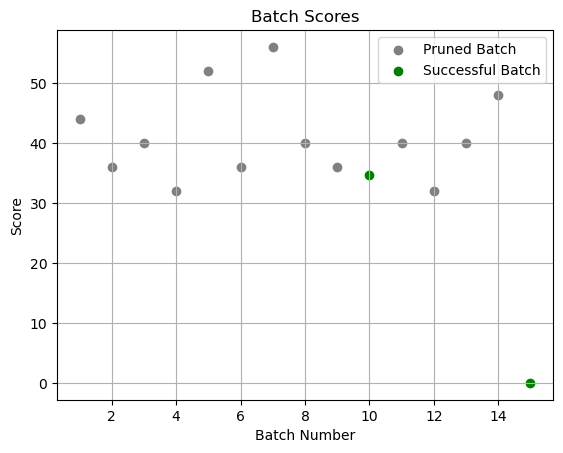

In [10]:
import matplotlib.pyplot as plt


trial_logs = optimized_program.trial_logs

trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]["score"] for trial in trial_numbers]

full_eval = [trial_logs[trial]["full_eval"] for trial in trial_numbers]

for trial_number, score, pruned in zip(trial_numbers, scores, full_eval):
    if pruned is False:
        plt.scatter(
            trial_number,
            score,
            color="grey",
            label=(
                "Pruned Batch"
                if "Pruned Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )
    else:
        plt.scatter(
            trial_number,
            score,
            color="green",
            label=(
                "Successful Batch"
                if "Successful Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )

plt.xlabel("Batch Number")
plt.ylabel("Score")
plt.title("Batch Scores")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
best_score = 0
best_program_so_far = None


def get_signature(predictor):
    if hasattr(predictor, "extended_signature"):
        return predictor.extended_signature
    elif hasattr(predictor, "signature"):
        return predictor.signature


# print(f"Baseline program | Score: {best_score}:")
# for i, predictor in enumerate(WrapperEnglishSPT().predictors()):
#     print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
# print()

print("----------------")

for trial_num in optimized_program.trial_logs:
    program_score = optimized_program.trial_logs[trial_num]["score"]
    program_pruned = optimized_program.trial_logs[trial_num]["full_eval"]
    # if (
    #     program_score > best_score
    #     and program_pruned is True
    #     # and optimized_program.trial_logs[trial_num]["full_eval"]
    # ):
    if program_pruned is True:
        best_score = program_score
        best_program_so_far = optimized_program.trial_logs[trial_num]["program"]
    # if trial_num % 5 == 0:
    #     print(f"Best program after {trial_num} batches | Score: {best_score}:")
    #     for i, predictor in enumerate(best_program_so_far.predictors()):
    #         print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
    #     print()
    
        # print(f"Best program with best score: {best_score}")
        for i, predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {trial_num} Instruction: {get_signature(predictor).instructions}")
            print(best_score)
        print()

----------------
Prompt 10 Instruction: Rate the semantic similarity of the target word in the provided sentences using the following scale: 1 (unrelated), 2 (distantly related), 3 (closely related), 4 (identical meaning). Consider only the objects/concepts the word refers to, ignoring etymology and metaphor. Homonyms count as unrelated.
34.62

Prompt 15 Instruction: You are a highly trained text data annotation tool capable of
providing subjective responses. Rate the semantic similarity of the target word in these sentences 1 and 2. Consider
only the objects/concepts the word forms refer to: ignore any common etymology and
metaphorical similarity! Ignore case! Ignore number (cat/Cats = identical meaning). Homonyms (like bat the animal vs
bat in baseball) count as unrelated. Output numeric rating: 1 is unrelated; 2 is distantly
related; 3 is closely related; 4 is identical meaning. Your response should align with a
human’s succinct judgment.
0.0



In [12]:
program_spt_prompt_en_assertions.load(
    "compile-models/sp/es_spt_mipro_optimized_prompt_en_deepseek-70b-q4"
)

In [13]:

custom_evaluate(
    random.choices(classes_1_test, k=225)
    + random.choices(classes_2_test, k=225)
    + random.choices(classes_3_test, k=225)
    + random.choices(classes_4_test, k=225),
    evaluate_answer,
    program_spt_prompt_en_assertions,
    debug=False,
)

Evaluating: 900 examples


Average Metric: 51 / 111  (45.9):  14%|█████████▍                                                          | 111/800 [00:19<00:03, 228.60it/s]

2025/05/10 12:12:04 INFO dspy.primitives.assertions: SuggestionFailed: The output shoulb be 1 or 2 or 3 or 4. Please revise accordingly.


2025/05/10 13:55:41 INFO dspy.primitives.assertions: SuggestionFailed: The output shoulb be 1 or 2 or 3 or 4. Please revise accordingly.


2025/05/10 18:51:13 INFO dspy.primitives.assertions: SuggestionFailed: The output shoulb be 1 or 2 or 3 or 4. Please revise accordingly.


Accurate examples: 363
Bad-formatted examples: 0
Accuracy: 40.333333333333336
